In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from collections import Counter
import math
import re
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

In [2]:
real_train=pd.read_csv('train.csv')
real_test=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

In [3]:
real_train.head(1)

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80.0,0.625,0.375,0.0,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.068,3.4387


# Data exploration

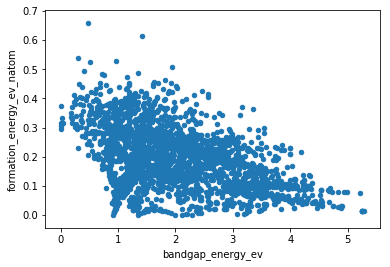

In [5]:
real_train.plot.scatter(x='bandgap_energy_ev',y='formation_energy_ev_natom')

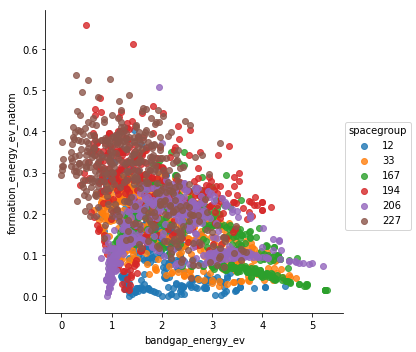

In [6]:
sns.lmplot('bandgap_energy_ev', 'formation_energy_ev_natom', data=real_train, hue='spacegroup', fit_reg=False)

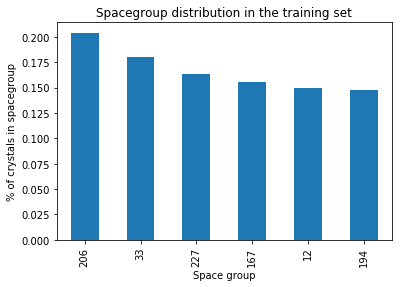

In [4]:
real_train['spacegroup'].value_counts(normalize=True).plot.bar()
plt.title('Spacegroup distribution in the training set')
plt.ylabel('% of crystals in spacegroup')
plt.xlabel('Space group')
plt.show()

In [7]:
def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
for lang in lattice_angles:
    real_train['_'.join([lang, 'r'])] = np.pi * real_train[lang] / 180
    
# compute the cell volumes 
real_train['vol'] = get_vol(real_train['lattice_vector_1_ang'], 
                            real_train['lattice_vector_2_ang'], 
                            real_train['lattice_vector_3_ang'],
                            real_train['lattice_angle_alpha_degree_r'],
                            real_train['lattice_angle_beta_degree_r'], 
                            real_train['lattice_angle_gamma_degree_r'])

In [8]:
# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
for lang in lattice_angles:
    real_test['_'.join([lang, 'r'])] = np.pi * real_test[lang] / 180
    
# compute the cell volumes 
real_test['vol'] = get_vol(real_test['lattice_vector_1_ang'], 
                            real_test['lattice_vector_2_ang'], 
                            real_test['lattice_vector_3_ang'],
                            real_test['lattice_angle_alpha_degree_r'],
                            real_test['lattice_angle_beta_degree_r'], 
                            real_test['lattice_angle_gamma_degree_r'])

In [10]:
# добавим количество каждого атома
for i in ['ga','in','al']:
    real_train[i+'_tcnt']=real_train.apply(lambda x: x['percent_atom_'+i]*x.number_of_total_atoms*2/5, axis=1)
    real_test[i+'_tcnt']=real_test.apply(lambda x: x['percent_atom_'+i]*x.number_of_total_atoms*2/5, axis=1)

real_train['o_tcnt']=real_train.apply(lambda x: x.number_of_total_atoms*3/5, axis=1)
real_test['o_tcnt']=real_test.apply(lambda x: x.number_of_total_atoms*3/5, axis=1)

In [11]:
# calculate the atomic density
# this is known to correlate with stability or bonding strength
real_train['atomic_density'] = real_train['number_of_total_atoms'] / real_train['vol']   
real_test['atomic_density'] = real_test['number_of_total_atoms'] / real_test['vol']

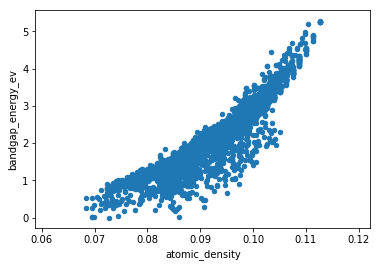

In [12]:
#bandgap_energy_ev atomic_density
real_train.plot.scatter(x='atomic_density',y='bandgap_energy_ev')

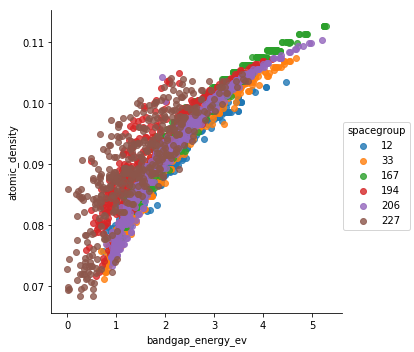

In [18]:
sns.lmplot('bandgap_energy_ev', 'atomic_density', data=real_train, hue='spacegroup', fit_reg=False)

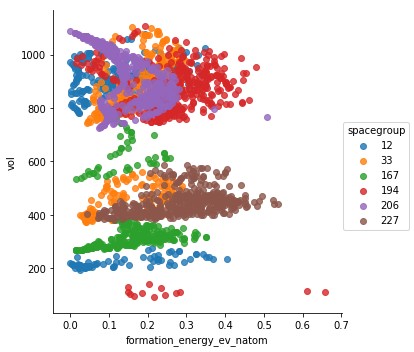

In [21]:
sns.lmplot('formation_energy_ev_natom', 'vol', data=real_train, hue='spacegroup', fit_reg=False)

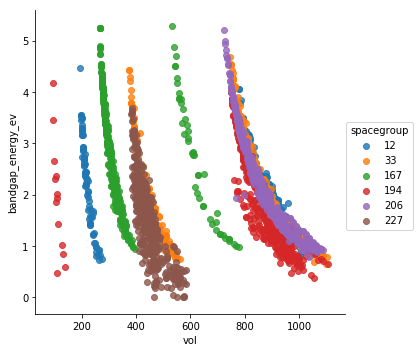

In [23]:
sns.lmplot('vol','bandgap_energy_ev', data=real_train, hue='spacegroup', fit_reg=False)

In [13]:
def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=np.float),x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=np.float))
    return pos_data, np.array(lat_data)

In [14]:
ga_cols = []
al_cols = []
o_cols = []
in_cols = []

import warnings
warnings.filterwarnings("ignore")

for i in range(7):
    ga_cols.append("Ga_"+str(i))

for i in range(7):
    al_cols.append("Al_"+str(i))

for i in range(7):
    o_cols.append("O_"+str(i))

for i in range(7):
    in_cols.append("In_"+str(i))

ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)

In [15]:
import os
cwd = os.getcwd()
for i in real_train.id.values:
    fn = cwd+"/train/{}/geometry.xyz".format(i)
    real_train_xyz, real_train_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    
    ga_cnt = 0
    al_cnt = 0
    o_cnt = 0
    in_cnt = 0
    
    for li in real_train_xyz:
        if li[1] == "Ga":
            ga_cnt+=1
            ga_list.append(li[0])
        elif li[1] == "Al":
            al_list.append(li[0])
            al_cnt+=1
        elif li[1] == "In":
            in_list.append(li[0])
            in_cnt+=1
        elif li[1] == "O":
            o_cnt+=1
            o_list.append(li[0])
        
#     ga_list = [item for sublist in ga_list for item in sublist]
#     al_list = [item for sublist in al_list for item in sublist]
#     o_list = [item for sublist in o_list for item in sublist]
   
    
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga['Ga_6']=ga_cnt
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])
   

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al['Al_6']=al_cnt
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o['O_6']=o_cnt
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in['In_6']=in_cnt
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])

In [16]:
ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

real_train = pd.merge(real_train,ga_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,al_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,o_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,in_df,on = ["id"],how = "left")
    
ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)    

In [17]:
for i in real_test.id.values:
    fn = cwd+"/test/{}/geometry.xyz".format(i)
    real_train_xyz, real_train_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    ga_cnt = 0
    al_cnt = 0
    o_cnt = 0
    in_cnt = 0
    
    for li in real_train_xyz:
        if li[1] == "Ga":
            ga_cnt+=1
            ga_list.append(li[0])
        elif li[1] == "Al":
            al_list.append(li[0])
            al_cnt+=1
        elif li[1] == "In":
            in_list.append(li[0])
            in_cnt+=1
        elif li[1] == "O":
            o_cnt+=1
            o_list.append(li[0])
    
#     ga_list = [item for sublist in ga_list for item in sublist]
#     al_list = [item for sublist in al_list for item in sublist]
#     o_list = [item for sublist in o_list for item in sublist]
   
    
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga['Ga_6']=ga_cnt
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])
   

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al['Al_6']=al_cnt
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o['O_6']=o_cnt
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in['In_6']=in_cnt
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])
    

ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

real_test = pd.merge(real_test,ga_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,al_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,o_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,in_df,on = ["id"],how = "left")

In [17]:
real_test.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,...,O_4,O_5,O_6,In_0,In_1,In_2,In_3,In_4,In_5,In_6
0,1,33,80.0,0.1875,0.4688,0.3438,10.5381,9.0141,9.6361,89.9997,...,-7.607262,13.963306,48,-6.939157,-3.962924,-0.814587,6.795588,7.753744,-2.832664,11
1,2,33,80.0,0.7500,0.2500,0.0000,9.8938,8.5014,9.1298,90.0038,...,-7.675262,12.922098,48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,3,167,30.0,0.6667,0.1667,0.1667,4.9811,4.9808,13.4799,89.9900,...,18.630740,-0.982884,18,-4.914356,-1.223963,-3.590513,1.357926,8.504869,-0.133963,2
3,4,12,80.0,0.5625,0.4375,0.0000,24.3370,6.0091,5.7620,89.9995,...,-25.392938,8.052706,48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,5,12,80.0,0.1875,0.5000,0.3125,24.6443,6.2906,6.1589,90.0000,...,-25.471754,8.523775,48,27.301489,-0.108903,-12.967463,3.317993,-14.334026,-3.209089,10


In [18]:
len(real_test.columns)

49

In [19]:
len(real_train.columns)

51

In [20]:
def rmsle(h, y): 
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [21]:
X = real_train.drop(['id','bandgap_energy_ev','formation_energy_ev_natom'], axis=1)
Y_feen = np.log(real_train['formation_energy_ev_natom']+1)
Y_bee = np.log(real_train['bandgap_energy_ev']+1)

In [22]:
test_id=real_test.id
real_test = real_test.drop(['id'], axis = 1)

In [23]:
params = {'depth':[3,4,5,6,7,8,9,10],
          'iterations':[250,500,1000,1500],
          'learning_rate':[0.01, 0.03, 0.1, 0.2, 0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
#           'use_best_model': True,
#           'eval_metric': 'RMSE',
#           'ctr_description': ('Borders', 'Buckets', 'BinarizedTargetMeanValue', 'Counter'),
          'rsm': 0.8,
          'random_seed':42,
          'border_count':[50,100,200],
#           'ctr_border_count':[50,100,200],
          'thread_count':4,
          'loss_function':'RMSE'}

In [24]:
# this function does 3-fold crossvalidation with catboostclassifier          
from sklearn.model_selection import KFold
def crossvaltest(param, train_set, features, target, cat_param,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]
        
        train_target=train[target]
        test_target=test[target]
        
        train=train[features]
        test=test[features]
        
        indices = np.where(np.in1d(train.columns, cat_param))[0]
        train_pool = Pool(train, train_target, cat_features=indices)
        test_pool = Pool(test,cat_features=indices)
        
        clf = CatBoostRegressor(**param)
        clf.fit(train_pool)
        preds=clf.predict(test_pool)
        res.append(np.sqrt(mean_squared_error(preds, test_target)))
    return np.mean(res)

In [25]:
# this function runs grid search on several parameters
from paramsearch import paramsearch
from itertools import product,chain
def catboost_param_tune(params,train_set, features, target, cat_param,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
#                       ps.grid_search(['ctr_border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['learning_rate']),
                      ps.grid_search(['iterations']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms, train_set, features, target, cat_param,n_splits=3)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(-res,prms)
        print(res, prms, 'best:',-ps.bestscore(),ps.bestparam(),'\n')
    return ps.bestparam()

In [26]:
real_train['log_form']=Y_feen
feats=real_train.columns.tolist()
feats.remove('log_form')
feats.remove('id')
feats.remove('bandgap_energy_ev')
feats.remove('formation_energy_ev_natom')

In [27]:
cat_param=['spacegroup']

In [28]:
bestparams = catboost_param_tune(params=params, train_set=real_train, features=feats, target='log_form',cat_param=cat_param)

0:	learn: 0.1885609	total: 49.3ms	remaining: 12.3s
1:	learn: 0.1869235	total: 51.8ms	remaining: 6.42s
2:	learn: 0.1852588	total: 54.2ms	remaining: 4.46s
3:	learn: 0.1836886	total: 56.6ms	remaining: 3.48s
4:	learn: 0.1820948	total: 58.8ms	remaining: 2.88s
5:	learn: 0.1805802	total: 60.7ms	remaining: 2.47s
6:	learn: 0.1790799	total: 62.8ms	remaining: 2.18s
7:	learn: 0.1776647	total: 64.9ms	remaining: 1.96s
8:	learn: 0.1761692	total: 67.1ms	remaining: 1.8s
9:	learn: 0.1747767	total: 69.8ms	remaining: 1.68s
10:	learn: 0.1733139	total: 72.6ms	remaining: 1.58s
11:	learn: 0.1719391	total: 75.1ms	remaining: 1.49s
12:	learn: 0.1704583	total: 77.7ms	remaining: 1.42s
13:	learn: 0.1691076	total: 80.3ms	remaining: 1.35s
14:	learn: 0.1677167	total: 82.9ms	remaining: 1.3s
15:	learn: 0.1663512	total: 85.7ms	remaining: 1.25s
16:	learn: 0.1649398	total: 88.3ms	remaining: 1.21s
17:	learn: 0.1636080	total: 91ms	remaining: 1.17s
18:	learn: 0.1622658	total: 93.6ms	remaining: 1.14s
19:	learn: 0.1608971	total

204:	learn: 0.0552617	total: 441ms	remaining: 96.7ms
205:	learn: 0.0550913	total: 443ms	remaining: 94.6ms
206:	learn: 0.0548989	total: 445ms	remaining: 92.4ms
207:	learn: 0.0547760	total: 447ms	remaining: 90.2ms
208:	learn: 0.0546159	total: 449ms	remaining: 88.1ms
209:	learn: 0.0544464	total: 451ms	remaining: 85.9ms
210:	learn: 0.0543049	total: 453ms	remaining: 83.8ms
211:	learn: 0.0541158	total: 456ms	remaining: 81.8ms
212:	learn: 0.0539460	total: 458ms	remaining: 79.6ms
213:	learn: 0.0537983	total: 460ms	remaining: 77.5ms
214:	learn: 0.0536615	total: 464ms	remaining: 75.5ms
215:	learn: 0.0535259	total: 467ms	remaining: 73.5ms
216:	learn: 0.0533753	total: 470ms	remaining: 71.4ms
217:	learn: 0.0532176	total: 472ms	remaining: 69.3ms
218:	learn: 0.0530885	total: 474ms	remaining: 67.2ms
219:	learn: 0.0529745	total: 477ms	remaining: 65ms
220:	learn: 0.0528129	total: 479ms	remaining: 62.8ms
221:	learn: 0.0526647	total: 481ms	remaining: 60.7ms
222:	learn: 0.0525351	total: 483ms	remaining: 58

192:	learn: 0.0558101	total: 393ms	remaining: 116ms
193:	learn: 0.0556472	total: 395ms	remaining: 114ms
194:	learn: 0.0554228	total: 397ms	remaining: 112ms
195:	learn: 0.0552473	total: 399ms	remaining: 110ms
196:	learn: 0.0550120	total: 401ms	remaining: 108ms
197:	learn: 0.0548299	total: 403ms	remaining: 106ms
198:	learn: 0.0546438	total: 404ms	remaining: 104ms
199:	learn: 0.0544376	total: 406ms	remaining: 102ms
200:	learn: 0.0542359	total: 408ms	remaining: 99.4ms
201:	learn: 0.0540242	total: 409ms	remaining: 97.3ms
202:	learn: 0.0538569	total: 411ms	remaining: 95.2ms
203:	learn: 0.0536638	total: 413ms	remaining: 93.1ms
204:	learn: 0.0534575	total: 415ms	remaining: 91.1ms
205:	learn: 0.0532643	total: 417ms	remaining: 89.1ms
206:	learn: 0.0530803	total: 419ms	remaining: 87ms
207:	learn: 0.0529336	total: 421ms	remaining: 85ms
208:	learn: 0.0527618	total: 423ms	remaining: 83ms
209:	learn: 0.0526075	total: 425ms	remaining: 81ms
210:	learn: 0.0524721	total: 428ms	remaining: 79.1ms
211:	lear

106:	learn: 0.0849375	total: 197ms	remaining: 263ms
107:	learn: 0.0843908	total: 199ms	remaining: 262ms
108:	learn: 0.0839033	total: 202ms	remaining: 262ms
109:	learn: 0.0833910	total: 205ms	remaining: 261ms
110:	learn: 0.0828801	total: 208ms	remaining: 261ms
111:	learn: 0.0823302	total: 211ms	remaining: 260ms
112:	learn: 0.0818710	total: 214ms	remaining: 259ms
113:	learn: 0.0814113	total: 216ms	remaining: 257ms
114:	learn: 0.0809039	total: 218ms	remaining: 256ms
115:	learn: 0.0804330	total: 220ms	remaining: 254ms
116:	learn: 0.0800099	total: 223ms	remaining: 253ms
117:	learn: 0.0795663	total: 225ms	remaining: 252ms
118:	learn: 0.0790631	total: 227ms	remaining: 250ms
119:	learn: 0.0786937	total: 229ms	remaining: 248ms
120:	learn: 0.0782247	total: 231ms	remaining: 247ms
121:	learn: 0.0778065	total: 234ms	remaining: 245ms
122:	learn: 0.0773676	total: 236ms	remaining: 243ms
123:	learn: 0.0769200	total: 238ms	remaining: 242ms
124:	learn: 0.0764817	total: 241ms	remaining: 241ms
125:	learn: 

66:	learn: 0.1115913	total: 199ms	remaining: 544ms
67:	learn: 0.1107695	total: 202ms	remaining: 541ms
68:	learn: 0.1099781	total: 206ms	remaining: 540ms
69:	learn: 0.1092109	total: 209ms	remaining: 538ms
70:	learn: 0.1084643	total: 213ms	remaining: 536ms
71:	learn: 0.1076749	total: 216ms	remaining: 533ms
72:	learn: 0.1068456	total: 219ms	remaining: 531ms
73:	learn: 0.1061488	total: 222ms	remaining: 528ms
74:	learn: 0.1053351	total: 225ms	remaining: 526ms
75:	learn: 0.1045859	total: 228ms	remaining: 523ms
76:	learn: 0.1039004	total: 232ms	remaining: 520ms
77:	learn: 0.1031016	total: 236ms	remaining: 519ms
78:	learn: 0.1024369	total: 239ms	remaining: 516ms
79:	learn: 0.1017374	total: 242ms	remaining: 514ms
80:	learn: 0.1010489	total: 244ms	remaining: 510ms
81:	learn: 0.1003530	total: 248ms	remaining: 507ms
82:	learn: 0.0996735	total: 251ms	remaining: 505ms
83:	learn: 0.0990282	total: 255ms	remaining: 504ms
84:	learn: 0.0983399	total: 258ms	remaining: 502ms
85:	learn: 0.0976788	total: 262

0:	learn: 0.1886309	total: 2.73ms	remaining: 679ms
1:	learn: 0.1869720	total: 5.91ms	remaining: 733ms
2:	learn: 0.1853406	total: 9.36ms	remaining: 771ms
3:	learn: 0.1837742	total: 12.2ms	remaining: 753ms
4:	learn: 0.1822117	total: 15.4ms	remaining: 754ms
5:	learn: 0.1806921	total: 18.5ms	remaining: 751ms
6:	learn: 0.1791550	total: 21.8ms	remaining: 758ms
7:	learn: 0.1776401	total: 24.6ms	remaining: 745ms
8:	learn: 0.1761671	total: 27.4ms	remaining: 733ms
9:	learn: 0.1746006	total: 29.9ms	remaining: 718ms
10:	learn: 0.1730920	total: 32.8ms	remaining: 713ms
11:	learn: 0.1717467	total: 35.7ms	remaining: 709ms
12:	learn: 0.1702508	total: 38.3ms	remaining: 698ms
13:	learn: 0.1688638	total: 40.7ms	remaining: 687ms
14:	learn: 0.1673832	total: 43.1ms	remaining: 676ms
15:	learn: 0.1659962	total: 45.8ms	remaining: 670ms
16:	learn: 0.1645780	total: 48.3ms	remaining: 662ms
17:	learn: 0.1632239	total: 51.1ms	remaining: 659ms
18:	learn: 0.1618080	total: 53.7ms	remaining: 652ms
19:	learn: 0.1604649	t

186:	learn: 0.0572856	total: 587ms	remaining: 198ms
187:	learn: 0.0570963	total: 591ms	remaining: 195ms
188:	learn: 0.0569116	total: 594ms	remaining: 192ms
189:	learn: 0.0566936	total: 599ms	remaining: 189ms
190:	learn: 0.0564566	total: 602ms	remaining: 186ms
191:	learn: 0.0562751	total: 605ms	remaining: 183ms
192:	learn: 0.0560498	total: 607ms	remaining: 179ms
193:	learn: 0.0558308	total: 610ms	remaining: 176ms
194:	learn: 0.0556192	total: 614ms	remaining: 173ms
195:	learn: 0.0554540	total: 616ms	remaining: 170ms
196:	learn: 0.0553105	total: 619ms	remaining: 167ms
197:	learn: 0.0551221	total: 622ms	remaining: 163ms
198:	learn: 0.0549409	total: 625ms	remaining: 160ms
199:	learn: 0.0548040	total: 627ms	remaining: 157ms
200:	learn: 0.0546148	total: 630ms	remaining: 154ms
201:	learn: 0.0544713	total: 634ms	remaining: 151ms
202:	learn: 0.0542953	total: 638ms	remaining: 148ms
203:	learn: 0.0540969	total: 641ms	remaining: 144ms
204:	learn: 0.0539412	total: 644ms	remaining: 141ms
205:	learn: 

121:	learn: 0.0782074	total: 391ms	remaining: 410ms
122:	learn: 0.0777529	total: 395ms	remaining: 407ms
123:	learn: 0.0773057	total: 398ms	remaining: 404ms
124:	learn: 0.0768401	total: 401ms	remaining: 401ms
125:	learn: 0.0764319	total: 404ms	remaining: 398ms
126:	learn: 0.0759908	total: 407ms	remaining: 394ms
127:	learn: 0.0756332	total: 410ms	remaining: 391ms
128:	learn: 0.0752174	total: 414ms	remaining: 388ms
129:	learn: 0.0748326	total: 417ms	remaining: 385ms
130:	learn: 0.0744743	total: 420ms	remaining: 381ms
131:	learn: 0.0741444	total: 423ms	remaining: 378ms
132:	learn: 0.0737257	total: 426ms	remaining: 375ms
133:	learn: 0.0733708	total: 429ms	remaining: 371ms
134:	learn: 0.0730407	total: 432ms	remaining: 368ms
135:	learn: 0.0726487	total: 435ms	remaining: 365ms
136:	learn: 0.0722703	total: 438ms	remaining: 361ms
137:	learn: 0.0719281	total: 441ms	remaining: 358ms
138:	learn: 0.0715969	total: 444ms	remaining: 355ms
139:	learn: 0.0712639	total: 448ms	remaining: 352ms
140:	learn: 

116:	learn: 0.0796372	total: 197ms	remaining: 224ms
117:	learn: 0.0791424	total: 199ms	remaining: 223ms
118:	learn: 0.0786507	total: 201ms	remaining: 221ms
119:	learn: 0.0781815	total: 203ms	remaining: 220ms
120:	learn: 0.0777364	total: 205ms	remaining: 218ms
121:	learn: 0.0773199	total: 207ms	remaining: 217ms
122:	learn: 0.0769259	total: 209ms	remaining: 215ms
123:	learn: 0.0764652	total: 210ms	remaining: 214ms
124:	learn: 0.0760617	total: 212ms	remaining: 212ms
125:	learn: 0.0756353	total: 214ms	remaining: 211ms
126:	learn: 0.0751972	total: 216ms	remaining: 209ms
127:	learn: 0.0748088	total: 218ms	remaining: 208ms
128:	learn: 0.0743706	total: 220ms	remaining: 206ms
129:	learn: 0.0739397	total: 222ms	remaining: 205ms
130:	learn: 0.0735209	total: 224ms	remaining: 203ms
131:	learn: 0.0731065	total: 226ms	remaining: 202ms
132:	learn: 0.0727460	total: 228ms	remaining: 200ms
133:	learn: 0.0723702	total: 230ms	remaining: 199ms
134:	learn: 0.0720151	total: 232ms	remaining: 197ms
135:	learn: 

88:	learn: 0.0941643	total: 193ms	remaining: 350ms
89:	learn: 0.0935739	total: 196ms	remaining: 348ms
90:	learn: 0.0929802	total: 199ms	remaining: 347ms
91:	learn: 0.0923537	total: 201ms	remaining: 346ms
92:	learn: 0.0917615	total: 204ms	remaining: 344ms
93:	learn: 0.0911164	total: 207ms	remaining: 344ms
94:	learn: 0.0905598	total: 210ms	remaining: 342ms
95:	learn: 0.0899997	total: 212ms	remaining: 340ms
96:	learn: 0.0894017	total: 214ms	remaining: 338ms
97:	learn: 0.0888527	total: 216ms	remaining: 335ms
98:	learn: 0.0882875	total: 219ms	remaining: 334ms
99:	learn: 0.0877650	total: 221ms	remaining: 332ms
100:	learn: 0.0872083	total: 224ms	remaining: 330ms
101:	learn: 0.0866612	total: 226ms	remaining: 328ms
102:	learn: 0.0861418	total: 228ms	remaining: 326ms
103:	learn: 0.0856723	total: 230ms	remaining: 324ms
104:	learn: 0.0851170	total: 233ms	remaining: 321ms
105:	learn: 0.0845767	total: 235ms	remaining: 319ms
106:	learn: 0.0840565	total: 237ms	remaining: 317ms
107:	learn: 0.0835662	to

0:	learn: 0.1868983	total: 1.86ms	remaining: 464ms
1:	learn: 0.1852539	total: 4.18ms	remaining: 519ms
2:	learn: 0.1835895	total: 6.95ms	remaining: 572ms
3:	learn: 0.1819802	total: 9.46ms	remaining: 582ms
4:	learn: 0.1804355	total: 11.6ms	remaining: 566ms
5:	learn: 0.1789457	total: 13.6ms	remaining: 554ms
6:	learn: 0.1773293	total: 16.6ms	remaining: 577ms
7:	learn: 0.1757790	total: 19.5ms	remaining: 589ms
8:	learn: 0.1743002	total: 22.5ms	remaining: 602ms
9:	learn: 0.1728222	total: 25.5ms	remaining: 611ms
10:	learn: 0.1713590	total: 27.8ms	remaining: 603ms
11:	learn: 0.1699559	total: 30.5ms	remaining: 605ms
12:	learn: 0.1685581	total: 32.8ms	remaining: 598ms
13:	learn: 0.1671477	total: 40.4ms	remaining: 680ms
14:	learn: 0.1656796	total: 43.5ms	remaining: 682ms
15:	learn: 0.1642716	total: 46.4ms	remaining: 678ms
16:	learn: 0.1628603	total: 48.9ms	remaining: 671ms
17:	learn: 0.1614949	total: 50.7ms	remaining: 654ms
18:	learn: 0.1601208	total: 53.6ms	remaining: 651ms
19:	learn: 0.1587570	t

164:	learn: 0.0619487	total: 391ms	remaining: 201ms
165:	learn: 0.0617323	total: 394ms	remaining: 199ms
166:	learn: 0.0614736	total: 396ms	remaining: 197ms
167:	learn: 0.0611869	total: 399ms	remaining: 195ms
168:	learn: 0.0609203	total: 402ms	remaining: 193ms
169:	learn: 0.0606466	total: 405ms	remaining: 190ms
170:	learn: 0.0604021	total: 408ms	remaining: 188ms
171:	learn: 0.0601289	total: 411ms	remaining: 186ms
172:	learn: 0.0599134	total: 414ms	remaining: 184ms
173:	learn: 0.0596468	total: 416ms	remaining: 182ms
174:	learn: 0.0593983	total: 419ms	remaining: 179ms
175:	learn: 0.0591569	total: 421ms	remaining: 177ms
176:	learn: 0.0589379	total: 423ms	remaining: 174ms
177:	learn: 0.0587501	total: 426ms	remaining: 172ms
178:	learn: 0.0585146	total: 429ms	remaining: 170ms
179:	learn: 0.0583008	total: 432ms	remaining: 168ms
180:	learn: 0.0581082	total: 435ms	remaining: 166ms
181:	learn: 0.0578837	total: 438ms	remaining: 164ms
182:	learn: 0.0576734	total: 440ms	remaining: 161ms
183:	learn: 

113:	learn: 0.0808932	total: 197ms	remaining: 235ms
114:	learn: 0.0804087	total: 199ms	remaining: 233ms
115:	learn: 0.0799483	total: 201ms	remaining: 232ms
116:	learn: 0.0794426	total: 203ms	remaining: 231ms
117:	learn: 0.0789278	total: 205ms	remaining: 230ms
118:	learn: 0.0784715	total: 207ms	remaining: 228ms
119:	learn: 0.0779975	total: 209ms	remaining: 226ms
120:	learn: 0.0774906	total: 211ms	remaining: 225ms
121:	learn: 0.0770081	total: 213ms	remaining: 223ms
122:	learn: 0.0765760	total: 215ms	remaining: 222ms
123:	learn: 0.0761807	total: 217ms	remaining: 221ms
124:	learn: 0.0757472	total: 220ms	remaining: 220ms
125:	learn: 0.0753091	total: 222ms	remaining: 219ms
126:	learn: 0.0749309	total: 226ms	remaining: 218ms
127:	learn: 0.0745732	total: 228ms	remaining: 217ms
128:	learn: 0.0741139	total: 231ms	remaining: 217ms
129:	learn: 0.0737136	total: 234ms	remaining: 216ms
130:	learn: 0.0733696	total: 236ms	remaining: 215ms
131:	learn: 0.0729560	total: 238ms	remaining: 213ms
132:	learn: 

85:	learn: 0.0984874	total: 195ms	remaining: 371ms
86:	learn: 0.0977966	total: 197ms	remaining: 369ms
87:	learn: 0.0972061	total: 200ms	remaining: 368ms
88:	learn: 0.0965947	total: 202ms	remaining: 365ms
89:	learn: 0.0959943	total: 204ms	remaining: 364ms
90:	learn: 0.0953845	total: 207ms	remaining: 361ms
91:	learn: 0.0948274	total: 209ms	remaining: 359ms
92:	learn: 0.0942441	total: 211ms	remaining: 356ms
93:	learn: 0.0936307	total: 213ms	remaining: 354ms
94:	learn: 0.0930010	total: 216ms	remaining: 352ms
95:	learn: 0.0923560	total: 218ms	remaining: 349ms
96:	learn: 0.0918019	total: 220ms	remaining: 347ms
97:	learn: 0.0911934	total: 222ms	remaining: 345ms
98:	learn: 0.0906393	total: 225ms	remaining: 343ms
99:	learn: 0.0900746	total: 227ms	remaining: 340ms
100:	learn: 0.0895032	total: 230ms	remaining: 339ms
101:	learn: 0.0889243	total: 232ms	remaining: 337ms
102:	learn: 0.0883480	total: 235ms	remaining: 335ms
103:	learn: 0.0877777	total: 237ms	remaining: 333ms
104:	learn: 0.0872203	total

0:	learn: 0.1876466	total: 2.18ms	remaining: 543ms
1:	learn: 0.1860279	total: 4.82ms	remaining: 598ms
2:	learn: 0.1844043	total: 7.13ms	remaining: 587ms
3:	learn: 0.1828328	total: 9.13ms	remaining: 562ms
4:	learn: 0.1812585	total: 11.1ms	remaining: 543ms
5:	learn: 0.1797785	total: 13.3ms	remaining: 540ms
6:	learn: 0.1782988	total: 15.9ms	remaining: 553ms
7:	learn: 0.1768190	total: 18.6ms	remaining: 562ms
8:	learn: 0.1753049	total: 21.8ms	remaining: 583ms
9:	learn: 0.1738218	total: 24ms	remaining: 575ms
10:	learn: 0.1723130	total: 26ms	remaining: 565ms
11:	learn: 0.1709299	total: 28.3ms	remaining: 561ms
12:	learn: 0.1695309	total: 30.4ms	remaining: 555ms
13:	learn: 0.1680933	total: 32.4ms	remaining: 546ms
14:	learn: 0.1666774	total: 34.5ms	remaining: 540ms
15:	learn: 0.1652601	total: 36.4ms	remaining: 533ms
16:	learn: 0.1638744	total: 38.6ms	remaining: 529ms
17:	learn: 0.1625291	total: 40.5ms	remaining: 522ms
18:	learn: 0.1611862	total: 42.4ms	remaining: 515ms
19:	learn: 0.1598113	total

161:	learn: 0.0648654	total: 386ms	remaining: 210ms
162:	learn: 0.0646285	total: 391ms	remaining: 209ms
163:	learn: 0.0644057	total: 396ms	remaining: 208ms
164:	learn: 0.0641444	total: 400ms	remaining: 206ms
165:	learn: 0.0638621	total: 402ms	remaining: 203ms
166:	learn: 0.0635909	total: 404ms	remaining: 201ms
167:	learn: 0.0633559	total: 406ms	remaining: 198ms
168:	learn: 0.0631003	total: 408ms	remaining: 196ms
169:	learn: 0.0628692	total: 410ms	remaining: 193ms
170:	learn: 0.0626423	total: 412ms	remaining: 190ms
171:	learn: 0.0623782	total: 414ms	remaining: 188ms
172:	learn: 0.0621118	total: 416ms	remaining: 185ms
173:	learn: 0.0618275	total: 417ms	remaining: 182ms
174:	learn: 0.0615936	total: 419ms	remaining: 180ms
175:	learn: 0.0613620	total: 421ms	remaining: 177ms
176:	learn: 0.0611157	total: 423ms	remaining: 174ms
177:	learn: 0.0609063	total: 425ms	remaining: 172ms
178:	learn: 0.0606520	total: 427ms	remaining: 169ms
179:	learn: 0.0604143	total: 429ms	remaining: 167ms
180:	learn: 

84:	learn: 0.1007336	total: 197ms	remaining: 382ms
85:	learn: 0.1000475	total: 199ms	remaining: 379ms
86:	learn: 0.0994369	total: 201ms	remaining: 377ms
87:	learn: 0.0987383	total: 204ms	remaining: 375ms
88:	learn: 0.0981132	total: 206ms	remaining: 373ms
89:	learn: 0.0974423	total: 209ms	remaining: 372ms
90:	learn: 0.0968186	total: 212ms	remaining: 370ms
91:	learn: 0.0961626	total: 214ms	remaining: 367ms
92:	learn: 0.0955992	total: 216ms	remaining: 364ms
93:	learn: 0.0950053	total: 218ms	remaining: 361ms
94:	learn: 0.0943853	total: 220ms	remaining: 358ms
95:	learn: 0.0937817	total: 222ms	remaining: 355ms
96:	learn: 0.0931757	total: 224ms	remaining: 353ms
97:	learn: 0.0926070	total: 226ms	remaining: 350ms
98:	learn: 0.0920144	total: 228ms	remaining: 347ms
99:	learn: 0.0914352	total: 229ms	remaining: 344ms
100:	learn: 0.0908809	total: 231ms	remaining: 341ms
101:	learn: 0.0903456	total: 233ms	remaining: 338ms
102:	learn: 0.0897706	total: 235ms	remaining: 335ms
103:	learn: 0.0892407	total:

0:	learn: 0.1872257	total: 2.11ms	remaining: 526ms
1:	learn: 0.1856575	total: 4.32ms	remaining: 536ms
2:	learn: 0.1840634	total: 6.44ms	remaining: 531ms
3:	learn: 0.1825199	total: 8.49ms	remaining: 522ms
4:	learn: 0.1809772	total: 10.5ms	remaining: 516ms
5:	learn: 0.1795000	total: 12.4ms	remaining: 504ms
6:	learn: 0.1779950	total: 14.3ms	remaining: 497ms
7:	learn: 0.1765492	total: 16.1ms	remaining: 488ms
8:	learn: 0.1750795	total: 18.1ms	remaining: 484ms
9:	learn: 0.1737237	total: 20.2ms	remaining: 485ms
10:	learn: 0.1722981	total: 22.2ms	remaining: 483ms
11:	learn: 0.1709279	total: 24.1ms	remaining: 477ms
12:	learn: 0.1694807	total: 25.9ms	remaining: 472ms
13:	learn: 0.1681695	total: 27.7ms	remaining: 467ms
14:	learn: 0.1668026	total: 29.6ms	remaining: 463ms
15:	learn: 0.1654590	total: 31.8ms	remaining: 466ms
16:	learn: 0.1641243	total: 34.1ms	remaining: 468ms
17:	learn: 0.1628331	total: 36.3ms	remaining: 468ms
18:	learn: 0.1614841	total: 38.4ms	remaining: 467ms
19:	learn: 0.1601310	t

170:	learn: 0.0624940	total: 386ms	remaining: 178ms
171:	learn: 0.0622378	total: 389ms	remaining: 176ms
172:	learn: 0.0620028	total: 392ms	remaining: 174ms
173:	learn: 0.0617760	total: 395ms	remaining: 172ms
174:	learn: 0.0615801	total: 397ms	remaining: 170ms
175:	learn: 0.0613607	total: 400ms	remaining: 168ms
176:	learn: 0.0611211	total: 402ms	remaining: 166ms
177:	learn: 0.0609083	total: 404ms	remaining: 163ms
178:	learn: 0.0606973	total: 406ms	remaining: 161ms
179:	learn: 0.0604431	total: 408ms	remaining: 159ms
180:	learn: 0.0602234	total: 410ms	remaining: 156ms
181:	learn: 0.0600134	total: 412ms	remaining: 154ms
182:	learn: 0.0598158	total: 415ms	remaining: 152ms
183:	learn: 0.0595801	total: 417ms	remaining: 150ms
184:	learn: 0.0593137	total: 419ms	remaining: 147ms
185:	learn: 0.0591246	total: 421ms	remaining: 145ms
186:	learn: 0.0589158	total: 424ms	remaining: 143ms
187:	learn: 0.0586994	total: 426ms	remaining: 140ms
188:	learn: 0.0584993	total: 428ms	remaining: 138ms
189:	learn: 

87:	learn: 0.0966926	total: 197ms	remaining: 363ms
88:	learn: 0.0960948	total: 199ms	remaining: 361ms
89:	learn: 0.0954387	total: 202ms	remaining: 359ms
90:	learn: 0.0948030	total: 204ms	remaining: 356ms
91:	learn: 0.0942447	total: 206ms	remaining: 354ms
92:	learn: 0.0936466	total: 209ms	remaining: 352ms
93:	learn: 0.0931033	total: 211ms	remaining: 350ms
94:	learn: 0.0924524	total: 213ms	remaining: 347ms
95:	learn: 0.0918644	total: 215ms	remaining: 345ms
96:	learn: 0.0913002	total: 217ms	remaining: 343ms
97:	learn: 0.0906987	total: 219ms	remaining: 340ms
98:	learn: 0.0901515	total: 222ms	remaining: 338ms
99:	learn: 0.0896261	total: 224ms	remaining: 336ms
100:	learn: 0.0891028	total: 226ms	remaining: 334ms
101:	learn: 0.0886074	total: 228ms	remaining: 331ms
102:	learn: 0.0880533	total: 230ms	remaining: 329ms
103:	learn: 0.0875485	total: 233ms	remaining: 327ms
104:	learn: 0.0870354	total: 235ms	remaining: 325ms
105:	learn: 0.0865343	total: 237ms	remaining: 322ms
106:	learn: 0.0860828	tot

0.0501299719107 {'depth': 3, 'iterations': 250, 'learning_rate': 0.01, 'l2_leaf_reg': 10, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0482836963178 {'depth': 3, 'iterations': 250, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 0.1898930	total: 1.86ms	remaining: 462ms
1:	learn: 0.1885403	total: 3.93ms	remaining: 488ms
2:	learn: 0.1871307	total: 5.77ms	remaining: 475ms
3:	learn: 0.1857243	total: 7.99ms	remaining: 491ms
4:	learn: 0.1844172	total: 10.1ms	remaining: 494ms
5:	learn: 0.1831671	total: 12.3ms	remaining: 502ms
6:	learn: 0.1818650	total: 14.3ms	remaining: 496ms
7:	learn: 0.1805518	total: 16.6ms	remaining: 502ms
8:	learn: 0.1792527	total: 18.7ms	remaining: 502ms
9:	learn: 0.1779143	total: 21.3ms	remaining: 511ms
10:	learn: 0.1767073	total: 24.2ms	remaining: 527ms
11:	learn: 0.1755598	total: 26.5ms	remaining: 525ms
12:	lea

173:	learn: 0.0716371	total: 388ms	remaining: 170ms
174:	learn: 0.0713581	total: 391ms	remaining: 168ms
175:	learn: 0.0711132	total: 393ms	remaining: 165ms
176:	learn: 0.0708579	total: 395ms	remaining: 163ms
177:	learn: 0.0705839	total: 398ms	remaining: 161ms
178:	learn: 0.0702670	total: 401ms	remaining: 159ms
179:	learn: 0.0700410	total: 403ms	remaining: 157ms
180:	learn: 0.0697404	total: 406ms	remaining: 155ms
181:	learn: 0.0695331	total: 408ms	remaining: 153ms
182:	learn: 0.0692566	total: 411ms	remaining: 150ms
183:	learn: 0.0690204	total: 413ms	remaining: 148ms
184:	learn: 0.0688075	total: 415ms	remaining: 146ms
185:	learn: 0.0685801	total: 417ms	remaining: 144ms
186:	learn: 0.0683007	total: 420ms	remaining: 141ms
187:	learn: 0.0680872	total: 422ms	remaining: 139ms
188:	learn: 0.0678663	total: 424ms	remaining: 137ms
189:	learn: 0.0676391	total: 427ms	remaining: 135ms
190:	learn: 0.0674293	total: 429ms	remaining: 133ms
191:	learn: 0.0672308	total: 431ms	remaining: 130ms
192:	learn: 

113:	learn: 0.0930378	total: 199ms	remaining: 237ms
114:	learn: 0.0925762	total: 201ms	remaining: 236ms
115:	learn: 0.0921207	total: 203ms	remaining: 235ms
116:	learn: 0.0916959	total: 205ms	remaining: 233ms
117:	learn: 0.0912471	total: 207ms	remaining: 232ms
118:	learn: 0.0908467	total: 209ms	remaining: 230ms
119:	learn: 0.0904001	total: 214ms	remaining: 232ms
120:	learn: 0.0900034	total: 217ms	remaining: 231ms
121:	learn: 0.0895658	total: 219ms	remaining: 230ms
122:	learn: 0.0891039	total: 221ms	remaining: 228ms
123:	learn: 0.0887008	total: 223ms	remaining: 227ms
124:	learn: 0.0882797	total: 225ms	remaining: 225ms
125:	learn: 0.0878576	total: 227ms	remaining: 223ms
126:	learn: 0.0874833	total: 229ms	remaining: 222ms
127:	learn: 0.0870894	total: 231ms	remaining: 220ms
128:	learn: 0.0866208	total: 233ms	remaining: 218ms
129:	learn: 0.0862014	total: 235ms	remaining: 217ms
130:	learn: 0.0858071	total: 237ms	remaining: 215ms
131:	learn: 0.0854182	total: 239ms	remaining: 213ms
132:	learn: 

108:	learn: 0.0950400	total: 197ms	remaining: 255ms
109:	learn: 0.0945697	total: 199ms	remaining: 253ms
110:	learn: 0.0940766	total: 201ms	remaining: 251ms
111:	learn: 0.0935922	total: 202ms	remaining: 249ms
112:	learn: 0.0931362	total: 204ms	remaining: 247ms
113:	learn: 0.0927561	total: 205ms	remaining: 245ms
114:	learn: 0.0923393	total: 207ms	remaining: 243ms
115:	learn: 0.0919091	total: 210ms	remaining: 242ms
116:	learn: 0.0914245	total: 213ms	remaining: 242ms
117:	learn: 0.0909939	total: 215ms	remaining: 241ms
118:	learn: 0.0905188	total: 218ms	remaining: 240ms
119:	learn: 0.0900839	total: 220ms	remaining: 238ms
120:	learn: 0.0896637	total: 222ms	remaining: 237ms
121:	learn: 0.0892157	total: 224ms	remaining: 235ms
122:	learn: 0.0887766	total: 226ms	remaining: 233ms
123:	learn: 0.0884223	total: 228ms	remaining: 232ms
124:	learn: 0.0879990	total: 230ms	remaining: 230ms
125:	learn: 0.0876213	total: 232ms	remaining: 228ms
126:	learn: 0.0871872	total: 235ms	remaining: 227ms
127:	learn: 

111:	learn: 0.0432276	total: 197ms	remaining: 242ms
112:	learn: 0.0431280	total: 199ms	remaining: 241ms
113:	learn: 0.0429867	total: 202ms	remaining: 240ms
114:	learn: 0.0428291	total: 204ms	remaining: 240ms
115:	learn: 0.0427222	total: 207ms	remaining: 239ms
116:	learn: 0.0425726	total: 210ms	remaining: 238ms
117:	learn: 0.0424040	total: 213ms	remaining: 238ms
118:	learn: 0.0423174	total: 216ms	remaining: 237ms
119:	learn: 0.0422354	total: 218ms	remaining: 236ms
120:	learn: 0.0421064	total: 219ms	remaining: 234ms
121:	learn: 0.0419931	total: 221ms	remaining: 232ms
122:	learn: 0.0418709	total: 223ms	remaining: 230ms
123:	learn: 0.0417740	total: 225ms	remaining: 228ms
124:	learn: 0.0416243	total: 226ms	remaining: 226ms
125:	learn: 0.0414997	total: 228ms	remaining: 225ms
126:	learn: 0.0413538	total: 230ms	remaining: 223ms
127:	learn: 0.0412377	total: 233ms	remaining: 222ms
128:	learn: 0.0411483	total: 235ms	remaining: 220ms
129:	learn: 0.0410248	total: 236ms	remaining: 218ms
130:	learn: 

106:	learn: 0.0429937	total: 198ms	remaining: 264ms
107:	learn: 0.0428018	total: 200ms	remaining: 263ms
108:	learn: 0.0426686	total: 202ms	remaining: 261ms
109:	learn: 0.0425067	total: 204ms	remaining: 259ms
110:	learn: 0.0423526	total: 205ms	remaining: 257ms
111:	learn: 0.0421890	total: 207ms	remaining: 255ms
112:	learn: 0.0420747	total: 209ms	remaining: 253ms
113:	learn: 0.0419555	total: 211ms	remaining: 252ms
114:	learn: 0.0418259	total: 213ms	remaining: 250ms
115:	learn: 0.0416889	total: 215ms	remaining: 248ms
116:	learn: 0.0415760	total: 217ms	remaining: 246ms
117:	learn: 0.0414497	total: 218ms	remaining: 244ms
118:	learn: 0.0413193	total: 220ms	remaining: 242ms
119:	learn: 0.0411498	total: 222ms	remaining: 241ms
120:	learn: 0.0409996	total: 224ms	remaining: 239ms
121:	learn: 0.0408882	total: 226ms	remaining: 238ms
122:	learn: 0.0407276	total: 229ms	remaining: 236ms
123:	learn: 0.0406011	total: 230ms	remaining: 234ms
124:	learn: 0.0405304	total: 233ms	remaining: 233ms
125:	learn: 

101:	learn: 0.0421323	total: 198ms	remaining: 288ms
102:	learn: 0.0419888	total: 200ms	remaining: 286ms
103:	learn: 0.0417805	total: 202ms	remaining: 284ms
104:	learn: 0.0415937	total: 204ms	remaining: 282ms
105:	learn: 0.0414070	total: 206ms	remaining: 280ms
106:	learn: 0.0411731	total: 209ms	remaining: 279ms
107:	learn: 0.0409805	total: 211ms	remaining: 277ms
108:	learn: 0.0408148	total: 213ms	remaining: 275ms
109:	learn: 0.0406665	total: 215ms	remaining: 274ms
110:	learn: 0.0405782	total: 217ms	remaining: 272ms
111:	learn: 0.0404054	total: 219ms	remaining: 270ms
112:	learn: 0.0402301	total: 221ms	remaining: 268ms
113:	learn: 0.0400664	total: 224ms	remaining: 267ms
114:	learn: 0.0399341	total: 226ms	remaining: 265ms
115:	learn: 0.0397819	total: 229ms	remaining: 264ms
116:	learn: 0.0396954	total: 231ms	remaining: 263ms
117:	learn: 0.0395355	total: 234ms	remaining: 262ms
118:	learn: 0.0393829	total: 237ms	remaining: 260ms
119:	learn: 0.0392598	total: 239ms	remaining: 259ms
120:	learn: 

107:	learn: 0.0316995	total: 197ms	remaining: 259ms
108:	learn: 0.0316596	total: 199ms	remaining: 257ms
109:	learn: 0.0316248	total: 201ms	remaining: 255ms
110:	learn: 0.0315053	total: 203ms	remaining: 254ms
111:	learn: 0.0314449	total: 205ms	remaining: 253ms
112:	learn: 0.0313930	total: 208ms	remaining: 252ms
113:	learn: 0.0313161	total: 211ms	remaining: 251ms
114:	learn: 0.0312952	total: 214ms	remaining: 251ms
115:	learn: 0.0312538	total: 216ms	remaining: 249ms
116:	learn: 0.0312436	total: 217ms	remaining: 247ms
117:	learn: 0.0311971	total: 219ms	remaining: 245ms
118:	learn: 0.0311649	total: 221ms	remaining: 244ms
119:	learn: 0.0311470	total: 223ms	remaining: 242ms
120:	learn: 0.0311145	total: 225ms	remaining: 240ms
121:	learn: 0.0311037	total: 227ms	remaining: 239ms
122:	learn: 0.0310543	total: 230ms	remaining: 237ms
123:	learn: 0.0310229	total: 233ms	remaining: 237ms
124:	learn: 0.0309693	total: 236ms	remaining: 236ms
125:	learn: 0.0309636	total: 239ms	remaining: 235ms
126:	learn: 

97:	learn: 0.0327983	total: 196ms	remaining: 304ms
98:	learn: 0.0327683	total: 200ms	remaining: 306ms
99:	learn: 0.0327146	total: 203ms	remaining: 304ms
100:	learn: 0.0326656	total: 206ms	remaining: 304ms
101:	learn: 0.0325822	total: 209ms	remaining: 304ms
102:	learn: 0.0325299	total: 213ms	remaining: 304ms
103:	learn: 0.0324988	total: 216ms	remaining: 303ms
104:	learn: 0.0324407	total: 218ms	remaining: 300ms
105:	learn: 0.0323936	total: 220ms	remaining: 299ms
106:	learn: 0.0323689	total: 222ms	remaining: 297ms
107:	learn: 0.0323258	total: 224ms	remaining: 295ms
108:	learn: 0.0322812	total: 226ms	remaining: 293ms
109:	learn: 0.0322617	total: 229ms	remaining: 291ms
110:	learn: 0.0322359	total: 231ms	remaining: 289ms
111:	learn: 0.0321843	total: 233ms	remaining: 287ms
112:	learn: 0.0321689	total: 235ms	remaining: 285ms
113:	learn: 0.0321152	total: 237ms	remaining: 283ms
114:	learn: 0.0320738	total: 239ms	remaining: 281ms
115:	learn: 0.0320655	total: 241ms	remaining: 279ms
116:	learn: 0.0

113:	learn: 0.0323504	total: 198ms	remaining: 236ms
114:	learn: 0.0323239	total: 200ms	remaining: 234ms
115:	learn: 0.0322630	total: 202ms	remaining: 233ms
116:	learn: 0.0322102	total: 204ms	remaining: 232ms
117:	learn: 0.0321867	total: 206ms	remaining: 230ms
118:	learn: 0.0321368	total: 208ms	remaining: 229ms
119:	learn: 0.0321020	total: 210ms	remaining: 227ms
120:	learn: 0.0319898	total: 212ms	remaining: 226ms
121:	learn: 0.0319539	total: 214ms	remaining: 224ms
122:	learn: 0.0318996	total: 216ms	remaining: 223ms
123:	learn: 0.0318799	total: 218ms	remaining: 221ms
124:	learn: 0.0318405	total: 220ms	remaining: 220ms
125:	learn: 0.0318132	total: 222ms	remaining: 218ms
126:	learn: 0.0317911	total: 224ms	remaining: 217ms
127:	learn: 0.0317189	total: 226ms	remaining: 216ms
128:	learn: 0.0316970	total: 229ms	remaining: 215ms
129:	learn: 0.0316667	total: 232ms	remaining: 214ms
130:	learn: 0.0316168	total: 234ms	remaining: 213ms
131:	learn: 0.0315934	total: 237ms	remaining: 212ms
132:	learn: 

112:	learn: 0.0285204	total: 197ms	remaining: 239ms
113:	learn: 0.0284770	total: 200ms	remaining: 238ms
114:	learn: 0.0284273	total: 202ms	remaining: 237ms
115:	learn: 0.0283913	total: 205ms	remaining: 236ms
116:	learn: 0.0283411	total: 207ms	remaining: 236ms
117:	learn: 0.0282967	total: 210ms	remaining: 235ms
118:	learn: 0.0282923	total: 213ms	remaining: 234ms
119:	learn: 0.0282624	total: 214ms	remaining: 232ms
120:	learn: 0.0282344	total: 216ms	remaining: 231ms
121:	learn: 0.0282317	total: 218ms	remaining: 229ms
122:	learn: 0.0282182	total: 220ms	remaining: 227ms
123:	learn: 0.0281856	total: 222ms	remaining: 226ms
124:	learn: 0.0281237	total: 224ms	remaining: 224ms
125:	learn: 0.0280950	total: 226ms	remaining: 223ms
126:	learn: 0.0280943	total: 228ms	remaining: 221ms
127:	learn: 0.0280508	total: 230ms	remaining: 219ms
128:	learn: 0.0280414	total: 232ms	remaining: 217ms
129:	learn: 0.0279978	total: 234ms	remaining: 216ms
130:	learn: 0.0279832	total: 235ms	remaining: 214ms
131:	learn: 

96:	learn: 0.0303088	total: 198ms	remaining: 312ms
97:	learn: 0.0302782	total: 200ms	remaining: 310ms
98:	learn: 0.0302373	total: 202ms	remaining: 308ms
99:	learn: 0.0301871	total: 205ms	remaining: 308ms
100:	learn: 0.0301436	total: 208ms	remaining: 307ms
101:	learn: 0.0301164	total: 211ms	remaining: 306ms
102:	learn: 0.0300614	total: 214ms	remaining: 305ms
103:	learn: 0.0299904	total: 216ms	remaining: 304ms
104:	learn: 0.0299198	total: 219ms	remaining: 302ms
105:	learn: 0.0298585	total: 221ms	remaining: 300ms
106:	learn: 0.0298499	total: 223ms	remaining: 298ms
107:	learn: 0.0297927	total: 225ms	remaining: 296ms
108:	learn: 0.0297544	total: 229ms	remaining: 296ms
109:	learn: 0.0296898	total: 231ms	remaining: 294ms
110:	learn: 0.0296696	total: 234ms	remaining: 293ms
111:	learn: 0.0296296	total: 237ms	remaining: 291ms
112:	learn: 0.0295588	total: 239ms	remaining: 289ms
113:	learn: 0.0295145	total: 241ms	remaining: 287ms
114:	learn: 0.0293770	total: 243ms	remaining: 285ms
115:	learn: 0.02

94:	learn: 0.0298182	total: 197ms	remaining: 321ms
95:	learn: 0.0297667	total: 199ms	remaining: 319ms
96:	learn: 0.0297082	total: 201ms	remaining: 317ms
97:	learn: 0.0296572	total: 204ms	remaining: 316ms
98:	learn: 0.0295885	total: 207ms	remaining: 315ms
99:	learn: 0.0295707	total: 209ms	remaining: 314ms
100:	learn: 0.0295225	total: 212ms	remaining: 313ms
101:	learn: 0.0295108	total: 214ms	remaining: 311ms
102:	learn: 0.0294984	total: 216ms	remaining: 309ms
103:	learn: 0.0294614	total: 219ms	remaining: 307ms
104:	learn: 0.0294604	total: 221ms	remaining: 305ms
105:	learn: 0.0294048	total: 223ms	remaining: 303ms
106:	learn: 0.0293436	total: 225ms	remaining: 301ms
107:	learn: 0.0292930	total: 227ms	remaining: 299ms
108:	learn: 0.0292545	total: 229ms	remaining: 296ms
109:	learn: 0.0292457	total: 231ms	remaining: 295ms
110:	learn: 0.0292096	total: 234ms	remaining: 292ms
111:	learn: 0.0291894	total: 236ms	remaining: 291ms
112:	learn: 0.0291666	total: 239ms	remaining: 289ms
113:	learn: 0.0291

0:	learn: 0.1399394	total: 1.94ms	remaining: 482ms
1:	learn: 0.1066287	total: 4.14ms	remaining: 514ms
2:	learn: 0.0830474	total: 6.2ms	remaining: 510ms
3:	learn: 0.0684808	total: 8.15ms	remaining: 501ms
4:	learn: 0.0601977	total: 10ms	remaining: 491ms
5:	learn: 0.0543466	total: 11.9ms	remaining: 484ms
6:	learn: 0.0499529	total: 13.9ms	remaining: 481ms
7:	learn: 0.0464583	total: 15.8ms	remaining: 479ms
8:	learn: 0.0450078	total: 18.3ms	remaining: 490ms
9:	learn: 0.0437329	total: 20.8ms	remaining: 500ms
10:	learn: 0.0424679	total: 23.3ms	remaining: 507ms
11:	learn: 0.0417567	total: 25.7ms	remaining: 509ms
12:	learn: 0.0407644	total: 28.1ms	remaining: 511ms
13:	learn: 0.0403336	total: 30.3ms	remaining: 511ms
14:	learn: 0.0398905	total: 32.6ms	remaining: 511ms
15:	learn: 0.0388119	total: 34.9ms	remaining: 511ms
16:	learn: 0.0385745	total: 37.1ms	remaining: 509ms
17:	learn: 0.0379244	total: 39.3ms	remaining: 507ms
18:	learn: 0.0375434	total: 41.3ms	remaining: 503ms
19:	learn: 0.0369823	tota

210:	learn: 0.0266718	total: 393ms	remaining: 72.6ms
211:	learn: 0.0266318	total: 395ms	remaining: 70.8ms
212:	learn: 0.0265976	total: 397ms	remaining: 68.9ms
213:	learn: 0.0265812	total: 398ms	remaining: 67ms
214:	learn: 0.0265783	total: 400ms	remaining: 65.2ms
215:	learn: 0.0265751	total: 403ms	remaining: 63.4ms
216:	learn: 0.0265719	total: 405ms	remaining: 61.6ms
217:	learn: 0.0265297	total: 407ms	remaining: 59.8ms
218:	learn: 0.0265034	total: 410ms	remaining: 58.1ms
219:	learn: 0.0264948	total: 412ms	remaining: 56.2ms
220:	learn: 0.0264860	total: 414ms	remaining: 54.3ms
221:	learn: 0.0264797	total: 416ms	remaining: 52.5ms
222:	learn: 0.0264722	total: 418ms	remaining: 50.6ms
223:	learn: 0.0264587	total: 420ms	remaining: 48.8ms
224:	learn: 0.0263948	total: 422ms	remaining: 46.9ms
225:	learn: 0.0263905	total: 424ms	remaining: 45ms
226:	learn: 0.0263798	total: 426ms	remaining: 43.2ms
227:	learn: 0.0263703	total: 428ms	remaining: 41.3ms
228:	learn: 0.0263608	total: 430ms	remaining: 39.4

211:	learn: 0.0254154	total: 391ms	remaining: 70ms
212:	learn: 0.0254144	total: 393ms	remaining: 68.2ms
213:	learn: 0.0253914	total: 395ms	remaining: 66.4ms
214:	learn: 0.0253768	total: 397ms	remaining: 64.6ms
215:	learn: 0.0253747	total: 399ms	remaining: 62.8ms
216:	learn: 0.0253372	total: 401ms	remaining: 61ms
217:	learn: 0.0253153	total: 404ms	remaining: 59.3ms
218:	learn: 0.0252866	total: 406ms	remaining: 57.5ms
219:	learn: 0.0252863	total: 409ms	remaining: 55.7ms
220:	learn: 0.0252858	total: 411ms	remaining: 54ms
221:	learn: 0.0252830	total: 413ms	remaining: 52.1ms
222:	learn: 0.0252308	total: 415ms	remaining: 50.3ms
223:	learn: 0.0252174	total: 417ms	remaining: 48.4ms
224:	learn: 0.0252174	total: 418ms	remaining: 46.5ms
225:	learn: 0.0251969	total: 421ms	remaining: 44.7ms
226:	learn: 0.0251745	total: 423ms	remaining: 42.9ms
227:	learn: 0.0251517	total: 425ms	remaining: 41ms
228:	learn: 0.0251248	total: 427ms	remaining: 39.1ms
229:	learn: 0.0250557	total: 429ms	remaining: 37.3ms
2

198:	learn: 0.0252369	total: 379ms	remaining: 97.2ms
199:	learn: 0.0252244	total: 382ms	remaining: 95.5ms
200:	learn: 0.0252149	total: 384ms	remaining: 93.6ms
201:	learn: 0.0252074	total: 386ms	remaining: 91.7ms
202:	learn: 0.0251955	total: 388ms	remaining: 89.7ms
203:	learn: 0.0251806	total: 389ms	remaining: 87.8ms
204:	learn: 0.0251545	total: 391ms	remaining: 85.9ms
205:	learn: 0.0251452	total: 393ms	remaining: 83.9ms
206:	learn: 0.0251438	total: 395ms	remaining: 82.1ms
207:	learn: 0.0251320	total: 398ms	remaining: 80.3ms
208:	learn: 0.0251171	total: 400ms	remaining: 78.5ms
209:	learn: 0.0251142	total: 403ms	remaining: 76.7ms
210:	learn: 0.0251064	total: 405ms	remaining: 74.9ms
211:	learn: 0.0250881	total: 407ms	remaining: 73ms
212:	learn: 0.0250864	total: 409ms	remaining: 71ms
213:	learn: 0.0250660	total: 411ms	remaining: 69.1ms
214:	learn: 0.0250481	total: 413ms	remaining: 67.2ms
215:	learn: 0.0250230	total: 415ms	remaining: 65.3ms
216:	learn: 0.0249337	total: 417ms	remaining: 63.4

103:	learn: 0.0284464	total: 196ms	remaining: 747ms
104:	learn: 0.0284395	total: 198ms	remaining: 745ms
105:	learn: 0.0283513	total: 200ms	remaining: 743ms
106:	learn: 0.0283311	total: 202ms	remaining: 741ms
107:	learn: 0.0283173	total: 203ms	remaining: 738ms
108:	learn: 0.0282970	total: 205ms	remaining: 736ms
109:	learn: 0.0282491	total: 207ms	remaining: 735ms
110:	learn: 0.0282310	total: 210ms	remaining: 735ms
111:	learn: 0.0282092	total: 212ms	remaining: 735ms
112:	learn: 0.0282078	total: 215ms	remaining: 735ms
113:	learn: 0.0281558	total: 217ms	remaining: 735ms
114:	learn: 0.0281442	total: 219ms	remaining: 733ms
115:	learn: 0.0281435	total: 221ms	remaining: 731ms
116:	learn: 0.0281114	total: 223ms	remaining: 730ms
117:	learn: 0.0280343	total: 225ms	remaining: 729ms
118:	learn: 0.0280203	total: 227ms	remaining: 727ms
119:	learn: 0.0279986	total: 229ms	remaining: 725ms
120:	learn: 0.0279761	total: 231ms	remaining: 724ms
121:	learn: 0.0279541	total: 233ms	remaining: 722ms
122:	learn: 

299:	learn: 0.0248838	total: 587ms	remaining: 391ms
300:	learn: 0.0248707	total: 589ms	remaining: 390ms
301:	learn: 0.0248409	total: 592ms	remaining: 388ms
302:	learn: 0.0248235	total: 595ms	remaining: 387ms
303:	learn: 0.0248167	total: 597ms	remaining: 385ms
304:	learn: 0.0248108	total: 600ms	remaining: 384ms
305:	learn: 0.0247818	total: 602ms	remaining: 382ms
306:	learn: 0.0247598	total: 604ms	remaining: 380ms
307:	learn: 0.0247551	total: 607ms	remaining: 378ms
308:	learn: 0.0247385	total: 609ms	remaining: 376ms
309:	learn: 0.0247297	total: 611ms	remaining: 375ms
310:	learn: 0.0247254	total: 613ms	remaining: 373ms
311:	learn: 0.0246796	total: 615ms	remaining: 371ms
312:	learn: 0.0246691	total: 617ms	remaining: 369ms
313:	learn: 0.0246184	total: 619ms	remaining: 367ms
314:	learn: 0.0246138	total: 622ms	remaining: 365ms
315:	learn: 0.0245835	total: 624ms	remaining: 363ms
316:	learn: 0.0245605	total: 627ms	remaining: 362ms
317:	learn: 0.0245581	total: 630ms	remaining: 360ms
318:	learn: 

495:	learn: 0.0228653	total: 974ms	remaining: 7.86ms
496:	learn: 0.0228588	total: 977ms	remaining: 5.89ms
497:	learn: 0.0228521	total: 979ms	remaining: 3.93ms
498:	learn: 0.0228513	total: 981ms	remaining: 1.97ms
499:	learn: 0.0228335	total: 984ms	remaining: 0us
0:	learn: 0.1413174	total: 2.4ms	remaining: 1.2s
1:	learn: 0.1070613	total: 4.74ms	remaining: 1.18s
2:	learn: 0.0844753	total: 7.33ms	remaining: 1.22s
3:	learn: 0.0706395	total: 9.6ms	remaining: 1.19s
4:	learn: 0.0597168	total: 11.8ms	remaining: 1.17s
5:	learn: 0.0531895	total: 14ms	remaining: 1.15s
6:	learn: 0.0496734	total: 16ms	remaining: 1.13s
7:	learn: 0.0469542	total: 17.7ms	remaining: 1.09s
8:	learn: 0.0444323	total: 19.5ms	remaining: 1.06s
9:	learn: 0.0425587	total: 21.7ms	remaining: 1.06s
10:	learn: 0.0411636	total: 24.1ms	remaining: 1.07s
11:	learn: 0.0404989	total: 26.3ms	remaining: 1.07s
12:	learn: 0.0397603	total: 28.6ms	remaining: 1.07s
13:	learn: 0.0389597	total: 30.8ms	remaining: 1.07s
14:	learn: 0.0385756	total:

215:	learn: 0.0261306	total: 394ms	remaining: 518ms
216:	learn: 0.0261148	total: 396ms	remaining: 516ms
217:	learn: 0.0261042	total: 398ms	remaining: 515ms
218:	learn: 0.0260868	total: 400ms	remaining: 513ms
219:	learn: 0.0260829	total: 402ms	remaining: 512ms
220:	learn: 0.0260686	total: 404ms	remaining: 511ms
221:	learn: 0.0260491	total: 407ms	remaining: 509ms
222:	learn: 0.0260487	total: 409ms	remaining: 508ms
223:	learn: 0.0260422	total: 411ms	remaining: 506ms
224:	learn: 0.0260204	total: 413ms	remaining: 505ms
225:	learn: 0.0260145	total: 415ms	remaining: 503ms
226:	learn: 0.0260140	total: 417ms	remaining: 501ms
227:	learn: 0.0260138	total: 419ms	remaining: 499ms
228:	learn: 0.0260081	total: 421ms	remaining: 498ms
229:	learn: 0.0260076	total: 423ms	remaining: 496ms
230:	learn: 0.0259754	total: 425ms	remaining: 494ms
231:	learn: 0.0259417	total: 427ms	remaining: 493ms
232:	learn: 0.0259099	total: 429ms	remaining: 492ms
233:	learn: 0.0259004	total: 431ms	remaining: 490ms
234:	learn: 

426:	learn: 0.0231920	total: 784ms	remaining: 134ms
427:	learn: 0.0231900	total: 787ms	remaining: 132ms
428:	learn: 0.0231895	total: 790ms	remaining: 131ms
429:	learn: 0.0231875	total: 793ms	remaining: 129ms
430:	learn: 0.0231628	total: 795ms	remaining: 127ms
431:	learn: 0.0231252	total: 798ms	remaining: 126ms
432:	learn: 0.0231247	total: 800ms	remaining: 124ms
433:	learn: 0.0231233	total: 802ms	remaining: 122ms
434:	learn: 0.0231221	total: 804ms	remaining: 120ms
435:	learn: 0.0231197	total: 806ms	remaining: 118ms
436:	learn: 0.0231103	total: 809ms	remaining: 117ms
437:	learn: 0.0231093	total: 811ms	remaining: 115ms
438:	learn: 0.0231089	total: 813ms	remaining: 113ms
439:	learn: 0.0230872	total: 815ms	remaining: 111ms
440:	learn: 0.0230826	total: 817ms	remaining: 109ms
441:	learn: 0.0230826	total: 819ms	remaining: 108ms
442:	learn: 0.0230821	total: 821ms	remaining: 106ms
443:	learn: 0.0230668	total: 824ms	remaining: 104ms
444:	learn: 0.0230665	total: 826ms	remaining: 102ms
445:	learn: 

192:	learn: 0.0262838	total: 389ms	remaining: 619ms
193:	learn: 0.0262597	total: 391ms	remaining: 617ms
194:	learn: 0.0261751	total: 393ms	remaining: 615ms
195:	learn: 0.0261698	total: 395ms	remaining: 612ms
196:	learn: 0.0261595	total: 396ms	remaining: 610ms
197:	learn: 0.0261556	total: 398ms	remaining: 608ms
198:	learn: 0.0261360	total: 400ms	remaining: 605ms
199:	learn: 0.0260564	total: 402ms	remaining: 602ms
200:	learn: 0.0260403	total: 403ms	remaining: 600ms
201:	learn: 0.0260316	total: 405ms	remaining: 597ms
202:	learn: 0.0260285	total: 406ms	remaining: 594ms
203:	learn: 0.0260277	total: 408ms	remaining: 592ms
204:	learn: 0.0260243	total: 410ms	remaining: 590ms
205:	learn: 0.0260238	total: 411ms	remaining: 587ms
206:	learn: 0.0259374	total: 413ms	remaining: 585ms
207:	learn: 0.0259365	total: 415ms	remaining: 583ms
208:	learn: 0.0259158	total: 417ms	remaining: 580ms
209:	learn: 0.0258729	total: 419ms	remaining: 578ms
210:	learn: 0.0258598	total: 420ms	remaining: 576ms
211:	learn: 

400:	learn: 0.0226293	total: 777ms	remaining: 192ms
401:	learn: 0.0226209	total: 780ms	remaining: 190ms
402:	learn: 0.0226195	total: 782ms	remaining: 188ms
403:	learn: 0.0226092	total: 784ms	remaining: 186ms
404:	learn: 0.0226074	total: 787ms	remaining: 184ms
405:	learn: 0.0226012	total: 789ms	remaining: 183ms
406:	learn: 0.0225940	total: 791ms	remaining: 181ms
407:	learn: 0.0225905	total: 794ms	remaining: 179ms
408:	learn: 0.0225881	total: 796ms	remaining: 177ms
409:	learn: 0.0225728	total: 798ms	remaining: 175ms
410:	learn: 0.0225627	total: 801ms	remaining: 173ms
411:	learn: 0.0225617	total: 803ms	remaining: 171ms
412:	learn: 0.0225461	total: 805ms	remaining: 170ms
413:	learn: 0.0225425	total: 807ms	remaining: 168ms
414:	learn: 0.0225395	total: 809ms	remaining: 166ms
415:	learn: 0.0225290	total: 812ms	remaining: 164ms
416:	learn: 0.0225131	total: 814ms	remaining: 162ms
417:	learn: 0.0224631	total: 817ms	remaining: 160ms
418:	learn: 0.0224631	total: 818ms	remaining: 158ms
419:	learn: 

106:	learn: 0.0298289	total: 197ms	remaining: 1.64s
107:	learn: 0.0298204	total: 200ms	remaining: 1.65s
108:	learn: 0.0297916	total: 203ms	remaining: 1.66s
109:	learn: 0.0297760	total: 205ms	remaining: 1.66s
110:	learn: 0.0297571	total: 208ms	remaining: 1.66s
111:	learn: 0.0297175	total: 210ms	remaining: 1.67s
112:	learn: 0.0296981	total: 212ms	remaining: 1.67s
113:	learn: 0.0296348	total: 214ms	remaining: 1.67s
114:	learn: 0.0295363	total: 216ms	remaining: 1.67s
115:	learn: 0.0295121	total: 219ms	remaining: 1.67s
116:	learn: 0.0294409	total: 221ms	remaining: 1.67s
117:	learn: 0.0294356	total: 223ms	remaining: 1.66s
118:	learn: 0.0294197	total: 225ms	remaining: 1.66s
119:	learn: 0.0294177	total: 227ms	remaining: 1.66s
120:	learn: 0.0294035	total: 229ms	remaining: 1.66s
121:	learn: 0.0293829	total: 230ms	remaining: 1.66s
122:	learn: 0.0293798	total: 232ms	remaining: 1.65s
123:	learn: 0.0293431	total: 234ms	remaining: 1.66s
124:	learn: 0.0293230	total: 236ms	remaining: 1.65s
125:	learn: 

305:	learn: 0.0257843	total: 586ms	remaining: 1.33s
306:	learn: 0.0257535	total: 588ms	remaining: 1.33s
307:	learn: 0.0257263	total: 591ms	remaining: 1.33s
308:	learn: 0.0257252	total: 593ms	remaining: 1.32s
309:	learn: 0.0257224	total: 595ms	remaining: 1.32s
310:	learn: 0.0257073	total: 598ms	remaining: 1.32s
311:	learn: 0.0256654	total: 601ms	remaining: 1.32s
312:	learn: 0.0256634	total: 604ms	remaining: 1.32s
313:	learn: 0.0256439	total: 606ms	remaining: 1.32s
314:	learn: 0.0256361	total: 608ms	remaining: 1.32s
315:	learn: 0.0256247	total: 610ms	remaining: 1.32s
316:	learn: 0.0256246	total: 612ms	remaining: 1.32s
317:	learn: 0.0256182	total: 614ms	remaining: 1.32s
318:	learn: 0.0255961	total: 616ms	remaining: 1.31s
319:	learn: 0.0255941	total: 618ms	remaining: 1.31s
320:	learn: 0.0255763	total: 620ms	remaining: 1.31s
321:	learn: 0.0255632	total: 622ms	remaining: 1.31s
322:	learn: 0.0255418	total: 624ms	remaining: 1.31s
323:	learn: 0.0255272	total: 626ms	remaining: 1.3s
324:	learn: 0

493:	learn: 0.0234546	total: 972ms	remaining: 996ms
494:	learn: 0.0234466	total: 975ms	remaining: 994ms
495:	learn: 0.0234461	total: 977ms	remaining: 993ms
496:	learn: 0.0234438	total: 979ms	remaining: 991ms
497:	learn: 0.0234400	total: 981ms	remaining: 989ms
498:	learn: 0.0234269	total: 984ms	remaining: 988ms
499:	learn: 0.0233977	total: 987ms	remaining: 987ms
500:	learn: 0.0233951	total: 990ms	remaining: 986ms
501:	learn: 0.0233862	total: 993ms	remaining: 985ms
502:	learn: 0.0233848	total: 995ms	remaining: 983ms
503:	learn: 0.0233846	total: 997ms	remaining: 982ms
504:	learn: 0.0233809	total: 1000ms	remaining: 980ms
505:	learn: 0.0233800	total: 1s	remaining: 978ms
506:	learn: 0.0233647	total: 1s	remaining: 976ms
507:	learn: 0.0233496	total: 1s	remaining: 974ms
508:	learn: 0.0233385	total: 1.01s	remaining: 972ms
509:	learn: 0.0233377	total: 1.01s	remaining: 971ms
510:	learn: 0.0233284	total: 1.01s	remaining: 969ms
511:	learn: 0.0233246	total: 1.01s	remaining: 967ms
512:	learn: 0.023318

688:	learn: 0.0216605	total: 1.36s	remaining: 613ms
689:	learn: 0.0216602	total: 1.36s	remaining: 612ms
690:	learn: 0.0216457	total: 1.36s	remaining: 610ms
691:	learn: 0.0216292	total: 1.37s	remaining: 608ms
692:	learn: 0.0216250	total: 1.37s	remaining: 606ms
693:	learn: 0.0216229	total: 1.37s	remaining: 605ms
694:	learn: 0.0215991	total: 1.37s	remaining: 603ms
695:	learn: 0.0215831	total: 1.38s	remaining: 601ms
696:	learn: 0.0215810	total: 1.38s	remaining: 599ms
697:	learn: 0.0215632	total: 1.38s	remaining: 597ms
698:	learn: 0.0215400	total: 1.38s	remaining: 595ms
699:	learn: 0.0215304	total: 1.38s	remaining: 593ms
700:	learn: 0.0215278	total: 1.39s	remaining: 591ms
701:	learn: 0.0215272	total: 1.39s	remaining: 589ms
702:	learn: 0.0215249	total: 1.39s	remaining: 587ms
703:	learn: 0.0215241	total: 1.39s	remaining: 585ms
704:	learn: 0.0214976	total: 1.39s	remaining: 583ms
705:	learn: 0.0214924	total: 1.4s	remaining: 581ms
706:	learn: 0.0214777	total: 1.4s	remaining: 579ms
707:	learn: 0.

902:	learn: 0.0202667	total: 1.75s	remaining: 188ms
903:	learn: 0.0202643	total: 1.75s	remaining: 186ms
904:	learn: 0.0202601	total: 1.75s	remaining: 184ms
905:	learn: 0.0202583	total: 1.75s	remaining: 182ms
906:	learn: 0.0202566	total: 1.76s	remaining: 180ms
907:	learn: 0.0202530	total: 1.76s	remaining: 178ms
908:	learn: 0.0202476	total: 1.76s	remaining: 176ms
909:	learn: 0.0202473	total: 1.76s	remaining: 174ms
910:	learn: 0.0202468	total: 1.77s	remaining: 173ms
911:	learn: 0.0202465	total: 1.77s	remaining: 171ms
912:	learn: 0.0202349	total: 1.77s	remaining: 169ms
913:	learn: 0.0202349	total: 1.77s	remaining: 167ms
914:	learn: 0.0202330	total: 1.77s	remaining: 165ms
915:	learn: 0.0202303	total: 1.78s	remaining: 163ms
916:	learn: 0.0202284	total: 1.78s	remaining: 161ms
917:	learn: 0.0202231	total: 1.78s	remaining: 159ms
918:	learn: 0.0202207	total: 1.78s	remaining: 157ms
919:	learn: 0.0202145	total: 1.79s	remaining: 155ms
920:	learn: 0.0202131	total: 1.79s	remaining: 153ms
921:	learn: 

81:	learn: 0.0286914	total: 194ms	remaining: 2.17s
82:	learn: 0.0286823	total: 198ms	remaining: 2.19s
83:	learn: 0.0285941	total: 200ms	remaining: 2.18s
84:	learn: 0.0284967	total: 202ms	remaining: 2.18s
85:	learn: 0.0284815	total: 205ms	remaining: 2.18s
86:	learn: 0.0284559	total: 207ms	remaining: 2.17s
87:	learn: 0.0283820	total: 210ms	remaining: 2.17s
88:	learn: 0.0282930	total: 212ms	remaining: 2.17s
89:	learn: 0.0282549	total: 214ms	remaining: 2.17s
90:	learn: 0.0281918	total: 217ms	remaining: 2.16s
91:	learn: 0.0280978	total: 219ms	remaining: 2.16s
92:	learn: 0.0280576	total: 220ms	remaining: 2.15s
93:	learn: 0.0279926	total: 222ms	remaining: 2.14s
94:	learn: 0.0279453	total: 224ms	remaining: 2.14s
95:	learn: 0.0278686	total: 226ms	remaining: 2.13s
96:	learn: 0.0277995	total: 229ms	remaining: 2.13s
97:	learn: 0.0277495	total: 231ms	remaining: 2.13s
98:	learn: 0.0277451	total: 234ms	remaining: 2.13s
99:	learn: 0.0276790	total: 236ms	remaining: 2.12s
100:	learn: 0.0276385	total: 23

266:	learn: 0.0234419	total: 582ms	remaining: 1.6s
267:	learn: 0.0233984	total: 584ms	remaining: 1.59s
268:	learn: 0.0233845	total: 586ms	remaining: 1.59s
269:	learn: 0.0233745	total: 589ms	remaining: 1.59s
270:	learn: 0.0233589	total: 591ms	remaining: 1.59s
271:	learn: 0.0233516	total: 593ms	remaining: 1.59s
272:	learn: 0.0233317	total: 595ms	remaining: 1.58s
273:	learn: 0.0233158	total: 597ms	remaining: 1.58s
274:	learn: 0.0232730	total: 600ms	remaining: 1.58s
275:	learn: 0.0232528	total: 602ms	remaining: 1.58s
276:	learn: 0.0231948	total: 604ms	remaining: 1.57s
277:	learn: 0.0231883	total: 606ms	remaining: 1.57s
278:	learn: 0.0231555	total: 608ms	remaining: 1.57s
279:	learn: 0.0231451	total: 610ms	remaining: 1.57s
280:	learn: 0.0231278	total: 612ms	remaining: 1.57s
281:	learn: 0.0231155	total: 615ms	remaining: 1.56s
282:	learn: 0.0230798	total: 617ms	remaining: 1.56s
283:	learn: 0.0230618	total: 619ms	remaining: 1.56s
284:	learn: 0.0230596	total: 621ms	remaining: 1.56s
285:	learn: 0

466:	learn: 0.0206155	total: 971ms	remaining: 1.11s
467:	learn: 0.0206129	total: 974ms	remaining: 1.11s
468:	learn: 0.0206124	total: 975ms	remaining: 1.1s
469:	learn: 0.0205978	total: 977ms	remaining: 1.1s
470:	learn: 0.0205969	total: 979ms	remaining: 1.1s
471:	learn: 0.0205967	total: 980ms	remaining: 1.1s
472:	learn: 0.0205900	total: 982ms	remaining: 1.09s
473:	learn: 0.0205768	total: 984ms	remaining: 1.09s
474:	learn: 0.0205685	total: 986ms	remaining: 1.09s
475:	learn: 0.0205667	total: 988ms	remaining: 1.09s
476:	learn: 0.0205654	total: 989ms	remaining: 1.08s
477:	learn: 0.0205529	total: 991ms	remaining: 1.08s
478:	learn: 0.0205484	total: 993ms	remaining: 1.08s
479:	learn: 0.0205431	total: 994ms	remaining: 1.08s
480:	learn: 0.0205329	total: 996ms	remaining: 1.07s
481:	learn: 0.0205326	total: 998ms	remaining: 1.07s
482:	learn: 0.0205170	total: 1s	remaining: 1.07s
483:	learn: 0.0205153	total: 1s	remaining: 1.07s
484:	learn: 0.0205087	total: 1s	remaining: 1.07s
485:	learn: 0.0205043	tot

678:	learn: 0.0187370	total: 1.36s	remaining: 645ms
679:	learn: 0.0187357	total: 1.36s	remaining: 642ms
680:	learn: 0.0187330	total: 1.37s	remaining: 641ms
681:	learn: 0.0186892	total: 1.37s	remaining: 640ms
682:	learn: 0.0186726	total: 1.37s	remaining: 638ms
683:	learn: 0.0186680	total: 1.38s	remaining: 636ms
684:	learn: 0.0186666	total: 1.38s	remaining: 634ms
685:	learn: 0.0186577	total: 1.38s	remaining: 632ms
686:	learn: 0.0186483	total: 1.38s	remaining: 630ms
687:	learn: 0.0186475	total: 1.38s	remaining: 628ms
688:	learn: 0.0186376	total: 1.39s	remaining: 626ms
689:	learn: 0.0186364	total: 1.39s	remaining: 624ms
690:	learn: 0.0186356	total: 1.39s	remaining: 623ms
691:	learn: 0.0186313	total: 1.39s	remaining: 621ms
692:	learn: 0.0186289	total: 1.4s	remaining: 619ms
693:	learn: 0.0186274	total: 1.4s	remaining: 617ms
694:	learn: 0.0186226	total: 1.4s	remaining: 615ms
695:	learn: 0.0186215	total: 1.4s	remaining: 613ms
696:	learn: 0.0186141	total: 1.4s	remaining: 611ms
697:	learn: 0.018

865:	learn: 0.0174854	total: 1.75s	remaining: 271ms
866:	learn: 0.0174845	total: 1.75s	remaining: 269ms
867:	learn: 0.0174770	total: 1.75s	remaining: 267ms
868:	learn: 0.0174751	total: 1.76s	remaining: 265ms
869:	learn: 0.0174735	total: 1.76s	remaining: 263ms
870:	learn: 0.0174733	total: 1.76s	remaining: 261ms
871:	learn: 0.0174631	total: 1.76s	remaining: 259ms
872:	learn: 0.0174520	total: 1.77s	remaining: 257ms
873:	learn: 0.0174497	total: 1.77s	remaining: 255ms
874:	learn: 0.0174454	total: 1.77s	remaining: 253ms
875:	learn: 0.0174285	total: 1.77s	remaining: 251ms
876:	learn: 0.0173991	total: 1.78s	remaining: 249ms
877:	learn: 0.0173975	total: 1.78s	remaining: 247ms
878:	learn: 0.0173953	total: 1.78s	remaining: 245ms
879:	learn: 0.0173949	total: 1.78s	remaining: 243ms
880:	learn: 0.0173944	total: 1.79s	remaining: 241ms
881:	learn: 0.0173933	total: 1.79s	remaining: 239ms
882:	learn: 0.0173923	total: 1.79s	remaining: 237ms
883:	learn: 0.0173869	total: 1.79s	remaining: 235ms
884:	learn: 

88:	learn: 0.0285558	total: 194ms	remaining: 1.99s
89:	learn: 0.0285427	total: 197ms	remaining: 1.99s
90:	learn: 0.0284916	total: 200ms	remaining: 1.99s
91:	learn: 0.0284047	total: 202ms	remaining: 2s
92:	learn: 0.0283552	total: 204ms	remaining: 1.99s
93:	learn: 0.0283307	total: 207ms	remaining: 1.99s
94:	learn: 0.0283228	total: 209ms	remaining: 1.99s
95:	learn: 0.0282879	total: 212ms	remaining: 1.99s
96:	learn: 0.0282682	total: 214ms	remaining: 1.99s
97:	learn: 0.0282499	total: 216ms	remaining: 1.99s
98:	learn: 0.0282155	total: 219ms	remaining: 1.99s
99:	learn: 0.0281461	total: 221ms	remaining: 1.99s
100:	learn: 0.0281370	total: 223ms	remaining: 1.99s
101:	learn: 0.0280052	total: 225ms	remaining: 1.98s
102:	learn: 0.0279875	total: 228ms	remaining: 1.98s
103:	learn: 0.0279823	total: 230ms	remaining: 1.98s
104:	learn: 0.0279391	total: 232ms	remaining: 1.98s
105:	learn: 0.0279388	total: 234ms	remaining: 1.98s
106:	learn: 0.0279231	total: 236ms	remaining: 1.97s
107:	learn: 0.0278951	total

256:	learn: 0.0241669	total: 577ms	remaining: 1.67s
257:	learn: 0.0241539	total: 579ms	remaining: 1.67s
258:	learn: 0.0241097	total: 581ms	remaining: 1.66s
259:	learn: 0.0240990	total: 583ms	remaining: 1.66s
260:	learn: 0.0240921	total: 586ms	remaining: 1.66s
261:	learn: 0.0240683	total: 589ms	remaining: 1.66s
262:	learn: 0.0240228	total: 591ms	remaining: 1.66s
263:	learn: 0.0240187	total: 593ms	remaining: 1.65s
264:	learn: 0.0240158	total: 595ms	remaining: 1.65s
265:	learn: 0.0239715	total: 597ms	remaining: 1.65s
266:	learn: 0.0239118	total: 599ms	remaining: 1.64s
267:	learn: 0.0239044	total: 601ms	remaining: 1.64s
268:	learn: 0.0239012	total: 604ms	remaining: 1.64s
269:	learn: 0.0238847	total: 606ms	remaining: 1.64s
270:	learn: 0.0238558	total: 607ms	remaining: 1.63s
271:	learn: 0.0238549	total: 609ms	remaining: 1.63s
272:	learn: 0.0238547	total: 612ms	remaining: 1.63s
273:	learn: 0.0238535	total: 614ms	remaining: 1.63s
274:	learn: 0.0238533	total: 615ms	remaining: 1.62s
275:	learn: 

434:	learn: 0.0223451	total: 960ms	remaining: 1.25s
435:	learn: 0.0223219	total: 963ms	remaining: 1.25s
436:	learn: 0.0223148	total: 965ms	remaining: 1.24s
437:	learn: 0.0223132	total: 967ms	remaining: 1.24s
438:	learn: 0.0223067	total: 969ms	remaining: 1.24s
439:	learn: 0.0222374	total: 972ms	remaining: 1.24s
440:	learn: 0.0222373	total: 974ms	remaining: 1.24s
441:	learn: 0.0222337	total: 977ms	remaining: 1.23s
442:	learn: 0.0222326	total: 980ms	remaining: 1.23s
443:	learn: 0.0222310	total: 982ms	remaining: 1.23s
444:	learn: 0.0222307	total: 984ms	remaining: 1.23s
445:	learn: 0.0222154	total: 986ms	remaining: 1.23s
446:	learn: 0.0221981	total: 988ms	remaining: 1.22s
447:	learn: 0.0220139	total: 990ms	remaining: 1.22s
448:	learn: 0.0220108	total: 992ms	remaining: 1.22s
449:	learn: 0.0220075	total: 995ms	remaining: 1.22s
450:	learn: 0.0220053	total: 997ms	remaining: 1.21s
451:	learn: 0.0219931	total: 999ms	remaining: 1.21s
452:	learn: 0.0219827	total: 1s	remaining: 1.21s
453:	learn: 0.0

612:	learn: 0.0208772	total: 1.34s	remaining: 849ms
613:	learn: 0.0208769	total: 1.35s	remaining: 847ms
614:	learn: 0.0208274	total: 1.35s	remaining: 845ms
615:	learn: 0.0208271	total: 1.35s	remaining: 843ms
616:	learn: 0.0208068	total: 1.35s	remaining: 840ms
617:	learn: 0.0208032	total: 1.35s	remaining: 838ms
618:	learn: 0.0207997	total: 1.36s	remaining: 836ms
619:	learn: 0.0207716	total: 1.36s	remaining: 834ms
620:	learn: 0.0207706	total: 1.36s	remaining: 831ms
621:	learn: 0.0207623	total: 1.36s	remaining: 829ms
622:	learn: 0.0207554	total: 1.37s	remaining: 827ms
623:	learn: 0.0207498	total: 1.37s	remaining: 824ms
624:	learn: 0.0207382	total: 1.37s	remaining: 822ms
625:	learn: 0.0207340	total: 1.37s	remaining: 820ms
626:	learn: 0.0207219	total: 1.37s	remaining: 818ms
627:	learn: 0.0207204	total: 1.38s	remaining: 815ms
628:	learn: 0.0207074	total: 1.38s	remaining: 813ms
629:	learn: 0.0207033	total: 1.38s	remaining: 811ms
630:	learn: 0.0206975	total: 1.38s	remaining: 810ms
631:	learn: 

775:	learn: 0.0196496	total: 1.73s	remaining: 499ms
776:	learn: 0.0196459	total: 1.73s	remaining: 497ms
777:	learn: 0.0196407	total: 1.73s	remaining: 495ms
778:	learn: 0.0196406	total: 1.74s	remaining: 492ms
779:	learn: 0.0196389	total: 1.74s	remaining: 490ms
780:	learn: 0.0196388	total: 1.74s	remaining: 488ms
781:	learn: 0.0196291	total: 1.75s	remaining: 487ms
782:	learn: 0.0196269	total: 1.75s	remaining: 485ms
783:	learn: 0.0196257	total: 1.75s	remaining: 482ms
784:	learn: 0.0196172	total: 1.75s	remaining: 480ms
785:	learn: 0.0196133	total: 1.75s	remaining: 478ms
786:	learn: 0.0195673	total: 1.76s	remaining: 476ms
787:	learn: 0.0195494	total: 1.76s	remaining: 474ms
788:	learn: 0.0195479	total: 1.76s	remaining: 471ms
789:	learn: 0.0195458	total: 1.76s	remaining: 469ms
790:	learn: 0.0195454	total: 1.77s	remaining: 467ms
791:	learn: 0.0195228	total: 1.77s	remaining: 465ms
792:	learn: 0.0195126	total: 1.77s	remaining: 462ms
793:	learn: 0.0195124	total: 1.77s	remaining: 460ms
794:	learn: 

946:	learn: 0.0185206	total: 2.12s	remaining: 119ms
947:	learn: 0.0185170	total: 2.12s	remaining: 116ms
948:	learn: 0.0185167	total: 2.12s	remaining: 114ms
949:	learn: 0.0185156	total: 2.13s	remaining: 112ms
950:	learn: 0.0185154	total: 2.13s	remaining: 110ms
951:	learn: 0.0185150	total: 2.13s	remaining: 107ms
952:	learn: 0.0185143	total: 2.13s	remaining: 105ms
953:	learn: 0.0185001	total: 2.13s	remaining: 103ms
954:	learn: 0.0184996	total: 2.14s	remaining: 101ms
955:	learn: 0.0184979	total: 2.14s	remaining: 98.4ms
956:	learn: 0.0184951	total: 2.14s	remaining: 96.2ms
957:	learn: 0.0184917	total: 2.14s	remaining: 94ms
958:	learn: 0.0184909	total: 2.15s	remaining: 91.7ms
959:	learn: 0.0184906	total: 2.15s	remaining: 89.5ms
960:	learn: 0.0184883	total: 2.15s	remaining: 87.3ms
961:	learn: 0.0184862	total: 2.15s	remaining: 85.1ms
962:	learn: 0.0184788	total: 2.16s	remaining: 82.8ms
963:	learn: 0.0184767	total: 2.16s	remaining: 80.6ms
964:	learn: 0.0184589	total: 2.16s	remaining: 78.4ms
965:

165:	learn: 0.0270658	total: 386ms	remaining: 3.1s
166:	learn: 0.0270605	total: 390ms	remaining: 3.11s
167:	learn: 0.0270126	total: 393ms	remaining: 3.12s
168:	learn: 0.0269892	total: 396ms	remaining: 3.12s
169:	learn: 0.0269849	total: 399ms	remaining: 3.12s
170:	learn: 0.0269835	total: 401ms	remaining: 3.11s
171:	learn: 0.0269763	total: 403ms	remaining: 3.11s
172:	learn: 0.0269410	total: 405ms	remaining: 3.11s
173:	learn: 0.0268952	total: 407ms	remaining: 3.1s
174:	learn: 0.0268941	total: 409ms	remaining: 3.1s
175:	learn: 0.0268794	total: 412ms	remaining: 3.1s
176:	learn: 0.0268778	total: 414ms	remaining: 3.09s
177:	learn: 0.0268721	total: 416ms	remaining: 3.09s
178:	learn: 0.0268575	total: 419ms	remaining: 3.09s
179:	learn: 0.0268088	total: 421ms	remaining: 3.09s
180:	learn: 0.0268065	total: 423ms	remaining: 3.08s
181:	learn: 0.0268032	total: 425ms	remaining: 3.08s
182:	learn: 0.0267929	total: 428ms	remaining: 3.08s
183:	learn: 0.0267828	total: 431ms	remaining: 3.08s
184:	learn: 0.02

326:	learn: 0.0239208	total: 769ms	remaining: 2.76s
327:	learn: 0.0238862	total: 772ms	remaining: 2.76s
328:	learn: 0.0238782	total: 775ms	remaining: 2.76s
329:	learn: 0.0238766	total: 778ms	remaining: 2.76s
330:	learn: 0.0238712	total: 781ms	remaining: 2.76s
331:	learn: 0.0238488	total: 784ms	remaining: 2.76s
332:	learn: 0.0238484	total: 786ms	remaining: 2.75s
333:	learn: 0.0238453	total: 788ms	remaining: 2.75s
334:	learn: 0.0238359	total: 791ms	remaining: 2.75s
335:	learn: 0.0238290	total: 793ms	remaining: 2.75s
336:	learn: 0.0238267	total: 796ms	remaining: 2.75s
337:	learn: 0.0238192	total: 798ms	remaining: 2.74s
338:	learn: 0.0238057	total: 800ms	remaining: 2.74s
339:	learn: 0.0238049	total: 802ms	remaining: 2.74s
340:	learn: 0.0237862	total: 804ms	remaining: 2.73s
341:	learn: 0.0237839	total: 807ms	remaining: 2.73s
342:	learn: 0.0237557	total: 809ms	remaining: 2.73s
343:	learn: 0.0237493	total: 811ms	remaining: 2.73s
344:	learn: 0.0237463	total: 813ms	remaining: 2.72s
345:	learn: 

496:	learn: 0.0221058	total: 1.16s	remaining: 2.33s
497:	learn: 0.0221005	total: 1.16s	remaining: 2.33s
498:	learn: 0.0220874	total: 1.16s	remaining: 2.33s
499:	learn: 0.0220844	total: 1.16s	remaining: 2.33s
500:	learn: 0.0220838	total: 1.17s	remaining: 2.33s
501:	learn: 0.0220813	total: 1.17s	remaining: 2.33s
502:	learn: 0.0220776	total: 1.17s	remaining: 2.32s
503:	learn: 0.0220756	total: 1.18s	remaining: 2.32s
504:	learn: 0.0220700	total: 1.18s	remaining: 2.32s
505:	learn: 0.0220670	total: 1.18s	remaining: 2.32s
506:	learn: 0.0220634	total: 1.18s	remaining: 2.32s
507:	learn: 0.0220634	total: 1.19s	remaining: 2.31s
508:	learn: 0.0220630	total: 1.19s	remaining: 2.31s
509:	learn: 0.0220624	total: 1.19s	remaining: 2.31s
510:	learn: 0.0220534	total: 1.19s	remaining: 2.31s
511:	learn: 0.0220523	total: 1.19s	remaining: 2.3s
512:	learn: 0.0220412	total: 1.19s	remaining: 2.3s
513:	learn: 0.0220388	total: 1.2s	remaining: 2.3s
514:	learn: 0.0220254	total: 1.2s	remaining: 2.29s
515:	learn: 0.021

662:	learn: 0.0207550	total: 1.54s	remaining: 1.95s
663:	learn: 0.0207504	total: 1.54s	remaining: 1.95s
664:	learn: 0.0207476	total: 1.55s	remaining: 1.94s
665:	learn: 0.0207413	total: 1.55s	remaining: 1.94s
666:	learn: 0.0207401	total: 1.55s	remaining: 1.94s
667:	learn: 0.0207368	total: 1.56s	remaining: 1.94s
668:	learn: 0.0207351	total: 1.56s	remaining: 1.94s
669:	learn: 0.0207242	total: 1.56s	remaining: 1.94s
670:	learn: 0.0207079	total: 1.56s	remaining: 1.93s
671:	learn: 0.0207014	total: 1.57s	remaining: 1.93s
672:	learn: 0.0206961	total: 1.57s	remaining: 1.93s
673:	learn: 0.0206891	total: 1.57s	remaining: 1.93s
674:	learn: 0.0206744	total: 1.57s	remaining: 1.92s
675:	learn: 0.0206696	total: 1.57s	remaining: 1.92s
676:	learn: 0.0206366	total: 1.58s	remaining: 1.92s
677:	learn: 0.0206228	total: 1.58s	remaining: 1.92s
678:	learn: 0.0206217	total: 1.58s	remaining: 1.91s
679:	learn: 0.0205993	total: 1.58s	remaining: 1.91s
680:	learn: 0.0205883	total: 1.59s	remaining: 1.91s
681:	learn: 

836:	learn: 0.0195308	total: 1.93s	remaining: 1.53s
837:	learn: 0.0195201	total: 1.93s	remaining: 1.52s
838:	learn: 0.0195168	total: 1.93s	remaining: 1.52s
839:	learn: 0.0195136	total: 1.93s	remaining: 1.52s
840:	learn: 0.0195133	total: 1.94s	remaining: 1.52s
841:	learn: 0.0195039	total: 1.94s	remaining: 1.51s
842:	learn: 0.0195024	total: 1.94s	remaining: 1.51s
843:	learn: 0.0194844	total: 1.94s	remaining: 1.51s
844:	learn: 0.0194801	total: 1.95s	remaining: 1.51s
845:	learn: 0.0194772	total: 1.95s	remaining: 1.51s
846:	learn: 0.0194726	total: 1.96s	remaining: 1.51s
847:	learn: 0.0194710	total: 1.96s	remaining: 1.51s
848:	learn: 0.0194667	total: 1.96s	remaining: 1.5s
849:	learn: 0.0194658	total: 1.96s	remaining: 1.5s
850:	learn: 0.0194652	total: 1.97s	remaining: 1.5s
851:	learn: 0.0194585	total: 1.97s	remaining: 1.5s
852:	learn: 0.0194468	total: 1.97s	remaining: 1.49s
853:	learn: 0.0194364	total: 1.97s	remaining: 1.49s
854:	learn: 0.0194346	total: 1.98s	remaining: 1.49s
855:	learn: 0.01

1005:	learn: 0.0186145	total: 2.31s	remaining: 1.13s
1006:	learn: 0.0186124	total: 2.31s	remaining: 1.13s
1007:	learn: 0.0186047	total: 2.32s	remaining: 1.13s
1008:	learn: 0.0186008	total: 2.32s	remaining: 1.13s
1009:	learn: 0.0185943	total: 2.33s	remaining: 1.13s
1010:	learn: 0.0185841	total: 2.33s	remaining: 1.13s
1011:	learn: 0.0185692	total: 2.33s	remaining: 1.12s
1012:	learn: 0.0185685	total: 2.33s	remaining: 1.12s
1013:	learn: 0.0185681	total: 2.34s	remaining: 1.12s
1014:	learn: 0.0185594	total: 2.34s	remaining: 1.12s
1015:	learn: 0.0185582	total: 2.34s	remaining: 1.11s
1016:	learn: 0.0185575	total: 2.34s	remaining: 1.11s
1017:	learn: 0.0185439	total: 2.35s	remaining: 1.11s
1018:	learn: 0.0185317	total: 2.35s	remaining: 1.11s
1019:	learn: 0.0185250	total: 2.35s	remaining: 1.1s
1020:	learn: 0.0185245	total: 2.35s	remaining: 1.1s
1021:	learn: 0.0185159	total: 2.35s	remaining: 1.1s
1022:	learn: 0.0185119	total: 2.36s	remaining: 1.1s
1023:	learn: 0.0185075	total: 2.36s	remaining: 1.1

1169:	learn: 0.0178035	total: 2.69s	remaining: 760ms
1170:	learn: 0.0178004	total: 2.7s	remaining: 758ms
1171:	learn: 0.0177943	total: 2.7s	remaining: 756ms
1172:	learn: 0.0177800	total: 2.7s	remaining: 753ms
1173:	learn: 0.0177779	total: 2.7s	remaining: 751ms
1174:	learn: 0.0177747	total: 2.71s	remaining: 748ms
1175:	learn: 0.0177701	total: 2.71s	remaining: 746ms
1176:	learn: 0.0177701	total: 2.71s	remaining: 744ms
1177:	learn: 0.0177577	total: 2.71s	remaining: 741ms
1178:	learn: 0.0177576	total: 2.71s	remaining: 739ms
1179:	learn: 0.0177435	total: 2.72s	remaining: 737ms
1180:	learn: 0.0177369	total: 2.72s	remaining: 734ms
1181:	learn: 0.0177347	total: 2.72s	remaining: 732ms
1182:	learn: 0.0177209	total: 2.72s	remaining: 729ms
1183:	learn: 0.0177184	total: 2.72s	remaining: 727ms
1184:	learn: 0.0177116	total: 2.73s	remaining: 725ms
1185:	learn: 0.0177106	total: 2.73s	remaining: 722ms
1186:	learn: 0.0177101	total: 2.73s	remaining: 720ms
1187:	learn: 0.0177030	total: 2.73s	remaining: 717

1331:	learn: 0.0169907	total: 3.08s	remaining: 389ms
1332:	learn: 0.0169891	total: 3.08s	remaining: 386ms
1333:	learn: 0.0169883	total: 3.09s	remaining: 384ms
1334:	learn: 0.0169866	total: 3.09s	remaining: 382ms
1335:	learn: 0.0169820	total: 3.09s	remaining: 380ms
1336:	learn: 0.0169817	total: 3.1s	remaining: 377ms
1337:	learn: 0.0169756	total: 3.1s	remaining: 375ms
1338:	learn: 0.0169749	total: 3.1s	remaining: 373ms
1339:	learn: 0.0169718	total: 3.1s	remaining: 370ms
1340:	learn: 0.0169702	total: 3.1s	remaining: 368ms
1341:	learn: 0.0169676	total: 3.11s	remaining: 366ms
1342:	learn: 0.0169649	total: 3.11s	remaining: 364ms
1343:	learn: 0.0169554	total: 3.11s	remaining: 361ms
1344:	learn: 0.0169546	total: 3.11s	remaining: 359ms
1345:	learn: 0.0169478	total: 3.12s	remaining: 357ms
1346:	learn: 0.0169467	total: 3.12s	remaining: 354ms
1347:	learn: 0.0169457	total: 3.12s	remaining: 352ms
1348:	learn: 0.0169195	total: 3.12s	remaining: 350ms
1349:	learn: 0.0169171	total: 3.13s	remaining: 347m

1495:	learn: 0.0162424	total: 3.47s	remaining: 9.28ms
1496:	learn: 0.0162422	total: 3.47s	remaining: 6.96ms
1497:	learn: 0.0162403	total: 3.48s	remaining: 4.64ms
1498:	learn: 0.0162399	total: 3.48s	remaining: 2.32ms
1499:	learn: 0.0162395	total: 3.48s	remaining: 0us
0:	learn: 0.1412410	total: 2.08ms	remaining: 3.12s
1:	learn: 0.1094809	total: 4.37ms	remaining: 3.27s
2:	learn: 0.0859254	total: 6.38ms	remaining: 3.18s
3:	learn: 0.0697780	total: 8.86ms	remaining: 3.31s
4:	learn: 0.0604335	total: 11.1ms	remaining: 3.32s
5:	learn: 0.0546521	total: 12.9ms	remaining: 3.21s
6:	learn: 0.0503571	total: 15ms	remaining: 3.19s
7:	learn: 0.0465472	total: 17.2ms	remaining: 3.21s
8:	learn: 0.0442789	total: 19.4ms	remaining: 3.21s
9:	learn: 0.0423695	total: 22.6ms	remaining: 3.36s
10:	learn: 0.0408162	total: 25.2ms	remaining: 3.41s
11:	learn: 0.0397739	total: 27.7ms	remaining: 3.44s
12:	learn: 0.0386919	total: 29.9ms	remaining: 3.42s
13:	learn: 0.0376028	total: 31.7ms	remaining: 3.37s
14:	learn: 0.0370

178:	learn: 0.0258780	total: 385ms	remaining: 2.84s
179:	learn: 0.0258547	total: 387ms	remaining: 2.84s
180:	learn: 0.0258470	total: 389ms	remaining: 2.83s
181:	learn: 0.0257765	total: 391ms	remaining: 2.83s
182:	learn: 0.0257737	total: 393ms	remaining: 2.83s
183:	learn: 0.0257249	total: 395ms	remaining: 2.83s
184:	learn: 0.0256916	total: 398ms	remaining: 2.83s
185:	learn: 0.0256805	total: 400ms	remaining: 2.82s
186:	learn: 0.0256711	total: 402ms	remaining: 2.82s
187:	learn: 0.0256663	total: 404ms	remaining: 2.82s
188:	learn: 0.0256632	total: 406ms	remaining: 2.82s
189:	learn: 0.0256400	total: 409ms	remaining: 2.82s
190:	learn: 0.0256309	total: 411ms	remaining: 2.82s
191:	learn: 0.0256023	total: 413ms	remaining: 2.81s
192:	learn: 0.0255929	total: 414ms	remaining: 2.81s
193:	learn: 0.0255832	total: 416ms	remaining: 2.8s
194:	learn: 0.0255111	total: 418ms	remaining: 2.8s
195:	learn: 0.0255102	total: 421ms	remaining: 2.8s
196:	learn: 0.0255039	total: 423ms	remaining: 2.8s
197:	learn: 0.02

348:	learn: 0.0231520	total: 768ms	remaining: 2.53s
349:	learn: 0.0231485	total: 770ms	remaining: 2.53s
350:	learn: 0.0231069	total: 773ms	remaining: 2.53s
351:	learn: 0.0230995	total: 776ms	remaining: 2.53s
352:	learn: 0.0230986	total: 779ms	remaining: 2.53s
353:	learn: 0.0230976	total: 782ms	remaining: 2.53s
354:	learn: 0.0230876	total: 784ms	remaining: 2.53s
355:	learn: 0.0230856	total: 786ms	remaining: 2.52s
356:	learn: 0.0230627	total: 788ms	remaining: 2.52s
357:	learn: 0.0230604	total: 790ms	remaining: 2.52s
358:	learn: 0.0230023	total: 792ms	remaining: 2.52s
359:	learn: 0.0229891	total: 795ms	remaining: 2.52s
360:	learn: 0.0229689	total: 797ms	remaining: 2.52s
361:	learn: 0.0229646	total: 800ms	remaining: 2.51s
362:	learn: 0.0229578	total: 802ms	remaining: 2.51s
363:	learn: 0.0229412	total: 804ms	remaining: 2.51s
364:	learn: 0.0229202	total: 806ms	remaining: 2.51s
365:	learn: 0.0229188	total: 808ms	remaining: 2.5s
366:	learn: 0.0229096	total: 810ms	remaining: 2.5s
367:	learn: 0.

533:	learn: 0.0210702	total: 1.15s	remaining: 2.08s
534:	learn: 0.0210605	total: 1.15s	remaining: 2.08s
535:	learn: 0.0210551	total: 1.16s	remaining: 2.08s
536:	learn: 0.0210501	total: 1.16s	remaining: 2.08s
537:	learn: 0.0210442	total: 1.16s	remaining: 2.07s
538:	learn: 0.0210368	total: 1.16s	remaining: 2.07s
539:	learn: 0.0210337	total: 1.17s	remaining: 2.07s
540:	learn: 0.0210117	total: 1.17s	remaining: 2.07s
541:	learn: 0.0210110	total: 1.17s	remaining: 2.07s
542:	learn: 0.0210031	total: 1.17s	remaining: 2.07s
543:	learn: 0.0209994	total: 1.18s	remaining: 2.06s
544:	learn: 0.0209933	total: 1.18s	remaining: 2.06s
545:	learn: 0.0209854	total: 1.18s	remaining: 2.06s
546:	learn: 0.0209751	total: 1.18s	remaining: 2.06s
547:	learn: 0.0209717	total: 1.18s	remaining: 2.06s
548:	learn: 0.0209647	total: 1.19s	remaining: 2.05s
549:	learn: 0.0209647	total: 1.19s	remaining: 2.05s
550:	learn: 0.0209570	total: 1.19s	remaining: 2.05s
551:	learn: 0.0209504	total: 1.19s	remaining: 2.05s
552:	learn: 

710:	learn: 0.0194737	total: 1.53s	remaining: 1.7s
711:	learn: 0.0194730	total: 1.54s	remaining: 1.7s
712:	learn: 0.0194675	total: 1.54s	remaining: 1.7s
713:	learn: 0.0194649	total: 1.54s	remaining: 1.7s
714:	learn: 0.0194606	total: 1.54s	remaining: 1.7s
715:	learn: 0.0194589	total: 1.55s	remaining: 1.69s
716:	learn: 0.0194568	total: 1.55s	remaining: 1.69s
717:	learn: 0.0194516	total: 1.55s	remaining: 1.69s
718:	learn: 0.0194494	total: 1.55s	remaining: 1.69s
719:	learn: 0.0194447	total: 1.56s	remaining: 1.69s
720:	learn: 0.0194445	total: 1.56s	remaining: 1.69s
721:	learn: 0.0194401	total: 1.56s	remaining: 1.68s
722:	learn: 0.0194148	total: 1.56s	remaining: 1.68s
723:	learn: 0.0194140	total: 1.57s	remaining: 1.68s
724:	learn: 0.0194135	total: 1.57s	remaining: 1.68s
725:	learn: 0.0194125	total: 1.57s	remaining: 1.67s
726:	learn: 0.0194108	total: 1.57s	remaining: 1.67s
727:	learn: 0.0194095	total: 1.57s	remaining: 1.67s
728:	learn: 0.0194094	total: 1.58s	remaining: 1.67s
729:	learn: 0.019

895:	learn: 0.0184393	total: 1.92s	remaining: 1.29s
896:	learn: 0.0184381	total: 1.92s	remaining: 1.29s
897:	learn: 0.0184343	total: 1.93s	remaining: 1.29s
898:	learn: 0.0184101	total: 1.93s	remaining: 1.29s
899:	learn: 0.0184029	total: 1.93s	remaining: 1.29s
900:	learn: 0.0184010	total: 1.93s	remaining: 1.28s
901:	learn: 0.0184006	total: 1.94s	remaining: 1.28s
902:	learn: 0.0183849	total: 1.94s	remaining: 1.28s
903:	learn: 0.0183683	total: 1.94s	remaining: 1.28s
904:	learn: 0.0183635	total: 1.94s	remaining: 1.28s
905:	learn: 0.0183591	total: 1.94s	remaining: 1.27s
906:	learn: 0.0183539	total: 1.95s	remaining: 1.27s
907:	learn: 0.0183346	total: 1.95s	remaining: 1.27s
908:	learn: 0.0183262	total: 1.95s	remaining: 1.27s
909:	learn: 0.0183260	total: 1.95s	remaining: 1.27s
910:	learn: 0.0183231	total: 1.96s	remaining: 1.26s
911:	learn: 0.0183210	total: 1.96s	remaining: 1.26s
912:	learn: 0.0183178	total: 1.96s	remaining: 1.26s
913:	learn: 0.0183174	total: 1.96s	remaining: 1.26s
914:	learn: 

1065:	learn: 0.0175173	total: 2.31s	remaining: 939ms
1066:	learn: 0.0175168	total: 2.31s	remaining: 937ms
1067:	learn: 0.0175167	total: 2.31s	remaining: 936ms
1068:	learn: 0.0175145	total: 2.31s	remaining: 934ms
1069:	learn: 0.0175139	total: 2.32s	remaining: 932ms
1070:	learn: 0.0175109	total: 2.32s	remaining: 930ms
1071:	learn: 0.0175044	total: 2.32s	remaining: 927ms
1072:	learn: 0.0175012	total: 2.32s	remaining: 925ms
1073:	learn: 0.0174835	total: 2.33s	remaining: 923ms
1074:	learn: 0.0174775	total: 2.33s	remaining: 921ms
1075:	learn: 0.0174579	total: 2.33s	remaining: 919ms
1076:	learn: 0.0174569	total: 2.33s	remaining: 917ms
1077:	learn: 0.0174555	total: 2.34s	remaining: 915ms
1078:	learn: 0.0174548	total: 2.34s	remaining: 912ms
1079:	learn: 0.0174424	total: 2.34s	remaining: 910ms
1080:	learn: 0.0174352	total: 2.34s	remaining: 908ms
1081:	learn: 0.0174316	total: 2.35s	remaining: 906ms
1082:	learn: 0.0174315	total: 2.35s	remaining: 904ms
1083:	learn: 0.0174192	total: 2.35s	remaining:

1268:	learn: 0.0164450	total: 2.69s	remaining: 491ms
1269:	learn: 0.0164342	total: 2.7s	remaining: 489ms
1270:	learn: 0.0164310	total: 2.7s	remaining: 487ms
1271:	learn: 0.0164298	total: 2.7s	remaining: 485ms
1272:	learn: 0.0164273	total: 2.71s	remaining: 483ms
1273:	learn: 0.0164190	total: 2.71s	remaining: 481ms
1274:	learn: 0.0164125	total: 2.71s	remaining: 479ms
1275:	learn: 0.0164116	total: 2.71s	remaining: 476ms
1276:	learn: 0.0164108	total: 2.72s	remaining: 474ms
1277:	learn: 0.0164050	total: 2.72s	remaining: 472ms
1278:	learn: 0.0164044	total: 2.72s	remaining: 470ms
1279:	learn: 0.0163993	total: 2.72s	remaining: 468ms
1280:	learn: 0.0163985	total: 2.73s	remaining: 466ms
1281:	learn: 0.0163982	total: 2.73s	remaining: 464ms
1282:	learn: 0.0163937	total: 2.73s	remaining: 462ms
1283:	learn: 0.0163934	total: 2.73s	remaining: 460ms
1284:	learn: 0.0163910	total: 2.74s	remaining: 458ms
1285:	learn: 0.0163897	total: 2.74s	remaining: 456ms
1286:	learn: 0.0163708	total: 2.74s	remaining: 45

1437:	learn: 0.0157832	total: 3.08s	remaining: 133ms
1438:	learn: 0.0157822	total: 3.08s	remaining: 131ms
1439:	learn: 0.0157821	total: 3.08s	remaining: 129ms
1440:	learn: 0.0157814	total: 3.09s	remaining: 126ms
1441:	learn: 0.0157800	total: 3.09s	remaining: 124ms
1442:	learn: 0.0157597	total: 3.09s	remaining: 122ms
1443:	learn: 0.0157568	total: 3.1s	remaining: 120ms
1444:	learn: 0.0157486	total: 3.1s	remaining: 118ms
1445:	learn: 0.0157436	total: 3.1s	remaining: 116ms
1446:	learn: 0.0157436	total: 3.1s	remaining: 114ms
1447:	learn: 0.0157430	total: 3.1s	remaining: 111ms
1448:	learn: 0.0157424	total: 3.11s	remaining: 109ms
1449:	learn: 0.0157403	total: 3.11s	remaining: 107ms
1450:	learn: 0.0157388	total: 3.11s	remaining: 105ms
1451:	learn: 0.0157386	total: 3.11s	remaining: 103ms
1452:	learn: 0.0157263	total: 3.11s	remaining: 101ms
1453:	learn: 0.0157078	total: 3.11s	remaining: 98.5ms
1454:	learn: 0.0157075	total: 3.12s	remaining: 96.4ms
1455:	learn: 0.0157069	total: 3.12s	remaining: 94

202:	learn: 0.0256365	total: 392ms	remaining: 2.5s
203:	learn: 0.0255726	total: 394ms	remaining: 2.5s
204:	learn: 0.0255414	total: 396ms	remaining: 2.5s
205:	learn: 0.0254668	total: 398ms	remaining: 2.5s
206:	learn: 0.0254263	total: 399ms	remaining: 2.5s
207:	learn: 0.0254075	total: 401ms	remaining: 2.49s
208:	learn: 0.0253867	total: 403ms	remaining: 2.49s
209:	learn: 0.0253755	total: 404ms	remaining: 2.48s
210:	learn: 0.0253504	total: 406ms	remaining: 2.48s
211:	learn: 0.0253380	total: 408ms	remaining: 2.48s
212:	learn: 0.0253258	total: 409ms	remaining: 2.47s
213:	learn: 0.0253129	total: 411ms	remaining: 2.47s
214:	learn: 0.0252887	total: 414ms	remaining: 2.47s
215:	learn: 0.0252574	total: 416ms	remaining: 2.47s
216:	learn: 0.0251435	total: 418ms	remaining: 2.47s
217:	learn: 0.0250888	total: 420ms	remaining: 2.47s
218:	learn: 0.0250815	total: 422ms	remaining: 2.46s
219:	learn: 0.0250784	total: 423ms	remaining: 2.46s
220:	learn: 0.0250609	total: 425ms	remaining: 2.46s
221:	learn: 0.025

398:	learn: 0.0225634	total: 784ms	remaining: 2.16s
399:	learn: 0.0225611	total: 787ms	remaining: 2.16s
400:	learn: 0.0225453	total: 790ms	remaining: 2.17s
401:	learn: 0.0225450	total: 793ms	remaining: 2.17s
402:	learn: 0.0224555	total: 795ms	remaining: 2.17s
403:	learn: 0.0224471	total: 798ms	remaining: 2.16s
404:	learn: 0.0224432	total: 801ms	remaining: 2.16s
405:	learn: 0.0224413	total: 803ms	remaining: 2.16s
406:	learn: 0.0224366	total: 805ms	remaining: 2.16s
407:	learn: 0.0224350	total: 808ms	remaining: 2.16s
408:	learn: 0.0224266	total: 810ms	remaining: 2.16s
409:	learn: 0.0224218	total: 812ms	remaining: 2.16s
410:	learn: 0.0224214	total: 814ms	remaining: 2.15s
411:	learn: 0.0224212	total: 815ms	remaining: 2.15s
412:	learn: 0.0223908	total: 817ms	remaining: 2.15s
413:	learn: 0.0223516	total: 820ms	remaining: 2.15s
414:	learn: 0.0223498	total: 822ms	remaining: 2.15s
415:	learn: 0.0223426	total: 824ms	remaining: 2.15s
416:	learn: 0.0223384	total: 826ms	remaining: 2.14s
417:	learn: 

598:	learn: 0.0205023	total: 1.17s	remaining: 1.76s
599:	learn: 0.0204971	total: 1.18s	remaining: 1.76s
600:	learn: 0.0204961	total: 1.18s	remaining: 1.76s
601:	learn: 0.0204955	total: 1.18s	remaining: 1.76s
602:	learn: 0.0204743	total: 1.18s	remaining: 1.75s
603:	learn: 0.0204655	total: 1.18s	remaining: 1.75s
604:	learn: 0.0204642	total: 1.19s	remaining: 1.75s
605:	learn: 0.0204620	total: 1.19s	remaining: 1.75s
606:	learn: 0.0204580	total: 1.19s	remaining: 1.75s
607:	learn: 0.0204558	total: 1.19s	remaining: 1.75s
608:	learn: 0.0204514	total: 1.19s	remaining: 1.75s
609:	learn: 0.0204506	total: 1.2s	remaining: 1.74s
610:	learn: 0.0204505	total: 1.2s	remaining: 1.74s
611:	learn: 0.0204463	total: 1.2s	remaining: 1.74s
612:	learn: 0.0204461	total: 1.2s	remaining: 1.74s
613:	learn: 0.0204402	total: 1.2s	remaining: 1.74s
614:	learn: 0.0204341	total: 1.2s	remaining: 1.73s
615:	learn: 0.0204289	total: 1.21s	remaining: 1.73s
616:	learn: 0.0204262	total: 1.21s	remaining: 1.73s
617:	learn: 0.0204

783:	learn: 0.0191388	total: 1.56s	remaining: 1.43s
784:	learn: 0.0191377	total: 1.56s	remaining: 1.43s
785:	learn: 0.0191281	total: 1.57s	remaining: 1.42s
786:	learn: 0.0191242	total: 1.57s	remaining: 1.42s
787:	learn: 0.0191229	total: 1.57s	remaining: 1.42s
788:	learn: 0.0191210	total: 1.57s	remaining: 1.42s
789:	learn: 0.0191168	total: 1.58s	remaining: 1.42s
790:	learn: 0.0191117	total: 1.58s	remaining: 1.42s
791:	learn: 0.0191105	total: 1.58s	remaining: 1.41s
792:	learn: 0.0190984	total: 1.58s	remaining: 1.41s
793:	learn: 0.0190934	total: 1.59s	remaining: 1.41s
794:	learn: 0.0190855	total: 1.59s	remaining: 1.41s
795:	learn: 0.0190842	total: 1.59s	remaining: 1.41s
796:	learn: 0.0190783	total: 1.59s	remaining: 1.41s
797:	learn: 0.0190776	total: 1.59s	remaining: 1.4s
798:	learn: 0.0190699	total: 1.6s	remaining: 1.4s
799:	learn: 0.0190602	total: 1.6s	remaining: 1.4s
800:	learn: 0.0190602	total: 1.6s	remaining: 1.4s
801:	learn: 0.0190571	total: 1.61s	remaining: 1.4s
802:	learn: 0.019055

987:	learn: 0.0181800	total: 1.95s	remaining: 1.01s
988:	learn: 0.0181775	total: 1.95s	remaining: 1.01s
989:	learn: 0.0181772	total: 1.96s	remaining: 1.01s
990:	learn: 0.0181753	total: 1.96s	remaining: 1s
991:	learn: 0.0181585	total: 1.96s	remaining: 1s
992:	learn: 0.0181575	total: 1.96s	remaining: 1s
993:	learn: 0.0181529	total: 1.96s	remaining: 999ms
994:	learn: 0.0181372	total: 1.96s	remaining: 997ms
995:	learn: 0.0181328	total: 1.97s	remaining: 995ms
996:	learn: 0.0181197	total: 1.97s	remaining: 993ms
997:	learn: 0.0181167	total: 1.97s	remaining: 991ms
998:	learn: 0.0181090	total: 1.97s	remaining: 989ms
999:	learn: 0.0180998	total: 1.97s	remaining: 987ms
1000:	learn: 0.0180921	total: 1.98s	remaining: 985ms
1001:	learn: 0.0180905	total: 1.98s	remaining: 983ms
1002:	learn: 0.0180880	total: 1.98s	remaining: 981ms
1003:	learn: 0.0180828	total: 1.98s	remaining: 979ms
1004:	learn: 0.0180812	total: 1.98s	remaining: 977ms
1005:	learn: 0.0180789	total: 1.98s	remaining: 974ms
1006:	learn: 0.

1193:	learn: 0.0172122	total: 2.34s	remaining: 600ms
1194:	learn: 0.0172106	total: 2.34s	remaining: 598ms
1195:	learn: 0.0172097	total: 2.35s	remaining: 596ms
1196:	learn: 0.0172090	total: 2.35s	remaining: 594ms
1197:	learn: 0.0172064	total: 2.35s	remaining: 592ms
1198:	learn: 0.0172016	total: 2.35s	remaining: 590ms
1199:	learn: 0.0171981	total: 2.35s	remaining: 588ms
1200:	learn: 0.0171942	total: 2.35s	remaining: 586ms
1201:	learn: 0.0171916	total: 2.36s	remaining: 584ms
1202:	learn: 0.0171902	total: 2.36s	remaining: 582ms
1203:	learn: 0.0171870	total: 2.36s	remaining: 580ms
1204:	learn: 0.0171838	total: 2.36s	remaining: 579ms
1205:	learn: 0.0171825	total: 2.37s	remaining: 577ms
1206:	learn: 0.0171810	total: 2.37s	remaining: 575ms
1207:	learn: 0.0171807	total: 2.37s	remaining: 573ms
1208:	learn: 0.0171788	total: 2.37s	remaining: 571ms
1209:	learn: 0.0171725	total: 2.37s	remaining: 569ms
1210:	learn: 0.0171719	total: 2.38s	remaining: 567ms
1211:	learn: 0.0171693	total: 2.38s	remaining:

1398:	learn: 0.0164241	total: 2.73s	remaining: 197ms
1399:	learn: 0.0164181	total: 2.73s	remaining: 195ms
1400:	learn: 0.0164179	total: 2.74s	remaining: 193ms
1401:	learn: 0.0164142	total: 2.74s	remaining: 191ms
1402:	learn: 0.0164135	total: 2.74s	remaining: 189ms
1403:	learn: 0.0164120	total: 2.74s	remaining: 187ms
1404:	learn: 0.0164051	total: 2.74s	remaining: 185ms
1405:	learn: 0.0164046	total: 2.74s	remaining: 184ms
1406:	learn: 0.0164030	total: 2.75s	remaining: 182ms
1407:	learn: 0.0163970	total: 2.75s	remaining: 180ms
1408:	learn: 0.0163892	total: 2.75s	remaining: 178ms
1409:	learn: 0.0163886	total: 2.75s	remaining: 176ms
1410:	learn: 0.0163835	total: 2.75s	remaining: 174ms
1411:	learn: 0.0163694	total: 2.75s	remaining: 172ms
1412:	learn: 0.0163687	total: 2.76s	remaining: 170ms
1413:	learn: 0.0163686	total: 2.76s	remaining: 168ms
1414:	learn: 0.0163664	total: 2.76s	remaining: 166ms
1415:	learn: 0.0163641	total: 2.76s	remaining: 164ms
1416:	learn: 0.0163625	total: 2.76s	remaining:

81:	learn: 0.0272976	total: 203ms	remaining: 415ms
82:	learn: 0.0272519	total: 207ms	remaining: 416ms
83:	learn: 0.0272015	total: 210ms	remaining: 416ms
84:	learn: 0.0271580	total: 214ms	remaining: 416ms
85:	learn: 0.0271345	total: 217ms	remaining: 414ms
86:	learn: 0.0270876	total: 220ms	remaining: 412ms
87:	learn: 0.0270610	total: 223ms	remaining: 411ms
88:	learn: 0.0270198	total: 226ms	remaining: 409ms
89:	learn: 0.0269626	total: 229ms	remaining: 408ms
90:	learn: 0.0269354	total: 232ms	remaining: 406ms
91:	learn: 0.0268798	total: 235ms	remaining: 404ms
92:	learn: 0.0268095	total: 239ms	remaining: 403ms
93:	learn: 0.0267776	total: 243ms	remaining: 403ms
94:	learn: 0.0267120	total: 247ms	remaining: 403ms
95:	learn: 0.0266820	total: 251ms	remaining: 403ms
96:	learn: 0.0265997	total: 255ms	remaining: 402ms
97:	learn: 0.0265948	total: 259ms	remaining: 402ms
98:	learn: 0.0265695	total: 262ms	remaining: 400ms
99:	learn: 0.0265382	total: 265ms	remaining: 398ms
100:	learn: 0.0264555	total: 26

0:	learn: 0.1411259	total: 2.6ms	remaining: 646ms
1:	learn: 0.1069284	total: 5.55ms	remaining: 688ms
2:	learn: 0.0857304	total: 8.27ms	remaining: 681ms
3:	learn: 0.0696416	total: 10.8ms	remaining: 664ms
4:	learn: 0.0591603	total: 13.3ms	remaining: 654ms
5:	learn: 0.0521015	total: 15.8ms	remaining: 642ms
6:	learn: 0.0478927	total: 18.4ms	remaining: 639ms
7:	learn: 0.0449280	total: 21.1ms	remaining: 638ms
8:	learn: 0.0422051	total: 23.8ms	remaining: 637ms
9:	learn: 0.0408328	total: 26.4ms	remaining: 633ms
10:	learn: 0.0391320	total: 29.6ms	remaining: 643ms
11:	learn: 0.0378970	total: 32.7ms	remaining: 649ms
12:	learn: 0.0372684	total: 35.8ms	remaining: 653ms
13:	learn: 0.0367903	total: 38.8ms	remaining: 654ms
14:	learn: 0.0361431	total: 41.6ms	remaining: 651ms
15:	learn: 0.0354861	total: 44.1ms	remaining: 644ms
16:	learn: 0.0350540	total: 46.5ms	remaining: 638ms
17:	learn: 0.0345815	total: 48.9ms	remaining: 630ms
18:	learn: 0.0344557	total: 51.5ms	remaining: 626ms
19:	learn: 0.0340960	to

160:	learn: 0.0241755	total: 398ms	remaining: 220ms
161:	learn: 0.0241481	total: 401ms	remaining: 218ms
162:	learn: 0.0240973	total: 403ms	remaining: 215ms
163:	learn: 0.0240683	total: 405ms	remaining: 213ms
164:	learn: 0.0240179	total: 408ms	remaining: 210ms
165:	learn: 0.0240143	total: 410ms	remaining: 208ms
166:	learn: 0.0240018	total: 413ms	remaining: 205ms
167:	learn: 0.0239835	total: 416ms	remaining: 203ms
168:	learn: 0.0239810	total: 418ms	remaining: 200ms
169:	learn: 0.0239495	total: 420ms	remaining: 198ms
170:	learn: 0.0239335	total: 423ms	remaining: 195ms
171:	learn: 0.0238972	total: 426ms	remaining: 193ms
172:	learn: 0.0238863	total: 428ms	remaining: 191ms
173:	learn: 0.0238607	total: 431ms	remaining: 188ms
174:	learn: 0.0238260	total: 434ms	remaining: 186ms
175:	learn: 0.0238024	total: 437ms	remaining: 184ms
176:	learn: 0.0238004	total: 441ms	remaining: 182ms
177:	learn: 0.0237535	total: 444ms	remaining: 180ms
178:	learn: 0.0236991	total: 447ms	remaining: 177ms
179:	learn: 

75:	learn: 0.0264466	total: 199ms	remaining: 456ms
76:	learn: 0.0263823	total: 202ms	remaining: 454ms
77:	learn: 0.0263356	total: 205ms	remaining: 452ms
78:	learn: 0.0262881	total: 208ms	remaining: 451ms
79:	learn: 0.0262618	total: 211ms	remaining: 449ms
80:	learn: 0.0262326	total: 214ms	remaining: 447ms
81:	learn: 0.0262067	total: 217ms	remaining: 445ms
82:	learn: 0.0260684	total: 220ms	remaining: 444ms
83:	learn: 0.0260318	total: 224ms	remaining: 442ms
84:	learn: 0.0260202	total: 227ms	remaining: 440ms
85:	learn: 0.0259605	total: 230ms	remaining: 438ms
86:	learn: 0.0259404	total: 232ms	remaining: 435ms
87:	learn: 0.0259005	total: 235ms	remaining: 432ms
88:	learn: 0.0258317	total: 238ms	remaining: 430ms
89:	learn: 0.0257109	total: 242ms	remaining: 429ms
90:	learn: 0.0256139	total: 245ms	remaining: 427ms
91:	learn: 0.0255872	total: 248ms	remaining: 425ms
92:	learn: 0.0255644	total: 250ms	remaining: 423ms
93:	learn: 0.0255543	total: 253ms	remaining: 420ms
94:	learn: 0.0255433	total: 256

0.0332036845008 {'depth': 4, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0329818194478 {'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 0.1403187	total: 3.61ms	remaining: 900ms
1:	learn: 0.1082606	total: 8ms	remaining: 992ms
2:	learn: 0.0852385	total: 12.8ms	remaining: 1.05s
3:	learn: 0.0710444	total: 17.6ms	remaining: 1.08s
4:	learn: 0.0596640	total: 21.5ms	remaining: 1.05s
5:	learn: 0.0520866	total: 25.3ms	remaining: 1.03s
6:	learn: 0.0466169	total: 28.9ms	remaining: 1s
7:	learn: 0.0435076	total: 32.5ms	remaining: 983ms
8:	learn: 0.0412610	total: 36.1ms	remaining: 967ms
9:	learn: 0.0393362	total: 39.8ms	remaining: 955ms
10:	learn: 0.0382810	total: 43.5ms	remaining: 944ms
11:	learn: 0.0372861	total: 47ms	remaining: 932ms
12:	learn: 0.03650

164:	learn: 0.0222067	total: 601ms	remaining: 310ms
165:	learn: 0.0221709	total: 605ms	remaining: 306ms
166:	learn: 0.0221559	total: 609ms	remaining: 303ms
167:	learn: 0.0220712	total: 612ms	remaining: 299ms
168:	learn: 0.0219893	total: 616ms	remaining: 295ms
169:	learn: 0.0219563	total: 620ms	remaining: 292ms
170:	learn: 0.0219465	total: 624ms	remaining: 288ms
171:	learn: 0.0219055	total: 628ms	remaining: 285ms
172:	learn: 0.0219004	total: 632ms	remaining: 281ms
173:	learn: 0.0218808	total: 636ms	remaining: 278ms
174:	learn: 0.0218208	total: 641ms	remaining: 275ms
175:	learn: 0.0217734	total: 646ms	remaining: 272ms
176:	learn: 0.0217637	total: 651ms	remaining: 268ms
177:	learn: 0.0217607	total: 655ms	remaining: 265ms
178:	learn: 0.0217497	total: 659ms	remaining: 261ms
179:	learn: 0.0216915	total: 663ms	remaining: 258ms
180:	learn: 0.0216754	total: 668ms	remaining: 254ms
181:	learn: 0.0215961	total: 671ms	remaining: 251ms
182:	learn: 0.0215830	total: 676ms	remaining: 247ms
183:	learn: 

103:	learn: 0.0233254	total: 405ms	remaining: 569ms
104:	learn: 0.0232506	total: 411ms	remaining: 567ms
105:	learn: 0.0231828	total: 418ms	remaining: 567ms
106:	learn: 0.0231092	total: 423ms	remaining: 565ms
107:	learn: 0.0230878	total: 427ms	remaining: 562ms
108:	learn: 0.0230240	total: 433ms	remaining: 560ms
109:	learn: 0.0229408	total: 439ms	remaining: 558ms
110:	learn: 0.0228757	total: 444ms	remaining: 557ms
111:	learn: 0.0228466	total: 450ms	remaining: 555ms
112:	learn: 0.0227427	total: 455ms	remaining: 552ms
113:	learn: 0.0226924	total: 460ms	remaining: 548ms
114:	learn: 0.0226146	total: 464ms	remaining: 545ms
115:	learn: 0.0225652	total: 468ms	remaining: 541ms
116:	learn: 0.0224965	total: 473ms	remaining: 538ms
117:	learn: 0.0224206	total: 478ms	remaining: 534ms
118:	learn: 0.0224018	total: 482ms	remaining: 531ms
119:	learn: 0.0223538	total: 486ms	remaining: 526ms
120:	learn: 0.0222580	total: 489ms	remaining: 521ms
121:	learn: 0.0221241	total: 493ms	remaining: 517ms
122:	learn: 

54:	learn: 0.0281774	total: 203ms	remaining: 721ms
55:	learn: 0.0281055	total: 208ms	remaining: 719ms
56:	learn: 0.0280773	total: 212ms	remaining: 717ms
57:	learn: 0.0280178	total: 219ms	remaining: 726ms
58:	learn: 0.0279564	total: 224ms	remaining: 726ms
59:	learn: 0.0278995	total: 229ms	remaining: 725ms
60:	learn: 0.0278601	total: 234ms	remaining: 725ms
61:	learn: 0.0277635	total: 238ms	remaining: 723ms
62:	learn: 0.0274767	total: 244ms	remaining: 723ms
63:	learn: 0.0274188	total: 248ms	remaining: 721ms
64:	learn: 0.0272857	total: 253ms	remaining: 719ms
65:	learn: 0.0272593	total: 257ms	remaining: 716ms
66:	learn: 0.0271685	total: 261ms	remaining: 713ms
67:	learn: 0.0270865	total: 266ms	remaining: 712ms
68:	learn: 0.0270218	total: 271ms	remaining: 710ms
69:	learn: 0.0269127	total: 276ms	remaining: 709ms
70:	learn: 0.0268851	total: 280ms	remaining: 706ms
71:	learn: 0.0268413	total: 285ms	remaining: 704ms
72:	learn: 0.0267334	total: 289ms	remaining: 701ms
73:	learn: 0.0265483	total: 294

0.0344059401591 {'depth': 5, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0329818194478 {'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 0.1406457	total: 5.78ms	remaining: 1.44s
1:	learn: 0.1052143	total: 12.9ms	remaining: 1.59s
2:	learn: 0.0827688	total: 19.1ms	remaining: 1.57s
3:	learn: 0.0673595	total: 26ms	remaining: 1.6s
4:	learn: 0.0565400	total: 33ms	remaining: 1.62s
5:	learn: 0.0491911	total: 40.1ms	remaining: 1.63s
6:	learn: 0.0441872	total: 45.8ms	remaining: 1.59s
7:	learn: 0.0406019	total: 51.8ms	remaining: 1.57s
8:	learn: 0.0379682	total: 58.5ms	remaining: 1.56s
9:	learn: 0.0364908	total: 65.5ms	remaining: 1.57s
10:	learn: 0.0353876	total: 72.4ms	remaining: 1.57s
11:	learn: 0.0344150	total: 78.3ms	remaining: 1.55s
12:	learn: 0.03

172:	learn: 0.0166646	total: 1.02s	remaining: 453ms
173:	learn: 0.0166401	total: 1.02s	remaining: 448ms
174:	learn: 0.0166000	total: 1.03s	remaining: 443ms
175:	learn: 0.0165975	total: 1.04s	remaining: 437ms
176:	learn: 0.0165534	total: 1.04s	remaining: 431ms
177:	learn: 0.0165377	total: 1.05s	remaining: 425ms
178:	learn: 0.0165141	total: 1.06s	remaining: 419ms
179:	learn: 0.0164215	total: 1.06s	remaining: 413ms
180:	learn: 0.0163938	total: 1.07s	remaining: 408ms
181:	learn: 0.0163284	total: 1.08s	remaining: 402ms
182:	learn: 0.0163035	total: 1.08s	remaining: 396ms
183:	learn: 0.0162715	total: 1.09s	remaining: 390ms
184:	learn: 0.0162360	total: 1.09s	remaining: 384ms
185:	learn: 0.0161531	total: 1.1s	remaining: 378ms
186:	learn: 0.0161149	total: 1.11s	remaining: 373ms
187:	learn: 0.0161115	total: 1.11s	remaining: 368ms
188:	learn: 0.0160585	total: 1.12s	remaining: 362ms
189:	learn: 0.0159785	total: 1.13s	remaining: 356ms
190:	learn: 0.0159200	total: 1.13s	remaining: 350ms
191:	learn: 0

102:	learn: 0.0229620	total: 610ms	remaining: 871ms
103:	learn: 0.0228737	total: 617ms	remaining: 866ms
104:	learn: 0.0227996	total: 623ms	remaining: 860ms
105:	learn: 0.0227000	total: 629ms	remaining: 855ms
106:	learn: 0.0226353	total: 636ms	remaining: 850ms
107:	learn: 0.0225713	total: 641ms	remaining: 843ms
108:	learn: 0.0224722	total: 647ms	remaining: 836ms
109:	learn: 0.0222328	total: 652ms	remaining: 830ms
110:	learn: 0.0222054	total: 657ms	remaining: 823ms
111:	learn: 0.0220605	total: 663ms	remaining: 817ms
112:	learn: 0.0219593	total: 669ms	remaining: 811ms
113:	learn: 0.0218678	total: 674ms	remaining: 804ms
114:	learn: 0.0217640	total: 680ms	remaining: 798ms
115:	learn: 0.0217426	total: 685ms	remaining: 791ms
116:	learn: 0.0216752	total: 690ms	remaining: 784ms
117:	learn: 0.0216102	total: 695ms	remaining: 778ms
118:	learn: 0.0215092	total: 701ms	remaining: 772ms
119:	learn: 0.0214676	total: 707ms	remaining: 765ms
120:	learn: 0.0214187	total: 711ms	remaining: 758ms
121:	learn: 

25:	learn: 0.0313759	total: 206ms	remaining: 1.77s
26:	learn: 0.0311211	total: 214ms	remaining: 1.77s
27:	learn: 0.0309267	total: 223ms	remaining: 1.77s
28:	learn: 0.0307942	total: 232ms	remaining: 1.76s
29:	learn: 0.0305677	total: 239ms	remaining: 1.75s
30:	learn: 0.0304301	total: 245ms	remaining: 1.73s
31:	learn: 0.0303153	total: 252ms	remaining: 1.72s
32:	learn: 0.0301489	total: 259ms	remaining: 1.7s
33:	learn: 0.0301104	total: 266ms	remaining: 1.69s
34:	learn: 0.0299938	total: 273ms	remaining: 1.68s
35:	learn: 0.0297587	total: 281ms	remaining: 1.67s
36:	learn: 0.0296347	total: 288ms	remaining: 1.66s
37:	learn: 0.0293916	total: 295ms	remaining: 1.64s
38:	learn: 0.0293017	total: 302ms	remaining: 1.63s
39:	learn: 0.0292048	total: 309ms	remaining: 1.62s
40:	learn: 0.0291419	total: 315ms	remaining: 1.61s
41:	learn: 0.0290814	total: 322ms	remaining: 1.59s
42:	learn: 0.0288590	total: 329ms	remaining: 1.58s
43:	learn: 0.0288113	total: 336ms	remaining: 1.57s
44:	learn: 0.0288083	total: 338m

194:	learn: 0.0191767	total: 1.41s	remaining: 399ms
195:	learn: 0.0190880	total: 1.42s	remaining: 391ms
196:	learn: 0.0190553	total: 1.43s	remaining: 384ms
197:	learn: 0.0190234	total: 1.44s	remaining: 377ms
198:	learn: 0.0190096	total: 1.44s	remaining: 370ms
199:	learn: 0.0189461	total: 1.45s	remaining: 363ms
200:	learn: 0.0189401	total: 1.46s	remaining: 356ms
201:	learn: 0.0189231	total: 1.47s	remaining: 348ms
202:	learn: 0.0189083	total: 1.47s	remaining: 341ms
203:	learn: 0.0188325	total: 1.48s	remaining: 334ms
204:	learn: 0.0187693	total: 1.49s	remaining: 327ms
205:	learn: 0.0187562	total: 1.5s	remaining: 320ms
206:	learn: 0.0186629	total: 1.51s	remaining: 313ms
207:	learn: 0.0186486	total: 1.51s	remaining: 306ms
208:	learn: 0.0186245	total: 1.52s	remaining: 299ms
209:	learn: 0.0186032	total: 1.53s	remaining: 291ms
210:	learn: 0.0185727	total: 1.54s	remaining: 284ms
211:	learn: 0.0185675	total: 1.54s	remaining: 277ms
212:	learn: 0.0185609	total: 1.55s	remaining: 270ms
213:	learn: 0

99:	learn: 0.0226121	total: 1.03s	remaining: 1.55s
100:	learn: 0.0226093	total: 1.04s	remaining: 1.54s
101:	learn: 0.0225990	total: 1.05s	remaining: 1.53s
102:	learn: 0.0225160	total: 1.06s	remaining: 1.52s
103:	learn: 0.0224765	total: 1.07s	remaining: 1.51s
104:	learn: 0.0224409	total: 1.08s	remaining: 1.49s
105:	learn: 0.0223063	total: 1.09s	remaining: 1.48s
106:	learn: 0.0221299	total: 1.1s	remaining: 1.47s
107:	learn: 0.0221204	total: 1.1s	remaining: 1.45s
108:	learn: 0.0219698	total: 1.11s	remaining: 1.44s
109:	learn: 0.0219406	total: 1.12s	remaining: 1.43s
110:	learn: 0.0218351	total: 1.13s	remaining: 1.42s
111:	learn: 0.0216909	total: 1.14s	remaining: 1.4s
112:	learn: 0.0216844	total: 1.15s	remaining: 1.39s
113:	learn: 0.0215853	total: 1.16s	remaining: 1.38s
114:	learn: 0.0215525	total: 1.16s	remaining: 1.37s
115:	learn: 0.0214943	total: 1.17s	remaining: 1.35s
116:	learn: 0.0214197	total: 1.18s	remaining: 1.34s
117:	learn: 0.0211989	total: 1.19s	remaining: 1.33s
118:	learn: 0.02

24:	learn: 0.0302437	total: 210ms	remaining: 1.89s
25:	learn: 0.0302429	total: 212ms	remaining: 1.83s
26:	learn: 0.0302429	total: 213ms	remaining: 1.76s
27:	learn: 0.0300288	total: 224ms	remaining: 1.77s
28:	learn: 0.0296706	total: 235ms	remaining: 1.79s
29:	learn: 0.0296690	total: 238ms	remaining: 1.74s
30:	learn: 0.0291831	total: 250ms	remaining: 1.77s
31:	learn: 0.0291089	total: 261ms	remaining: 1.78s
32:	learn: 0.0289421	total: 272ms	remaining: 1.79s
33:	learn: 0.0288409	total: 281ms	remaining: 1.79s
34:	learn: 0.0286384	total: 292ms	remaining: 1.79s
35:	learn: 0.0284227	total: 302ms	remaining: 1.8s
36:	learn: 0.0283809	total: 312ms	remaining: 1.8s
37:	learn: 0.0281914	total: 322ms	remaining: 1.8s
38:	learn: 0.0277232	total: 333ms	remaining: 1.8s
39:	learn: 0.0275820	total: 342ms	remaining: 1.8s
40:	learn: 0.0275244	total: 352ms	remaining: 1.79s
41:	learn: 0.0273685	total: 361ms	remaining: 1.79s
42:	learn: 0.0272834	total: 371ms	remaining: 1.79s
43:	learn: 0.0272564	total: 381ms	re

194:	learn: 0.0154803	total: 1.84s	remaining: 519ms
195:	learn: 0.0154652	total: 1.85s	remaining: 511ms
196:	learn: 0.0153561	total: 1.87s	remaining: 503ms
197:	learn: 0.0153450	total: 1.88s	remaining: 494ms
198:	learn: 0.0153410	total: 1.9s	remaining: 486ms
199:	learn: 0.0153326	total: 1.91s	remaining: 477ms
200:	learn: 0.0152695	total: 1.92s	remaining: 468ms
201:	learn: 0.0152094	total: 1.93s	remaining: 459ms
202:	learn: 0.0151441	total: 1.95s	remaining: 451ms
203:	learn: 0.0151220	total: 1.96s	remaining: 442ms
204:	learn: 0.0150998	total: 1.97s	remaining: 433ms
205:	learn: 0.0150724	total: 1.99s	remaining: 424ms
206:	learn: 0.0150096	total: 2s	remaining: 415ms
207:	learn: 0.0150002	total: 2.01s	remaining: 406ms
208:	learn: 0.0149418	total: 2.02s	remaining: 397ms
209:	learn: 0.0148833	total: 2.03s	remaining: 387ms
210:	learn: 0.0148755	total: 2.04s	remaining: 378ms
211:	learn: 0.0148733	total: 2.06s	remaining: 369ms
212:	learn: 0.0148522	total: 2.07s	remaining: 359ms
213:	learn: 0.01

106:	learn: 0.0214569	total: 1.23s	remaining: 1.64s
107:	learn: 0.0213762	total: 1.25s	remaining: 1.64s
108:	learn: 0.0212985	total: 1.26s	remaining: 1.63s
109:	learn: 0.0212603	total: 1.27s	remaining: 1.62s
110:	learn: 0.0212327	total: 1.28s	remaining: 1.61s
111:	learn: 0.0210299	total: 1.3s	remaining: 1.6s
112:	learn: 0.0209779	total: 1.31s	remaining: 1.59s
113:	learn: 0.0208818	total: 1.32s	remaining: 1.58s
114:	learn: 0.0207444	total: 1.34s	remaining: 1.57s
115:	learn: 0.0206282	total: 1.35s	remaining: 1.56s
116:	learn: 0.0205950	total: 1.36s	remaining: 1.55s
117:	learn: 0.0205374	total: 1.38s	remaining: 1.54s
118:	learn: 0.0204917	total: 1.39s	remaining: 1.53s
119:	learn: 0.0204373	total: 1.41s	remaining: 1.52s
120:	learn: 0.0204165	total: 1.42s	remaining: 1.51s
121:	learn: 0.0203913	total: 1.43s	remaining: 1.5s
122:	learn: 0.0203362	total: 1.44s	remaining: 1.49s
123:	learn: 0.0202598	total: 1.46s	remaining: 1.48s
124:	learn: 0.0201569	total: 1.47s	remaining: 1.47s
125:	learn: 0.0

13:	learn: 0.0314939	total: 224ms	remaining: 3.78s
14:	learn: 0.0313102	total: 231ms	remaining: 3.62s
15:	learn: 0.0311324	total: 251ms	remaining: 3.67s
16:	learn: 0.0308077	total: 268ms	remaining: 3.67s
17:	learn: 0.0307886	total: 271ms	remaining: 3.49s
18:	learn: 0.0307871	total: 272ms	remaining: 3.31s
19:	learn: 0.0305315	total: 290ms	remaining: 3.33s
20:	learn: 0.0302063	total: 305ms	remaining: 3.33s
21:	learn: 0.0297595	total: 322ms	remaining: 3.34s
22:	learn: 0.0296241	total: 337ms	remaining: 3.33s
23:	learn: 0.0296240	total: 338ms	remaining: 3.19s
24:	learn: 0.0295905	total: 354ms	remaining: 3.18s
25:	learn: 0.0295905	total: 355ms	remaining: 3.06s
26:	learn: 0.0295905	total: 356ms	remaining: 2.94s
27:	learn: 0.0295899	total: 357ms	remaining: 2.83s
28:	learn: 0.0295899	total: 358ms	remaining: 2.73s
29:	learn: 0.0295846	total: 359ms	remaining: 2.63s
30:	learn: 0.0295534	total: 376ms	remaining: 2.65s
31:	learn: 0.0292012	total: 393ms	remaining: 2.68s
32:	learn: 0.0291806	total: 410

178:	learn: 0.0173680	total: 2.48s	remaining: 985ms
179:	learn: 0.0173514	total: 2.5s	remaining: 973ms
180:	learn: 0.0173459	total: 2.52s	remaining: 960ms
181:	learn: 0.0173063	total: 2.54s	remaining: 947ms
182:	learn: 0.0171978	total: 2.55s	remaining: 933ms
183:	learn: 0.0171598	total: 2.56s	remaining: 920ms
184:	learn: 0.0171122	total: 2.58s	remaining: 907ms
185:	learn: 0.0171115	total: 2.6s	remaining: 894ms
186:	learn: 0.0170490	total: 2.61s	remaining: 881ms
187:	learn: 0.0170218	total: 2.63s	remaining: 868ms
188:	learn: 0.0170120	total: 2.65s	remaining: 855ms
189:	learn: 0.0169757	total: 2.66s	remaining: 841ms
190:	learn: 0.0169560	total: 2.68s	remaining: 827ms
191:	learn: 0.0169462	total: 2.69s	remaining: 813ms
192:	learn: 0.0169425	total: 2.71s	remaining: 800ms
193:	learn: 0.0168965	total: 2.72s	remaining: 786ms
194:	learn: 0.0168733	total: 2.74s	remaining: 772ms
195:	learn: 0.0168578	total: 2.75s	remaining: 758ms
196:	learn: 0.0168525	total: 2.77s	remaining: 744ms
197:	learn: 0.

92:	learn: 0.0204618	total: 1.7s	remaining: 2.87s
93:	learn: 0.0204221	total: 1.72s	remaining: 2.86s
94:	learn: 0.0203114	total: 1.74s	remaining: 2.85s
95:	learn: 0.0203017	total: 1.76s	remaining: 2.83s
96:	learn: 0.0201443	total: 1.79s	remaining: 2.82s
97:	learn: 0.0199672	total: 1.81s	remaining: 2.81s
98:	learn: 0.0198183	total: 1.83s	remaining: 2.79s
99:	learn: 0.0195535	total: 1.86s	remaining: 2.79s
100:	learn: 0.0194746	total: 1.88s	remaining: 2.77s
101:	learn: 0.0193757	total: 1.89s	remaining: 2.75s
102:	learn: 0.0193154	total: 1.91s	remaining: 2.73s
103:	learn: 0.0192166	total: 1.93s	remaining: 2.71s
104:	learn: 0.0191326	total: 1.95s	remaining: 2.69s
105:	learn: 0.0190853	total: 1.97s	remaining: 2.68s
106:	learn: 0.0190401	total: 1.99s	remaining: 2.66s
107:	learn: 0.0189018	total: 2.01s	remaining: 2.65s
108:	learn: 0.0188252	total: 2.03s	remaining: 2.63s
109:	learn: 0.0186795	total: 2.05s	remaining: 2.61s
110:	learn: 0.0186162	total: 2.07s	remaining: 2.59s
111:	learn: 0.0185123

13:	learn: 0.0331379	total: 225ms	remaining: 3.78s
14:	learn: 0.0326125	total: 242ms	remaining: 3.8s
15:	learn: 0.0324863	total: 246ms	remaining: 3.6s
16:	learn: 0.0321848	total: 261ms	remaining: 3.58s
17:	learn: 0.0317490	total: 276ms	remaining: 3.55s
18:	learn: 0.0316797	total: 292ms	remaining: 3.55s
19:	learn: 0.0316552	total: 298ms	remaining: 3.43s
20:	learn: 0.0316451	total: 303ms	remaining: 3.3s
21:	learn: 0.0314013	total: 320ms	remaining: 3.31s
22:	learn: 0.0313878	total: 322ms	remaining: 3.18s
23:	learn: 0.0313589	total: 325ms	remaining: 3.06s
24:	learn: 0.0313588	total: 326ms	remaining: 2.93s
25:	learn: 0.0310636	total: 343ms	remaining: 2.95s
26:	learn: 0.0310085	total: 359ms	remaining: 2.97s
27:	learn: 0.0307215	total: 373ms	remaining: 2.96s
28:	learn: 0.0303030	total: 388ms	remaining: 2.96s
29:	learn: 0.0302773	total: 392ms	remaining: 2.87s
30:	learn: 0.0298368	total: 408ms	remaining: 2.88s
31:	learn: 0.0296884	total: 423ms	remaining: 2.88s
32:	learn: 0.0295824	total: 439ms	

174:	learn: 0.0148270	total: 2.94s	remaining: 1.26s
175:	learn: 0.0147461	total: 2.96s	remaining: 1.25s
176:	learn: 0.0147060	total: 2.98s	remaining: 1.23s
177:	learn: 0.0146956	total: 3s	remaining: 1.22s
178:	learn: 0.0145583	total: 3.03s	remaining: 1.2s
179:	learn: 0.0144793	total: 3.05s	remaining: 1.19s
180:	learn: 0.0144585	total: 3.08s	remaining: 1.17s
181:	learn: 0.0144151	total: 3.1s	remaining: 1.16s
182:	learn: 0.0144044	total: 3.12s	remaining: 1.14s
183:	learn: 0.0143400	total: 3.13s	remaining: 1.12s
184:	learn: 0.0143336	total: 3.16s	remaining: 1.11s
185:	learn: 0.0142596	total: 3.18s	remaining: 1.09s
186:	learn: 0.0141544	total: 3.2s	remaining: 1.08s
187:	learn: 0.0140893	total: 3.22s	remaining: 1.06s
188:	learn: 0.0140719	total: 3.23s	remaining: 1.04s
189:	learn: 0.0140715	total: 3.24s	remaining: 1.02s
190:	learn: 0.0140592	total: 3.25s	remaining: 1s
191:	learn: 0.0140446	total: 3.27s	remaining: 989ms
192:	learn: 0.0140126	total: 3.29s	remaining: 972ms
193:	learn: 0.0139624

80:	learn: 0.0196184	total: 2.18s	remaining: 4.54s
81:	learn: 0.0194449	total: 2.21s	remaining: 4.53s
82:	learn: 0.0193520	total: 2.23s	remaining: 4.5s
83:	learn: 0.0191749	total: 2.27s	remaining: 4.48s
84:	learn: 0.0190859	total: 2.29s	remaining: 4.46s
85:	learn: 0.0189701	total: 2.32s	remaining: 4.43s
86:	learn: 0.0189131	total: 2.35s	remaining: 4.41s
87:	learn: 0.0188327	total: 2.38s	remaining: 4.38s
88:	learn: 0.0187324	total: 2.41s	remaining: 4.36s
89:	learn: 0.0186269	total: 2.44s	remaining: 4.33s
90:	learn: 0.0185916	total: 2.46s	remaining: 4.29s
91:	learn: 0.0185136	total: 2.48s	remaining: 4.26s
92:	learn: 0.0183868	total: 2.51s	remaining: 4.23s
93:	learn: 0.0183285	total: 2.54s	remaining: 4.21s
94:	learn: 0.0182825	total: 2.57s	remaining: 4.19s
95:	learn: 0.0181764	total: 2.6s	remaining: 4.17s
96:	learn: 0.0180865	total: 2.63s	remaining: 4.16s
97:	learn: 0.0180501	total: 2.67s	remaining: 4.13s
98:	learn: 0.0180326	total: 2.7s	remaining: 4.11s
99:	learn: 0.0178460	total: 2.73s	

244:	learn: 0.0111699	total: 7.2s	remaining: 147ms
245:	learn: 0.0111336	total: 7.24s	remaining: 118ms
246:	learn: 0.0111034	total: 7.28s	remaining: 88.4ms
247:	learn: 0.0110887	total: 7.31s	remaining: 58.9ms
248:	learn: 0.0110203	total: 7.34s	remaining: 29.5ms
249:	learn: 0.0109984	total: 7.38s	remaining: 0us
0:	learn: 0.1421363	total: 7.21ms	remaining: 1.8s
1:	learn: 0.1058357	total: 48.9ms	remaining: 6.06s
2:	learn: 0.0826800	total: 82.7ms	remaining: 6.81s
3:	learn: 0.0651292	total: 117ms	remaining: 7.2s
4:	learn: 0.0539183	total: 150ms	remaining: 7.33s
5:	learn: 0.0466802	total: 161ms	remaining: 6.54s
6:	learn: 0.0440124	total: 163ms	remaining: 5.64s
7:	learn: 0.0398830	total: 196ms	remaining: 5.94s
8:	learn: 0.0369236	total: 233ms	remaining: 6.23s
9:	learn: 0.0347559	total: 265ms	remaining: 6.36s
10:	learn: 0.0340047	total: 277ms	remaining: 6.01s
11:	learn: 0.0331261	total: 310ms	remaining: 6.14s
12:	learn: 0.0327174	total: 328ms	remaining: 5.98s
13:	learn: 0.0318136	total: 361ms	

157:	learn: 0.0141177	total: 4.42s	remaining: 2.57s
158:	learn: 0.0141121	total: 4.44s	remaining: 2.54s
159:	learn: 0.0140787	total: 4.47s	remaining: 2.51s
160:	learn: 0.0140494	total: 4.5s	remaining: 2.49s
161:	learn: 0.0139936	total: 4.53s	remaining: 2.46s
162:	learn: 0.0139898	total: 4.56s	remaining: 2.44s
163:	learn: 0.0139453	total: 4.59s	remaining: 2.41s
164:	learn: 0.0139313	total: 4.63s	remaining: 2.38s
165:	learn: 0.0138916	total: 4.67s	remaining: 2.36s
166:	learn: 0.0138597	total: 4.71s	remaining: 2.34s
167:	learn: 0.0138107	total: 4.75s	remaining: 2.32s
168:	learn: 0.0137714	total: 4.79s	remaining: 2.29s
169:	learn: 0.0137421	total: 4.83s	remaining: 2.27s
170:	learn: 0.0137005	total: 4.87s	remaining: 2.25s
171:	learn: 0.0136614	total: 4.91s	remaining: 2.22s
172:	learn: 0.0136134	total: 4.94s	remaining: 2.2s
173:	learn: 0.0135640	total: 4.97s	remaining: 2.17s
174:	learn: 0.0135121	total: 5s	remaining: 2.14s
175:	learn: 0.0134877	total: 5.04s	remaining: 2.12s
176:	learn: 0.013

70:	learn: 0.0225778	total: 1.7s	remaining: 4.29s
71:	learn: 0.0222340	total: 1.73s	remaining: 4.28s
72:	learn: 0.0221952	total: 1.75s	remaining: 4.25s
73:	learn: 0.0221773	total: 1.78s	remaining: 4.23s
74:	learn: 0.0221366	total: 1.8s	remaining: 4.2s
75:	learn: 0.0219951	total: 1.83s	remaining: 4.18s
76:	learn: 0.0218761	total: 1.85s	remaining: 4.16s
77:	learn: 0.0216759	total: 1.88s	remaining: 4.14s
78:	learn: 0.0215090	total: 1.91s	remaining: 4.13s
79:	learn: 0.0214400	total: 1.94s	remaining: 4.12s
80:	learn: 0.0212702	total: 1.97s	remaining: 4.11s
81:	learn: 0.0211284	total: 2s	remaining: 4.1s
82:	learn: 0.0209485	total: 2.03s	remaining: 4.08s
83:	learn: 0.0209098	total: 2.06s	remaining: 4.07s
84:	learn: 0.0207423	total: 2.09s	remaining: 4.05s
85:	learn: 0.0205535	total: 2.12s	remaining: 4.04s
86:	learn: 0.0204872	total: 2.15s	remaining: 4.03s
87:	learn: 0.0202833	total: 2.18s	remaining: 4.01s
88:	learn: 0.0202092	total: 2.21s	remaining: 3.99s
89:	learn: 0.0200302	total: 2.24s	rema

229:	learn: 0.0125199	total: 6.72s	remaining: 584ms
230:	learn: 0.0125035	total: 6.75s	remaining: 555ms
231:	learn: 0.0124921	total: 6.78s	remaining: 526ms
232:	learn: 0.0124747	total: 6.81s	remaining: 497ms
233:	learn: 0.0124587	total: 6.84s	remaining: 468ms
234:	learn: 0.0124502	total: 6.88s	remaining: 439ms
235:	learn: 0.0124356	total: 6.91s	remaining: 410ms
236:	learn: 0.0124120	total: 6.94s	remaining: 381ms
237:	learn: 0.0124003	total: 6.97s	remaining: 352ms
238:	learn: 0.0123752	total: 7s	remaining: 322ms
239:	learn: 0.0123657	total: 7.04s	remaining: 293ms
240:	learn: 0.0123638	total: 7.07s	remaining: 264ms
241:	learn: 0.0123130	total: 7.1s	remaining: 235ms
242:	learn: 0.0122822	total: 7.13s	remaining: 206ms
243:	learn: 0.0122755	total: 7.17s	remaining: 176ms
244:	learn: 0.0122379	total: 7.21s	remaining: 147ms
245:	learn: 0.0122256	total: 7.25s	remaining: 118ms
246:	learn: 0.0122135	total: 7.29s	remaining: 88.6ms
247:	learn: 0.0121996	total: 7.33s	remaining: 59.1ms
248:	learn: 0.

135:	learn: 0.0161162	total: 7.29s	remaining: 6.11s
136:	learn: 0.0161155	total: 7.3s	remaining: 6.02s
137:	learn: 0.0160794	total: 7.38s	remaining: 5.99s
138:	learn: 0.0159290	total: 7.45s	remaining: 5.95s
139:	learn: 0.0158567	total: 7.53s	remaining: 5.92s
140:	learn: 0.0158082	total: 7.61s	remaining: 5.88s
141:	learn: 0.0157719	total: 7.67s	remaining: 5.83s
142:	learn: 0.0157468	total: 7.74s	remaining: 5.79s
143:	learn: 0.0157051	total: 7.8s	remaining: 5.74s
144:	learn: 0.0156509	total: 7.87s	remaining: 5.7s
145:	learn: 0.0156472	total: 7.93s	remaining: 5.65s
146:	learn: 0.0156405	total: 8s	remaining: 5.6s
147:	learn: 0.0155934	total: 8.06s	remaining: 5.55s
148:	learn: 0.0155931	total: 8.06s	remaining: 5.46s
149:	learn: 0.0155931	total: 8.06s	remaining: 5.38s
150:	learn: 0.0155473	total: 8.12s	remaining: 5.33s
151:	learn: 0.0155312	total: 8.19s	remaining: 5.28s
152:	learn: 0.0155082	total: 8.26s	remaining: 5.24s
153:	learn: 0.0155015	total: 8.32s	remaining: 5.19s
154:	learn: 0.01542

46:	learn: 0.0243569	total: 2.4s	remaining: 10.4s
47:	learn: 0.0241331	total: 2.46s	remaining: 10.4s
48:	learn: 0.0240400	total: 2.52s	remaining: 10.4s
49:	learn: 0.0239142	total: 2.58s	remaining: 10.3s
50:	learn: 0.0239019	total: 2.64s	remaining: 10.3s
51:	learn: 0.0237341	total: 2.7s	remaining: 10.3s
52:	learn: 0.0233829	total: 2.75s	remaining: 10.2s
53:	learn: 0.0233187	total: 2.8s	remaining: 10.2s
54:	learn: 0.0231032	total: 2.86s	remaining: 10.2s
55:	learn: 0.0229704	total: 2.92s	remaining: 10.1s
56:	learn: 0.0228810	total: 2.97s	remaining: 10.1s
57:	learn: 0.0228453	total: 3.02s	remaining: 10s
58:	learn: 0.0224789	total: 3.08s	remaining: 9.98s
59:	learn: 0.0222292	total: 3.14s	remaining: 9.95s
60:	learn: 0.0221093	total: 3.2s	remaining: 9.91s
61:	learn: 0.0219305	total: 3.25s	remaining: 9.86s
62:	learn: 0.0217748	total: 3.31s	remaining: 9.84s
63:	learn: 0.0216631	total: 3.37s	remaining: 9.8s
64:	learn: 0.0215054	total: 3.42s	remaining: 9.75s
65:	learn: 0.0212534	total: 3.48s	rema

206:	learn: 0.0106600	total: 12.4s	remaining: 2.57s
207:	learn: 0.0105792	total: 12.4s	remaining: 2.51s
208:	learn: 0.0105527	total: 12.5s	remaining: 2.45s
209:	learn: 0.0105449	total: 12.5s	remaining: 2.39s
210:	learn: 0.0105074	total: 12.6s	remaining: 2.33s
211:	learn: 0.0104847	total: 12.6s	remaining: 2.27s
212:	learn: 0.0104162	total: 12.7s	remaining: 2.21s
213:	learn: 0.0104114	total: 12.8s	remaining: 2.15s
214:	learn: 0.0103607	total: 12.8s	remaining: 2.08s
215:	learn: 0.0103214	total: 12.9s	remaining: 2.02s
216:	learn: 0.0102580	total: 12.9s	remaining: 1.97s
217:	learn: 0.0102110	total: 13s	remaining: 1.9s
218:	learn: 0.0102035	total: 13s	remaining: 1.85s
219:	learn: 0.0101745	total: 13.1s	remaining: 1.79s
220:	learn: 0.0100987	total: 13.2s	remaining: 1.73s
221:	learn: 0.0100440	total: 13.2s	remaining: 1.67s
222:	learn: 0.0100313	total: 13.3s	remaining: 1.61s
223:	learn: 0.0099984	total: 13.4s	remaining: 1.55s
224:	learn: 0.0099852	total: 13.4s	remaining: 1.49s
225:	learn: 0.009

117:	learn: 0.0165312	total: 5.18s	remaining: 5.79s
118:	learn: 0.0164249	total: 5.24s	remaining: 5.76s
119:	learn: 0.0163636	total: 5.29s	remaining: 5.73s
120:	learn: 0.0163011	total: 5.34s	remaining: 5.7s
121:	learn: 0.0161765	total: 5.42s	remaining: 5.68s
122:	learn: 0.0160726	total: 5.48s	remaining: 5.66s
123:	learn: 0.0160345	total: 5.54s	remaining: 5.63s
124:	learn: 0.0160344	total: 5.55s	remaining: 5.55s
125:	learn: 0.0159215	total: 5.61s	remaining: 5.52s
126:	learn: 0.0157696	total: 5.67s	remaining: 5.5s
127:	learn: 0.0157319	total: 5.74s	remaining: 5.47s
128:	learn: 0.0156605	total: 5.8s	remaining: 5.44s
129:	learn: 0.0156028	total: 5.86s	remaining: 5.41s
130:	learn: 0.0154563	total: 5.93s	remaining: 5.38s
131:	learn: 0.0153251	total: 5.99s	remaining: 5.36s
132:	learn: 0.0152655	total: 6.06s	remaining: 5.33s
133:	learn: 0.0151907	total: 6.13s	remaining: 5.3s
134:	learn: 0.0151323	total: 6.19s	remaining: 5.27s
135:	learn: 0.0150930	total: 6.26s	remaining: 5.25s
136:	learn: 0.01

In [31]:
par_1={'depth': 10, 'iterations': 250, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} 

# par_1={'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} 

In [32]:
def runCatBoost(cat_param, x_train, y_train, x_test, y_test, test):
    model=CatBoostRegressor(**par_1)
    indices = np.where(np.in1d(x_train.columns, cat_param))[0]
    X_pool=Pool(x_train, y_train, cat_features=indices)
    X_test_pool=Pool(x_test, y_test, cat_features=indices)
    test_pool=Pool(test,cat_features=indices)
    
    model.fit(X_pool, eval_set=X_test_pool, use_best_model=True, verbose=False)
    y_pred_train=model.predict(X_test_pool)
    rmsle_result = rmsle(np.exp(y_pred_train)-1,np.exp(y_test)-1)
    y_pred_test=model.predict(test_pool)
    model.get_feature_importance(X_pool, 
                       y=None, 
                       cat_features=indices,
                       thread_count=1,
                       fstr_type='FeatureImportance')
    feature_importance=pd.DataFrame({'feature_name': X.columns,
                                'feature_importance':model.get_feature_importance(X_pool, 
                       y=None, 
                       cat_features=indices,
                       thread_count=1,
                       fstr_type='FeatureImportance')}
                               )
    print(feature_importance.sort_values('feature_importance', ascending=0))    
    return y_pred_train,rmsle_result,y_pred_test


kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_feen.loc[dev_index], Y_feen.loc[val_index]
    y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(cat_param, dev_X, dev_y, val_X, val_y,real_test)
print("Mean cv score : ", np.mean(rmsle_feen))

0:	learn: 0.1730193	test: 0.1728457	best: 0.1728457 (0)	total: 1.74ms	remaining: 434ms
1:	learn: 0.1583892	test: 0.1583011	best: 0.1583011 (1)	total: 4.25ms	remaining: 526ms
2:	learn: 0.1452874	test: 0.1457136	best: 0.1457136 (2)	total: 60.1ms	remaining: 4.95s
3:	learn: 0.1335664	test: 0.1345113	best: 0.1345113 (3)	total: 66.6ms	remaining: 4.1s
4:	learn: 0.1228417	test: 0.1238258	best: 0.1238258 (4)	total: 127ms	remaining: 6.21s
5:	learn: 0.1129554	test: 0.1143373	best: 0.1143373 (5)	total: 185ms	remaining: 7.54s
6:	learn: 0.1041792	test: 0.1060033	best: 0.1060033 (6)	total: 192ms	remaining: 6.67s
7:	learn: 0.0962166	test: 0.0983168	best: 0.0983168 (7)	total: 261ms	remaining: 7.91s
8:	learn: 0.0889314	test: 0.0915169	best: 0.0915169 (8)	total: 317ms	remaining: 8.49s
9:	learn: 0.0822305	test: 0.0852107	best: 0.0852107 (9)	total: 375ms	remaining: 9s
10:	learn: 0.0760900	test: 0.0793923	best: 0.0793923 (10)	total: 440ms	remaining: 9.57s
11:	learn: 0.0706091	test: 0.0742570	best: 0.0742570

103:	learn: 0.0244311	test: 0.0368161	best: 0.0368161 (103)	total: 4.76s	remaining: 6.68s
104:	learn: 0.0243350	test: 0.0368218	best: 0.0368161 (103)	total: 4.83s	remaining: 6.68s
105:	learn: 0.0242183	test: 0.0368218	best: 0.0368161 (103)	total: 4.89s	remaining: 6.65s
106:	learn: 0.0242183	test: 0.0368219	best: 0.0368161 (103)	total: 4.89s	remaining: 6.54s
107:	learn: 0.0240341	test: 0.0367787	best: 0.0367787 (107)	total: 4.96s	remaining: 6.51s
108:	learn: 0.0238994	test: 0.0367948	best: 0.0367787 (107)	total: 5.03s	remaining: 6.51s
109:	learn: 0.0238645	test: 0.0367766	best: 0.0367766 (109)	total: 5.1s	remaining: 6.49s
110:	learn: 0.0237764	test: 0.0367987	best: 0.0367766 (109)	total: 5.16s	remaining: 6.46s
111:	learn: 0.0236572	test: 0.0367689	best: 0.0367689 (111)	total: 5.22s	remaining: 6.43s
112:	learn: 0.0236555	test: 0.0367691	best: 0.0367689 (111)	total: 5.22s	remaining: 6.33s
113:	learn: 0.0236555	test: 0.0367691	best: 0.0367689 (111)	total: 5.22s	remaining: 6.23s
114:	learn:

198:	learn: 0.0191655	test: 0.0366307	best: 0.0366063 (190)	total: 10.3s	remaining: 2.64s
199:	learn: 0.0191152	test: 0.0366243	best: 0.0366063 (190)	total: 10.4s	remaining: 2.59s
200:	learn: 0.0190932	test: 0.0366205	best: 0.0366063 (190)	total: 10.4s	remaining: 2.54s
201:	learn: 0.0190471	test: 0.0366195	best: 0.0366063 (190)	total: 10.5s	remaining: 2.48s
202:	learn: 0.0190419	test: 0.0366192	best: 0.0366063 (190)	total: 10.5s	remaining: 2.44s
203:	learn: 0.0189694	test: 0.0366269	best: 0.0366063 (190)	total: 10.6s	remaining: 2.38s
204:	learn: 0.0189694	test: 0.0366269	best: 0.0366063 (190)	total: 10.6s	remaining: 2.32s
205:	learn: 0.0189148	test: 0.0366202	best: 0.0366063 (190)	total: 10.6s	remaining: 2.27s
206:	learn: 0.0189124	test: 0.0366257	best: 0.0366063 (190)	total: 10.7s	remaining: 2.22s
207:	learn: 0.0189118	test: 0.0366257	best: 0.0366063 (190)	total: 10.7s	remaining: 2.16s
208:	learn: 0.0188757	test: 0.0366309	best: 0.0366063 (190)	total: 10.7s	remaining: 2.11s
209:	learn

10:	learn: 0.0743731	test: 0.0780748	best: 0.0780748 (10)	total: 530ms	remaining: 11.5s
11:	learn: 0.0695546	test: 0.0732165	best: 0.0732165 (11)	total: 592ms	remaining: 11.7s
12:	learn: 0.0657468	test: 0.0692608	best: 0.0692608 (12)	total: 594ms	remaining: 10.8s
13:	learn: 0.0614711	test: 0.0647433	best: 0.0647433 (13)	total: 657ms	remaining: 11.1s
14:	learn: 0.0575979	test: 0.0606405	best: 0.0606405 (14)	total: 714ms	remaining: 11.2s
15:	learn: 0.0543455	test: 0.0571832	best: 0.0571832 (15)	total: 776ms	remaining: 11.4s
16:	learn: 0.0518119	test: 0.0545756	best: 0.0545756 (16)	total: 837ms	remaining: 11.5s
17:	learn: 0.0495463	test: 0.0521644	best: 0.0521644 (17)	total: 848ms	remaining: 10.9s
18:	learn: 0.0472878	test: 0.0496971	best: 0.0496971 (18)	total: 929ms	remaining: 11.3s
19:	learn: 0.0452717	test: 0.0476287	best: 0.0476287 (19)	total: 996ms	remaining: 11.5s
20:	learn: 0.0433725	test: 0.0456557	best: 0.0456557 (20)	total: 1.05s	remaining: 11.5s
21:	learn: 0.0416761	test: 0.043

107:	learn: 0.0285772	test: 0.0324288	best: 0.0322906 (78)	total: 4.01s	remaining: 5.27s
108:	learn: 0.0284960	test: 0.0324296	best: 0.0322906 (78)	total: 4.08s	remaining: 5.28s
109:	learn: 0.0283627	test: 0.0324012	best: 0.0322906 (78)	total: 4.16s	remaining: 5.3s
110:	learn: 0.0283064	test: 0.0323884	best: 0.0322906 (78)	total: 4.24s	remaining: 5.31s
111:	learn: 0.0283052	test: 0.0323894	best: 0.0322906 (78)	total: 4.26s	remaining: 5.25s
112:	learn: 0.0282855	test: 0.0324070	best: 0.0322906 (78)	total: 4.34s	remaining: 5.26s
113:	learn: 0.0282489	test: 0.0323838	best: 0.0322906 (78)	total: 4.42s	remaining: 5.28s
114:	learn: 0.0282254	test: 0.0324870	best: 0.0322906 (78)	total: 4.43s	remaining: 5.2s
115:	learn: 0.0282044	test: 0.0325948	best: 0.0322906 (78)	total: 4.44s	remaining: 5.13s
116:	learn: 0.0282020	test: 0.0325987	best: 0.0322906 (78)	total: 4.44s	remaining: 5.05s
117:	learn: 0.0280392	test: 0.0325163	best: 0.0322906 (78)	total: 4.53s	remaining: 5.07s
118:	learn: 0.0280266	t

201:	learn: 0.0249218	test: 0.0323744	best: 0.0322089 (158)	total: 7.76s	remaining: 1.84s
202:	learn: 0.0249112	test: 0.0323725	best: 0.0322089 (158)	total: 7.82s	remaining: 1.81s
203:	learn: 0.0248115	test: 0.0323969	best: 0.0322089 (158)	total: 7.87s	remaining: 1.77s
204:	learn: 0.0248115	test: 0.0323970	best: 0.0322089 (158)	total: 7.87s	remaining: 1.73s
205:	learn: 0.0248115	test: 0.0323970	best: 0.0322089 (158)	total: 7.87s	remaining: 1.68s
206:	learn: 0.0247276	test: 0.0323772	best: 0.0322089 (158)	total: 7.92s	remaining: 1.65s
207:	learn: 0.0247269	test: 0.0323770	best: 0.0322089 (158)	total: 7.93s	remaining: 1.6s
208:	learn: 0.0246624	test: 0.0323541	best: 0.0322089 (158)	total: 7.99s	remaining: 1.57s
209:	learn: 0.0246624	test: 0.0323541	best: 0.0322089 (158)	total: 8s	remaining: 1.52s
210:	learn: 0.0246087	test: 0.0323571	best: 0.0322089 (158)	total: 8.05s	remaining: 1.49s
211:	learn: 0.0244754	test: 0.0323820	best: 0.0322089 (158)	total: 8.1s	remaining: 1.45s
212:	learn: 0.0

14:	learn: 0.0589842	test: 0.0575002	best: 0.0575002 (14)	total: 740ms	remaining: 11.6s
15:	learn: 0.0556357	test: 0.0543347	best: 0.0543347 (15)	total: 792ms	remaining: 11.6s
16:	learn: 0.0528613	test: 0.0516284	best: 0.0516284 (16)	total: 856ms	remaining: 11.7s
17:	learn: 0.0503193	test: 0.0491300	best: 0.0491300 (17)	total: 912ms	remaining: 11.7s
18:	learn: 0.0481433	test: 0.0470970	best: 0.0470970 (18)	total: 965ms	remaining: 11.7s
19:	learn: 0.0461117	test: 0.0451309	best: 0.0451309 (19)	total: 1.02s	remaining: 11.8s
20:	learn: 0.0441108	test: 0.0432761	best: 0.0432761 (20)	total: 1.08s	remaining: 11.8s
21:	learn: 0.0426970	test: 0.0418827	best: 0.0418827 (21)	total: 1.15s	remaining: 11.9s
22:	learn: 0.0415705	test: 0.0407440	best: 0.0407440 (22)	total: 1.15s	remaining: 11.4s
23:	learn: 0.0403721	test: 0.0396808	best: 0.0396808 (23)	total: 1.21s	remaining: 11.4s
24:	learn: 0.0397544	test: 0.0390939	best: 0.0390939 (24)	total: 1.21s	remaining: 10.9s
25:	learn: 0.0388236	test: 0.038

111:	learn: 0.0293644	test: 0.0301416	best: 0.0301416 (111)	total: 3.32s	remaining: 4.09s
112:	learn: 0.0291976	test: 0.0300537	best: 0.0300537 (112)	total: 3.38s	remaining: 4.09s
113:	learn: 0.0290575	test: 0.0299909	best: 0.0299909 (113)	total: 3.44s	remaining: 4.1s
114:	learn: 0.0290034	test: 0.0299679	best: 0.0299679 (114)	total: 3.49s	remaining: 4.1s
115:	learn: 0.0290031	test: 0.0299678	best: 0.0299678 (115)	total: 3.49s	remaining: 4.04s
116:	learn: 0.0289875	test: 0.0299608	best: 0.0299608 (116)	total: 3.55s	remaining: 4.04s
117:	learn: 0.0289080	test: 0.0299373	best: 0.0299373 (117)	total: 3.61s	remaining: 4.04s
118:	learn: 0.0288838	test: 0.0299135	best: 0.0299135 (118)	total: 3.67s	remaining: 4.04s
119:	learn: 0.0287941	test: 0.0298774	best: 0.0298774 (119)	total: 3.73s	remaining: 4.04s
120:	learn: 0.0285966	test: 0.0297590	best: 0.0297590 (120)	total: 3.78s	remaining: 4.03s
121:	learn: 0.0285535	test: 0.0297451	best: 0.0297451 (121)	total: 3.84s	remaining: 4.03s
122:	learn: 

209:	learn: 0.0244750	test: 0.0291681	best: 0.0291171 (188)	total: 8.57s	remaining: 1.63s
210:	learn: 0.0244734	test: 0.0291693	best: 0.0291171 (188)	total: 8.63s	remaining: 1.59s
211:	learn: 0.0244276	test: 0.0291797	best: 0.0291171 (188)	total: 8.68s	remaining: 1.55s
212:	learn: 0.0244241	test: 0.0291775	best: 0.0291171 (188)	total: 8.74s	remaining: 1.52s
213:	learn: 0.0243274	test: 0.0291677	best: 0.0291171 (188)	total: 8.79s	remaining: 1.48s
214:	learn: 0.0243273	test: 0.0291682	best: 0.0291171 (188)	total: 8.8s	remaining: 1.43s
215:	learn: 0.0242007	test: 0.0291930	best: 0.0291171 (188)	total: 8.86s	remaining: 1.39s
216:	learn: 0.0241994	test: 0.0291936	best: 0.0291171 (188)	total: 8.92s	remaining: 1.36s
217:	learn: 0.0241974	test: 0.0291934	best: 0.0291171 (188)	total: 8.95s	remaining: 1.31s
218:	learn: 0.0241013	test: 0.0292358	best: 0.0291171 (188)	total: 9.01s	remaining: 1.27s
219:	learn: 0.0240390	test: 0.0292284	best: 0.0291171 (188)	total: 9.07s	remaining: 1.24s
220:	learn:

In [33]:
# обогатим выборку предсказанным значением formation_energy и добавим его как еще один признак для предсказания band_gap
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_feen.loc[dev_index], Y_feen.loc[val_index]
    y_pred_feen_train,rmsle_feen_train,y_pred_test_feen_train=runCatBoost(cat_param, dev_X, dev_y, val_X, val_y,real_train)
print("Mean cv score : ", np.mean(rmsle_feen))

0:	learn: 0.1730193	test: 0.1728457	best: 0.1728457 (0)	total: 1.77ms	remaining: 442ms
1:	learn: 0.1583892	test: 0.1583011	best: 0.1583011 (1)	total: 4.33ms	remaining: 537ms
2:	learn: 0.1452874	test: 0.1457136	best: 0.1457136 (2)	total: 60.1ms	remaining: 4.95s
3:	learn: 0.1335664	test: 0.1345113	best: 0.1345113 (3)	total: 65.7ms	remaining: 4.04s
4:	learn: 0.1228417	test: 0.1238258	best: 0.1238258 (4)	total: 120ms	remaining: 5.87s
5:	learn: 0.1129554	test: 0.1143373	best: 0.1143373 (5)	total: 172ms	remaining: 7.01s
6:	learn: 0.1041792	test: 0.1060033	best: 0.1060033 (6)	total: 178ms	remaining: 6.18s
7:	learn: 0.0962166	test: 0.0983168	best: 0.0983168 (7)	total: 235ms	remaining: 7.1s
8:	learn: 0.0889314	test: 0.0915169	best: 0.0915169 (8)	total: 300ms	remaining: 8.03s
9:	learn: 0.0822305	test: 0.0852107	best: 0.0852107 (9)	total: 363ms	remaining: 8.71s
10:	learn: 0.0760900	test: 0.0793923	best: 0.0793923 (10)	total: 423ms	remaining: 9.19s
11:	learn: 0.0706091	test: 0.0742570	best: 0.0742

104:	learn: 0.0243350	test: 0.0368218	best: 0.0368161 (103)	total: 5.12s	remaining: 7.07s
105:	learn: 0.0242183	test: 0.0368218	best: 0.0368161 (103)	total: 5.19s	remaining: 7.06s
106:	learn: 0.0242183	test: 0.0368219	best: 0.0368161 (103)	total: 5.2s	remaining: 6.94s
107:	learn: 0.0240341	test: 0.0367787	best: 0.0367787 (107)	total: 5.28s	remaining: 6.95s
108:	learn: 0.0238994	test: 0.0367948	best: 0.0367787 (107)	total: 5.37s	remaining: 6.94s
109:	learn: 0.0238645	test: 0.0367766	best: 0.0367766 (109)	total: 5.44s	remaining: 6.92s
110:	learn: 0.0237764	test: 0.0367987	best: 0.0367766 (109)	total: 5.5s	remaining: 6.89s
111:	learn: 0.0236572	test: 0.0367689	best: 0.0367689 (111)	total: 5.56s	remaining: 6.85s
112:	learn: 0.0236555	test: 0.0367691	best: 0.0367689 (111)	total: 5.56s	remaining: 6.75s
113:	learn: 0.0236555	test: 0.0367691	best: 0.0367689 (111)	total: 5.56s	remaining: 6.64s
114:	learn: 0.0235172	test: 0.0367458	best: 0.0367458 (114)	total: 5.63s	remaining: 6.61s
115:	learn: 

197:	learn: 0.0191719	test: 0.0366292	best: 0.0366063 (190)	total: 10.6s	remaining: 2.8s
198:	learn: 0.0191655	test: 0.0366307	best: 0.0366063 (190)	total: 10.7s	remaining: 2.75s
199:	learn: 0.0191152	test: 0.0366243	best: 0.0366063 (190)	total: 10.8s	remaining: 2.71s
200:	learn: 0.0190932	test: 0.0366205	best: 0.0366063 (190)	total: 10.9s	remaining: 2.66s
201:	learn: 0.0190471	test: 0.0366195	best: 0.0366063 (190)	total: 11s	remaining: 2.62s
202:	learn: 0.0190419	test: 0.0366192	best: 0.0366063 (190)	total: 11.1s	remaining: 2.57s
203:	learn: 0.0189694	test: 0.0366269	best: 0.0366063 (190)	total: 11.2s	remaining: 2.52s
204:	learn: 0.0189694	test: 0.0366269	best: 0.0366063 (190)	total: 11.2s	remaining: 2.45s
205:	learn: 0.0189148	test: 0.0366202	best: 0.0366063 (190)	total: 11.3s	remaining: 2.4s
206:	learn: 0.0189124	test: 0.0366257	best: 0.0366063 (190)	total: 11.4s	remaining: 2.36s
207:	learn: 0.0189118	test: 0.0366257	best: 0.0366063 (190)	total: 11.4s	remaining: 2.29s
208:	learn: 0.

9:	learn: 0.0801596	test: 0.0841976	best: 0.0841976 (9)	total: 483ms	remaining: 11.6s
10:	learn: 0.0743731	test: 0.0780748	best: 0.0780748 (10)	total: 544ms	remaining: 11.8s
11:	learn: 0.0695546	test: 0.0732165	best: 0.0732165 (11)	total: 601ms	remaining: 11.9s
12:	learn: 0.0657468	test: 0.0692608	best: 0.0692608 (12)	total: 603ms	remaining: 11s
13:	learn: 0.0614711	test: 0.0647433	best: 0.0647433 (13)	total: 661ms	remaining: 11.1s
14:	learn: 0.0575979	test: 0.0606405	best: 0.0606405 (14)	total: 725ms	remaining: 11.4s
15:	learn: 0.0543455	test: 0.0571832	best: 0.0571832 (15)	total: 783ms	remaining: 11.4s
16:	learn: 0.0518119	test: 0.0545756	best: 0.0545756 (16)	total: 845ms	remaining: 11.6s
17:	learn: 0.0495463	test: 0.0521644	best: 0.0521644 (17)	total: 854ms	remaining: 11s
18:	learn: 0.0472878	test: 0.0496971	best: 0.0496971 (18)	total: 915ms	remaining: 11.1s
19:	learn: 0.0452717	test: 0.0476287	best: 0.0476287 (19)	total: 985ms	remaining: 11.3s
20:	learn: 0.0433725	test: 0.0456557	b

106:	learn: 0.0286775	test: 0.0324999	best: 0.0322906 (78)	total: 3.94s	remaining: 5.26s
107:	learn: 0.0285772	test: 0.0324288	best: 0.0322906 (78)	total: 4s	remaining: 5.26s
108:	learn: 0.0284960	test: 0.0324296	best: 0.0322906 (78)	total: 4.06s	remaining: 5.26s
109:	learn: 0.0283627	test: 0.0324012	best: 0.0322906 (78)	total: 4.14s	remaining: 5.27s
110:	learn: 0.0283064	test: 0.0323884	best: 0.0322906 (78)	total: 4.24s	remaining: 5.3s
111:	learn: 0.0283052	test: 0.0323894	best: 0.0322906 (78)	total: 4.25s	remaining: 5.24s
112:	learn: 0.0282855	test: 0.0324070	best: 0.0322906 (78)	total: 4.35s	remaining: 5.28s
113:	learn: 0.0282489	test: 0.0323838	best: 0.0322906 (78)	total: 4.44s	remaining: 5.3s
114:	learn: 0.0282254	test: 0.0324870	best: 0.0322906 (78)	total: 4.45s	remaining: 5.22s
115:	learn: 0.0282044	test: 0.0325948	best: 0.0322906 (78)	total: 4.45s	remaining: 5.14s
116:	learn: 0.0282020	test: 0.0325987	best: 0.0322906 (78)	total: 4.46s	remaining: 5.07s
117:	learn: 0.0280392	test

199:	learn: 0.0250838	test: 0.0323711	best: 0.0322089 (158)	total: 7.65s	remaining: 1.91s
200:	learn: 0.0250838	test: 0.0323711	best: 0.0322089 (158)	total: 7.66s	remaining: 1.87s
201:	learn: 0.0249218	test: 0.0323744	best: 0.0322089 (158)	total: 7.71s	remaining: 1.83s
202:	learn: 0.0249112	test: 0.0323725	best: 0.0322089 (158)	total: 7.77s	remaining: 1.8s
203:	learn: 0.0248115	test: 0.0323969	best: 0.0322089 (158)	total: 7.82s	remaining: 1.76s
204:	learn: 0.0248115	test: 0.0323970	best: 0.0322089 (158)	total: 7.83s	remaining: 1.72s
205:	learn: 0.0248115	test: 0.0323970	best: 0.0322089 (158)	total: 7.83s	remaining: 1.67s
206:	learn: 0.0247276	test: 0.0323772	best: 0.0322089 (158)	total: 7.88s	remaining: 1.64s
207:	learn: 0.0247269	test: 0.0323770	best: 0.0322089 (158)	total: 7.88s	remaining: 1.59s
208:	learn: 0.0246624	test: 0.0323541	best: 0.0322089 (158)	total: 7.94s	remaining: 1.56s
209:	learn: 0.0246624	test: 0.0323541	best: 0.0322089 (158)	total: 7.94s	remaining: 1.51s
210:	learn:

14:	learn: 0.0589842	test: 0.0575002	best: 0.0575002 (14)	total: 790ms	remaining: 12.4s
15:	learn: 0.0556357	test: 0.0543347	best: 0.0543347 (15)	total: 857ms	remaining: 12.5s
16:	learn: 0.0528613	test: 0.0516284	best: 0.0516284 (16)	total: 929ms	remaining: 12.7s
17:	learn: 0.0503193	test: 0.0491300	best: 0.0491300 (17)	total: 984ms	remaining: 12.7s
18:	learn: 0.0481433	test: 0.0470970	best: 0.0470970 (18)	total: 1.04s	remaining: 12.6s
19:	learn: 0.0461117	test: 0.0451309	best: 0.0451309 (19)	total: 1.09s	remaining: 12.6s
20:	learn: 0.0441108	test: 0.0432761	best: 0.0432761 (20)	total: 1.15s	remaining: 12.5s
21:	learn: 0.0426970	test: 0.0418827	best: 0.0418827 (21)	total: 1.21s	remaining: 12.5s
22:	learn: 0.0415705	test: 0.0407440	best: 0.0407440 (22)	total: 1.21s	remaining: 11.9s
23:	learn: 0.0403721	test: 0.0396808	best: 0.0396808 (23)	total: 1.26s	remaining: 11.9s
24:	learn: 0.0397544	test: 0.0390939	best: 0.0390939 (24)	total: 1.26s	remaining: 11.4s
25:	learn: 0.0388236	test: 0.038

110:	learn: 0.0294017	test: 0.0301773	best: 0.0301773 (110)	total: 3.58s	remaining: 4.48s
111:	learn: 0.0293644	test: 0.0301416	best: 0.0301416 (111)	total: 3.63s	remaining: 4.47s
112:	learn: 0.0291976	test: 0.0300537	best: 0.0300537 (112)	total: 3.69s	remaining: 4.47s
113:	learn: 0.0290575	test: 0.0299909	best: 0.0299909 (113)	total: 3.75s	remaining: 4.47s
114:	learn: 0.0290034	test: 0.0299679	best: 0.0299679 (114)	total: 3.81s	remaining: 4.48s
115:	learn: 0.0290031	test: 0.0299678	best: 0.0299678 (115)	total: 3.82s	remaining: 4.41s
116:	learn: 0.0289875	test: 0.0299608	best: 0.0299608 (116)	total: 3.89s	remaining: 4.42s
117:	learn: 0.0289080	test: 0.0299373	best: 0.0299373 (117)	total: 3.95s	remaining: 4.42s
118:	learn: 0.0288838	test: 0.0299135	best: 0.0299135 (118)	total: 4.02s	remaining: 4.43s
119:	learn: 0.0287941	test: 0.0298774	best: 0.0298774 (119)	total: 4.09s	remaining: 4.43s
120:	learn: 0.0285966	test: 0.0297590	best: 0.0297590 (120)	total: 4.17s	remaining: 4.45s
121:	learn

207:	learn: 0.0244766	test: 0.0291690	best: 0.0291171 (188)	total: 9.41s	remaining: 1.9s
208:	learn: 0.0244766	test: 0.0291689	best: 0.0291171 (188)	total: 9.42s	remaining: 1.85s
209:	learn: 0.0244750	test: 0.0291681	best: 0.0291171 (188)	total: 9.43s	remaining: 1.79s
210:	learn: 0.0244734	test: 0.0291693	best: 0.0291171 (188)	total: 9.49s	remaining: 1.75s
211:	learn: 0.0244276	test: 0.0291797	best: 0.0291171 (188)	total: 9.55s	remaining: 1.71s
212:	learn: 0.0244241	test: 0.0291775	best: 0.0291171 (188)	total: 9.62s	remaining: 1.67s
213:	learn: 0.0243274	test: 0.0291677	best: 0.0291171 (188)	total: 9.7s	remaining: 1.63s
214:	learn: 0.0243273	test: 0.0291682	best: 0.0291171 (188)	total: 9.7s	remaining: 1.58s
215:	learn: 0.0242007	test: 0.0291930	best: 0.0291171 (188)	total: 9.79s	remaining: 1.54s
216:	learn: 0.0241994	test: 0.0291936	best: 0.0291171 (188)	total: 9.86s	remaining: 1.5s
217:	learn: 0.0241974	test: 0.0291934	best: 0.0291171 (188)	total: 9.89s	remaining: 1.45s
218:	learn: 0.

In [34]:
real_test["pred_form"]=np.exp(y_pred_test_feen)-1
real_train["pred_form"]=np.exp(y_pred_test_feen_train)-1
feats+=['pred_form']

In [35]:
real_train['log_band']=Y_bee

In [36]:
bestparams = catboost_param_tune(params=params, train_set=real_train, features=feats, 
                                 target='log_band',cat_param=cat_param)

0:	learn: 1.1014601	total: 1.94ms	remaining: 484ms
1:	learn: 1.0911563	total: 3.93ms	remaining: 487ms
2:	learn: 1.0809950	total: 5.92ms	remaining: 487ms
3:	learn: 1.0711488	total: 7.76ms	remaining: 477ms
4:	learn: 1.0611222	total: 9.6ms	remaining: 470ms
5:	learn: 1.0511660	total: 11.3ms	remaining: 460ms
6:	learn: 1.0415055	total: 13.3ms	remaining: 460ms
7:	learn: 1.0320838	total: 15ms	remaining: 453ms
8:	learn: 1.0225945	total: 16.8ms	remaining: 451ms
9:	learn: 1.0132111	total: 18.7ms	remaining: 448ms
10:	learn: 1.0039796	total: 20.5ms	remaining: 445ms
11:	learn: 0.9950507	total: 22.3ms	remaining: 443ms
12:	learn: 0.9855888	total: 24.1ms	remaining: 439ms
13:	learn: 0.9766102	total: 26.1ms	remaining: 441ms
14:	learn: 0.9673046	total: 28ms	remaining: 439ms
15:	learn: 0.9583220	total: 29.7ms	remaining: 435ms
16:	learn: 0.9494507	total: 31.5ms	remaining: 431ms
17:	learn: 0.9404767	total: 33.1ms	remaining: 427ms
18:	learn: 0.9316524	total: 35ms	remaining: 425ms
19:	learn: 0.9228439	total: 3

235:	learn: 0.1754254	total: 390ms	remaining: 23.1ms
236:	learn: 0.1744686	total: 392ms	remaining: 21.5ms
237:	learn: 0.1735022	total: 395ms	remaining: 19.9ms
238:	learn: 0.1725462	total: 397ms	remaining: 18.3ms
239:	learn: 0.1716122	total: 400ms	remaining: 16.7ms
240:	learn: 0.1706756	total: 403ms	remaining: 15ms
241:	learn: 0.1697732	total: 405ms	remaining: 13.4ms
242:	learn: 0.1689376	total: 407ms	remaining: 11.7ms
243:	learn: 0.1680883	total: 409ms	remaining: 10.1ms
244:	learn: 0.1672081	total: 411ms	remaining: 8.39ms
245:	learn: 0.1662655	total: 413ms	remaining: 6.72ms
246:	learn: 0.1653790	total: 416ms	remaining: 5.05ms
247:	learn: 0.1646288	total: 418ms	remaining: 3.37ms
248:	learn: 0.1638316	total: 420ms	remaining: 1.69ms
249:	learn: 0.1630342	total: 423ms	remaining: 0us
0:	learn: 1.1170681	total: 1.98ms	remaining: 493ms
1:	learn: 1.1065210	total: 3.73ms	remaining: 463ms
2:	learn: 1.0962299	total: 5.46ms	remaining: 450ms
3:	learn: 1.0862404	total: 7.15ms	remaining: 440ms
4:	lea

0:	learn: 1.1097774	total: 1.99ms	remaining: 496ms
1:	learn: 1.0993033	total: 4.07ms	remaining: 505ms
2:	learn: 1.0889913	total: 5.98ms	remaining: 492ms
3:	learn: 1.0790559	total: 8.01ms	remaining: 493ms
4:	learn: 1.0689660	total: 10.2ms	remaining: 501ms
5:	learn: 1.0590012	total: 12.1ms	remaining: 491ms
6:	learn: 1.0492748	total: 14.3ms	remaining: 496ms
7:	learn: 1.0397373	total: 16.9ms	remaining: 511ms
8:	learn: 1.0301511	total: 19.5ms	remaining: 521ms
9:	learn: 1.0207486	total: 21.9ms	remaining: 526ms
10:	learn: 1.0114412	total: 24.2ms	remaining: 525ms
11:	learn: 1.0023315	total: 26.4ms	remaining: 523ms
12:	learn: 0.9927914	total: 28.4ms	remaining: 518ms
13:	learn: 0.9837328	total: 30.6ms	remaining: 515ms
14:	learn: 0.9743677	total: 32.8ms	remaining: 514ms
15:	learn: 0.9653134	total: 34.9ms	remaining: 511ms
16:	learn: 0.9563820	total: 37ms	remaining: 508ms
17:	learn: 0.9477331	total: 38.6ms	remaining: 497ms
18:	learn: 0.9387285	total: 40.2ms	remaining: 489ms
19:	learn: 0.9298524	tot

212:	learn: 0.1982962	total: 389ms	remaining: 67.6ms
213:	learn: 0.1971341	total: 391ms	remaining: 65.8ms
214:	learn: 0.1958842	total: 393ms	remaining: 64ms
215:	learn: 0.1947981	total: 395ms	remaining: 62.2ms
216:	learn: 0.1936460	total: 397ms	remaining: 60.4ms
217:	learn: 0.1925171	total: 399ms	remaining: 58.5ms
218:	learn: 0.1913942	total: 400ms	remaining: 56.7ms
219:	learn: 0.1903093	total: 402ms	remaining: 54.9ms
220:	learn: 0.1893255	total: 404ms	remaining: 53ms
221:	learn: 0.1882236	total: 406ms	remaining: 51.2ms
222:	learn: 0.1871798	total: 407ms	remaining: 49.3ms
223:	learn: 0.1861688	total: 409ms	remaining: 47.5ms
224:	learn: 0.1852329	total: 411ms	remaining: 45.7ms
225:	learn: 0.1841740	total: 413ms	remaining: 43.9ms
226:	learn: 0.1830907	total: 415ms	remaining: 42.1ms
227:	learn: 0.1820597	total: 417ms	remaining: 40.3ms
228:	learn: 0.1810596	total: 419ms	remaining: 38.4ms
229:	learn: 0.1800332	total: 421ms	remaining: 36.6ms
230:	learn: 0.1789843	total: 423ms	remaining: 34.8

141:	learn: 0.3231983	total: 389ms	remaining: 296ms
142:	learn: 0.3206589	total: 393ms	remaining: 294ms
143:	learn: 0.3182689	total: 396ms	remaining: 292ms
144:	learn: 0.3156874	total: 399ms	remaining: 289ms
145:	learn: 0.3130242	total: 402ms	remaining: 287ms
146:	learn: 0.3105062	total: 406ms	remaining: 284ms
147:	learn: 0.3082354	total: 409ms	remaining: 282ms
148:	learn: 0.3058353	total: 412ms	remaining: 279ms
149:	learn: 0.3034086	total: 415ms	remaining: 277ms
150:	learn: 0.3012073	total: 417ms	remaining: 274ms
151:	learn: 0.2990421	total: 420ms	remaining: 271ms
152:	learn: 0.2967334	total: 423ms	remaining: 268ms
153:	learn: 0.2943760	total: 426ms	remaining: 266ms
154:	learn: 0.2920831	total: 430ms	remaining: 263ms
155:	learn: 0.2899608	total: 432ms	remaining: 261ms
156:	learn: 0.2877040	total: 435ms	remaining: 258ms
157:	learn: 0.2854734	total: 439ms	remaining: 255ms
158:	learn: 0.2832555	total: 441ms	remaining: 253ms
159:	learn: 0.2811284	total: 444ms	remaining: 250ms
160:	learn: 

88:	learn: 0.4983153	total: 198ms	remaining: 359ms
89:	learn: 0.4943699	total: 201ms	remaining: 357ms
90:	learn: 0.4901306	total: 203ms	remaining: 354ms
91:	learn: 0.4858707	total: 205ms	remaining: 352ms
92:	learn: 0.4817560	total: 207ms	remaining: 350ms
93:	learn: 0.4776084	total: 210ms	remaining: 348ms
94:	learn: 0.4734478	total: 213ms	remaining: 347ms
95:	learn: 0.4693558	total: 215ms	remaining: 345ms
96:	learn: 0.4654707	total: 218ms	remaining: 344ms
97:	learn: 0.4614618	total: 221ms	remaining: 343ms
98:	learn: 0.4574451	total: 224ms	remaining: 342ms
99:	learn: 0.4534647	total: 227ms	remaining: 340ms
100:	learn: 0.4496623	total: 229ms	remaining: 338ms
101:	learn: 0.4457456	total: 232ms	remaining: 336ms
102:	learn: 0.4422503	total: 234ms	remaining: 334ms
103:	learn: 0.4386156	total: 236ms	remaining: 332ms
104:	learn: 0.4349341	total: 238ms	remaining: 329ms
105:	learn: 0.4313009	total: 240ms	remaining: 327ms
106:	learn: 0.4276324	total: 243ms	remaining: 324ms
107:	learn: 0.4238650	to

0:	learn: 1.1105483	total: 2.58ms	remaining: 643ms
1:	learn: 1.1000786	total: 5.99ms	remaining: 742ms
2:	learn: 1.0898693	total: 8.71ms	remaining: 717ms
3:	learn: 1.0799868	total: 11.4ms	remaining: 702ms
4:	learn: 1.0697727	total: 14.9ms	remaining: 728ms
5:	learn: 1.0597754	total: 18.4ms	remaining: 749ms
6:	learn: 1.0500071	total: 22.1ms	remaining: 766ms
7:	learn: 1.0405477	total: 24.7ms	remaining: 748ms
8:	learn: 1.0311118	total: 27.4ms	remaining: 734ms
9:	learn: 1.0215816	total: 30.4ms	remaining: 731ms
10:	learn: 1.0122450	total: 33.2ms	remaining: 721ms
11:	learn: 1.0032447	total: 35.9ms	remaining: 711ms
12:	learn: 0.9939973	total: 38.5ms	remaining: 703ms
13:	learn: 0.9845806	total: 41.3ms	remaining: 696ms
14:	learn: 0.9752334	total: 44.1ms	remaining: 691ms
15:	learn: 0.9661142	total: 47.1ms	remaining: 689ms
16:	learn: 0.9572318	total: 49.6ms	remaining: 680ms
17:	learn: 0.9481852	total: 52.1ms	remaining: 672ms
18:	learn: 0.9392145	total: 54.7ms	remaining: 665ms
19:	learn: 0.9304779	t

182:	learn: 0.2391991	total: 585ms	remaining: 214ms
183:	learn: 0.2375941	total: 591ms	remaining: 212ms
184:	learn: 0.2359719	total: 594ms	remaining: 209ms
185:	learn: 0.2343787	total: 598ms	remaining: 206ms
186:	learn: 0.2327886	total: 600ms	remaining: 202ms
187:	learn: 0.2311726	total: 604ms	remaining: 199ms
188:	learn: 0.2295602	total: 607ms	remaining: 196ms
189:	learn: 0.2280520	total: 610ms	remaining: 193ms
190:	learn: 0.2265804	total: 612ms	remaining: 189ms
191:	learn: 0.2250538	total: 614ms	remaining: 186ms
192:	learn: 0.2236529	total: 617ms	remaining: 182ms
193:	learn: 0.2222341	total: 620ms	remaining: 179ms
194:	learn: 0.2208363	total: 623ms	remaining: 176ms
195:	learn: 0.2193705	total: 626ms	remaining: 173ms
196:	learn: 0.2179932	total: 629ms	remaining: 169ms
197:	learn: 0.2165538	total: 632ms	remaining: 166ms
198:	learn: 0.2151303	total: 634ms	remaining: 163ms
199:	learn: 0.2136248	total: 637ms	remaining: 159ms
200:	learn: 0.2122698	total: 640ms	remaining: 156ms
201:	learn: 

156:	learn: 0.2859978	total: 395ms	remaining: 234ms
157:	learn: 0.2839469	total: 399ms	remaining: 232ms
158:	learn: 0.2819132	total: 401ms	remaining: 230ms
159:	learn: 0.2799379	total: 405ms	remaining: 228ms
160:	learn: 0.2779042	total: 408ms	remaining: 226ms
161:	learn: 0.2759082	total: 412ms	remaining: 224ms
162:	learn: 0.2739378	total: 415ms	remaining: 221ms
163:	learn: 0.2720731	total: 418ms	remaining: 219ms
164:	learn: 0.2703237	total: 421ms	remaining: 217ms
165:	learn: 0.2684277	total: 423ms	remaining: 214ms
166:	learn: 0.2664978	total: 426ms	remaining: 212ms
167:	learn: 0.2646132	total: 428ms	remaining: 209ms
168:	learn: 0.2626433	total: 431ms	remaining: 207ms
169:	learn: 0.2607294	total: 434ms	remaining: 204ms
170:	learn: 0.2588762	total: 437ms	remaining: 202ms
171:	learn: 0.2569226	total: 439ms	remaining: 199ms
172:	learn: 0.2549563	total: 441ms	remaining: 196ms
173:	learn: 0.2531109	total: 443ms	remaining: 194ms
174:	learn: 0.2513759	total: 446ms	remaining: 191ms
175:	learn: 

85:	learn: 0.5078404	total: 198ms	remaining: 378ms
86:	learn: 0.5034938	total: 201ms	remaining: 376ms
87:	learn: 0.4992372	total: 204ms	remaining: 375ms
88:	learn: 0.4947832	total: 207ms	remaining: 374ms
89:	learn: 0.4904039	total: 210ms	remaining: 374ms
90:	learn: 0.4860875	total: 214ms	remaining: 374ms
91:	learn: 0.4818059	total: 217ms	remaining: 373ms
92:	learn: 0.4775496	total: 220ms	remaining: 372ms
93:	learn: 0.4733308	total: 224ms	remaining: 372ms
94:	learn: 0.4690450	total: 227ms	remaining: 370ms
95:	learn: 0.4651672	total: 229ms	remaining: 368ms
96:	learn: 0.4610215	total: 232ms	remaining: 366ms
97:	learn: 0.4569931	total: 235ms	remaining: 364ms
98:	learn: 0.4530122	total: 237ms	remaining: 361ms
99:	learn: 0.4491049	total: 239ms	remaining: 358ms
100:	learn: 0.4451372	total: 241ms	remaining: 356ms
101:	learn: 0.4413171	total: 243ms	remaining: 353ms
102:	learn: 0.4375115	total: 246ms	remaining: 350ms
103:	learn: 0.4337099	total: 248ms	remaining: 348ms
104:	learn: 0.4299844	total

0:	learn: 1.1144692	total: 2.64ms	remaining: 657ms
1:	learn: 1.1039286	total: 5.8ms	remaining: 719ms
2:	learn: 1.0936288	total: 8.51ms	remaining: 701ms
3:	learn: 1.0836063	total: 11.3ms	remaining: 692ms
4:	learn: 1.0732516	total: 14ms	remaining: 685ms
5:	learn: 1.0632330	total: 16.3ms	remaining: 663ms
6:	learn: 1.0533576	total: 18.8ms	remaining: 653ms
7:	learn: 1.0437774	total: 21.4ms	remaining: 646ms
8:	learn: 1.0342427	total: 23.8ms	remaining: 638ms
9:	learn: 1.0246372	total: 26.4ms	remaining: 634ms
10:	learn: 1.0151910	total: 29ms	remaining: 630ms
11:	learn: 1.0060648	total: 31.5ms	remaining: 625ms
12:	learn: 0.9967139	total: 34.2ms	remaining: 624ms
13:	learn: 0.9872093	total: 37.2ms	remaining: 628ms
14:	learn: 0.9777540	total: 39.9ms	remaining: 625ms
15:	learn: 0.9685061	total: 42.4ms	remaining: 620ms
16:	learn: 0.9595144	total: 44.8ms	remaining: 613ms
17:	learn: 0.9503612	total: 47.2ms	remaining: 609ms
18:	learn: 0.9412992	total: 49.9ms	remaining: 606ms
19:	learn: 0.9324721	total:

236:	learn: 0.1679020	total: 592ms	remaining: 32.5ms
237:	learn: 0.1670434	total: 595ms	remaining: 30ms
238:	learn: 0.1661219	total: 598ms	remaining: 27.5ms
239:	learn: 0.1651464	total: 601ms	remaining: 25ms
240:	learn: 0.1642264	total: 603ms	remaining: 22.5ms
241:	learn: 0.1633069	total: 606ms	remaining: 20ms
242:	learn: 0.1625187	total: 608ms	remaining: 17.5ms
243:	learn: 0.1616753	total: 611ms	remaining: 15ms
244:	learn: 0.1608776	total: 613ms	remaining: 12.5ms
245:	learn: 0.1600396	total: 616ms	remaining: 10ms
246:	learn: 0.1592558	total: 618ms	remaining: 7.5ms
247:	learn: 0.1584421	total: 620ms	remaining: 5ms
248:	learn: 0.1576660	total: 623ms	remaining: 2.5ms
249:	learn: 0.1568508	total: 625ms	remaining: 0us
0.15847329117 {'depth': 3, 'iterations': 250, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.158473290938 {'depth': 3, 'iterations': 250, 'learning_rate': 0.01, 'l2_leaf_reg': 1,

138:	learn: 0.3325047	total: 397ms	remaining: 317ms
139:	learn: 0.3297819	total: 400ms	remaining: 314ms
140:	learn: 0.3271990	total: 403ms	remaining: 312ms
141:	learn: 0.3247229	total: 406ms	remaining: 309ms
142:	learn: 0.3221161	total: 409ms	remaining: 306ms
143:	learn: 0.3196387	total: 411ms	remaining: 303ms
144:	learn: 0.3171242	total: 414ms	remaining: 300ms
145:	learn: 0.3146243	total: 417ms	remaining: 297ms
146:	learn: 0.3121730	total: 420ms	remaining: 294ms
147:	learn: 0.3097709	total: 423ms	remaining: 291ms
148:	learn: 0.3072951	total: 425ms	remaining: 288ms
149:	learn: 0.3050392	total: 427ms	remaining: 285ms
150:	learn: 0.3027923	total: 429ms	remaining: 281ms
151:	learn: 0.3004758	total: 431ms	remaining: 278ms
152:	learn: 0.2982336	total: 434ms	remaining: 275ms
153:	learn: 0.2960637	total: 436ms	remaining: 272ms
154:	learn: 0.2938120	total: 438ms	remaining: 268ms
155:	learn: 0.2916302	total: 440ms	remaining: 265ms
156:	learn: 0.2893716	total: 442ms	remaining: 262ms
157:	learn: 

69:	learn: 0.5928877	total: 197ms	remaining: 506ms
70:	learn: 0.5875230	total: 201ms	remaining: 506ms
71:	learn: 0.5822658	total: 203ms	remaining: 502ms
72:	learn: 0.5770170	total: 205ms	remaining: 498ms
73:	learn: 0.5721992	total: 208ms	remaining: 494ms
74:	learn: 0.5672425	total: 210ms	remaining: 490ms
75:	learn: 0.5621864	total: 213ms	remaining: 488ms
76:	learn: 0.5572717	total: 216ms	remaining: 486ms
77:	learn: 0.5524433	total: 220ms	remaining: 484ms
78:	learn: 0.5475457	total: 223ms	remaining: 482ms
79:	learn: 0.5429726	total: 226ms	remaining: 479ms
80:	learn: 0.5382345	total: 228ms	remaining: 476ms
81:	learn: 0.5335897	total: 231ms	remaining: 473ms
82:	learn: 0.5288255	total: 233ms	remaining: 470ms
83:	learn: 0.5241921	total: 236ms	remaining: 467ms
84:	learn: 0.5198404	total: 239ms	remaining: 464ms
85:	learn: 0.5156787	total: 242ms	remaining: 461ms
86:	learn: 0.5113265	total: 244ms	remaining: 458ms
87:	learn: 0.5070419	total: 247ms	remaining: 456ms
88:	learn: 0.5028683	total: 251

0:	learn: 1.1150459	total: 3.46ms	remaining: 861ms
1:	learn: 1.1046990	total: 7.42ms	remaining: 920ms
2:	learn: 1.0944802	total: 11.2ms	remaining: 925ms
3:	learn: 1.0845825	total: 15ms	remaining: 920ms
4:	learn: 1.0744075	total: 18.6ms	remaining: 912ms
5:	learn: 1.0643973	total: 22.1ms	remaining: 900ms
6:	learn: 1.0546618	total: 25.7ms	remaining: 894ms
7:	learn: 1.0451744	total: 29.3ms	remaining: 885ms
8:	learn: 1.0357185	total: 32.7ms	remaining: 876ms
9:	learn: 1.0262223	total: 36.4ms	remaining: 873ms
10:	learn: 1.0168801	total: 39.9ms	remaining: 866ms
11:	learn: 1.0079297	total: 43.4ms	remaining: 861ms
12:	learn: 0.9986065	total: 46.9ms	remaining: 856ms
13:	learn: 0.9896184	total: 50.9ms	remaining: 857ms
14:	learn: 0.9802932	total: 54.6ms	remaining: 855ms
15:	learn: 0.9712083	total: 58ms	remaining: 849ms
16:	learn: 0.9623100	total: 61.5ms	remaining: 843ms
17:	learn: 0.9532401	total: 65ms	remaining: 837ms
18:	learn: 0.9442809	total: 68.8ms	remaining: 837ms
19:	learn: 0.9355771	total: 

184:	learn: 0.2384392	total: 593ms	remaining: 208ms
185:	learn: 0.2368850	total: 597ms	remaining: 206ms
186:	learn: 0.2351800	total: 601ms	remaining: 203ms
187:	learn: 0.2334703	total: 605ms	remaining: 199ms
188:	learn: 0.2318431	total: 609ms	remaining: 196ms
189:	learn: 0.2302234	total: 612ms	remaining: 193ms
190:	learn: 0.2287167	total: 616ms	remaining: 190ms
191:	learn: 0.2272851	total: 619ms	remaining: 187ms
192:	learn: 0.2257980	total: 623ms	remaining: 184ms
193:	learn: 0.2244520	total: 627ms	remaining: 181ms
194:	learn: 0.2229957	total: 631ms	remaining: 178ms
195:	learn: 0.2215090	total: 634ms	remaining: 175ms
196:	learn: 0.2200964	total: 638ms	remaining: 172ms
197:	learn: 0.2186967	total: 641ms	remaining: 168ms
198:	learn: 0.2172322	total: 644ms	remaining: 165ms
199:	learn: 0.2157718	total: 647ms	remaining: 162ms
200:	learn: 0.2144402	total: 650ms	remaining: 159ms
201:	learn: 0.2130839	total: 653ms	remaining: 155ms
202:	learn: 0.2117613	total: 657ms	remaining: 152ms
203:	learn: 

129:	learn: 0.3654794	total: 397ms	remaining: 367ms
130:	learn: 0.3625165	total: 401ms	remaining: 364ms
131:	learn: 0.3596879	total: 403ms	remaining: 361ms
132:	learn: 0.3568406	total: 405ms	remaining: 357ms
133:	learn: 0.3540918	total: 408ms	remaining: 353ms
134:	learn: 0.3514761	total: 411ms	remaining: 350ms
135:	learn: 0.3487151	total: 415ms	remaining: 348ms
136:	learn: 0.3459186	total: 418ms	remaining: 345ms
137:	learn: 0.3432535	total: 421ms	remaining: 342ms
138:	learn: 0.3405650	total: 424ms	remaining: 339ms
139:	learn: 0.3379619	total: 427ms	remaining: 336ms
140:	learn: 0.3354690	total: 431ms	remaining: 333ms
141:	learn: 0.3329788	total: 434ms	remaining: 330ms
142:	learn: 0.3304748	total: 437ms	remaining: 327ms
143:	learn: 0.3279879	total: 440ms	remaining: 324ms
144:	learn: 0.3258876	total: 442ms	remaining: 320ms
145:	learn: 0.3235447	total: 445ms	remaining: 317ms
146:	learn: 0.3211600	total: 448ms	remaining: 314ms
147:	learn: 0.3188458	total: 451ms	remaining: 310ms
148:	learn: 

67:	learn: 0.6097497	total: 201ms	remaining: 537ms
68:	learn: 0.6047894	total: 204ms	remaining: 535ms
69:	learn: 0.5997987	total: 207ms	remaining: 533ms
70:	learn: 0.5946118	total: 210ms	remaining: 530ms
71:	learn: 0.5893170	total: 214ms	remaining: 528ms
72:	learn: 0.5840353	total: 217ms	remaining: 526ms
73:	learn: 0.5792103	total: 221ms	remaining: 525ms
74:	learn: 0.5742377	total: 224ms	remaining: 523ms
75:	learn: 0.5691294	total: 228ms	remaining: 521ms
76:	learn: 0.5642388	total: 232ms	remaining: 521ms
77:	learn: 0.5594023	total: 236ms	remaining: 521ms
78:	learn: 0.5545485	total: 240ms	remaining: 519ms
79:	learn: 0.5500079	total: 243ms	remaining: 516ms
80:	learn: 0.5453314	total: 246ms	remaining: 513ms
81:	learn: 0.5406723	total: 249ms	remaining: 510ms
82:	learn: 0.5358609	total: 252ms	remaining: 506ms
83:	learn: 0.5312389	total: 255ms	remaining: 503ms
84:	learn: 0.5266776	total: 257ms	remaining: 499ms
85:	learn: 0.5225613	total: 260ms	remaining: 496ms
86:	learn: 0.5182359	total: 263

0:	learn: 1.1088250	total: 3.15ms	remaining: 785ms
1:	learn: 1.0987204	total: 6.92ms	remaining: 858ms
2:	learn: 1.0886697	total: 10.1ms	remaining: 830ms
3:	learn: 1.0789768	total: 13ms	remaining: 800ms
4:	learn: 1.0690795	total: 16.2ms	remaining: 792ms
5:	learn: 1.0593525	total: 19ms	remaining: 774ms
6:	learn: 1.0498279	total: 22.2ms	remaining: 770ms
7:	learn: 1.0405064	total: 24.9ms	remaining: 753ms
8:	learn: 1.0312198	total: 27.8ms	remaining: 746ms
9:	learn: 1.0218488	total: 31ms	remaining: 745ms
10:	learn: 1.0126911	total: 34ms	remaining: 739ms
11:	learn: 1.0038828	total: 37ms	remaining: 734ms
12:	learn: 0.9946789	total: 39.9ms	remaining: 727ms
13:	learn: 0.9858144	total: 43.1ms	remaining: 726ms
14:	learn: 0.9767100	total: 46.5ms	remaining: 728ms
15:	learn: 0.9678200	total: 49.4ms	remaining: 722ms
16:	learn: 0.9590588	total: 52.4ms	remaining: 718ms
17:	learn: 0.9505031	total: 55.4ms	remaining: 715ms
18:	learn: 0.9417075	total: 58.6ms	remaining: 712ms
19:	learn: 0.9331672	total: 61.6

240:	learn: 0.1770429	total: 592ms	remaining: 22.1ms
241:	learn: 0.1762087	total: 595ms	remaining: 19.7ms
242:	learn: 0.1752714	total: 597ms	remaining: 17.2ms
243:	learn: 0.1743470	total: 599ms	remaining: 14.7ms
244:	learn: 0.1735105	total: 601ms	remaining: 12.3ms
245:	learn: 0.1727154	total: 603ms	remaining: 9.81ms
246:	learn: 0.1719773	total: 606ms	remaining: 7.36ms
247:	learn: 0.1712125	total: 608ms	remaining: 4.9ms
248:	learn: 0.1704452	total: 610ms	remaining: 2.45ms
249:	learn: 0.1696765	total: 612ms	remaining: 0us
0.170795758969 {'depth': 3, 'iterations': 250, 'learning_rate': 0.01, 'l2_leaf_reg': 10, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.158473290938 {'depth': 3, 'iterations': 250, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 1.1089848	total: 2.55ms	remaining: 635ms
1:	learn: 1.1003540	total: 5.55ms	remaining: 6

179:	learn: 0.3032901	total: 397ms	remaining: 154ms
180:	learn: 0.3017169	total: 399ms	remaining: 152ms
181:	learn: 0.2998860	total: 401ms	remaining: 150ms
182:	learn: 0.2981173	total: 403ms	remaining: 148ms
183:	learn: 0.2964307	total: 406ms	remaining: 146ms
184:	learn: 0.2949118	total: 409ms	remaining: 144ms
185:	learn: 0.2931849	total: 412ms	remaining: 142ms
186:	learn: 0.2917142	total: 415ms	remaining: 140ms
187:	learn: 0.2899131	total: 418ms	remaining: 138ms
188:	learn: 0.2881514	total: 420ms	remaining: 136ms
189:	learn: 0.2867534	total: 423ms	remaining: 133ms
190:	learn: 0.2850772	total: 425ms	remaining: 131ms
191:	learn: 0.2836929	total: 427ms	remaining: 129ms
192:	learn: 0.2821736	total: 430ms	remaining: 127ms
193:	learn: 0.2806244	total: 431ms	remaining: 125ms
194:	learn: 0.2791680	total: 433ms	remaining: 122ms
195:	learn: 0.2777870	total: 436ms	remaining: 120ms
196:	learn: 0.2761318	total: 438ms	remaining: 118ms
197:	learn: 0.2747143	total: 439ms	remaining: 115ms
198:	learn: 

98:	learn: 0.5196938	total: 198ms	remaining: 302ms
99:	learn: 0.5159132	total: 200ms	remaining: 301ms
100:	learn: 0.5124616	total: 203ms	remaining: 299ms
101:	learn: 0.5086968	total: 206ms	remaining: 298ms
102:	learn: 0.5049721	total: 208ms	remaining: 297ms
103:	learn: 0.5015735	total: 210ms	remaining: 295ms
104:	learn: 0.4977663	total: 213ms	remaining: 294ms
105:	learn: 0.4942974	total: 214ms	remaining: 291ms
106:	learn: 0.4907388	total: 216ms	remaining: 289ms
107:	learn: 0.4870620	total: 219ms	remaining: 288ms
108:	learn: 0.4836915	total: 222ms	remaining: 287ms
109:	learn: 0.4804948	total: 225ms	remaining: 286ms
110:	learn: 0.4768921	total: 227ms	remaining: 285ms
111:	learn: 0.4735957	total: 230ms	remaining: 283ms
112:	learn: 0.4700406	total: 232ms	remaining: 281ms
113:	learn: 0.4666585	total: 234ms	remaining: 279ms
114:	learn: 0.4634753	total: 235ms	remaining: 276ms
115:	learn: 0.4601693	total: 238ms	remaining: 275ms
116:	learn: 0.4568658	total: 240ms	remaining: 273ms
117:	learn: 0.

86:	learn: 0.5642134	total: 201ms	remaining: 376ms
87:	learn: 0.5598267	total: 203ms	remaining: 375ms
88:	learn: 0.5558284	total: 206ms	remaining: 372ms
89:	learn: 0.5516243	total: 208ms	remaining: 370ms
90:	learn: 0.5475641	total: 212ms	remaining: 370ms
91:	learn: 0.5436714	total: 215ms	remaining: 370ms
92:	learn: 0.5396321	total: 218ms	remaining: 369ms
93:	learn: 0.5359252	total: 221ms	remaining: 367ms
94:	learn: 0.5317666	total: 224ms	remaining: 365ms
95:	learn: 0.5280883	total: 227ms	remaining: 363ms
96:	learn: 0.5244730	total: 229ms	remaining: 362ms
97:	learn: 0.5204256	total: 232ms	remaining: 360ms
98:	learn: 0.5165852	total: 235ms	remaining: 358ms
99:	learn: 0.5128939	total: 238ms	remaining: 357ms
100:	learn: 0.5090485	total: 241ms	remaining: 355ms
101:	learn: 0.5054509	total: 244ms	remaining: 353ms
102:	learn: 0.5019690	total: 247ms	remaining: 352ms
103:	learn: 0.4982600	total: 249ms	remaining: 350ms
104:	learn: 0.4945058	total: 252ms	remaining: 348ms
105:	learn: 0.4906960	tota

0.21621675401 {'depth': 3, 'iterations': 250, 'learning_rate': 0.01, 'l2_leaf_reg': 100, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.158473290938 {'depth': 3, 'iterations': 250, 'learning_rate': 0.01, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 1.0887911	total: 2.95ms	remaining: 734ms
1:	learn: 1.0577431	total: 6.03ms	remaining: 748ms
2:	learn: 1.0282399	total: 9.08ms	remaining: 747ms
3:	learn: 1.0002485	total: 11.9ms	remaining: 733ms
4:	learn: 0.9717910	total: 14.9ms	remaining: 729ms
5:	learn: 0.9445491	total: 17.7ms	remaining: 719ms
6:	learn: 0.9186414	total: 20.6ms	remaining: 714ms
7:	learn: 0.8940762	total: 23.3ms	remaining: 705ms
8:	learn: 0.8692933	total: 26.1ms	remaining: 700ms
9:	learn: 0.8455830	total: 29.1ms	remaining: 699ms
10:	learn: 0.8227399	total: 31.9ms	remaining: 693ms
11:	learn: 0.8013078	total: 34.9ms	remaining: 691ms
12:	learn

200:	learn: 0.0934599	total: 592ms	remaining: 144ms
201:	learn: 0.0933363	total: 595ms	remaining: 141ms
202:	learn: 0.0932685	total: 599ms	remaining: 139ms
203:	learn: 0.0931379	total: 602ms	remaining: 136ms
204:	learn: 0.0930585	total: 604ms	remaining: 133ms
205:	learn: 0.0929688	total: 607ms	remaining: 130ms
206:	learn: 0.0928751	total: 610ms	remaining: 127ms
207:	learn: 0.0926688	total: 613ms	remaining: 124ms
208:	learn: 0.0925877	total: 616ms	remaining: 121ms
209:	learn: 0.0924451	total: 620ms	remaining: 118ms
210:	learn: 0.0923905	total: 623ms	remaining: 115ms
211:	learn: 0.0923496	total: 627ms	remaining: 112ms
212:	learn: 0.0922586	total: 630ms	remaining: 109ms
213:	learn: 0.0921441	total: 633ms	remaining: 106ms
214:	learn: 0.0920795	total: 636ms	remaining: 104ms
215:	learn: 0.0920415	total: 639ms	remaining: 101ms
216:	learn: 0.0919520	total: 642ms	remaining: 97.7ms
217:	learn: 0.0919016	total: 646ms	remaining: 94.8ms
218:	learn: 0.0918353	total: 649ms	remaining: 91.8ms
219:	lear

126:	learn: 0.1038488	total: 397ms	remaining: 385ms
127:	learn: 0.1033889	total: 400ms	remaining: 382ms
128:	learn: 0.1029228	total: 403ms	remaining: 378ms
129:	learn: 0.1025609	total: 406ms	remaining: 375ms
130:	learn: 0.1021327	total: 409ms	remaining: 372ms
131:	learn: 0.1017165	total: 412ms	remaining: 368ms
132:	learn: 0.1013282	total: 415ms	remaining: 365ms
133:	learn: 0.1009616	total: 418ms	remaining: 362ms
134:	learn: 0.1005860	total: 422ms	remaining: 360ms
135:	learn: 0.1001736	total: 425ms	remaining: 357ms
136:	learn: 0.0997032	total: 428ms	remaining: 353ms
137:	learn: 0.0994129	total: 432ms	remaining: 350ms
138:	learn: 0.0991829	total: 435ms	remaining: 347ms
139:	learn: 0.0988825	total: 438ms	remaining: 344ms
140:	learn: 0.0984867	total: 442ms	remaining: 342ms
141:	learn: 0.0981541	total: 446ms	remaining: 339ms
142:	learn: 0.0978160	total: 449ms	remaining: 336ms
143:	learn: 0.0975322	total: 453ms	remaining: 333ms
144:	learn: 0.0973315	total: 457ms	remaining: 331ms
145:	learn: 

54:	learn: 0.2674265	total: 201ms	remaining: 713ms
55:	learn: 0.2611304	total: 204ms	remaining: 707ms
56:	learn: 0.2555615	total: 207ms	remaining: 700ms
57:	learn: 0.2502488	total: 210ms	remaining: 694ms
58:	learn: 0.2448228	total: 212ms	remaining: 688ms
59:	learn: 0.2401016	total: 215ms	remaining: 682ms
60:	learn: 0.2349950	total: 218ms	remaining: 676ms
61:	learn: 0.2301297	total: 221ms	remaining: 671ms
62:	learn: 0.2255662	total: 224ms	remaining: 666ms
63:	learn: 0.2211152	total: 228ms	remaining: 661ms
64:	learn: 0.2168710	total: 231ms	remaining: 656ms
65:	learn: 0.2126047	total: 234ms	remaining: 651ms
66:	learn: 0.2084874	total: 237ms	remaining: 646ms
67:	learn: 0.2044865	total: 239ms	remaining: 641ms
68:	learn: 0.2004429	total: 242ms	remaining: 636ms
69:	learn: 0.1966772	total: 245ms	remaining: 630ms
70:	learn: 0.1928166	total: 248ms	remaining: 626ms
71:	learn: 0.1891877	total: 251ms	remaining: 622ms
72:	learn: 0.1856781	total: 254ms	remaining: 617ms
73:	learn: 0.1822002	total: 257

0.0936405235141 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0936405235718 {'depth': 3, 'iterations': 250, 'learning_rate': 0.03, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 1.0110723	total: 2.29ms	remaining: 571ms
1:	learn: 0.9163721	total: 5.01ms	remaining: 622ms
2:	learn: 0.8314460	total: 7.45ms	remaining: 613ms
3:	learn: 0.7579017	total: 9.5ms	remaining: 584ms
4:	learn: 0.6877560	total: 12.1ms	remaining: 594ms
5:	learn: 0.6259499	total: 15ms	remaining: 608ms
6:	learn: 0.5696768	total: 18ms	remaining: 625ms
7:	learn: 0.5183704	total: 20.7ms	remaining: 628ms
8:	learn: 0.4741736	total: 23.3ms	remaining: 625ms
9:	learn: 0.4357310	total: 25.6ms	remaining: 615ms
10:	learn: 0.4001837	total: 27.8ms	remaining: 605ms
11:	learn: 0.3679960	total: 30ms	remaining: 594ms
12:	learn: 0.33

185:	learn: 0.0759061	total: 397ms	remaining: 137ms
186:	learn: 0.0757747	total: 400ms	remaining: 135ms
187:	learn: 0.0757073	total: 403ms	remaining: 133ms
188:	learn: 0.0756776	total: 405ms	remaining: 131ms
189:	learn: 0.0755932	total: 407ms	remaining: 129ms
190:	learn: 0.0754662	total: 410ms	remaining: 127ms
191:	learn: 0.0754662	total: 411ms	remaining: 124ms
192:	learn: 0.0754325	total: 414ms	remaining: 122ms
193:	learn: 0.0754054	total: 417ms	remaining: 120ms
194:	learn: 0.0752821	total: 420ms	remaining: 119ms
195:	learn: 0.0752155	total: 423ms	remaining: 116ms
196:	learn: 0.0751178	total: 425ms	remaining: 114ms
197:	learn: 0.0750554	total: 428ms	remaining: 112ms
198:	learn: 0.0750077	total: 430ms	remaining: 110ms
199:	learn: 0.0750015	total: 433ms	remaining: 108ms
200:	learn: 0.0748977	total: 435ms	remaining: 106ms
201:	learn: 0.0748285	total: 437ms	remaining: 104ms
202:	learn: 0.0748108	total: 440ms	remaining: 102ms
203:	learn: 0.0747552	total: 442ms	remaining: 99.6ms
204:	learn:

164:	learn: 0.0807669	total: 396ms	remaining: 204ms
165:	learn: 0.0806939	total: 400ms	remaining: 202ms
166:	learn: 0.0806562	total: 403ms	remaining: 200ms
167:	learn: 0.0805960	total: 406ms	remaining: 198ms
168:	learn: 0.0805752	total: 408ms	remaining: 196ms
169:	learn: 0.0804020	total: 411ms	remaining: 194ms
170:	learn: 0.0803934	total: 414ms	remaining: 191ms
171:	learn: 0.0803544	total: 416ms	remaining: 189ms
172:	learn: 0.0802862	total: 419ms	remaining: 187ms
173:	learn: 0.0801291	total: 421ms	remaining: 184ms
174:	learn: 0.0800552	total: 424ms	remaining: 182ms
175:	learn: 0.0799588	total: 426ms	remaining: 179ms
176:	learn: 0.0798352	total: 429ms	remaining: 177ms
177:	learn: 0.0798293	total: 431ms	remaining: 174ms
178:	learn: 0.0798212	total: 433ms	remaining: 172ms
179:	learn: 0.0796640	total: 435ms	remaining: 169ms
180:	learn: 0.0796021	total: 437ms	remaining: 166ms
181:	learn: 0.0795399	total: 439ms	remaining: 164ms
182:	learn: 0.0795342	total: 441ms	remaining: 161ms
183:	learn: 

85:	learn: 0.0864739	total: 199ms	remaining: 379ms
86:	learn: 0.0861233	total: 203ms	remaining: 381ms
87:	learn: 0.0859676	total: 206ms	remaining: 379ms
88:	learn: 0.0857843	total: 209ms	remaining: 378ms
89:	learn: 0.0855912	total: 212ms	remaining: 377ms
90:	learn: 0.0853610	total: 215ms	remaining: 376ms
91:	learn: 0.0851851	total: 218ms	remaining: 375ms
92:	learn: 0.0849450	total: 221ms	remaining: 374ms
93:	learn: 0.0846369	total: 225ms	remaining: 373ms
94:	learn: 0.0845348	total: 228ms	remaining: 372ms
95:	learn: 0.0844140	total: 231ms	remaining: 370ms
96:	learn: 0.0843385	total: 234ms	remaining: 368ms
97:	learn: 0.0841861	total: 236ms	remaining: 367ms
98:	learn: 0.0840686	total: 239ms	remaining: 364ms
99:	learn: 0.0839915	total: 242ms	remaining: 363ms
100:	learn: 0.0836599	total: 245ms	remaining: 361ms
101:	learn: 0.0835033	total: 248ms	remaining: 359ms
102:	learn: 0.0831916	total: 251ms	remaining: 358ms
103:	learn: 0.0830581	total: 254ms	remaining: 356ms
104:	learn: 0.0828048	total

0.0877594284329 {'depth': 3, 'iterations': 250, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0877594285626 {'depth': 3, 'iterations': 250, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 0.9072140	total: 2.55ms	remaining: 636ms
1:	learn: 0.7383635	total: 5.44ms	remaining: 674ms
2:	learn: 0.6053661	total: 8ms	remaining: 659ms
3:	learn: 0.5029908	total: 10.4ms	remaining: 643ms
4:	learn: 0.4168276	total: 15.8ms	remaining: 773ms
5:	learn: 0.3508570	total: 18.1ms	remaining: 737ms
6:	learn: 0.2956161	total: 20.7ms	remaining: 719ms
7:	learn: 0.2531571	total: 23.2ms	remaining: 702ms
8:	learn: 0.2176948	total: 26.4ms	remaining: 708ms
9:	learn: 0.1936885	total: 32ms	remaining: 768ms
10:	learn: 0.1726720	total: 34.9ms	remaining: 759ms
11:	learn: 0.1579727	total: 37.9ms	remaining: 751ms
12:	learn: 0.14

222:	learn: 0.0674110	total: 588ms	remaining: 71.2ms
223:	learn: 0.0673037	total: 591ms	remaining: 68.6ms
224:	learn: 0.0670667	total: 593ms	remaining: 65.9ms
225:	learn: 0.0670303	total: 596ms	remaining: 63.3ms
226:	learn: 0.0670227	total: 599ms	remaining: 60.6ms
227:	learn: 0.0670125	total: 601ms	remaining: 58ms
228:	learn: 0.0670052	total: 604ms	remaining: 55.4ms
229:	learn: 0.0668902	total: 606ms	remaining: 52.7ms
230:	learn: 0.0668872	total: 609ms	remaining: 50.1ms
231:	learn: 0.0668450	total: 611ms	remaining: 47.4ms
232:	learn: 0.0667474	total: 613ms	remaining: 44.7ms
233:	learn: 0.0666558	total: 615ms	remaining: 42.1ms
234:	learn: 0.0666229	total: 618ms	remaining: 39.4ms
235:	learn: 0.0665976	total: 620ms	remaining: 36.8ms
236:	learn: 0.0665633	total: 622ms	remaining: 34.1ms
237:	learn: 0.0663850	total: 624ms	remaining: 31.5ms
238:	learn: 0.0663682	total: 626ms	remaining: 28.8ms
239:	learn: 0.0662583	total: 628ms	remaining: 26.2ms
240:	learn: 0.0662503	total: 630ms	remaining: 23

160:	learn: 0.0706598	total: 393ms	remaining: 217ms
161:	learn: 0.0706032	total: 395ms	remaining: 215ms
162:	learn: 0.0706019	total: 398ms	remaining: 212ms
163:	learn: 0.0705833	total: 401ms	remaining: 210ms
164:	learn: 0.0704621	total: 406ms	remaining: 209ms
165:	learn: 0.0702095	total: 409ms	remaining: 207ms
166:	learn: 0.0701824	total: 412ms	remaining: 205ms
167:	learn: 0.0701680	total: 414ms	remaining: 202ms
168:	learn: 0.0698818	total: 417ms	remaining: 200ms
169:	learn: 0.0697777	total: 419ms	remaining: 197ms
170:	learn: 0.0695409	total: 423ms	remaining: 196ms
171:	learn: 0.0693561	total: 426ms	remaining: 193ms
172:	learn: 0.0692831	total: 429ms	remaining: 191ms
173:	learn: 0.0692754	total: 431ms	remaining: 188ms
174:	learn: 0.0691825	total: 434ms	remaining: 186ms
175:	learn: 0.0691192	total: 436ms	remaining: 184ms
176:	learn: 0.0690896	total: 440ms	remaining: 181ms
177:	learn: 0.0689996	total: 442ms	remaining: 179ms
178:	learn: 0.0688200	total: 445ms	remaining: 176ms
179:	learn: 

79:	learn: 0.0812794	total: 199ms	remaining: 423ms
80:	learn: 0.0811069	total: 202ms	remaining: 421ms
81:	learn: 0.0809229	total: 204ms	remaining: 418ms
82:	learn: 0.0806849	total: 207ms	remaining: 416ms
83:	learn: 0.0806342	total: 209ms	remaining: 413ms
84:	learn: 0.0804419	total: 212ms	remaining: 411ms
85:	learn: 0.0802650	total: 214ms	remaining: 409ms
86:	learn: 0.0800947	total: 217ms	remaining: 406ms
87:	learn: 0.0799881	total: 219ms	remaining: 404ms
88:	learn: 0.0798579	total: 222ms	remaining: 402ms
89:	learn: 0.0797218	total: 225ms	remaining: 399ms
90:	learn: 0.0795122	total: 227ms	remaining: 397ms
91:	learn: 0.0794396	total: 230ms	remaining: 396ms
92:	learn: 0.0793944	total: 234ms	remaining: 395ms
93:	learn: 0.0791707	total: 238ms	remaining: 394ms
94:	learn: 0.0789096	total: 241ms	remaining: 394ms
95:	learn: 0.0787689	total: 245ms	remaining: 393ms
96:	learn: 0.0787148	total: 247ms	remaining: 390ms
97:	learn: 0.0783564	total: 250ms	remaining: 388ms
98:	learn: 0.0780910	total: 253

0.0908114445133 {'depth': 3, 'iterations': 250, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0877594285626 {'depth': 3, 'iterations': 250, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 0.8011594	total: 2.42ms	remaining: 604ms
1:	learn: 0.5775448	total: 4.95ms	remaining: 614ms
2:	learn: 0.4289772	total: 7.42ms	remaining: 611ms
3:	learn: 0.3200786	total: 9.87ms	remaining: 607ms
4:	learn: 0.2474004	total: 12.6ms	remaining: 616ms
5:	learn: 0.2012903	total: 15.1ms	remaining: 615ms
6:	learn: 0.1716389	total: 17.6ms	remaining: 610ms
7:	learn: 0.1500971	total: 19.8ms	remaining: 600ms
8:	learn: 0.1338705	total: 22.2ms	remaining: 593ms
9:	learn: 0.1221474	total: 24.7ms	remaining: 593ms
10:	learn: 0.1164986	total: 27.3ms	remaining: 593ms
11:	learn: 0.1129970	total: 29.8ms	remaining: 590ms
12:	learn:

156:	learn: 0.0700405	total: 390ms	remaining: 231ms
157:	learn: 0.0700356	total: 393ms	remaining: 229ms
158:	learn: 0.0700325	total: 395ms	remaining: 226ms
159:	learn: 0.0700254	total: 399ms	remaining: 224ms
160:	learn: 0.0698172	total: 402ms	remaining: 222ms
161:	learn: 0.0697690	total: 406ms	remaining: 220ms
162:	learn: 0.0696707	total: 409ms	remaining: 218ms
163:	learn: 0.0694402	total: 412ms	remaining: 216ms
164:	learn: 0.0694395	total: 415ms	remaining: 214ms
165:	learn: 0.0692847	total: 417ms	remaining: 211ms
166:	learn: 0.0691542	total: 419ms	remaining: 208ms
167:	learn: 0.0691278	total: 421ms	remaining: 206ms
168:	learn: 0.0691125	total: 423ms	remaining: 203ms
169:	learn: 0.0690688	total: 426ms	remaining: 200ms
170:	learn: 0.0690640	total: 428ms	remaining: 198ms
171:	learn: 0.0690066	total: 431ms	remaining: 195ms
172:	learn: 0.0689505	total: 433ms	remaining: 193ms
173:	learn: 0.0689367	total: 435ms	remaining: 190ms
174:	learn: 0.0682226	total: 438ms	remaining: 188ms
175:	learn: 

91:	learn: 0.0755971	total: 199ms	remaining: 343ms
92:	learn: 0.0755035	total: 202ms	remaining: 341ms
93:	learn: 0.0753897	total: 204ms	remaining: 338ms
94:	learn: 0.0753265	total: 206ms	remaining: 336ms
95:	learn: 0.0752121	total: 208ms	remaining: 334ms
96:	learn: 0.0751341	total: 210ms	remaining: 332ms
97:	learn: 0.0750550	total: 212ms	remaining: 329ms
98:	learn: 0.0748785	total: 215ms	remaining: 327ms
99:	learn: 0.0745445	total: 217ms	remaining: 325ms
100:	learn: 0.0744205	total: 219ms	remaining: 324ms
101:	learn: 0.0744179	total: 221ms	remaining: 321ms
102:	learn: 0.0741181	total: 224ms	remaining: 319ms
103:	learn: 0.0740626	total: 227ms	remaining: 318ms
104:	learn: 0.0738198	total: 233ms	remaining: 322ms
105:	learn: 0.0738177	total: 236ms	remaining: 320ms
106:	learn: 0.0737777	total: 238ms	remaining: 318ms
107:	learn: 0.0736466	total: 241ms	remaining: 316ms
108:	learn: 0.0736013	total: 243ms	remaining: 315ms
109:	learn: 0.0735588	total: 246ms	remaining: 313ms
110:	learn: 0.0732584

0:	learn: 0.7970733	total: 2.31ms	remaining: 575ms
1:	learn: 0.5751095	total: 4.61ms	remaining: 572ms
2:	learn: 0.4278381	total: 6.93ms	remaining: 570ms
3:	learn: 0.3306228	total: 9.02ms	remaining: 554ms
4:	learn: 0.2554963	total: 11.3ms	remaining: 554ms
5:	learn: 0.2052334	total: 13.7ms	remaining: 558ms
6:	learn: 0.1772256	total: 16.1ms	remaining: 559ms
7:	learn: 0.1520237	total: 18.4ms	remaining: 556ms
8:	learn: 0.1374209	total: 20.9ms	remaining: 560ms
9:	learn: 0.1278837	total: 23.3ms	remaining: 560ms
10:	learn: 0.1187147	total: 25.6ms	remaining: 557ms
11:	learn: 0.1142489	total: 27.8ms	remaining: 551ms
12:	learn: 0.1116470	total: 30ms	remaining: 548ms
13:	learn: 0.1101079	total: 32.4ms	remaining: 546ms
14:	learn: 0.1087550	total: 34.7ms	remaining: 543ms
15:	learn: 0.1062597	total: 37ms	remaining: 541ms
16:	learn: 0.1053397	total: 39.3ms	remaining: 539ms
17:	learn: 0.1047457	total: 42.2ms	remaining: 544ms
18:	learn: 0.1035392	total: 45.2ms	remaining: 549ms
19:	learn: 0.1019908	total

169:	learn: 0.0660658	total: 395ms	remaining: 186ms
170:	learn: 0.0660243	total: 398ms	remaining: 184ms
171:	learn: 0.0660227	total: 401ms	remaining: 182ms
172:	learn: 0.0659764	total: 404ms	remaining: 180ms
173:	learn: 0.0658091	total: 407ms	remaining: 178ms
174:	learn: 0.0657597	total: 410ms	remaining: 176ms
175:	learn: 0.0657478	total: 413ms	remaining: 174ms
176:	learn: 0.0657420	total: 416ms	remaining: 171ms
177:	learn: 0.0657232	total: 418ms	remaining: 169ms
178:	learn: 0.0656745	total: 421ms	remaining: 167ms
179:	learn: 0.0656453	total: 424ms	remaining: 165ms
180:	learn: 0.0655695	total: 426ms	remaining: 162ms
181:	learn: 0.0655652	total: 428ms	remaining: 160ms
182:	learn: 0.0654493	total: 430ms	remaining: 157ms
183:	learn: 0.0654346	total: 432ms	remaining: 155ms
184:	learn: 0.0652372	total: 434ms	remaining: 153ms
185:	learn: 0.0652239	total: 436ms	remaining: 150ms
186:	learn: 0.0652113	total: 439ms	remaining: 148ms
187:	learn: 0.0651459	total: 441ms	remaining: 145ms
188:	learn: 

93:	learn: 0.0897055	total: 200ms	remaining: 866ms
94:	learn: 0.0896144	total: 204ms	remaining: 869ms
95:	learn: 0.0894061	total: 207ms	remaining: 871ms
96:	learn: 0.0892381	total: 210ms	remaining: 872ms
97:	learn: 0.0890622	total: 212ms	remaining: 870ms
98:	learn: 0.0888788	total: 214ms	remaining: 868ms
99:	learn: 0.0887042	total: 217ms	remaining: 866ms
100:	learn: 0.0885330	total: 219ms	remaining: 864ms
101:	learn: 0.0882681	total: 221ms	remaining: 863ms
102:	learn: 0.0880057	total: 224ms	remaining: 861ms
103:	learn: 0.0879527	total: 226ms	remaining: 859ms
104:	learn: 0.0878940	total: 228ms	remaining: 857ms
105:	learn: 0.0878642	total: 230ms	remaining: 855ms
106:	learn: 0.0876628	total: 232ms	remaining: 853ms
107:	learn: 0.0875435	total: 235ms	remaining: 851ms
108:	learn: 0.0873528	total: 237ms	remaining: 849ms
109:	learn: 0.0871419	total: 239ms	remaining: 848ms
110:	learn: 0.0869989	total: 241ms	remaining: 846ms
111:	learn: 0.0869533	total: 243ms	remaining: 843ms
112:	learn: 0.08690

309:	learn: 0.0709513	total: 791ms	remaining: 485ms
310:	learn: 0.0709392	total: 795ms	remaining: 483ms
311:	learn: 0.0709177	total: 799ms	remaining: 481ms
312:	learn: 0.0708702	total: 803ms	remaining: 480ms
313:	learn: 0.0708431	total: 806ms	remaining: 478ms
314:	learn: 0.0707833	total: 810ms	remaining: 475ms
315:	learn: 0.0707273	total: 813ms	remaining: 473ms
316:	learn: 0.0706867	total: 817ms	remaining: 471ms
317:	learn: 0.0706591	total: 820ms	remaining: 469ms
318:	learn: 0.0705226	total: 824ms	remaining: 467ms
319:	learn: 0.0704805	total: 828ms	remaining: 466ms
320:	learn: 0.0704384	total: 831ms	remaining: 463ms
321:	learn: 0.0704105	total: 834ms	remaining: 461ms
322:	learn: 0.0703652	total: 838ms	remaining: 459ms
323:	learn: 0.0703305	total: 841ms	remaining: 457ms
324:	learn: 0.0702004	total: 845ms	remaining: 455ms
325:	learn: 0.0701854	total: 848ms	remaining: 453ms
326:	learn: 0.0701259	total: 852ms	remaining: 451ms
327:	learn: 0.0700715	total: 856ms	remaining: 449ms
328:	learn: 

481:	learn: 0.0646174	total: 1.38s	remaining: 51.7ms
482:	learn: 0.0646105	total: 1.39s	remaining: 48.8ms
483:	learn: 0.0646023	total: 1.39s	remaining: 46ms
484:	learn: 0.0645076	total: 1.39s	remaining: 43.1ms
485:	learn: 0.0645038	total: 1.4s	remaining: 40.2ms
486:	learn: 0.0644663	total: 1.4s	remaining: 37.3ms
487:	learn: 0.0644254	total: 1.4s	remaining: 34.5ms
488:	learn: 0.0643623	total: 1.41s	remaining: 31.6ms
489:	learn: 0.0643415	total: 1.41s	remaining: 28.7ms
490:	learn: 0.0643205	total: 1.41s	remaining: 25.9ms
491:	learn: 0.0643152	total: 1.42s	remaining: 23ms
492:	learn: 0.0642932	total: 1.42s	remaining: 20.1ms
493:	learn: 0.0642683	total: 1.42s	remaining: 17.3ms
494:	learn: 0.0642443	total: 1.42s	remaining: 14.4ms
495:	learn: 0.0642048	total: 1.43s	remaining: 11.5ms
496:	learn: 0.0641866	total: 1.43s	remaining: 8.64ms
497:	learn: 0.0641552	total: 1.44s	remaining: 5.76ms
498:	learn: 0.0641501	total: 1.44s	remaining: 2.88ms
499:	learn: 0.0641407	total: 1.44s	remaining: 0us
0:	

184:	learn: 0.0738086	total: 597ms	remaining: 1.02s
185:	learn: 0.0737513	total: 600ms	remaining: 1.01s
186:	learn: 0.0737184	total: 604ms	remaining: 1.01s
187:	learn: 0.0736977	total: 607ms	remaining: 1.01s
188:	learn: 0.0736692	total: 610ms	remaining: 1s
189:	learn: 0.0735501	total: 613ms	remaining: 1s
190:	learn: 0.0735268	total: 617ms	remaining: 998ms
191:	learn: 0.0734272	total: 620ms	remaining: 995ms
192:	learn: 0.0732622	total: 624ms	remaining: 992ms
193:	learn: 0.0732205	total: 627ms	remaining: 989ms
194:	learn: 0.0731105	total: 631ms	remaining: 987ms
195:	learn: 0.0730416	total: 634ms	remaining: 984ms
196:	learn: 0.0728521	total: 638ms	remaining: 981ms
197:	learn: 0.0727071	total: 641ms	remaining: 978ms
198:	learn: 0.0726461	total: 644ms	remaining: 974ms
199:	learn: 0.0725768	total: 647ms	remaining: 970ms
200:	learn: 0.0725468	total: 650ms	remaining: 967ms
201:	learn: 0.0724842	total: 654ms	remaining: 964ms
202:	learn: 0.0724299	total: 657ms	remaining: 961ms
203:	learn: 0.0723

376:	learn: 0.0648984	total: 1.19s	remaining: 387ms
377:	learn: 0.0648834	total: 1.19s	remaining: 384ms
378:	learn: 0.0648829	total: 1.19s	remaining: 381ms
379:	learn: 0.0648437	total: 1.2s	remaining: 378ms
380:	learn: 0.0647924	total: 1.2s	remaining: 375ms
381:	learn: 0.0646952	total: 1.2s	remaining: 371ms
382:	learn: 0.0645754	total: 1.2s	remaining: 368ms
383:	learn: 0.0644613	total: 1.21s	remaining: 365ms
384:	learn: 0.0644530	total: 1.21s	remaining: 362ms
385:	learn: 0.0644143	total: 1.21s	remaining: 358ms
386:	learn: 0.0644141	total: 1.22s	remaining: 355ms
387:	learn: 0.0644102	total: 1.22s	remaining: 352ms
388:	learn: 0.0643811	total: 1.22s	remaining: 349ms
389:	learn: 0.0643708	total: 1.23s	remaining: 346ms
390:	learn: 0.0643330	total: 1.23s	remaining: 343ms
391:	learn: 0.0643164	total: 1.23s	remaining: 340ms
392:	learn: 0.0642558	total: 1.24s	remaining: 337ms
393:	learn: 0.0642231	total: 1.24s	remaining: 334ms
394:	learn: 0.0642125	total: 1.24s	remaining: 331ms
395:	learn: 0.06

70:	learn: 0.0899856	total: 199ms	remaining: 1.2s
71:	learn: 0.0897812	total: 203ms	remaining: 1.2s
72:	learn: 0.0895333	total: 206ms	remaining: 1.2s
73:	learn: 0.0893505	total: 209ms	remaining: 1.2s
74:	learn: 0.0889864	total: 213ms	remaining: 1.21s
75:	learn: 0.0886643	total: 217ms	remaining: 1.21s
76:	learn: 0.0884319	total: 221ms	remaining: 1.21s
77:	learn: 0.0882417	total: 224ms	remaining: 1.21s
78:	learn: 0.0881725	total: 228ms	remaining: 1.21s
79:	learn: 0.0879851	total: 231ms	remaining: 1.21s
80:	learn: 0.0877736	total: 235ms	remaining: 1.21s
81:	learn: 0.0876199	total: 238ms	remaining: 1.21s
82:	learn: 0.0875004	total: 241ms	remaining: 1.21s
83:	learn: 0.0873562	total: 243ms	remaining: 1.2s
84:	learn: 0.0871529	total: 246ms	remaining: 1.2s
85:	learn: 0.0867817	total: 249ms	remaining: 1.2s
86:	learn: 0.0866757	total: 251ms	remaining: 1.19s
87:	learn: 0.0865109	total: 254ms	remaining: 1.19s
88:	learn: 0.0861602	total: 257ms	remaining: 1.19s
89:	learn: 0.0856967	total: 260ms	rema

244:	learn: 0.0710871	total: 592ms	remaining: 616ms
245:	learn: 0.0710638	total: 594ms	remaining: 613ms
246:	learn: 0.0710379	total: 597ms	remaining: 611ms
247:	learn: 0.0710293	total: 600ms	remaining: 609ms
248:	learn: 0.0709695	total: 603ms	remaining: 607ms
249:	learn: 0.0708292	total: 606ms	remaining: 606ms
250:	learn: 0.0708027	total: 608ms	remaining: 603ms
251:	learn: 0.0707629	total: 610ms	remaining: 601ms
252:	learn: 0.0707331	total: 613ms	remaining: 598ms
253:	learn: 0.0707123	total: 615ms	remaining: 595ms
254:	learn: 0.0706976	total: 617ms	remaining: 593ms
255:	learn: 0.0706340	total: 619ms	remaining: 590ms
256:	learn: 0.0706277	total: 621ms	remaining: 587ms
257:	learn: 0.0705707	total: 624ms	remaining: 585ms
258:	learn: 0.0705561	total: 626ms	remaining: 583ms
259:	learn: 0.0705205	total: 629ms	remaining: 580ms
260:	learn: 0.0704605	total: 631ms	remaining: 578ms
261:	learn: 0.0703829	total: 633ms	remaining: 575ms
262:	learn: 0.0703446	total: 635ms	remaining: 572ms
263:	learn: 

424:	learn: 0.0646323	total: 985ms	remaining: 174ms
425:	learn: 0.0645670	total: 988ms	remaining: 172ms
426:	learn: 0.0644974	total: 990ms	remaining: 169ms
427:	learn: 0.0644817	total: 992ms	remaining: 167ms
428:	learn: 0.0644632	total: 994ms	remaining: 164ms
429:	learn: 0.0644596	total: 996ms	remaining: 162ms
430:	learn: 0.0644545	total: 998ms	remaining: 160ms
431:	learn: 0.0644361	total: 1s	remaining: 157ms
432:	learn: 0.0644209	total: 1s	remaining: 155ms
433:	learn: 0.0644113	total: 1s	remaining: 153ms
434:	learn: 0.0643998	total: 1.01s	remaining: 150ms
435:	learn: 0.0643777	total: 1.01s	remaining: 148ms
436:	learn: 0.0643748	total: 1.01s	remaining: 146ms
437:	learn: 0.0643669	total: 1.01s	remaining: 143ms
438:	learn: 0.0643593	total: 1.01s	remaining: 141ms
439:	learn: 0.0643533	total: 1.02s	remaining: 139ms
440:	learn: 0.0643491	total: 1.02s	remaining: 136ms
441:	learn: 0.0643379	total: 1.02s	remaining: 134ms
442:	learn: 0.0642982	total: 1.02s	remaining: 132ms
443:	learn: 0.0642782

87:	learn: 0.0859203	total: 199ms	remaining: 2.06s
88:	learn: 0.0857103	total: 202ms	remaining: 2.06s
89:	learn: 0.0855913	total: 204ms	remaining: 2.06s
90:	learn: 0.0853873	total: 206ms	remaining: 2.06s
91:	learn: 0.0852351	total: 208ms	remaining: 2.06s
92:	learn: 0.0849152	total: 211ms	remaining: 2.05s
93:	learn: 0.0847315	total: 213ms	remaining: 2.05s
94:	learn: 0.0846096	total: 215ms	remaining: 2.05s
95:	learn: 0.0844059	total: 217ms	remaining: 2.05s
96:	learn: 0.0840183	total: 220ms	remaining: 2.05s
97:	learn: 0.0837458	total: 223ms	remaining: 2.05s
98:	learn: 0.0836014	total: 225ms	remaining: 2.04s
99:	learn: 0.0834088	total: 227ms	remaining: 2.04s
100:	learn: 0.0832090	total: 229ms	remaining: 2.04s
101:	learn: 0.0830801	total: 231ms	remaining: 2.04s
102:	learn: 0.0829259	total: 233ms	remaining: 2.03s
103:	learn: 0.0827251	total: 236ms	remaining: 2.03s
104:	learn: 0.0824957	total: 238ms	remaining: 2.02s
105:	learn: 0.0823246	total: 240ms	remaining: 2.02s
106:	learn: 0.0820450	tot

256:	learn: 0.0698132	total: 593ms	remaining: 1.72s
257:	learn: 0.0697607	total: 596ms	remaining: 1.71s
258:	learn: 0.0696142	total: 598ms	remaining: 1.71s
259:	learn: 0.0695576	total: 600ms	remaining: 1.71s
260:	learn: 0.0693968	total: 602ms	remaining: 1.71s
261:	learn: 0.0693741	total: 604ms	remaining: 1.7s
262:	learn: 0.0693717	total: 606ms	remaining: 1.7s
263:	learn: 0.0693601	total: 609ms	remaining: 1.7s
264:	learn: 0.0693365	total: 611ms	remaining: 1.7s
265:	learn: 0.0692464	total: 614ms	remaining: 1.69s
266:	learn: 0.0691957	total: 616ms	remaining: 1.69s
267:	learn: 0.0691096	total: 618ms	remaining: 1.69s
268:	learn: 0.0690983	total: 621ms	remaining: 1.69s
269:	learn: 0.0689908	total: 623ms	remaining: 1.69s
270:	learn: 0.0689509	total: 626ms	remaining: 1.68s
271:	learn: 0.0689236	total: 628ms	remaining: 1.68s
272:	learn: 0.0689130	total: 631ms	remaining: 1.68s
273:	learn: 0.0688833	total: 633ms	remaining: 1.68s
274:	learn: 0.0688309	total: 636ms	remaining: 1.68s
275:	learn: 0.06

432:	learn: 0.0624474	total: 986ms	remaining: 1.29s
433:	learn: 0.0623719	total: 989ms	remaining: 1.29s
434:	learn: 0.0623426	total: 991ms	remaining: 1.29s
435:	learn: 0.0622558	total: 994ms	remaining: 1.28s
436:	learn: 0.0622487	total: 997ms	remaining: 1.28s
437:	learn: 0.0622388	total: 1000ms	remaining: 1.28s
438:	learn: 0.0621962	total: 1s	remaining: 1.28s
439:	learn: 0.0621929	total: 1s	remaining: 1.28s
440:	learn: 0.0621812	total: 1.01s	remaining: 1.28s
441:	learn: 0.0621501	total: 1.01s	remaining: 1.27s
442:	learn: 0.0621457	total: 1.01s	remaining: 1.27s
443:	learn: 0.0621251	total: 1.01s	remaining: 1.27s
444:	learn: 0.0621205	total: 1.02s	remaining: 1.27s
445:	learn: 0.0621039	total: 1.02s	remaining: 1.26s
446:	learn: 0.0620894	total: 1.02s	remaining: 1.26s
447:	learn: 0.0620500	total: 1.02s	remaining: 1.26s
448:	learn: 0.0620171	total: 1.02s	remaining: 1.26s
449:	learn: 0.0619894	total: 1.03s	remaining: 1.25s
450:	learn: 0.0619355	total: 1.03s	remaining: 1.25s
451:	learn: 0.061

605:	learn: 0.0578868	total: 1.38s	remaining: 899ms
606:	learn: 0.0578465	total: 1.39s	remaining: 897ms
607:	learn: 0.0578458	total: 1.39s	remaining: 895ms
608:	learn: 0.0578368	total: 1.39s	remaining: 893ms
609:	learn: 0.0577987	total: 1.39s	remaining: 891ms
610:	learn: 0.0577832	total: 1.4s	remaining: 889ms
611:	learn: 0.0577808	total: 1.4s	remaining: 887ms
612:	learn: 0.0577704	total: 1.4s	remaining: 886ms
613:	learn: 0.0577246	total: 1.41s	remaining: 884ms
614:	learn: 0.0577028	total: 1.41s	remaining: 882ms
615:	learn: 0.0575960	total: 1.41s	remaining: 880ms
616:	learn: 0.0575911	total: 1.41s	remaining: 877ms
617:	learn: 0.0575634	total: 1.42s	remaining: 875ms
618:	learn: 0.0575292	total: 1.42s	remaining: 873ms
619:	learn: 0.0574896	total: 1.42s	remaining: 870ms
620:	learn: 0.0574760	total: 1.42s	remaining: 868ms
621:	learn: 0.0574680	total: 1.42s	remaining: 865ms
622:	learn: 0.0574559	total: 1.43s	remaining: 863ms
623:	learn: 0.0573826	total: 1.43s	remaining: 861ms
624:	learn: 0.0

774:	learn: 0.0548217	total: 1.77s	remaining: 515ms
775:	learn: 0.0548042	total: 1.78s	remaining: 513ms
776:	learn: 0.0547992	total: 1.78s	remaining: 511ms
777:	learn: 0.0547915	total: 1.78s	remaining: 509ms
778:	learn: 0.0547903	total: 1.78s	remaining: 507ms
779:	learn: 0.0547838	total: 1.79s	remaining: 504ms
780:	learn: 0.0547712	total: 1.79s	remaining: 502ms
781:	learn: 0.0547572	total: 1.79s	remaining: 501ms
782:	learn: 0.0547498	total: 1.8s	remaining: 498ms
783:	learn: 0.0547248	total: 1.8s	remaining: 496ms
784:	learn: 0.0547075	total: 1.8s	remaining: 494ms
785:	learn: 0.0546738	total: 1.81s	remaining: 492ms
786:	learn: 0.0546702	total: 1.81s	remaining: 490ms
787:	learn: 0.0546554	total: 1.81s	remaining: 487ms
788:	learn: 0.0546301	total: 1.81s	remaining: 485ms
789:	learn: 0.0546080	total: 1.82s	remaining: 483ms
790:	learn: 0.0545970	total: 1.82s	remaining: 481ms
791:	learn: 0.0545937	total: 1.82s	remaining: 478ms
792:	learn: 0.0545934	total: 1.82s	remaining: 476ms
793:	learn: 0.0

937:	learn: 0.0523657	total: 2.17s	remaining: 143ms
938:	learn: 0.0523606	total: 2.17s	remaining: 141ms
939:	learn: 0.0523545	total: 2.18s	remaining: 139ms
940:	learn: 0.0523500	total: 2.18s	remaining: 137ms
941:	learn: 0.0523399	total: 2.18s	remaining: 134ms
942:	learn: 0.0523156	total: 2.19s	remaining: 132ms
943:	learn: 0.0522995	total: 2.19s	remaining: 130ms
944:	learn: 0.0522937	total: 2.19s	remaining: 128ms
945:	learn: 0.0522705	total: 2.19s	remaining: 125ms
946:	learn: 0.0522395	total: 2.19s	remaining: 123ms
947:	learn: 0.0522152	total: 2.2s	remaining: 121ms
948:	learn: 0.0521924	total: 2.2s	remaining: 118ms
949:	learn: 0.0521912	total: 2.2s	remaining: 116ms
950:	learn: 0.0521881	total: 2.2s	remaining: 114ms
951:	learn: 0.0521875	total: 2.21s	remaining: 111ms
952:	learn: 0.0521626	total: 2.21s	remaining: 109ms
953:	learn: 0.0521423	total: 2.21s	remaining: 107ms
954:	learn: 0.0521226	total: 2.21s	remaining: 104ms
955:	learn: 0.0520818	total: 2.21s	remaining: 102ms
956:	learn: 0.05

127:	learn: 0.0791175	total: 397ms	remaining: 2.7s
128:	learn: 0.0789059	total: 401ms	remaining: 2.71s
129:	learn: 0.0788040	total: 404ms	remaining: 2.7s
130:	learn: 0.0787368	total: 407ms	remaining: 2.7s
131:	learn: 0.0786113	total: 411ms	remaining: 2.7s
132:	learn: 0.0785403	total: 414ms	remaining: 2.7s
133:	learn: 0.0783232	total: 418ms	remaining: 2.7s
134:	learn: 0.0781275	total: 421ms	remaining: 2.7s
135:	learn: 0.0780620	total: 425ms	remaining: 2.7s
136:	learn: 0.0779745	total: 428ms	remaining: 2.7s
137:	learn: 0.0779523	total: 432ms	remaining: 2.7s
138:	learn: 0.0778962	total: 435ms	remaining: 2.7s
139:	learn: 0.0777075	total: 439ms	remaining: 2.7s
140:	learn: 0.0776175	total: 443ms	remaining: 2.7s
141:	learn: 0.0774980	total: 446ms	remaining: 2.69s
142:	learn: 0.0774336	total: 449ms	remaining: 2.69s
143:	learn: 0.0773099	total: 452ms	remaining: 2.69s
144:	learn: 0.0771894	total: 455ms	remaining: 2.68s
145:	learn: 0.0770610	total: 458ms	remaining: 2.68s
146:	learn: 0.0768605	tot

323:	learn: 0.0645882	total: 986ms	remaining: 2.06s
324:	learn: 0.0645191	total: 989ms	remaining: 2.05s
325:	learn: 0.0645110	total: 992ms	remaining: 2.05s
326:	learn: 0.0644662	total: 995ms	remaining: 2.05s
327:	learn: 0.0644286	total: 999ms	remaining: 2.04s
328:	learn: 0.0643986	total: 1s	remaining: 2.04s
329:	learn: 0.0642801	total: 1s	remaining: 2.04s
330:	learn: 0.0641907	total: 1.01s	remaining: 2.04s
331:	learn: 0.0641349	total: 1.01s	remaining: 2.03s
332:	learn: 0.0640724	total: 1.01s	remaining: 2.03s
333:	learn: 0.0640083	total: 1.02s	remaining: 2.03s
334:	learn: 0.0640019	total: 1.02s	remaining: 2.02s
335:	learn: 0.0639917	total: 1.02s	remaining: 2.02s
336:	learn: 0.0639450	total: 1.03s	remaining: 2.02s
337:	learn: 0.0639082	total: 1.03s	remaining: 2.02s
338:	learn: 0.0639011	total: 1.03s	remaining: 2.02s
339:	learn: 0.0638818	total: 1.04s	remaining: 2.01s
340:	learn: 0.0638442	total: 1.04s	remaining: 2.01s
341:	learn: 0.0638276	total: 1.04s	remaining: 2.01s
342:	learn: 0.0638

513:	learn: 0.0587312	total: 1.58s	remaining: 1.49s
514:	learn: 0.0587136	total: 1.58s	remaining: 1.49s
515:	learn: 0.0586938	total: 1.58s	remaining: 1.49s
516:	learn: 0.0586688	total: 1.59s	remaining: 1.48s
517:	learn: 0.0586663	total: 1.59s	remaining: 1.48s
518:	learn: 0.0586065	total: 1.59s	remaining: 1.48s
519:	learn: 0.0585960	total: 1.6s	remaining: 1.47s
520:	learn: 0.0585699	total: 1.6s	remaining: 1.47s
521:	learn: 0.0585220	total: 1.6s	remaining: 1.47s
522:	learn: 0.0584941	total: 1.6s	remaining: 1.46s
523:	learn: 0.0584627	total: 1.61s	remaining: 1.46s
524:	learn: 0.0584609	total: 1.61s	remaining: 1.46s
525:	learn: 0.0584405	total: 1.61s	remaining: 1.45s
526:	learn: 0.0584152	total: 1.62s	remaining: 1.45s
527:	learn: 0.0582689	total: 1.62s	remaining: 1.45s
528:	learn: 0.0582651	total: 1.62s	remaining: 1.44s
529:	learn: 0.0581953	total: 1.63s	remaining: 1.44s
530:	learn: 0.0581951	total: 1.63s	remaining: 1.44s
531:	learn: 0.0581658	total: 1.63s	remaining: 1.43s
532:	learn: 0.05

704:	learn: 0.0542792	total: 2.17s	remaining: 908ms
705:	learn: 0.0542387	total: 2.17s	remaining: 905ms
706:	learn: 0.0542294	total: 2.17s	remaining: 902ms
707:	learn: 0.0542180	total: 2.18s	remaining: 899ms
708:	learn: 0.0542058	total: 2.18s	remaining: 896ms
709:	learn: 0.0542048	total: 2.19s	remaining: 893ms
710:	learn: 0.0541904	total: 2.19s	remaining: 890ms
711:	learn: 0.0541602	total: 2.19s	remaining: 887ms
712:	learn: 0.0541218	total: 2.2s	remaining: 884ms
713:	learn: 0.0541206	total: 2.2s	remaining: 881ms
714:	learn: 0.0541177	total: 2.2s	remaining: 879ms
715:	learn: 0.0540901	total: 2.21s	remaining: 876ms
716:	learn: 0.0540708	total: 2.21s	remaining: 873ms
717:	learn: 0.0540704	total: 2.21s	remaining: 870ms
718:	learn: 0.0540381	total: 2.22s	remaining: 867ms
719:	learn: 0.0540365	total: 2.22s	remaining: 864ms
720:	learn: 0.0540293	total: 2.22s	remaining: 861ms
721:	learn: 0.0540155	total: 2.23s	remaining: 858ms
722:	learn: 0.0539703	total: 2.23s	remaining: 855ms
723:	learn: 0.0

896:	learn: 0.0513719	total: 2.76s	remaining: 317ms
897:	learn: 0.0513595	total: 2.76s	remaining: 314ms
898:	learn: 0.0513594	total: 2.77s	remaining: 311ms
899:	learn: 0.0513421	total: 2.77s	remaining: 308ms
900:	learn: 0.0513406	total: 2.77s	remaining: 305ms
901:	learn: 0.0513290	total: 2.78s	remaining: 302ms
902:	learn: 0.0512886	total: 2.78s	remaining: 299ms
903:	learn: 0.0512842	total: 2.79s	remaining: 296ms
904:	learn: 0.0512308	total: 2.79s	remaining: 293ms
905:	learn: 0.0512081	total: 2.79s	remaining: 290ms
906:	learn: 0.0512039	total: 2.79s	remaining: 287ms
907:	learn: 0.0512000	total: 2.8s	remaining: 283ms
908:	learn: 0.0511853	total: 2.8s	remaining: 280ms
909:	learn: 0.0511724	total: 2.8s	remaining: 277ms
910:	learn: 0.0511639	total: 2.81s	remaining: 274ms
911:	learn: 0.0511304	total: 2.81s	remaining: 271ms
912:	learn: 0.0511290	total: 2.81s	remaining: 268ms
913:	learn: 0.0511216	total: 2.81s	remaining: 265ms
914:	learn: 0.0511177	total: 2.82s	remaining: 262ms
915:	learn: 0.0

70:	learn: 0.0943784	total: 200ms	remaining: 2.62s
71:	learn: 0.0940585	total: 204ms	remaining: 2.62s
72:	learn: 0.0937940	total: 207ms	remaining: 2.63s
73:	learn: 0.0935471	total: 211ms	remaining: 2.64s
74:	learn: 0.0932935	total: 214ms	remaining: 2.64s
75:	learn: 0.0931494	total: 218ms	remaining: 2.65s
76:	learn: 0.0928665	total: 222ms	remaining: 2.66s
77:	learn: 0.0925530	total: 226ms	remaining: 2.67s
78:	learn: 0.0923977	total: 230ms	remaining: 2.67s
79:	learn: 0.0921088	total: 233ms	remaining: 2.68s
80:	learn: 0.0918872	total: 236ms	remaining: 2.68s
81:	learn: 0.0916408	total: 239ms	remaining: 2.68s
82:	learn: 0.0915729	total: 243ms	remaining: 2.68s
83:	learn: 0.0913290	total: 246ms	remaining: 2.68s
84:	learn: 0.0911585	total: 249ms	remaining: 2.68s
85:	learn: 0.0907956	total: 253ms	remaining: 2.69s
86:	learn: 0.0906474	total: 256ms	remaining: 2.69s
87:	learn: 0.0904365	total: 259ms	remaining: 2.69s
88:	learn: 0.0902278	total: 263ms	remaining: 2.69s
89:	learn: 0.0900631	total: 266

300:	learn: 0.0735558	total: 791ms	remaining: 1.84s
301:	learn: 0.0735458	total: 794ms	remaining: 1.83s
302:	learn: 0.0734579	total: 796ms	remaining: 1.83s
303:	learn: 0.0734126	total: 799ms	remaining: 1.83s
304:	learn: 0.0733351	total: 803ms	remaining: 1.83s
305:	learn: 0.0732792	total: 807ms	remaining: 1.83s
306:	learn: 0.0732373	total: 810ms	remaining: 1.83s
307:	learn: 0.0731921	total: 812ms	remaining: 1.82s
308:	learn: 0.0731126	total: 815ms	remaining: 1.82s
309:	learn: 0.0731065	total: 818ms	remaining: 1.82s
310:	learn: 0.0730642	total: 821ms	remaining: 1.82s
311:	learn: 0.0730020	total: 824ms	remaining: 1.82s
312:	learn: 0.0729337	total: 827ms	remaining: 1.81s
313:	learn: 0.0728405	total: 830ms	remaining: 1.81s
314:	learn: 0.0727701	total: 834ms	remaining: 1.81s
315:	learn: 0.0727617	total: 836ms	remaining: 1.81s
316:	learn: 0.0727568	total: 839ms	remaining: 1.81s
317:	learn: 0.0727181	total: 841ms	remaining: 1.8s
318:	learn: 0.0726841	total: 843ms	remaining: 1.8s
319:	learn: 0.

477:	learn: 0.0668484	total: 1.18s	remaining: 1.29s
478:	learn: 0.0668306	total: 1.19s	remaining: 1.29s
479:	learn: 0.0667698	total: 1.19s	remaining: 1.29s
480:	learn: 0.0667197	total: 1.19s	remaining: 1.28s
481:	learn: 0.0666574	total: 1.19s	remaining: 1.28s
482:	learn: 0.0666321	total: 1.2s	remaining: 1.28s
483:	learn: 0.0665913	total: 1.2s	remaining: 1.28s
484:	learn: 0.0665761	total: 1.2s	remaining: 1.27s
485:	learn: 0.0665094	total: 1.2s	remaining: 1.27s
486:	learn: 0.0664353	total: 1.21s	remaining: 1.27s
487:	learn: 0.0664037	total: 1.21s	remaining: 1.27s
488:	learn: 0.0663374	total: 1.21s	remaining: 1.27s
489:	learn: 0.0663276	total: 1.21s	remaining: 1.26s
490:	learn: 0.0662904	total: 1.22s	remaining: 1.26s
491:	learn: 0.0661399	total: 1.22s	remaining: 1.26s
492:	learn: 0.0661022	total: 1.22s	remaining: 1.26s
493:	learn: 0.0660996	total: 1.22s	remaining: 1.25s
494:	learn: 0.0660958	total: 1.23s	remaining: 1.25s
495:	learn: 0.0660873	total: 1.23s	remaining: 1.25s
496:	learn: 0.06

642:	learn: 0.0620995	total: 1.58s	remaining: 876ms
643:	learn: 0.0620806	total: 1.58s	remaining: 873ms
644:	learn: 0.0620595	total: 1.58s	remaining: 871ms
645:	learn: 0.0620452	total: 1.58s	remaining: 868ms
646:	learn: 0.0620177	total: 1.59s	remaining: 866ms
647:	learn: 0.0620161	total: 1.59s	remaining: 864ms
648:	learn: 0.0619918	total: 1.59s	remaining: 861ms
649:	learn: 0.0619195	total: 1.59s	remaining: 859ms
650:	learn: 0.0619183	total: 1.6s	remaining: 856ms
651:	learn: 0.0619175	total: 1.6s	remaining: 854ms
652:	learn: 0.0618689	total: 1.6s	remaining: 852ms
653:	learn: 0.0618673	total: 1.6s	remaining: 849ms
654:	learn: 0.0618671	total: 1.61s	remaining: 847ms
655:	learn: 0.0618665	total: 1.61s	remaining: 844ms
656:	learn: 0.0618572	total: 1.61s	remaining: 842ms
657:	learn: 0.0617980	total: 1.61s	remaining: 839ms
658:	learn: 0.0617705	total: 1.62s	remaining: 837ms
659:	learn: 0.0617701	total: 1.62s	remaining: 834ms
660:	learn: 0.0617624	total: 1.62s	remaining: 832ms
661:	learn: 0.06

823:	learn: 0.0588901	total: 1.97s	remaining: 421ms
824:	learn: 0.0588830	total: 1.98s	remaining: 419ms
825:	learn: 0.0588767	total: 1.98s	remaining: 417ms
826:	learn: 0.0588752	total: 1.98s	remaining: 414ms
827:	learn: 0.0588569	total: 1.98s	remaining: 412ms
828:	learn: 0.0588527	total: 1.98s	remaining: 409ms
829:	learn: 0.0588353	total: 1.99s	remaining: 407ms
830:	learn: 0.0588197	total: 1.99s	remaining: 404ms
831:	learn: 0.0587951	total: 1.99s	remaining: 402ms
832:	learn: 0.0587720	total: 1.99s	remaining: 400ms
833:	learn: 0.0587624	total: 2s	remaining: 397ms
834:	learn: 0.0587086	total: 2s	remaining: 395ms
835:	learn: 0.0587082	total: 2s	remaining: 392ms
836:	learn: 0.0586959	total: 2s	remaining: 390ms
837:	learn: 0.0586957	total: 2s	remaining: 387ms
838:	learn: 0.0586865	total: 2s	remaining: 385ms
839:	learn: 0.0586679	total: 2.01s	remaining: 382ms
840:	learn: 0.0586657	total: 2.01s	remaining: 380ms
841:	learn: 0.0586625	total: 2.01s	remaining: 378ms
842:	learn: 0.0586270	total: 2

993:	learn: 0.0565514	total: 2.37s	remaining: 14.3ms
994:	learn: 0.0565336	total: 2.37s	remaining: 11.9ms
995:	learn: 0.0565077	total: 2.37s	remaining: 9.54ms
996:	learn: 0.0564909	total: 2.38s	remaining: 7.15ms
997:	learn: 0.0564865	total: 2.38s	remaining: 4.77ms
998:	learn: 0.0564462	total: 2.38s	remaining: 2.38ms
999:	learn: 0.0564069	total: 2.39s	remaining: 0us
0.0887972250285 {'depth': 3, 'iterations': 1000, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0877594285626 {'depth': 3, 'iterations': 250, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} 

0:	learn: 1.0056803	total: 2.27ms	remaining: 3.41s
1:	learn: 0.9116045	total: 5.15ms	remaining: 3.86s
2:	learn: 0.8272475	total: 8.04ms	remaining: 4.01s
3:	learn: 0.7540508	total: 10.6ms	remaining: 3.97s
4:	learn: 0.6843990	total: 13.3ms	remaining: 3.97s


148:	learn: 0.0816577	total: 396ms	remaining: 3.59s
149:	learn: 0.0815809	total: 399ms	remaining: 3.59s
150:	learn: 0.0813453	total: 402ms	remaining: 3.59s
151:	learn: 0.0812862	total: 404ms	remaining: 3.59s
152:	learn: 0.0811514	total: 407ms	remaining: 3.58s
153:	learn: 0.0810610	total: 410ms	remaining: 3.58s
154:	learn: 0.0808772	total: 414ms	remaining: 3.59s
155:	learn: 0.0807043	total: 418ms	remaining: 3.6s
156:	learn: 0.0805937	total: 421ms	remaining: 3.6s
157:	learn: 0.0804745	total: 425ms	remaining: 3.61s
158:	learn: 0.0803147	total: 428ms	remaining: 3.61s
159:	learn: 0.0801786	total: 430ms	remaining: 3.6s
160:	learn: 0.0801677	total: 433ms	remaining: 3.6s
161:	learn: 0.0801097	total: 436ms	remaining: 3.6s
162:	learn: 0.0799030	total: 439ms	remaining: 3.6s
163:	learn: 0.0798767	total: 441ms	remaining: 3.59s
164:	learn: 0.0798155	total: 444ms	remaining: 3.59s
165:	learn: 0.0796808	total: 446ms	remaining: 3.59s
166:	learn: 0.0795302	total: 449ms	remaining: 3.58s
167:	learn: 0.0793

315:	learn: 0.0693344	total: 787ms	remaining: 2.95s
316:	learn: 0.0692881	total: 790ms	remaining: 2.95s
317:	learn: 0.0692192	total: 792ms	remaining: 2.94s
318:	learn: 0.0691398	total: 794ms	remaining: 2.94s
319:	learn: 0.0691397	total: 796ms	remaining: 2.94s
320:	learn: 0.0690749	total: 798ms	remaining: 2.93s
321:	learn: 0.0690430	total: 801ms	remaining: 2.93s
322:	learn: 0.0689656	total: 803ms	remaining: 2.92s
323:	learn: 0.0689162	total: 805ms	remaining: 2.92s
324:	learn: 0.0688982	total: 807ms	remaining: 2.92s
325:	learn: 0.0688142	total: 809ms	remaining: 2.91s
326:	learn: 0.0687706	total: 812ms	remaining: 2.91s
327:	learn: 0.0687437	total: 814ms	remaining: 2.91s
328:	learn: 0.0686992	total: 816ms	remaining: 2.9s
329:	learn: 0.0686554	total: 819ms	remaining: 2.9s
330:	learn: 0.0686034	total: 821ms	remaining: 2.9s
331:	learn: 0.0685846	total: 824ms	remaining: 2.9s
332:	learn: 0.0685229	total: 826ms	remaining: 2.9s
333:	learn: 0.0685128	total: 829ms	remaining: 2.89s
334:	learn: 0.068

540:	learn: 0.0621905	total: 1.38s	remaining: 2.44s
541:	learn: 0.0621531	total: 1.38s	remaining: 2.44s
542:	learn: 0.0621488	total: 1.38s	remaining: 2.43s
543:	learn: 0.0621371	total: 1.38s	remaining: 2.43s
544:	learn: 0.0621281	total: 1.38s	remaining: 2.42s
545:	learn: 0.0621211	total: 1.39s	remaining: 2.42s
546:	learn: 0.0621193	total: 1.39s	remaining: 2.42s
547:	learn: 0.0621120	total: 1.39s	remaining: 2.42s
548:	learn: 0.0621062	total: 1.4s	remaining: 2.42s
549:	learn: 0.0620967	total: 1.4s	remaining: 2.42s
550:	learn: 0.0620560	total: 1.4s	remaining: 2.41s
551:	learn: 0.0620427	total: 1.4s	remaining: 2.41s
552:	learn: 0.0620169	total: 1.41s	remaining: 2.41s
553:	learn: 0.0619837	total: 1.41s	remaining: 2.4s
554:	learn: 0.0619601	total: 1.41s	remaining: 2.4s
555:	learn: 0.0619540	total: 1.41s	remaining: 2.4s
556:	learn: 0.0619221	total: 1.42s	remaining: 2.4s
557:	learn: 0.0619195	total: 1.42s	remaining: 2.4s
558:	learn: 0.0619044	total: 1.42s	remaining: 2.4s
559:	learn: 0.0618725	

731:	learn: 0.0584756	total: 1.96s	remaining: 2.06s
732:	learn: 0.0584682	total: 1.97s	remaining: 2.06s
733:	learn: 0.0584632	total: 1.97s	remaining: 2.06s
734:	learn: 0.0584537	total: 1.98s	remaining: 2.06s
735:	learn: 0.0584406	total: 1.98s	remaining: 2.05s
736:	learn: 0.0584354	total: 1.98s	remaining: 2.05s
737:	learn: 0.0584201	total: 1.99s	remaining: 2.05s
738:	learn: 0.0584181	total: 1.99s	remaining: 2.05s
739:	learn: 0.0583441	total: 1.99s	remaining: 2.05s
740:	learn: 0.0583403	total: 2s	remaining: 2.04s
741:	learn: 0.0583316	total: 2s	remaining: 2.04s
742:	learn: 0.0583203	total: 2s	remaining: 2.04s
743:	learn: 0.0583156	total: 2.01s	remaining: 2.04s
744:	learn: 0.0582973	total: 2.01s	remaining: 2.04s
745:	learn: 0.0582859	total: 2.01s	remaining: 2.04s
746:	learn: 0.0582648	total: 2.02s	remaining: 2.03s
747:	learn: 0.0582445	total: 2.02s	remaining: 2.03s
748:	learn: 0.0582381	total: 2.02s	remaining: 2.03s
749:	learn: 0.0582083	total: 2.03s	remaining: 2.03s
750:	learn: 0.0581884

916:	learn: 0.0553940	total: 2.56s	remaining: 1.63s
917:	learn: 0.0553911	total: 2.56s	remaining: 1.63s
918:	learn: 0.0553619	total: 2.57s	remaining: 1.62s
919:	learn: 0.0553561	total: 2.57s	remaining: 1.62s
920:	learn: 0.0553550	total: 2.57s	remaining: 1.62s
921:	learn: 0.0553273	total: 2.58s	remaining: 1.61s
922:	learn: 0.0553233	total: 2.58s	remaining: 1.61s
923:	learn: 0.0553208	total: 2.58s	remaining: 1.61s
924:	learn: 0.0553142	total: 2.59s	remaining: 1.61s
925:	learn: 0.0552983	total: 2.59s	remaining: 1.61s
926:	learn: 0.0552965	total: 2.6s	remaining: 1.6s
927:	learn: 0.0552944	total: 2.6s	remaining: 1.6s
928:	learn: 0.0552815	total: 2.6s	remaining: 1.6s
929:	learn: 0.0552727	total: 2.6s	remaining: 1.6s
930:	learn: 0.0552679	total: 2.61s	remaining: 1.59s
931:	learn: 0.0552518	total: 2.61s	remaining: 1.59s
932:	learn: 0.0552513	total: 2.61s	remaining: 1.59s
933:	learn: 0.0552466	total: 2.62s	remaining: 1.58s
934:	learn: 0.0552423	total: 2.62s	remaining: 1.58s
935:	learn: 0.055233

1100:	learn: 0.0533889	total: 3.15s	remaining: 1.14s
1101:	learn: 0.0533813	total: 3.16s	remaining: 1.14s
1102:	learn: 0.0533811	total: 3.16s	remaining: 1.14s
1103:	learn: 0.0533741	total: 3.16s	remaining: 1.13s
1104:	learn: 0.0533605	total: 3.17s	remaining: 1.13s
1105:	learn: 0.0533277	total: 3.17s	remaining: 1.13s
1106:	learn: 0.0533228	total: 3.17s	remaining: 1.13s
1107:	learn: 0.0533152	total: 3.17s	remaining: 1.12s
1108:	learn: 0.0533132	total: 3.18s	remaining: 1.12s
1109:	learn: 0.0532975	total: 3.18s	remaining: 1.12s
1110:	learn: 0.0532639	total: 3.18s	remaining: 1.11s
1111:	learn: 0.0532637	total: 3.19s	remaining: 1.11s
1112:	learn: 0.0532075	total: 3.19s	remaining: 1.11s
1113:	learn: 0.0532066	total: 3.19s	remaining: 1.11s
1114:	learn: 0.0531413	total: 3.19s	remaining: 1.1s
1115:	learn: 0.0531108	total: 3.2s	remaining: 1.1s
1116:	learn: 0.0530965	total: 3.2s	remaining: 1.1s
1117:	learn: 0.0530849	total: 3.2s	remaining: 1.09s
1118:	learn: 0.0530751	total: 3.21s	remaining: 1.09s

1293:	learn: 0.0510010	total: 3.75s	remaining: 596ms
1294:	learn: 0.0509993	total: 3.75s	remaining: 594ms
1295:	learn: 0.0509824	total: 3.75s	remaining: 591ms
1296:	learn: 0.0509821	total: 3.75s	remaining: 588ms
1297:	learn: 0.0509674	total: 3.76s	remaining: 585ms
1298:	learn: 0.0509588	total: 3.76s	remaining: 582ms
1299:	learn: 0.0509492	total: 3.76s	remaining: 579ms
1300:	learn: 0.0509448	total: 3.77s	remaining: 576ms
1301:	learn: 0.0509294	total: 3.77s	remaining: 573ms
1302:	learn: 0.0509291	total: 3.77s	remaining: 570ms
1303:	learn: 0.0509126	total: 3.78s	remaining: 568ms
1304:	learn: 0.0509113	total: 3.78s	remaining: 565ms
1305:	learn: 0.0509074	total: 3.78s	remaining: 562ms
1306:	learn: 0.0508864	total: 3.79s	remaining: 559ms
1307:	learn: 0.0508739	total: 3.79s	remaining: 556ms
1308:	learn: 0.0508513	total: 3.79s	remaining: 553ms
1309:	learn: 0.0508382	total: 3.79s	remaining: 550ms
1310:	learn: 0.0508379	total: 3.8s	remaining: 547ms
1311:	learn: 0.0508303	total: 3.8s	remaining: 5

1499:	learn: 0.0491931	total: 4.34s	remaining: 0us
0:	learn: 1.0150703	total: 3.5ms	remaining: 5.25s
1:	learn: 0.9189974	total: 7.48ms	remaining: 5.6s
2:	learn: 0.8346361	total: 11ms	remaining: 5.5s
3:	learn: 0.7604565	total: 14.3ms	remaining: 5.37s
4:	learn: 0.6901332	total: 17.9ms	remaining: 5.34s
5:	learn: 0.6269497	total: 21.2ms	remaining: 5.27s
6:	learn: 0.5723137	total: 24.5ms	remaining: 5.23s
7:	learn: 0.5230807	total: 27.7ms	remaining: 5.17s
8:	learn: 0.4766100	total: 31.1ms	remaining: 5.15s
9:	learn: 0.4380198	total: 34.6ms	remaining: 5.15s
10:	learn: 0.4022818	total: 37.9ms	remaining: 5.13s
11:	learn: 0.3702937	total: 41.3ms	remaining: 5.12s
12:	learn: 0.3385894	total: 44.5ms	remaining: 5.08s
13:	learn: 0.3112368	total: 47.9ms	remaining: 5.08s
14:	learn: 0.2865767	total: 51.4ms	remaining: 5.09s
15:	learn: 0.2640775	total: 54.8ms	remaining: 5.08s
16:	learn: 0.2453711	total: 58.1ms	remaining: 5.07s
17:	learn: 0.2287619	total: 61.3ms	remaining: 5.05s
18:	learn: 0.2136887	total: 

195:	learn: 0.0748113	total: 595ms	remaining: 3.96s
196:	learn: 0.0747047	total: 598ms	remaining: 3.95s
197:	learn: 0.0746819	total: 600ms	remaining: 3.95s
198:	learn: 0.0746258	total: 602ms	remaining: 3.94s
199:	learn: 0.0746226	total: 605ms	remaining: 3.93s
200:	learn: 0.0744051	total: 607ms	remaining: 3.92s
201:	learn: 0.0743814	total: 610ms	remaining: 3.92s
202:	learn: 0.0743684	total: 613ms	remaining: 3.91s
203:	learn: 0.0743521	total: 615ms	remaining: 3.9s
204:	learn: 0.0742323	total: 617ms	remaining: 3.89s
205:	learn: 0.0741022	total: 619ms	remaining: 3.89s
206:	learn: 0.0740891	total: 621ms	remaining: 3.88s
207:	learn: 0.0739879	total: 623ms	remaining: 3.87s
208:	learn: 0.0739628	total: 625ms	remaining: 3.86s
209:	learn: 0.0739145	total: 627ms	remaining: 3.85s
210:	learn: 0.0738141	total: 629ms	remaining: 3.84s
211:	learn: 0.0738034	total: 631ms	remaining: 3.83s
212:	learn: 0.0736536	total: 633ms	remaining: 3.83s
213:	learn: 0.0736112	total: 635ms	remaining: 3.81s
214:	learn: 0

379:	learn: 0.0668530	total: 987ms	remaining: 2.91s
380:	learn: 0.0668106	total: 989ms	remaining: 2.91s
381:	learn: 0.0667726	total: 992ms	remaining: 2.9s
382:	learn: 0.0667674	total: 994ms	remaining: 2.9s
383:	learn: 0.0667365	total: 997ms	remaining: 2.9s
384:	learn: 0.0666985	total: 1000ms	remaining: 2.9s
385:	learn: 0.0666960	total: 1s	remaining: 2.89s
386:	learn: 0.0666770	total: 1s	remaining: 2.89s
387:	learn: 0.0666630	total: 1.01s	remaining: 2.89s
388:	learn: 0.0666223	total: 1.01s	remaining: 2.88s
389:	learn: 0.0666125	total: 1.01s	remaining: 2.88s
390:	learn: 0.0665658	total: 1.01s	remaining: 2.88s
391:	learn: 0.0665595	total: 1.02s	remaining: 2.87s
392:	learn: 0.0665545	total: 1.02s	remaining: 2.87s
393:	learn: 0.0665325	total: 1.02s	remaining: 2.87s
394:	learn: 0.0664638	total: 1.02s	remaining: 2.86s
395:	learn: 0.0664606	total: 1.02s	remaining: 2.86s
396:	learn: 0.0664144	total: 1.03s	remaining: 2.85s
397:	learn: 0.0663975	total: 1.03s	remaining: 2.85s
398:	learn: 0.0663782

565:	learn: 0.0621125	total: 1.38s	remaining: 2.27s
566:	learn: 0.0621065	total: 1.38s	remaining: 2.27s
567:	learn: 0.0620596	total: 1.38s	remaining: 2.27s
568:	learn: 0.0620141	total: 1.38s	remaining: 2.27s
569:	learn: 0.0620024	total: 1.39s	remaining: 2.26s
570:	learn: 0.0619851	total: 1.39s	remaining: 2.26s
571:	learn: 0.0619798	total: 1.39s	remaining: 2.26s
572:	learn: 0.0619744	total: 1.39s	remaining: 2.25s
573:	learn: 0.0619617	total: 1.4s	remaining: 2.25s
574:	learn: 0.0619590	total: 1.4s	remaining: 2.25s
575:	learn: 0.0619494	total: 1.4s	remaining: 2.25s
576:	learn: 0.0619365	total: 1.4s	remaining: 2.24s
577:	learn: 0.0618744	total: 1.4s	remaining: 2.24s
578:	learn: 0.0618495	total: 1.41s	remaining: 2.24s
579:	learn: 0.0617887	total: 1.41s	remaining: 2.23s
580:	learn: 0.0617515	total: 1.41s	remaining: 2.23s
581:	learn: 0.0617326	total: 1.41s	remaining: 2.23s
582:	learn: 0.0617227	total: 1.42s	remaining: 2.23s
583:	learn: 0.0616987	total: 1.42s	remaining: 2.22s
584:	learn: 0.061

741:	learn: 0.0584592	total: 1.77s	remaining: 1.81s
742:	learn: 0.0584454	total: 1.77s	remaining: 1.81s
743:	learn: 0.0584366	total: 1.78s	remaining: 1.8s
744:	learn: 0.0584136	total: 1.78s	remaining: 1.8s
745:	learn: 0.0584125	total: 1.78s	remaining: 1.8s
746:	learn: 0.0584102	total: 1.78s	remaining: 1.8s
747:	learn: 0.0584067	total: 1.78s	remaining: 1.79s
748:	learn: 0.0584005	total: 1.79s	remaining: 1.79s
749:	learn: 0.0583226	total: 1.79s	remaining: 1.79s
750:	learn: 0.0582996	total: 1.79s	remaining: 1.79s
751:	learn: 0.0582797	total: 1.79s	remaining: 1.78s
752:	learn: 0.0582676	total: 1.79s	remaining: 1.78s
753:	learn: 0.0582623	total: 1.8s	remaining: 1.78s
754:	learn: 0.0582316	total: 1.8s	remaining: 1.78s
755:	learn: 0.0582253	total: 1.8s	remaining: 1.77s
756:	learn: 0.0582084	total: 1.8s	remaining: 1.77s
757:	learn: 0.0581711	total: 1.81s	remaining: 1.77s
758:	learn: 0.0581549	total: 1.81s	remaining: 1.77s
759:	learn: 0.0581462	total: 1.81s	remaining: 1.77s
760:	learn: 0.058143

916:	learn: 0.0557501	total: 2.16s	remaining: 1.38s
917:	learn: 0.0557483	total: 2.17s	remaining: 1.37s
918:	learn: 0.0557261	total: 2.17s	remaining: 1.37s
919:	learn: 0.0557041	total: 2.17s	remaining: 1.37s
920:	learn: 0.0557029	total: 2.17s	remaining: 1.36s
921:	learn: 0.0556973	total: 2.17s	remaining: 1.36s
922:	learn: 0.0556885	total: 2.18s	remaining: 1.36s
923:	learn: 0.0556875	total: 2.18s	remaining: 1.36s
924:	learn: 0.0556268	total: 2.18s	remaining: 1.36s
925:	learn: 0.0556162	total: 2.18s	remaining: 1.35s
926:	learn: 0.0555993	total: 2.19s	remaining: 1.35s
927:	learn: 0.0555902	total: 2.19s	remaining: 1.35s
928:	learn: 0.0555862	total: 2.19s	remaining: 1.35s
929:	learn: 0.0555852	total: 2.19s	remaining: 1.34s
930:	learn: 0.0555826	total: 2.19s	remaining: 1.34s
931:	learn: 0.0555478	total: 2.2s	remaining: 1.34s
932:	learn: 0.0555355	total: 2.2s	remaining: 1.34s
933:	learn: 0.0555177	total: 2.2s	remaining: 1.33s
934:	learn: 0.0555166	total: 2.2s	remaining: 1.33s
935:	learn: 0.05

1098:	learn: 0.0535994	total: 2.56s	remaining: 933ms
1099:	learn: 0.0535722	total: 2.56s	remaining: 931ms
1100:	learn: 0.0535620	total: 2.56s	remaining: 929ms
1101:	learn: 0.0535606	total: 2.57s	remaining: 927ms
1102:	learn: 0.0535605	total: 2.57s	remaining: 925ms
1103:	learn: 0.0535597	total: 2.57s	remaining: 923ms
1104:	learn: 0.0535511	total: 2.58s	remaining: 921ms
1105:	learn: 0.0535127	total: 2.58s	remaining: 919ms
1106:	learn: 0.0535095	total: 2.58s	remaining: 917ms
1107:	learn: 0.0535044	total: 2.58s	remaining: 915ms
1108:	learn: 0.0535034	total: 2.59s	remaining: 912ms
1109:	learn: 0.0534779	total: 2.59s	remaining: 910ms
1110:	learn: 0.0534591	total: 2.59s	remaining: 908ms
1111:	learn: 0.0534573	total: 2.6s	remaining: 906ms
1112:	learn: 0.0534390	total: 2.6s	remaining: 903ms
1113:	learn: 0.0534253	total: 2.6s	remaining: 901ms
1114:	learn: 0.0534245	total: 2.6s	remaining: 899ms
1115:	learn: 0.0534221	total: 2.6s	remaining: 896ms
1116:	learn: 0.0534038	total: 2.61s	remaining: 894m

1253:	learn: 0.0519867	total: 2.95s	remaining: 578ms
1254:	learn: 0.0519807	total: 2.95s	remaining: 576ms
1255:	learn: 0.0519712	total: 2.95s	remaining: 574ms
1256:	learn: 0.0519471	total: 2.96s	remaining: 571ms
1257:	learn: 0.0519236	total: 2.96s	remaining: 569ms
1258:	learn: 0.0519212	total: 2.96s	remaining: 567ms
1259:	learn: 0.0519192	total: 2.96s	remaining: 565ms
1260:	learn: 0.0518751	total: 2.97s	remaining: 563ms
1261:	learn: 0.0518618	total: 2.97s	remaining: 561ms
1262:	learn: 0.0518618	total: 2.97s	remaining: 558ms
1263:	learn: 0.0518314	total: 2.98s	remaining: 556ms
1264:	learn: 0.0517984	total: 2.98s	remaining: 553ms
1265:	learn: 0.0517938	total: 2.98s	remaining: 551ms
1266:	learn: 0.0517889	total: 2.98s	remaining: 549ms
1267:	learn: 0.0517826	total: 2.99s	remaining: 546ms
1268:	learn: 0.0517807	total: 2.99s	remaining: 544ms
1269:	learn: 0.0517735	total: 2.99s	remaining: 542ms
1270:	learn: 0.0517386	total: 2.99s	remaining: 539ms
1271:	learn: 0.0517373	total: 3s	remaining: 53

1428:	learn: 0.0504621	total: 3.34s	remaining: 166ms
1429:	learn: 0.0504611	total: 3.34s	remaining: 164ms
1430:	learn: 0.0504593	total: 3.35s	remaining: 161ms
1431:	learn: 0.0504591	total: 3.35s	remaining: 159ms
1432:	learn: 0.0504561	total: 3.35s	remaining: 157ms
1433:	learn: 0.0504417	total: 3.35s	remaining: 154ms
1434:	learn: 0.0504414	total: 3.36s	remaining: 152ms
1435:	learn: 0.0504353	total: 3.36s	remaining: 150ms
1436:	learn: 0.0504242	total: 3.36s	remaining: 147ms
1437:	learn: 0.0504217	total: 3.36s	remaining: 145ms
1438:	learn: 0.0504196	total: 3.37s	remaining: 143ms
1439:	learn: 0.0504142	total: 3.37s	remaining: 140ms
1440:	learn: 0.0504133	total: 3.37s	remaining: 138ms
1441:	learn: 0.0504132	total: 3.37s	remaining: 136ms
1442:	learn: 0.0504131	total: 3.37s	remaining: 133ms
1443:	learn: 0.0504126	total: 3.38s	remaining: 131ms
1444:	learn: 0.0504049	total: 3.38s	remaining: 129ms
1445:	learn: 0.0503909	total: 3.38s	remaining: 126ms
1446:	learn: 0.0503905	total: 3.38s	remaining:

165:	learn: 0.0770624	total: 398ms	remaining: 3.2s
166:	learn: 0.0770102	total: 401ms	remaining: 3.2s
167:	learn: 0.0769748	total: 404ms	remaining: 3.2s
168:	learn: 0.0769527	total: 406ms	remaining: 3.2s
169:	learn: 0.0769128	total: 408ms	remaining: 3.19s
170:	learn: 0.0768797	total: 411ms	remaining: 3.19s
171:	learn: 0.0768005	total: 414ms	remaining: 3.19s
172:	learn: 0.0766440	total: 417ms	remaining: 3.2s
173:	learn: 0.0765832	total: 419ms	remaining: 3.2s
174:	learn: 0.0764246	total: 422ms	remaining: 3.2s
175:	learn: 0.0763229	total: 424ms	remaining: 3.19s
176:	learn: 0.0762225	total: 427ms	remaining: 3.19s
177:	learn: 0.0761377	total: 429ms	remaining: 3.19s
178:	learn: 0.0760772	total: 432ms	remaining: 3.19s
179:	learn: 0.0760028	total: 434ms	remaining: 3.18s
180:	learn: 0.0757936	total: 437ms	remaining: 3.19s
181:	learn: 0.0757288	total: 441ms	remaining: 3.19s
182:	learn: 0.0757137	total: 444ms	remaining: 3.19s
183:	learn: 0.0756336	total: 447ms	remaining: 3.2s
184:	learn: 0.075580

353:	learn: 0.0664228	total: 988ms	remaining: 3.2s
354:	learn: 0.0663749	total: 991ms	remaining: 3.19s
355:	learn: 0.0663683	total: 994ms	remaining: 3.19s
356:	learn: 0.0663511	total: 997ms	remaining: 3.19s
357:	learn: 0.0663301	total: 999ms	remaining: 3.19s
358:	learn: 0.0663121	total: 1s	remaining: 3.19s
359:	learn: 0.0662830	total: 1s	remaining: 3.18s
360:	learn: 0.0662681	total: 1.01s	remaining: 3.18s
361:	learn: 0.0662181	total: 1.01s	remaining: 3.18s
362:	learn: 0.0661683	total: 1.01s	remaining: 3.17s
363:	learn: 0.0661663	total: 1.02s	remaining: 3.17s
364:	learn: 0.0661414	total: 1.02s	remaining: 3.17s
365:	learn: 0.0661092	total: 1.02s	remaining: 3.17s
366:	learn: 0.0660979	total: 1.02s	remaining: 3.17s
367:	learn: 0.0660500	total: 1.03s	remaining: 3.16s
368:	learn: 0.0660135	total: 1.03s	remaining: 3.16s
369:	learn: 0.0659943	total: 1.03s	remaining: 3.16s
370:	learn: 0.0659868	total: 1.04s	remaining: 3.15s
371:	learn: 0.0659803	total: 1.04s	remaining: 3.15s
372:	learn: 0.06595

564:	learn: 0.0597637	total: 1.58s	remaining: 2.61s
565:	learn: 0.0597600	total: 1.58s	remaining: 2.61s
566:	learn: 0.0597248	total: 1.58s	remaining: 2.6s
567:	learn: 0.0596986	total: 1.58s	remaining: 2.6s
568:	learn: 0.0596603	total: 1.59s	remaining: 2.6s
569:	learn: 0.0596529	total: 1.59s	remaining: 2.6s
570:	learn: 0.0596409	total: 1.59s	remaining: 2.59s
571:	learn: 0.0596383	total: 1.6s	remaining: 2.59s
572:	learn: 0.0595766	total: 1.6s	remaining: 2.59s
573:	learn: 0.0595649	total: 1.6s	remaining: 2.58s
574:	learn: 0.0595478	total: 1.6s	remaining: 2.58s
575:	learn: 0.0594587	total: 1.61s	remaining: 2.58s
576:	learn: 0.0594576	total: 1.61s	remaining: 2.58s
577:	learn: 0.0594449	total: 1.61s	remaining: 2.58s
578:	learn: 0.0594308	total: 1.62s	remaining: 2.57s
579:	learn: 0.0594304	total: 1.62s	remaining: 2.57s
580:	learn: 0.0593980	total: 1.62s	remaining: 2.57s
581:	learn: 0.0593743	total: 1.63s	remaining: 2.57s
582:	learn: 0.0593191	total: 1.63s	remaining: 2.56s
583:	learn: 0.059306

761:	learn: 0.0556022	total: 2.17s	remaining: 2.1s
762:	learn: 0.0555610	total: 2.17s	remaining: 2.1s
763:	learn: 0.0555577	total: 2.17s	remaining: 2.09s
764:	learn: 0.0555420	total: 2.18s	remaining: 2.09s
765:	learn: 0.0555222	total: 2.18s	remaining: 2.09s
766:	learn: 0.0555167	total: 2.18s	remaining: 2.09s
767:	learn: 0.0555093	total: 2.19s	remaining: 2.08s
768:	learn: 0.0554978	total: 2.19s	remaining: 2.08s
769:	learn: 0.0554898	total: 2.19s	remaining: 2.08s
770:	learn: 0.0554770	total: 2.19s	remaining: 2.08s
771:	learn: 0.0554732	total: 2.2s	remaining: 2.07s
772:	learn: 0.0554728	total: 2.2s	remaining: 2.07s
773:	learn: 0.0554703	total: 2.2s	remaining: 2.07s
774:	learn: 0.0554258	total: 2.21s	remaining: 2.06s
775:	learn: 0.0554205	total: 2.21s	remaining: 2.06s
776:	learn: 0.0554185	total: 2.21s	remaining: 2.06s
777:	learn: 0.0553863	total: 2.21s	remaining: 2.06s
778:	learn: 0.0553703	total: 2.22s	remaining: 2.05s
779:	learn: 0.0553609	total: 2.22s	remaining: 2.05s
780:	learn: 0.055

963:	learn: 0.0526851	total: 2.76s	remaining: 1.53s
964:	learn: 0.0526804	total: 2.76s	remaining: 1.53s
965:	learn: 0.0526560	total: 2.77s	remaining: 1.53s
966:	learn: 0.0526403	total: 2.77s	remaining: 1.53s
967:	learn: 0.0526391	total: 2.77s	remaining: 1.52s
968:	learn: 0.0526385	total: 2.78s	remaining: 1.52s
969:	learn: 0.0526369	total: 2.78s	remaining: 1.52s
970:	learn: 0.0526235	total: 2.78s	remaining: 1.52s
971:	learn: 0.0525857	total: 2.79s	remaining: 1.51s
972:	learn: 0.0525854	total: 2.79s	remaining: 1.51s
973:	learn: 0.0525818	total: 2.79s	remaining: 1.51s
974:	learn: 0.0525814	total: 2.8s	remaining: 1.51s
975:	learn: 0.0525565	total: 2.8s	remaining: 1.5s
976:	learn: 0.0525534	total: 2.8s	remaining: 1.5s
977:	learn: 0.0525509	total: 2.81s	remaining: 1.5s
978:	learn: 0.0525276	total: 2.81s	remaining: 1.5s
979:	learn: 0.0525206	total: 2.81s	remaining: 1.49s
980:	learn: 0.0525143	total: 2.82s	remaining: 1.49s
981:	learn: 0.0525127	total: 2.82s	remaining: 1.49s
982:	learn: 0.05251

1167:	learn: 0.0502339	total: 3.35s	remaining: 952ms
1168:	learn: 0.0502026	total: 3.35s	remaining: 949ms
1169:	learn: 0.0501945	total: 3.36s	remaining: 947ms
1170:	learn: 0.0501923	total: 3.36s	remaining: 944ms
1171:	learn: 0.0501911	total: 3.36s	remaining: 941ms
1172:	learn: 0.0501897	total: 3.37s	remaining: 938ms
1173:	learn: 0.0501787	total: 3.37s	remaining: 936ms
1174:	learn: 0.0501695	total: 3.37s	remaining: 933ms
1175:	learn: 0.0501468	total: 3.38s	remaining: 930ms
1176:	learn: 0.0501425	total: 3.38s	remaining: 927ms
1177:	learn: 0.0501297	total: 3.38s	remaining: 925ms
1178:	learn: 0.0500838	total: 3.38s	remaining: 922ms
1179:	learn: 0.0500810	total: 3.39s	remaining: 919ms
1180:	learn: 0.0500707	total: 3.39s	remaining: 916ms
1181:	learn: 0.0500133	total: 3.39s	remaining: 913ms
1182:	learn: 0.0499994	total: 3.4s	remaining: 910ms
1183:	learn: 0.0499692	total: 3.4s	remaining: 908ms
1184:	learn: 0.0499686	total: 3.4s	remaining: 905ms
1185:	learn: 0.0499525	total: 3.4s	remaining: 902

1375:	learn: 0.0481258	total: 3.94s	remaining: 355ms
1376:	learn: 0.0481247	total: 3.94s	remaining: 352ms
1377:	learn: 0.0481195	total: 3.94s	remaining: 349ms
1378:	learn: 0.0481191	total: 3.95s	remaining: 346ms
1379:	learn: 0.0481148	total: 3.95s	remaining: 344ms
1380:	learn: 0.0481142	total: 3.95s	remaining: 341ms
1381:	learn: 0.0480975	total: 3.96s	remaining: 338ms
1382:	learn: 0.0480917	total: 3.96s	remaining: 335ms
1383:	learn: 0.0480901	total: 3.96s	remaining: 332ms
1384:	learn: 0.0480712	total: 3.97s	remaining: 329ms
1385:	learn: 0.0480700	total: 3.97s	remaining: 327ms
1386:	learn: 0.0480327	total: 3.97s	remaining: 324ms
1387:	learn: 0.0480300	total: 3.98s	remaining: 321ms
1388:	learn: 0.0480296	total: 3.98s	remaining: 318ms
1389:	learn: 0.0480257	total: 3.98s	remaining: 315ms
1390:	learn: 0.0480222	total: 3.99s	remaining: 313ms
1391:	learn: 0.0480157	total: 3.99s	remaining: 310ms
1392:	learn: 0.0480117	total: 4s	remaining: 307ms
1393:	learn: 0.0479674	total: 4s	remaining: 304ms

61:	learn: 0.0897781	total: 201ms	remaining: 610ms
62:	learn: 0.0895409	total: 205ms	remaining: 608ms
63:	learn: 0.0894804	total: 208ms	remaining: 606ms
64:	learn: 0.0889454	total: 212ms	remaining: 603ms
65:	learn: 0.0884333	total: 215ms	remaining: 600ms
66:	learn: 0.0881550	total: 219ms	remaining: 598ms
67:	learn: 0.0877637	total: 223ms	remaining: 596ms
68:	learn: 0.0876440	total: 227ms	remaining: 595ms
69:	learn: 0.0872034	total: 231ms	remaining: 593ms
70:	learn: 0.0869522	total: 235ms	remaining: 593ms
71:	learn: 0.0868624	total: 239ms	remaining: 591ms
72:	learn: 0.0864519	total: 243ms	remaining: 590ms
73:	learn: 0.0862247	total: 247ms	remaining: 588ms
74:	learn: 0.0858370	total: 251ms	remaining: 586ms
75:	learn: 0.0856519	total: 255ms	remaining: 584ms
76:	learn: 0.0854268	total: 259ms	remaining: 581ms
77:	learn: 0.0852114	total: 263ms	remaining: 579ms
78:	learn: 0.0849773	total: 267ms	remaining: 577ms
79:	learn: 0.0847189	total: 271ms	remaining: 575ms
80:	learn: 0.0845387	total: 275

222:	learn: 0.0668704	total: 797ms	remaining: 96.5ms
223:	learn: 0.0667984	total: 801ms	remaining: 93ms
224:	learn: 0.0666035	total: 805ms	remaining: 89.5ms
225:	learn: 0.0665513	total: 809ms	remaining: 85.9ms
226:	learn: 0.0664791	total: 813ms	remaining: 82.4ms
227:	learn: 0.0664533	total: 818ms	remaining: 78.9ms
228:	learn: 0.0664044	total: 822ms	remaining: 75.4ms
229:	learn: 0.0663108	total: 827ms	remaining: 71.9ms
230:	learn: 0.0661936	total: 832ms	remaining: 68.4ms
231:	learn: 0.0660720	total: 837ms	remaining: 64.9ms
232:	learn: 0.0660112	total: 841ms	remaining: 61.4ms
233:	learn: 0.0659705	total: 846ms	remaining: 57.8ms
234:	learn: 0.0659495	total: 850ms	remaining: 54.3ms
235:	learn: 0.0659259	total: 855ms	remaining: 50.7ms
236:	learn: 0.0659242	total: 859ms	remaining: 47.1ms
237:	learn: 0.0657809	total: 864ms	remaining: 43.5ms
238:	learn: 0.0656799	total: 868ms	remaining: 40ms
239:	learn: 0.0655010	total: 873ms	remaining: 36.4ms
240:	learn: 0.0654161	total: 878ms	remaining: 32.8

180:	learn: 0.0700501	total: 599ms	remaining: 228ms
181:	learn: 0.0699511	total: 603ms	remaining: 225ms
182:	learn: 0.0699242	total: 607ms	remaining: 222ms
183:	learn: 0.0698370	total: 612ms	remaining: 219ms
184:	learn: 0.0697506	total: 616ms	remaining: 216ms
185:	learn: 0.0697212	total: 619ms	remaining: 213ms
186:	learn: 0.0696892	total: 623ms	remaining: 210ms
187:	learn: 0.0696518	total: 626ms	remaining: 207ms
188:	learn: 0.0694888	total: 630ms	remaining: 203ms
189:	learn: 0.0693794	total: 633ms	remaining: 200ms
190:	learn: 0.0693230	total: 637ms	remaining: 197ms
191:	learn: 0.0692848	total: 640ms	remaining: 193ms
192:	learn: 0.0691700	total: 643ms	remaining: 190ms
193:	learn: 0.0690394	total: 647ms	remaining: 187ms
194:	learn: 0.0688940	total: 650ms	remaining: 183ms
195:	learn: 0.0688380	total: 653ms	remaining: 180ms
196:	learn: 0.0687005	total: 657ms	remaining: 177ms
197:	learn: 0.0686361	total: 660ms	remaining: 173ms
198:	learn: 0.0685800	total: 663ms	remaining: 170ms
199:	learn: 

112:	learn: 0.0835889	total: 407ms	remaining: 494ms
113:	learn: 0.0835721	total: 413ms	remaining: 492ms
114:	learn: 0.0831497	total: 417ms	remaining: 489ms
115:	learn: 0.0830579	total: 421ms	remaining: 486ms
116:	learn: 0.0830392	total: 425ms	remaining: 483ms
117:	learn: 0.0830250	total: 429ms	remaining: 480ms
118:	learn: 0.0829580	total: 433ms	remaining: 477ms
119:	learn: 0.0829233	total: 437ms	remaining: 474ms
120:	learn: 0.0827432	total: 441ms	remaining: 470ms
121:	learn: 0.0827170	total: 444ms	remaining: 466ms
122:	learn: 0.0824486	total: 447ms	remaining: 462ms
123:	learn: 0.0822785	total: 450ms	remaining: 458ms
124:	learn: 0.0822575	total: 454ms	remaining: 454ms
125:	learn: 0.0821655	total: 458ms	remaining: 450ms
126:	learn: 0.0821590	total: 460ms	remaining: 446ms
127:	learn: 0.0820354	total: 464ms	remaining: 442ms
128:	learn: 0.0820272	total: 467ms	remaining: 438ms
129:	learn: 0.0819220	total: 470ms	remaining: 434ms
130:	learn: 0.0817199	total: 473ms	remaining: 430ms
131:	learn: 

24:	learn: 0.1407995	total: 211ms	remaining: 1.9s
25:	learn: 0.1350633	total: 219ms	remaining: 1.89s
26:	learn: 0.1297757	total: 229ms	remaining: 1.89s
27:	learn: 0.1246544	total: 238ms	remaining: 1.89s
28:	learn: 0.1202799	total: 246ms	remaining: 1.88s
29:	learn: 0.1169679	total: 254ms	remaining: 1.86s
30:	learn: 0.1140160	total: 262ms	remaining: 1.85s
31:	learn: 0.1109071	total: 271ms	remaining: 1.84s
32:	learn: 0.1089918	total: 274ms	remaining: 1.8s
33:	learn: 0.1070442	total: 282ms	remaining: 1.79s
34:	learn: 0.1051029	total: 289ms	remaining: 1.78s
35:	learn: 0.1030852	total: 298ms	remaining: 1.77s
36:	learn: 0.1015374	total: 306ms	remaining: 1.76s
37:	learn: 0.1002362	total: 314ms	remaining: 1.75s
38:	learn: 0.0991999	total: 322ms	remaining: 1.74s
39:	learn: 0.0982022	total: 330ms	remaining: 1.73s
40:	learn: 0.0971152	total: 339ms	remaining: 1.73s
41:	learn: 0.0964754	total: 347ms	remaining: 1.72s
42:	learn: 0.0955918	total: 356ms	remaining: 1.71s
43:	learn: 0.0947784	total: 364ms

194:	learn: 0.0689713	total: 1.43s	remaining: 404ms
195:	learn: 0.0689020	total: 1.44s	remaining: 397ms
196:	learn: 0.0687779	total: 1.45s	remaining: 390ms
197:	learn: 0.0686828	total: 1.46s	remaining: 383ms
198:	learn: 0.0686360	total: 1.47s	remaining: 376ms
199:	learn: 0.0685884	total: 1.47s	remaining: 368ms
200:	learn: 0.0685823	total: 1.48s	remaining: 361ms
201:	learn: 0.0685303	total: 1.49s	remaining: 354ms
202:	learn: 0.0684913	total: 1.5s	remaining: 347ms
203:	learn: 0.0682392	total: 1.51s	remaining: 340ms
204:	learn: 0.0681399	total: 1.51s	remaining: 332ms
205:	learn: 0.0680854	total: 1.52s	remaining: 325ms
206:	learn: 0.0679435	total: 1.53s	remaining: 318ms
207:	learn: 0.0679198	total: 1.54s	remaining: 310ms
208:	learn: 0.0679194	total: 1.54s	remaining: 302ms
209:	learn: 0.0678504	total: 1.55s	remaining: 295ms
210:	learn: 0.0678370	total: 1.56s	remaining: 288ms
211:	learn: 0.0677948	total: 1.57s	remaining: 281ms
212:	learn: 0.0675825	total: 1.57s	remaining: 273ms
213:	learn: 0

104:	learn: 0.0769354	total: 817ms	remaining: 1.13s
105:	learn: 0.0767777	total: 825ms	remaining: 1.12s
106:	learn: 0.0765629	total: 834ms	remaining: 1.11s
107:	learn: 0.0764258	total: 842ms	remaining: 1.11s
108:	learn: 0.0763198	total: 850ms	remaining: 1.1s
109:	learn: 0.0760804	total: 859ms	remaining: 1.09s
110:	learn: 0.0759397	total: 868ms	remaining: 1.09s
111:	learn: 0.0757710	total: 876ms	remaining: 1.08s
112:	learn: 0.0755823	total: 886ms	remaining: 1.07s
113:	learn: 0.0753681	total: 895ms	remaining: 1.07s
114:	learn: 0.0752317	total: 903ms	remaining: 1.06s
115:	learn: 0.0751564	total: 912ms	remaining: 1.05s
116:	learn: 0.0749103	total: 924ms	remaining: 1.05s
117:	learn: 0.0747653	total: 934ms	remaining: 1.04s
118:	learn: 0.0747649	total: 936ms	remaining: 1.03s
119:	learn: 0.0744594	total: 945ms	remaining: 1.02s
120:	learn: 0.0742797	total: 954ms	remaining: 1.02s
121:	learn: 0.0740742	total: 963ms	remaining: 1.01s
122:	learn: 0.0739250	total: 971ms	remaining: 1s
123:	learn: 0.07

36:	learn: 0.1014046	total: 211ms	remaining: 1.21s
37:	learn: 0.0997743	total: 218ms	remaining: 1.22s
38:	learn: 0.0982859	total: 224ms	remaining: 1.21s
39:	learn: 0.0973766	total: 230ms	remaining: 1.21s
40:	learn: 0.0965788	total: 235ms	remaining: 1.2s
41:	learn: 0.0956077	total: 240ms	remaining: 1.19s
42:	learn: 0.0947912	total: 245ms	remaining: 1.18s
43:	learn: 0.0942994	total: 247ms	remaining: 1.16s
44:	learn: 0.0939491	total: 251ms	remaining: 1.14s
45:	learn: 0.0932831	total: 256ms	remaining: 1.13s
46:	learn: 0.0920017	total: 261ms	remaining: 1.13s
47:	learn: 0.0911770	total: 266ms	remaining: 1.12s
48:	learn: 0.0904211	total: 271ms	remaining: 1.11s
49:	learn: 0.0896645	total: 276ms	remaining: 1.1s
50:	learn: 0.0890158	total: 282ms	remaining: 1.1s
51:	learn: 0.0886676	total: 287ms	remaining: 1.09s
52:	learn: 0.0879764	total: 292ms	remaining: 1.08s
53:	learn: 0.0877873	total: 296ms	remaining: 1.07s
54:	learn: 0.0876290	total: 301ms	remaining: 1.06s
55:	learn: 0.0872011	total: 306ms	

202:	learn: 0.0657446	total: 1.01s	remaining: 235ms
203:	learn: 0.0657444	total: 1.02s	remaining: 230ms
204:	learn: 0.0657121	total: 1.02s	remaining: 225ms
205:	learn: 0.0656008	total: 1.03s	remaining: 220ms
206:	learn: 0.0655775	total: 1.03s	remaining: 215ms
207:	learn: 0.0655771	total: 1.04s	remaining: 209ms
208:	learn: 0.0655547	total: 1.04s	remaining: 204ms
209:	learn: 0.0655491	total: 1.05s	remaining: 199ms
210:	learn: 0.0655444	total: 1.05s	remaining: 194ms
211:	learn: 0.0655415	total: 1.06s	remaining: 189ms
212:	learn: 0.0655093	total: 1.06s	remaining: 184ms
213:	learn: 0.0653215	total: 1.07s	remaining: 179ms
214:	learn: 0.0652593	total: 1.07s	remaining: 174ms
215:	learn: 0.0650658	total: 1.08s	remaining: 170ms
216:	learn: 0.0648535	total: 1.08s	remaining: 165ms
217:	learn: 0.0648358	total: 1.09s	remaining: 160ms
218:	learn: 0.0647757	total: 1.09s	remaining: 155ms
219:	learn: 0.0646992	total: 1.1s	remaining: 150ms
220:	learn: 0.0645365	total: 1.11s	remaining: 145ms
221:	learn: 0

126:	learn: 0.0701387	total: 1.02s	remaining: 993ms
127:	learn: 0.0697889	total: 1.04s	remaining: 988ms
128:	learn: 0.0697849	total: 1.04s	remaining: 981ms
129:	learn: 0.0695787	total: 1.05s	remaining: 975ms
130:	learn: 0.0695435	total: 1.06s	remaining: 968ms
131:	learn: 0.0693212	total: 1.08s	remaining: 962ms
132:	learn: 0.0691785	total: 1.08s	remaining: 954ms
133:	learn: 0.0687068	total: 1.09s	remaining: 946ms
134:	learn: 0.0685855	total: 1.1s	remaining: 938ms
135:	learn: 0.0685852	total: 1.1s	remaining: 925ms
136:	learn: 0.0683187	total: 1.11s	remaining: 917ms
137:	learn: 0.0683045	total: 1.12s	remaining: 908ms
138:	learn: 0.0680440	total: 1.13s	remaining: 900ms
139:	learn: 0.0680409	total: 1.13s	remaining: 891ms
140:	learn: 0.0679072	total: 1.14s	remaining: 883ms
141:	learn: 0.0676768	total: 1.15s	remaining: 875ms
142:	learn: 0.0676765	total: 1.15s	remaining: 862ms
143:	learn: 0.0676412	total: 1.16s	remaining: 854ms
144:	learn: 0.0674928	total: 1.17s	remaining: 846ms
145:	learn: 0.

52:	learn: 0.0868636	total: 629ms	remaining: 2.34s
53:	learn: 0.0866621	total: 642ms	remaining: 2.33s
54:	learn: 0.0865224	total: 655ms	remaining: 2.32s
55:	learn: 0.0863287	total: 668ms	remaining: 2.31s
56:	learn: 0.0860527	total: 683ms	remaining: 2.31s
57:	learn: 0.0857561	total: 695ms	remaining: 2.3s
58:	learn: 0.0855931	total: 706ms	remaining: 2.28s
59:	learn: 0.0852081	total: 716ms	remaining: 2.27s
60:	learn: 0.0848107	total: 726ms	remaining: 2.25s
61:	learn: 0.0847882	total: 736ms	remaining: 2.23s
62:	learn: 0.0843350	total: 746ms	remaining: 2.21s
63:	learn: 0.0841533	total: 756ms	remaining: 2.2s
64:	learn: 0.0835557	total: 767ms	remaining: 2.18s
65:	learn: 0.0834890	total: 777ms	remaining: 2.17s
66:	learn: 0.0834677	total: 787ms	remaining: 2.15s
67:	learn: 0.0830386	total: 798ms	remaining: 2.13s
68:	learn: 0.0826910	total: 808ms	remaining: 2.12s
69:	learn: 0.0821473	total: 818ms	remaining: 2.1s
70:	learn: 0.0821467	total: 820ms	remaining: 2.07s
71:	learn: 0.0821214	total: 830ms	

219:	learn: 0.0615795	total: 2.26s	remaining: 308ms
220:	learn: 0.0614834	total: 2.27s	remaining: 298ms
221:	learn: 0.0613441	total: 2.28s	remaining: 288ms
222:	learn: 0.0613138	total: 2.29s	remaining: 278ms
223:	learn: 0.0611793	total: 2.31s	remaining: 268ms
224:	learn: 0.0610958	total: 2.32s	remaining: 257ms
225:	learn: 0.0607795	total: 2.33s	remaining: 247ms
226:	learn: 0.0607527	total: 2.34s	remaining: 237ms
227:	learn: 0.0606654	total: 2.35s	remaining: 226ms
228:	learn: 0.0604522	total: 2.36s	remaining: 216ms
229:	learn: 0.0603313	total: 2.37s	remaining: 206ms
230:	learn: 0.0603104	total: 2.38s	remaining: 196ms
231:	learn: 0.0601951	total: 2.39s	remaining: 185ms
232:	learn: 0.0601933	total: 2.4s	remaining: 175ms
233:	learn: 0.0601379	total: 2.41s	remaining: 165ms
234:	learn: 0.0599017	total: 2.42s	remaining: 154ms
235:	learn: 0.0598563	total: 2.43s	remaining: 144ms
236:	learn: 0.0597167	total: 2.44s	remaining: 134ms
237:	learn: 0.0597165	total: 2.44s	remaining: 123ms
238:	learn: 0

139:	learn: 0.0696608	total: 1.23s	remaining: 968ms
140:	learn: 0.0696518	total: 1.24s	remaining: 959ms
141:	learn: 0.0695719	total: 1.25s	remaining: 951ms
142:	learn: 0.0695225	total: 1.26s	remaining: 943ms
143:	learn: 0.0692915	total: 1.27s	remaining: 936ms
144:	learn: 0.0692111	total: 1.28s	remaining: 926ms
145:	learn: 0.0691975	total: 1.29s	remaining: 917ms
146:	learn: 0.0688873	total: 1.29s	remaining: 907ms
147:	learn: 0.0687002	total: 1.3s	remaining: 898ms
148:	learn: 0.0685298	total: 1.31s	remaining: 889ms
149:	learn: 0.0683616	total: 1.32s	remaining: 879ms
150:	learn: 0.0681171	total: 1.33s	remaining: 870ms
151:	learn: 0.0679414	total: 1.33s	remaining: 861ms
152:	learn: 0.0675887	total: 1.34s	remaining: 852ms
153:	learn: 0.0674512	total: 1.35s	remaining: 843ms
154:	learn: 0.0673515	total: 1.36s	remaining: 833ms
155:	learn: 0.0670188	total: 1.37s	remaining: 824ms
156:	learn: 0.0669625	total: 1.38s	remaining: 816ms
157:	learn: 0.0669079	total: 1.38s	remaining: 806ms
158:	learn: 0

41:	learn: 0.0898156	total: 652ms	remaining: 3.23s
42:	learn: 0.0889944	total: 667ms	remaining: 3.21s
43:	learn: 0.0882971	total: 682ms	remaining: 3.19s
44:	learn: 0.0873809	total: 696ms	remaining: 3.17s
45:	learn: 0.0865229	total: 711ms	remaining: 3.15s
46:	learn: 0.0860505	total: 725ms	remaining: 3.13s
47:	learn: 0.0854706	total: 739ms	remaining: 3.11s
48:	learn: 0.0850491	total: 752ms	remaining: 3.08s
49:	learn: 0.0846058	total: 766ms	remaining: 3.06s
50:	learn: 0.0841873	total: 781ms	remaining: 3.04s
51:	learn: 0.0840628	total: 786ms	remaining: 2.99s
52:	learn: 0.0835995	total: 799ms	remaining: 2.97s
53:	learn: 0.0835778	total: 800ms	remaining: 2.9s
54:	learn: 0.0829401	total: 814ms	remaining: 2.89s
55:	learn: 0.0826451	total: 828ms	remaining: 2.87s
56:	learn: 0.0822465	total: 842ms	remaining: 2.85s
57:	learn: 0.0819421	total: 856ms	remaining: 2.83s
58:	learn: 0.0819332	total: 858ms	remaining: 2.78s
59:	learn: 0.0818141	total: 866ms	remaining: 2.74s
60:	learn: 0.0817582	total: 870m

218:	learn: 0.0646490	total: 2.7s	remaining: 382ms
219:	learn: 0.0646490	total: 2.7s	remaining: 369ms
220:	learn: 0.0646151	total: 2.73s	remaining: 358ms
221:	learn: 0.0646151	total: 2.73s	remaining: 344ms
222:	learn: 0.0646151	total: 2.73s	remaining: 331ms
223:	learn: 0.0645888	total: 2.75s	remaining: 320ms
224:	learn: 0.0644813	total: 2.77s	remaining: 308ms
225:	learn: 0.0644813	total: 2.77s	remaining: 294ms
226:	learn: 0.0644813	total: 2.77s	remaining: 281ms
227:	learn: 0.0640319	total: 2.79s	remaining: 270ms
228:	learn: 0.0637554	total: 2.82s	remaining: 258ms
229:	learn: 0.0634756	total: 2.84s	remaining: 247ms
230:	learn: 0.0634502	total: 2.86s	remaining: 235ms
231:	learn: 0.0633096	total: 2.88s	remaining: 224ms
232:	learn: 0.0632415	total: 2.9s	remaining: 212ms
233:	learn: 0.0629237	total: 2.93s	remaining: 200ms
234:	learn: 0.0629184	total: 2.95s	remaining: 188ms
235:	learn: 0.0629169	total: 2.97s	remaining: 176ms
236:	learn: 0.0629169	total: 2.97s	remaining: 163ms
237:	learn: 0.0

136:	learn: 0.0737033	total: 1.65s	remaining: 1.36s
137:	learn: 0.0733251	total: 1.67s	remaining: 1.35s
138:	learn: 0.0730213	total: 1.68s	remaining: 1.34s
139:	learn: 0.0726597	total: 1.7s	remaining: 1.34s
140:	learn: 0.0725715	total: 1.72s	remaining: 1.33s
141:	learn: 0.0723756	total: 1.73s	remaining: 1.32s
142:	learn: 0.0720390	total: 1.75s	remaining: 1.31s
143:	learn: 0.0718560	total: 1.77s	remaining: 1.3s
144:	learn: 0.0714621	total: 1.78s	remaining: 1.29s
145:	learn: 0.0711273	total: 1.8s	remaining: 1.28s
146:	learn: 0.0709797	total: 1.82s	remaining: 1.27s
147:	learn: 0.0709789	total: 1.82s	remaining: 1.25s
148:	learn: 0.0709782	total: 1.82s	remaining: 1.24s
149:	learn: 0.0706040	total: 1.84s	remaining: 1.23s
150:	learn: 0.0701646	total: 1.86s	remaining: 1.22s
151:	learn: 0.0696743	total: 1.88s	remaining: 1.21s
152:	learn: 0.0694209	total: 1.89s	remaining: 1.2s
153:	learn: 0.0693648	total: 1.91s	remaining: 1.19s
154:	learn: 0.0692884	total: 1.93s	remaining: 1.18s
155:	learn: 0.06

56:	learn: 0.0822763	total: 836ms	remaining: 2.83s
57:	learn: 0.0817133	total: 851ms	remaining: 2.82s
58:	learn: 0.0816760	total: 866ms	remaining: 2.8s
59:	learn: 0.0815895	total: 881ms	remaining: 2.79s
60:	learn: 0.0812138	total: 895ms	remaining: 2.77s
61:	learn: 0.0808344	total: 909ms	remaining: 2.75s
62:	learn: 0.0802820	total: 924ms	remaining: 2.74s
63:	learn: 0.0801111	total: 936ms	remaining: 2.72s
64:	learn: 0.0799639	total: 949ms	remaining: 2.7s
65:	learn: 0.0799617	total: 950ms	remaining: 2.65s
66:	learn: 0.0799466	total: 952ms	remaining: 2.6s
67:	learn: 0.0799259	total: 965ms	remaining: 2.58s
68:	learn: 0.0797060	total: 979ms	remaining: 2.57s
69:	learn: 0.0794160	total: 993ms	remaining: 2.55s
70:	learn: 0.0793962	total: 1s	remaining: 2.52s
71:	learn: 0.0793948	total: 1s	remaining: 2.48s
72:	learn: 0.0793265	total: 1.02s	remaining: 2.47s
73:	learn: 0.0792675	total: 1.03s	remaining: 2.45s
74:	learn: 0.0792414	total: 1.03s	remaining: 2.41s
75:	learn: 0.0789725	total: 1.05s	remain

233:	learn: 0.0613877	total: 2.96s	remaining: 202ms
234:	learn: 0.0612483	total: 2.98s	remaining: 190ms
235:	learn: 0.0611407	total: 3s	remaining: 178ms
236:	learn: 0.0608007	total: 3.01s	remaining: 165ms
237:	learn: 0.0606550	total: 3.03s	remaining: 153ms
238:	learn: 0.0603959	total: 3.05s	remaining: 140ms
239:	learn: 0.0601388	total: 3.07s	remaining: 128ms
240:	learn: 0.0600479	total: 3.08s	remaining: 115ms
241:	learn: 0.0600476	total: 3.09s	remaining: 102ms
242:	learn: 0.0597717	total: 3.11s	remaining: 89.5ms
243:	learn: 0.0596120	total: 3.12s	remaining: 76.8ms
244:	learn: 0.0593844	total: 3.14s	remaining: 64.1ms
245:	learn: 0.0593052	total: 3.16s	remaining: 51.4ms
246:	learn: 0.0590399	total: 3.18s	remaining: 38.6ms
247:	learn: 0.0586678	total: 3.2s	remaining: 25.8ms
248:	learn: 0.0585796	total: 3.22s	remaining: 12.9ms
249:	learn: 0.0585224	total: 3.23s	remaining: 0us
0.0888482902056 {'depth': 7, 'iterations': 250, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 

140:	learn: 0.0801683	total: 2.65s	remaining: 2.05s
141:	learn: 0.0799511	total: 2.68s	remaining: 2.04s
142:	learn: 0.0799509	total: 2.69s	remaining: 2.01s
143:	learn: 0.0799507	total: 2.69s	remaining: 1.98s
144:	learn: 0.0799479	total: 2.69s	remaining: 1.95s
145:	learn: 0.0799432	total: 2.7s	remaining: 1.92s
146:	learn: 0.0799401	total: 2.71s	remaining: 1.9s
147:	learn: 0.0799400	total: 2.72s	remaining: 1.87s
148:	learn: 0.0799399	total: 2.72s	remaining: 1.85s
149:	learn: 0.0799377	total: 2.73s	remaining: 1.82s
150:	learn: 0.0790057	total: 2.76s	remaining: 1.81s
151:	learn: 0.0786833	total: 2.79s	remaining: 1.8s
152:	learn: 0.0786832	total: 2.79s	remaining: 1.77s
153:	learn: 0.0786810	total: 2.8s	remaining: 1.74s
154:	learn: 0.0786791	total: 2.81s	remaining: 1.72s
155:	learn: 0.0786609	total: 2.84s	remaining: 1.71s
156:	learn: 0.0786575	total: 2.85s	remaining: 1.69s
157:	learn: 0.0786545	total: 2.85s	remaining: 1.66s
158:	learn: 0.0786545	total: 2.86s	remaining: 1.64s
159:	learn: 0.07

56:	learn: 0.0843731	total: 1.31s	remaining: 4.44s
57:	learn: 0.0839674	total: 1.34s	remaining: 4.43s
58:	learn: 0.0838549	total: 1.37s	remaining: 4.43s
59:	learn: 0.0835947	total: 1.4s	remaining: 4.42s
60:	learn: 0.0835674	total: 1.4s	remaining: 4.35s
61:	learn: 0.0827338	total: 1.43s	remaining: 4.33s
62:	learn: 0.0827109	total: 1.44s	remaining: 4.26s
63:	learn: 0.0824668	total: 1.46s	remaining: 4.24s
64:	learn: 0.0824437	total: 1.48s	remaining: 4.22s
65:	learn: 0.0824315	total: 1.49s	remaining: 4.15s
66:	learn: 0.0823524	total: 1.51s	remaining: 4.13s
67:	learn: 0.0823484	total: 1.52s	remaining: 4.06s
68:	learn: 0.0823434	total: 1.52s	remaining: 3.99s
69:	learn: 0.0823152	total: 1.55s	remaining: 3.99s
70:	learn: 0.0823145	total: 1.55s	remaining: 3.91s
71:	learn: 0.0823140	total: 1.55s	remaining: 3.84s
72:	learn: 0.0823136	total: 1.55s	remaining: 3.77s
73:	learn: 0.0823132	total: 1.55s	remaining: 3.69s
74:	learn: 0.0822597	total: 1.57s	remaining: 3.65s
75:	learn: 0.0822572	total: 1.57s

224:	learn: 0.0717356	total: 2.76s	remaining: 307ms
225:	learn: 0.0714557	total: 2.79s	remaining: 296ms
226:	learn: 0.0712713	total: 2.82s	remaining: 286ms
227:	learn: 0.0708026	total: 2.85s	remaining: 275ms
228:	learn: 0.0704304	total: 2.88s	remaining: 264ms
229:	learn: 0.0697928	total: 2.92s	remaining: 254ms
230:	learn: 0.0691398	total: 2.95s	remaining: 243ms
231:	learn: 0.0688891	total: 2.98s	remaining: 231ms
232:	learn: 0.0683376	total: 3.01s	remaining: 220ms
233:	learn: 0.0681505	total: 3.04s	remaining: 208ms
234:	learn: 0.0680825	total: 3.08s	remaining: 196ms
235:	learn: 0.0680357	total: 3.11s	remaining: 184ms
236:	learn: 0.0676807	total: 3.14s	remaining: 172ms
237:	learn: 0.0672505	total: 3.17s	remaining: 160ms
238:	learn: 0.0668666	total: 3.21s	remaining: 148ms
239:	learn: 0.0664894	total: 3.23s	remaining: 135ms
240:	learn: 0.0663577	total: 3.26s	remaining: 122ms
241:	learn: 0.0656592	total: 3.3s	remaining: 109ms
242:	learn: 0.0647709	total: 3.33s	remaining: 95.9ms
243:	learn: 

143:	learn: 0.0676247	total: 2.82s	remaining: 2.08s
144:	learn: 0.0675794	total: 2.85s	remaining: 2.06s
145:	learn: 0.0672797	total: 2.87s	remaining: 2.05s
146:	learn: 0.0672221	total: 2.9s	remaining: 2.03s
147:	learn: 0.0666969	total: 2.92s	remaining: 2.01s
148:	learn: 0.0663495	total: 2.95s	remaining: 2s
149:	learn: 0.0656579	total: 2.98s	remaining: 1.99s
150:	learn: 0.0653772	total: 3.01s	remaining: 1.97s
151:	learn: 0.0651645	total: 3.04s	remaining: 1.96s
152:	learn: 0.0646722	total: 3.07s	remaining: 1.94s
153:	learn: 0.0645090	total: 3.1s	remaining: 1.93s
154:	learn: 0.0640345	total: 3.13s	remaining: 1.92s
155:	learn: 0.0635245	total: 3.16s	remaining: 1.9s
156:	learn: 0.0633751	total: 3.19s	remaining: 1.89s
157:	learn: 0.0630029	total: 3.22s	remaining: 1.88s
158:	learn: 0.0626800	total: 3.25s	remaining: 1.86s
159:	learn: 0.0624542	total: 3.28s	remaining: 1.85s
160:	learn: 0.0622970	total: 3.31s	remaining: 1.83s
161:	learn: 0.0620909	total: 3.34s	remaining: 1.81s
162:	learn: 0.0618

50:	learn: 0.0853835	total: 2.69s	remaining: 10.5s
51:	learn: 0.0852470	total: 2.71s	remaining: 10.3s
52:	learn: 0.0851836	total: 2.77s	remaining: 10.3s
53:	learn: 0.0851170	total: 2.83s	remaining: 10.3s
54:	learn: 0.0850978	total: 2.84s	remaining: 10.1s
55:	learn: 0.0850030	total: 2.9s	remaining: 10s
56:	learn: 0.0847859	total: 2.96s	remaining: 10s
57:	learn: 0.0845475	total: 3.02s	remaining: 10s
58:	learn: 0.0845326	total: 3.02s	remaining: 9.79s
59:	learn: 0.0844505	total: 3.05s	remaining: 9.67s
60:	learn: 0.0843955	total: 3.06s	remaining: 9.47s
61:	learn: 0.0843798	total: 3.06s	remaining: 9.29s
62:	learn: 0.0843407	total: 3.07s	remaining: 9.12s
63:	learn: 0.0843319	total: 3.08s	remaining: 8.94s
64:	learn: 0.0843062	total: 3.15s	remaining: 8.95s
65:	learn: 0.0842614	total: 3.16s	remaining: 8.81s
66:	learn: 0.0836990	total: 3.23s	remaining: 8.81s
67:	learn: 0.0836767	total: 3.23s	remaining: 8.66s
68:	learn: 0.0836672	total: 3.24s	remaining: 8.5s
69:	learn: 0.0836447	total: 3.3s	remain

212:	learn: 0.0648614	total: 6.8s	remaining: 1.18s
213:	learn: 0.0644879	total: 6.85s	remaining: 1.15s
214:	learn: 0.0643581	total: 6.9s	remaining: 1.12s
215:	learn: 0.0641148	total: 6.95s	remaining: 1.09s
216:	learn: 0.0638990	total: 7s	remaining: 1.06s
217:	learn: 0.0635074	total: 7.05s	remaining: 1.03s
218:	learn: 0.0630446	total: 7.1s	remaining: 1s
219:	learn: 0.0629160	total: 7.15s	remaining: 975ms
220:	learn: 0.0628640	total: 7.21s	remaining: 946ms
221:	learn: 0.0626276	total: 7.26s	remaining: 916ms
222:	learn: 0.0626077	total: 7.32s	remaining: 886ms
223:	learn: 0.0624975	total: 7.37s	remaining: 856ms
224:	learn: 0.0624943	total: 7.42s	remaining: 825ms
225:	learn: 0.0619299	total: 7.48s	remaining: 794ms
226:	learn: 0.0614821	total: 7.53s	remaining: 763ms
227:	learn: 0.0611951	total: 7.58s	remaining: 732ms
228:	learn: 0.0611341	total: 7.64s	remaining: 700ms
229:	learn: 0.0608508	total: 7.68s	remaining: 668ms
230:	learn: 0.0605561	total: 7.74s	remaining: 636ms
231:	learn: 0.0604476

124:	learn: 0.0645626	total: 5.46s	remaining: 5.46s
125:	learn: 0.0644142	total: 5.53s	remaining: 5.44s
126:	learn: 0.0643850	total: 5.57s	remaining: 5.4s
127:	learn: 0.0643492	total: 5.62s	remaining: 5.36s
128:	learn: 0.0641749	total: 5.67s	remaining: 5.32s
129:	learn: 0.0641745	total: 5.67s	remaining: 5.24s
130:	learn: 0.0641645	total: 5.72s	remaining: 5.2s
131:	learn: 0.0638306	total: 5.78s	remaining: 5.16s
132:	learn: 0.0638303	total: 5.78s	remaining: 5.08s
133:	learn: 0.0638303	total: 5.78s	remaining: 5s
134:	learn: 0.0638086	total: 5.83s	remaining: 4.96s
135:	learn: 0.0636258	total: 5.88s	remaining: 4.93s
136:	learn: 0.0636255	total: 5.88s	remaining: 4.85s
137:	learn: 0.0636253	total: 5.88s	remaining: 4.77s
138:	learn: 0.0633723	total: 5.94s	remaining: 4.74s
139:	learn: 0.0633723	total: 5.94s	remaining: 4.67s
140:	learn: 0.0633723	total: 5.94s	remaining: 4.59s
141:	learn: 0.0631299	total: 6s	remaining: 4.57s
142:	learn: 0.0630310	total: 6.06s	remaining: 4.54s
143:	learn: 0.063031

37:	learn: 0.0958848	total: 1.7s	remaining: 9.47s
38:	learn: 0.0950284	total: 1.71s	remaining: 9.26s
39:	learn: 0.0944930	total: 1.71s	remaining: 9s
40:	learn: 0.0938967	total: 1.73s	remaining: 8.81s
41:	learn: 0.0935669	total: 1.73s	remaining: 8.58s
42:	learn: 0.0929635	total: 1.75s	remaining: 8.45s
43:	learn: 0.0926021	total: 1.76s	remaining: 8.22s
44:	learn: 0.0918462	total: 1.81s	remaining: 8.25s
45:	learn: 0.0916063	total: 1.82s	remaining: 8.09s
46:	learn: 0.0914212	total: 1.83s	remaining: 7.91s
47:	learn: 0.0911770	total: 1.86s	remaining: 7.83s
48:	learn: 0.0904036	total: 1.92s	remaining: 7.89s
49:	learn: 0.0898212	total: 1.98s	remaining: 7.92s
50:	learn: 0.0890192	total: 2.04s	remaining: 7.95s
51:	learn: 0.0889877	total: 2.04s	remaining: 7.77s
52:	learn: 0.0889166	total: 2.1s	remaining: 7.81s
53:	learn: 0.0888958	total: 2.1s	remaining: 7.63s
54:	learn: 0.0888718	total: 2.1s	remaining: 7.46s
55:	learn: 0.0888285	total: 2.13s	remaining: 7.39s
56:	learn: 0.0887822	total: 2.14s	rema

199:	learn: 0.0611230	total: 6.96s	remaining: 1.74s
200:	learn: 0.0610383	total: 7.02s	remaining: 1.71s
201:	learn: 0.0608239	total: 7.08s	remaining: 1.68s
202:	learn: 0.0606506	total: 7.14s	remaining: 1.65s
203:	learn: 0.0606213	total: 7.21s	remaining: 1.63s
204:	learn: 0.0604112	total: 7.27s	remaining: 1.6s
205:	learn: 0.0601344	total: 7.32s	remaining: 1.56s
206:	learn: 0.0601307	total: 7.37s	remaining: 1.53s
207:	learn: 0.0599663	total: 7.42s	remaining: 1.5s
208:	learn: 0.0597764	total: 7.47s	remaining: 1.47s
209:	learn: 0.0597666	total: 7.53s	remaining: 1.43s
210:	learn: 0.0594171	total: 7.58s	remaining: 1.4s
211:	learn: 0.0592975	total: 7.64s	remaining: 1.37s
212:	learn: 0.0592586	total: 7.69s	remaining: 1.34s
213:	learn: 0.0590376	total: 7.75s	remaining: 1.3s
214:	learn: 0.0588552	total: 7.81s	remaining: 1.27s
215:	learn: 0.0583647	total: 7.88s	remaining: 1.24s
216:	learn: 0.0583629	total: 7.89s	remaining: 1.2s
217:	learn: 0.0583572	total: 7.94s	remaining: 1.17s
218:	learn: 0.058

116:	learn: 0.0824681	total: 7.96s	remaining: 9.05s
117:	learn: 0.0824681	total: 7.97s	remaining: 8.91s
118:	learn: 0.0824681	total: 7.97s	remaining: 8.77s
119:	learn: 0.0824681	total: 7.97s	remaining: 8.63s
120:	learn: 0.0824653	total: 7.97s	remaining: 8.5s
121:	learn: 0.0824624	total: 7.98s	remaining: 8.37s
122:	learn: 0.0824624	total: 7.98s	remaining: 8.24s
123:	learn: 0.0824624	total: 7.98s	remaining: 8.11s
124:	learn: 0.0824570	total: 7.99s	remaining: 7.99s
125:	learn: 0.0824557	total: 7.99s	remaining: 7.87s
126:	learn: 0.0809308	total: 8.14s	remaining: 7.89s
127:	learn: 0.0795024	total: 8.31s	remaining: 7.92s
128:	learn: 0.0790959	total: 8.45s	remaining: 7.93s
129:	learn: 0.0790927	total: 8.6s	remaining: 7.94s
130:	learn: 0.0790920	total: 8.61s	remaining: 7.82s
131:	learn: 0.0790919	total: 8.61s	remaining: 7.7s
132:	learn: 0.0790870	total: 8.66s	remaining: 7.62s
133:	learn: 0.0790564	total: 8.8s	remaining: 7.62s
134:	learn: 0.0790529	total: 8.86s	remaining: 7.55s
135:	learn: 0.07

25:	learn: 0.1299622	total: 3.01s	remaining: 26s
26:	learn: 0.1250029	total: 3.02s	remaining: 24.9s
27:	learn: 0.1204914	total: 3.04s	remaining: 24.1s
28:	learn: 0.1157290	total: 3.18s	remaining: 24.2s
29:	learn: 0.1119599	total: 3.32s	remaining: 24.4s
30:	learn: 0.1099266	total: 3.33s	remaining: 23.5s
31:	learn: 0.1071449	total: 3.35s	remaining: 22.8s
32:	learn: 0.1049702	total: 3.4s	remaining: 22.3s
33:	learn: 0.1038119	total: 3.4s	remaining: 21.6s
34:	learn: 0.1028502	total: 3.4s	remaining: 20.9s
35:	learn: 0.1012465	total: 3.41s	remaining: 20.3s
36:	learn: 0.0996035	total: 3.58s	remaining: 20.6s
37:	learn: 0.0980714	total: 3.74s	remaining: 20.9s
38:	learn: 0.0970506	total: 3.91s	remaining: 21.2s
39:	learn: 0.0952285	total: 4.08s	remaining: 21.4s
40:	learn: 0.0940269	total: 4.25s	remaining: 21.7s
41:	learn: 0.0930872	total: 4.4s	remaining: 21.8s
42:	learn: 0.0921329	total: 4.6s	remaining: 22.2s
43:	learn: 0.0916048	total: 4.79s	remaining: 22.4s
44:	learn: 0.0909304	total: 4.99s	rema

186:	learn: 0.0544169	total: 18.2s	remaining: 6.15s
187:	learn: 0.0543572	total: 18.4s	remaining: 6.07s
188:	learn: 0.0542364	total: 18.6s	remaining: 5.99s
189:	learn: 0.0538975	total: 18.7s	remaining: 5.9s
190:	learn: 0.0538733	total: 18.8s	remaining: 5.82s
191:	learn: 0.0538146	total: 19s	remaining: 5.74s
192:	learn: 0.0537867	total: 19.2s	remaining: 5.66s
193:	learn: 0.0535437	total: 19.3s	remaining: 5.57s
194:	learn: 0.0535210	total: 19.4s	remaining: 5.48s
195:	learn: 0.0535053	total: 19.6s	remaining: 5.4s
196:	learn: 0.0534862	total: 19.8s	remaining: 5.32s
197:	learn: 0.0534862	total: 19.8s	remaining: 5.19s
198:	learn: 0.0534563	total: 19.9s	remaining: 5.1s
199:	learn: 0.0534385	total: 20.1s	remaining: 5.02s
200:	learn: 0.0533950	total: 20.2s	remaining: 4.93s
201:	learn: 0.0533949	total: 20.2s	remaining: 4.81s
202:	learn: 0.0533932	total: 20.4s	remaining: 4.73s
203:	learn: 0.0533923	total: 20.4s	remaining: 4.61s
204:	learn: 0.0533709	total: 20.6s	remaining: 4.52s
205:	learn: 0.053

101:	learn: 0.0776525	total: 8.67s	remaining: 12.6s
102:	learn: 0.0776512	total: 8.67s	remaining: 12.4s
103:	learn: 0.0776512	total: 8.67s	remaining: 12.2s
104:	learn: 0.0776500	total: 8.68s	remaining: 12s
105:	learn: 0.0776499	total: 8.68s	remaining: 11.8s
106:	learn: 0.0776485	total: 8.69s	remaining: 11.6s
107:	learn: 0.0776476	total: 8.69s	remaining: 11.4s
108:	learn: 0.0776476	total: 8.69s	remaining: 11.2s
109:	learn: 0.0776475	total: 8.69s	remaining: 11.1s
110:	learn: 0.0769948	total: 8.85s	remaining: 11.1s
111:	learn: 0.0769948	total: 8.85s	remaining: 10.9s
112:	learn: 0.0769941	total: 8.86s	remaining: 10.7s
113:	learn: 0.0769797	total: 8.92s	remaining: 10.6s
114:	learn: 0.0769781	total: 8.92s	remaining: 10.5s
115:	learn: 0.0769760	total: 8.95s	remaining: 10.3s
116:	learn: 0.0769760	total: 8.95s	remaining: 10.2s
117:	learn: 0.0769740	total: 8.96s	remaining: 10s
118:	learn: 0.0769740	total: 8.96s	remaining: 9.86s
119:	learn: 0.0769736	total: 8.96s	remaining: 9.71s
120:	learn: 0.07

In [37]:
X["pred_form"]=np.exp(y_pred_test_feen_train)-1

In [40]:
par_2={'depth': 3, 'iterations': 1500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 100, 'thread_count': 4, 'loss_function': 'RMSE'} 
# par_2={'depth': 3, 'iterations': 250, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'rsm': 0.8, 'random_seed': 42, 'border_count': 200, 'thread_count': 4, 'loss_function': 'RMSE'} 

In [41]:
def runCatBoost(cat_param, x_train, y_train, x_test, y_test, test):
    model=CatBoostRegressor(**par_2)
    indices = np.where(np.in1d(x_train.columns, cat_param))[0]
    X_pool=Pool(x_train, y_train, cat_features=indices)
    X_test_pool=Pool(x_test, y_test, cat_features=indices)
    test_pool=Pool(test,cat_features=indices)
    
    model.fit(X_pool, eval_set=X_test_pool, use_best_model=True, verbose=False)
    y_pred_train=model.predict(X_test_pool)
    rmsle_result = rmsle(np.exp(y_pred_train)-1,np.exp(y_test)-1)
    y_pred_test=model.predict(test_pool)
    
    model.get_feature_importance(X_pool, 
                       y=None, 
                       cat_features=indices,
                       thread_count=1,
                       fstr_type='FeatureImportance')
    feature_importance=pd.DataFrame({'feature_name': X.columns,
                                'feature_importance':model.get_feature_importance(X_pool, 
                       y=None, 
                       cat_features=indices,
                       thread_count=1,
                       fstr_type='FeatureImportance')}
                               )
    print(feature_importance.sort_values('feature_importance', ascending=0))        
    return y_pred_train,rmsle_result,y_pred_test


kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_bee.loc[dev_index], Y_bee.loc[val_index]
    y_pred_bee,rmsle_bee,y_pred_test_bee=runCatBoost(cat_param, dev_X, dev_y, val_X, val_y,real_test)
print("Mean cv score : ", np.mean(rmsle_bee))

0:	learn: 1.0094591	test: 1.0187330	best: 1.0187330 (0)	total: 1.72ms	remaining: 2.58s
1:	learn: 0.9139640	test: 0.9227362	best: 0.9227362 (1)	total: 3.68ms	remaining: 2.76s
2:	learn: 0.8290327	test: 0.8375513	best: 0.8375513 (2)	total: 5.53ms	remaining: 2.76s
3:	learn: 0.7549142	test: 0.7628477	best: 0.7628477 (3)	total: 7.34ms	remaining: 2.75s
4:	learn: 0.6859774	test: 0.6941902	best: 0.6941902 (4)	total: 9.12ms	remaining: 2.73s
5:	learn: 0.6248880	test: 0.6334610	best: 0.6334610 (5)	total: 10.9ms	remaining: 2.7s
6:	learn: 0.5704841	test: 0.5795080	best: 0.5795080 (6)	total: 12.7ms	remaining: 2.71s
7:	learn: 0.5185254	test: 0.5267398	best: 0.5267398 (7)	total: 15ms	remaining: 2.8s
8:	learn: 0.4733807	test: 0.4809582	best: 0.4809582 (8)	total: 17.3ms	remaining: 2.87s
9:	learn: 0.4348062	test: 0.4425887	best: 0.4425887 (9)	total: 19.6ms	remaining: 2.91s
10:	learn: 0.3977862	test: 0.4050536	best: 0.4050536 (10)	total: 21.8ms	remaining: 2.96s
11:	learn: 0.3646879	test: 0.3721096	best: 0.

96:	learn: 0.0854305	test: 0.0975537	best: 0.0975537 (96)	total: 194ms	remaining: 2.8s
97:	learn: 0.0854090	test: 0.0975605	best: 0.0975537 (96)	total: 196ms	remaining: 2.8s
98:	learn: 0.0852122	test: 0.0975715	best: 0.0975537 (96)	total: 198ms	remaining: 2.81s
99:	learn: 0.0850264	test: 0.0973239	best: 0.0973239 (99)	total: 201ms	remaining: 2.82s
100:	learn: 0.0848398	test: 0.0971182	best: 0.0971182 (100)	total: 204ms	remaining: 2.82s
101:	learn: 0.0847258	test: 0.0970363	best: 0.0970363 (101)	total: 206ms	remaining: 2.82s
102:	learn: 0.0845771	test: 0.0970205	best: 0.0970205 (102)	total: 208ms	remaining: 2.82s
103:	learn: 0.0844451	test: 0.0970236	best: 0.0970205 (102)	total: 210ms	remaining: 2.81s
104:	learn: 0.0842849	test: 0.0969406	best: 0.0969406 (104)	total: 212ms	remaining: 2.81s
105:	learn: 0.0841124	test: 0.0967919	best: 0.0967919 (105)	total: 213ms	remaining: 2.8s
106:	learn: 0.0837986	test: 0.0966464	best: 0.0966464 (106)	total: 215ms	remaining: 2.8s
107:	learn: 0.0836025	

192:	learn: 0.0752001	test: 0.0931418	best: 0.0931094 (191)	total: 388ms	remaining: 2.63s
193:	learn: 0.0751922	test: 0.0931393	best: 0.0931094 (191)	total: 390ms	remaining: 2.63s
194:	learn: 0.0751624	test: 0.0931255	best: 0.0931094 (191)	total: 393ms	remaining: 2.63s
195:	learn: 0.0751359	test: 0.0931772	best: 0.0931094 (191)	total: 395ms	remaining: 2.63s
196:	learn: 0.0750198	test: 0.0931920	best: 0.0931094 (191)	total: 397ms	remaining: 2.63s
197:	learn: 0.0748568	test: 0.0931174	best: 0.0931094 (191)	total: 400ms	remaining: 2.63s
198:	learn: 0.0748195	test: 0.0930978	best: 0.0930978 (198)	total: 402ms	remaining: 2.63s
199:	learn: 0.0747725	test: 0.0930970	best: 0.0930970 (199)	total: 404ms	remaining: 2.63s
200:	learn: 0.0746170	test: 0.0931065	best: 0.0930970 (199)	total: 407ms	remaining: 2.63s
201:	learn: 0.0745231	test: 0.0930461	best: 0.0930461 (201)	total: 409ms	remaining: 2.63s
202:	learn: 0.0745231	test: 0.0930462	best: 0.0930461 (201)	total: 410ms	remaining: 2.62s
203:	learn

288:	learn: 0.0697865	test: 0.0922970	best: 0.0922970 (288)	total: 580ms	remaining: 2.43s
289:	learn: 0.0697740	test: 0.0922930	best: 0.0922930 (289)	total: 583ms	remaining: 2.43s
290:	learn: 0.0697077	test: 0.0922880	best: 0.0922880 (290)	total: 585ms	remaining: 2.43s
291:	learn: 0.0695855	test: 0.0923336	best: 0.0922880 (290)	total: 588ms	remaining: 2.43s
292:	learn: 0.0694392	test: 0.0922987	best: 0.0922880 (290)	total: 590ms	remaining: 2.43s
293:	learn: 0.0693617	test: 0.0922204	best: 0.0922204 (293)	total: 592ms	remaining: 2.43s
294:	learn: 0.0692845	test: 0.0922640	best: 0.0922204 (293)	total: 594ms	remaining: 2.42s
295:	learn: 0.0691521	test: 0.0922182	best: 0.0922182 (295)	total: 596ms	remaining: 2.42s
296:	learn: 0.0690754	test: 0.0921698	best: 0.0921698 (296)	total: 598ms	remaining: 2.42s
297:	learn: 0.0689836	test: 0.0921566	best: 0.0921566 (297)	total: 600ms	remaining: 2.42s
298:	learn: 0.0689614	test: 0.0921442	best: 0.0921442 (298)	total: 602ms	remaining: 2.42s
299:	learn

382:	learn: 0.0654551	test: 0.0913699	best: 0.0913699 (382)	total: 774ms	remaining: 2.26s
383:	learn: 0.0653578	test: 0.0914017	best: 0.0913699 (382)	total: 776ms	remaining: 2.25s
384:	learn: 0.0652244	test: 0.0914045	best: 0.0913699 (382)	total: 778ms	remaining: 2.25s
385:	learn: 0.0652171	test: 0.0913958	best: 0.0913699 (382)	total: 779ms	remaining: 2.25s
386:	learn: 0.0651945	test: 0.0914128	best: 0.0913699 (382)	total: 781ms	remaining: 2.25s
387:	learn: 0.0651878	test: 0.0914158	best: 0.0913699 (382)	total: 784ms	remaining: 2.25s
388:	learn: 0.0651631	test: 0.0914118	best: 0.0913699 (382)	total: 786ms	remaining: 2.24s
389:	learn: 0.0651414	test: 0.0914365	best: 0.0913699 (382)	total: 789ms	remaining: 2.25s
390:	learn: 0.0651017	test: 0.0914237	best: 0.0913699 (382)	total: 792ms	remaining: 2.25s
391:	learn: 0.0650046	test: 0.0914439	best: 0.0913699 (382)	total: 794ms	remaining: 2.24s
392:	learn: 0.0649926	test: 0.0914411	best: 0.0913699 (382)	total: 795ms	remaining: 2.24s
393:	learn

475:	learn: 0.0625648	test: 0.0910801	best: 0.0909667 (459)	total: 967ms	remaining: 2.08s
476:	learn: 0.0624561	test: 0.0910591	best: 0.0909667 (459)	total: 968ms	remaining: 2.08s
477:	learn: 0.0624274	test: 0.0910552	best: 0.0909667 (459)	total: 970ms	remaining: 2.07s
478:	learn: 0.0624229	test: 0.0910340	best: 0.0909667 (459)	total: 972ms	remaining: 2.07s
479:	learn: 0.0623886	test: 0.0910045	best: 0.0909667 (459)	total: 974ms	remaining: 2.07s
480:	learn: 0.0623552	test: 0.0909931	best: 0.0909667 (459)	total: 975ms	remaining: 2.07s
481:	learn: 0.0623352	test: 0.0909803	best: 0.0909667 (459)	total: 977ms	remaining: 2.06s
482:	learn: 0.0622890	test: 0.0909582	best: 0.0909582 (482)	total: 979ms	remaining: 2.06s
483:	learn: 0.0622201	test: 0.0909480	best: 0.0909480 (483)	total: 981ms	remaining: 2.06s
484:	learn: 0.0622018	test: 0.0909575	best: 0.0909480 (483)	total: 983ms	remaining: 2.06s
485:	learn: 0.0621799	test: 0.0909746	best: 0.0909480 (483)	total: 984ms	remaining: 2.05s
486:	learn

571:	learn: 0.0599445	test: 0.0907995	best: 0.0907955 (569)	total: 1.16s	remaining: 1.89s
572:	learn: 0.0599281	test: 0.0908233	best: 0.0907955 (569)	total: 1.17s	remaining: 1.89s
573:	learn: 0.0599224	test: 0.0908089	best: 0.0907955 (569)	total: 1.17s	remaining: 1.89s
574:	learn: 0.0599155	test: 0.0908098	best: 0.0907955 (569)	total: 1.17s	remaining: 1.89s
575:	learn: 0.0599094	test: 0.0908120	best: 0.0907955 (569)	total: 1.18s	remaining: 1.89s
576:	learn: 0.0599008	test: 0.0908055	best: 0.0907955 (569)	total: 1.18s	remaining: 1.88s
577:	learn: 0.0598649	test: 0.0908039	best: 0.0907955 (569)	total: 1.18s	remaining: 1.88s
578:	learn: 0.0598367	test: 0.0908114	best: 0.0907955 (569)	total: 1.18s	remaining: 1.88s
579:	learn: 0.0598366	test: 0.0908114	best: 0.0907955 (569)	total: 1.18s	remaining: 1.88s
580:	learn: 0.0598217	test: 0.0908098	best: 0.0907955 (569)	total: 1.19s	remaining: 1.88s
581:	learn: 0.0598216	test: 0.0908098	best: 0.0907955 (569)	total: 1.19s	remaining: 1.87s
582:	learn

730:	learn: 0.0557648	test: 0.0904699	best: 0.0904589 (727)	total: 1.54s	remaining: 1.63s
731:	learn: 0.0557252	test: 0.0905118	best: 0.0904589 (727)	total: 1.55s	remaining: 1.62s
732:	learn: 0.0557246	test: 0.0905138	best: 0.0904589 (727)	total: 1.55s	remaining: 1.62s
733:	learn: 0.0557233	test: 0.0905124	best: 0.0904589 (727)	total: 1.55s	remaining: 1.62s
734:	learn: 0.0557205	test: 0.0905100	best: 0.0904589 (727)	total: 1.56s	remaining: 1.62s
735:	learn: 0.0556939	test: 0.0904711	best: 0.0904589 (727)	total: 1.56s	remaining: 1.62s
736:	learn: 0.0556925	test: 0.0904676	best: 0.0904589 (727)	total: 1.56s	remaining: 1.62s
737:	learn: 0.0556762	test: 0.0904745	best: 0.0904589 (727)	total: 1.56s	remaining: 1.61s
738:	learn: 0.0556669	test: 0.0904703	best: 0.0904589 (727)	total: 1.57s	remaining: 1.61s
739:	learn: 0.0556630	test: 0.0904779	best: 0.0904589 (727)	total: 1.57s	remaining: 1.61s
740:	learn: 0.0556601	test: 0.0904870	best: 0.0904589 (727)	total: 1.57s	remaining: 1.61s
741:	learn

903:	learn: 0.0527991	test: 0.0906625	best: 0.0904136 (782)	total: 1.93s	remaining: 1.27s
904:	learn: 0.0527985	test: 0.0906652	best: 0.0904136 (782)	total: 1.93s	remaining: 1.27s
905:	learn: 0.0527847	test: 0.0906868	best: 0.0904136 (782)	total: 1.94s	remaining: 1.27s
906:	learn: 0.0527761	test: 0.0906827	best: 0.0904136 (782)	total: 1.94s	remaining: 1.27s
907:	learn: 0.0527727	test: 0.0906901	best: 0.0904136 (782)	total: 1.94s	remaining: 1.26s
908:	learn: 0.0527370	test: 0.0906894	best: 0.0904136 (782)	total: 1.94s	remaining: 1.26s
909:	learn: 0.0527082	test: 0.0906788	best: 0.0904136 (782)	total: 1.95s	remaining: 1.26s
910:	learn: 0.0526991	test: 0.0906807	best: 0.0904136 (782)	total: 1.95s	remaining: 1.26s
911:	learn: 0.0526984	test: 0.0906769	best: 0.0904136 (782)	total: 1.95s	remaining: 1.26s
912:	learn: 0.0526878	test: 0.0906830	best: 0.0904136 (782)	total: 1.95s	remaining: 1.26s
913:	learn: 0.0526833	test: 0.0906821	best: 0.0904136 (782)	total: 1.96s	remaining: 1.25s
914:	learn

1083:	learn: 0.0498222	test: 0.0905399	best: 0.0904136 (782)	total: 2.32s	remaining: 889ms
1084:	learn: 0.0498106	test: 0.0905668	best: 0.0904136 (782)	total: 2.32s	remaining: 887ms
1085:	learn: 0.0497937	test: 0.0905851	best: 0.0904136 (782)	total: 2.32s	remaining: 885ms
1086:	learn: 0.0497866	test: 0.0905865	best: 0.0904136 (782)	total: 2.32s	remaining: 883ms
1087:	learn: 0.0497864	test: 0.0905869	best: 0.0904136 (782)	total: 2.33s	remaining: 881ms
1088:	learn: 0.0497853	test: 0.0905874	best: 0.0904136 (782)	total: 2.33s	remaining: 878ms
1089:	learn: 0.0497817	test: 0.0905878	best: 0.0904136 (782)	total: 2.33s	remaining: 877ms
1090:	learn: 0.0497697	test: 0.0905927	best: 0.0904136 (782)	total: 2.33s	remaining: 874ms
1091:	learn: 0.0497296	test: 0.0906152	best: 0.0904136 (782)	total: 2.33s	remaining: 872ms
1092:	learn: 0.0497292	test: 0.0906157	best: 0.0904136 (782)	total: 2.34s	remaining: 870ms
1093:	learn: 0.0497216	test: 0.0906010	best: 0.0904136 (782)	total: 2.34s	remaining: 868ms

1176:	learn: 0.0485936	test: 0.0907238	best: 0.0904136 (782)	total: 2.51s	remaining: 689ms
1177:	learn: 0.0485719	test: 0.0907274	best: 0.0904136 (782)	total: 2.51s	remaining: 687ms
1178:	learn: 0.0485718	test: 0.0907272	best: 0.0904136 (782)	total: 2.51s	remaining: 685ms
1179:	learn: 0.0485315	test: 0.0907654	best: 0.0904136 (782)	total: 2.52s	remaining: 683ms
1180:	learn: 0.0485285	test: 0.0907700	best: 0.0904136 (782)	total: 2.52s	remaining: 680ms
1181:	learn: 0.0485224	test: 0.0907877	best: 0.0904136 (782)	total: 2.52s	remaining: 678ms
1182:	learn: 0.0485111	test: 0.0907723	best: 0.0904136 (782)	total: 2.52s	remaining: 676ms
1183:	learn: 0.0485052	test: 0.0907795	best: 0.0904136 (782)	total: 2.53s	remaining: 674ms
1184:	learn: 0.0485025	test: 0.0907765	best: 0.0904136 (782)	total: 2.53s	remaining: 672ms
1185:	learn: 0.0484641	test: 0.0907552	best: 0.0904136 (782)	total: 2.53s	remaining: 670ms
1186:	learn: 0.0484615	test: 0.0907650	best: 0.0904136 (782)	total: 2.53s	remaining: 668ms

1360:	learn: 0.0464632	test: 0.0909719	best: 0.0904136 (782)	total: 2.9s	remaining: 296ms
1361:	learn: 0.0464580	test: 0.0909755	best: 0.0904136 (782)	total: 2.9s	remaining: 294ms
1362:	learn: 0.0464520	test: 0.0909751	best: 0.0904136 (782)	total: 2.9s	remaining: 292ms
1363:	learn: 0.0464192	test: 0.0909774	best: 0.0904136 (782)	total: 2.9s	remaining: 290ms
1364:	learn: 0.0463958	test: 0.0910061	best: 0.0904136 (782)	total: 2.91s	remaining: 288ms
1365:	learn: 0.0463886	test: 0.0910134	best: 0.0904136 (782)	total: 2.91s	remaining: 286ms
1366:	learn: 0.0463793	test: 0.0910229	best: 0.0904136 (782)	total: 2.91s	remaining: 283ms
1367:	learn: 0.0463753	test: 0.0910184	best: 0.0904136 (782)	total: 2.92s	remaining: 281ms
1368:	learn: 0.0463699	test: 0.0910165	best: 0.0904136 (782)	total: 2.92s	remaining: 279ms
1369:	learn: 0.0463515	test: 0.0909925	best: 0.0904136 (782)	total: 2.92s	remaining: 277ms
1370:	learn: 0.0463512	test: 0.0909953	best: 0.0904136 (782)	total: 2.92s	remaining: 275ms
137

1455:	learn: 0.0453192	test: 0.0913002	best: 0.0904136 (782)	total: 3.09s	remaining: 93.5ms
1456:	learn: 0.0453166	test: 0.0913051	best: 0.0904136 (782)	total: 3.1s	remaining: 91.4ms
1457:	learn: 0.0453152	test: 0.0913055	best: 0.0904136 (782)	total: 3.1s	remaining: 89.3ms
1458:	learn: 0.0453096	test: 0.0912982	best: 0.0904136 (782)	total: 3.1s	remaining: 87.2ms
1459:	learn: 0.0453031	test: 0.0913045	best: 0.0904136 (782)	total: 3.1s	remaining: 85.1ms
1460:	learn: 0.0452955	test: 0.0913160	best: 0.0904136 (782)	total: 3.11s	remaining: 82.9ms
1461:	learn: 0.0452889	test: 0.0913131	best: 0.0904136 (782)	total: 3.11s	remaining: 80.8ms
1462:	learn: 0.0452620	test: 0.0913069	best: 0.0904136 (782)	total: 3.11s	remaining: 78.7ms
1463:	learn: 0.0452597	test: 0.0913066	best: 0.0904136 (782)	total: 3.11s	remaining: 76.5ms
1464:	learn: 0.0452551	test: 0.0913025	best: 0.0904136 (782)	total: 3.11s	remaining: 74.4ms
1465:	learn: 0.0452483	test: 0.0913026	best: 0.0904136 (782)	total: 3.12s	remaining:

89:	learn: 0.0895582	test: 0.0972900	best: 0.0972900 (89)	total: 194ms	remaining: 3.05s
90:	learn: 0.0894444	test: 0.0971514	best: 0.0971514 (90)	total: 197ms	remaining: 3.04s
91:	learn: 0.0893008	test: 0.0969407	best: 0.0969407 (91)	total: 198ms	remaining: 3.04s
92:	learn: 0.0892158	test: 0.0969550	best: 0.0969407 (91)	total: 201ms	remaining: 3.03s
93:	learn: 0.0890808	test: 0.0968654	best: 0.0968654 (93)	total: 203ms	remaining: 3.03s
94:	learn: 0.0888365	test: 0.0966550	best: 0.0966550 (94)	total: 205ms	remaining: 3.03s
95:	learn: 0.0885667	test: 0.0966174	best: 0.0966174 (95)	total: 207ms	remaining: 3.03s
96:	learn: 0.0883723	test: 0.0964966	best: 0.0964966 (96)	total: 210ms	remaining: 3.03s
97:	learn: 0.0882247	test: 0.0965026	best: 0.0964966 (96)	total: 212ms	remaining: 3.03s
98:	learn: 0.0881342	test: 0.0963068	best: 0.0963068 (98)	total: 214ms	remaining: 3.03s
99:	learn: 0.0879896	test: 0.0962400	best: 0.0962400 (99)	total: 216ms	remaining: 3.02s
100:	learn: 0.0878604	test: 0.09

184:	learn: 0.0794115	test: 0.0907645	best: 0.0907150 (181)	total: 389ms	remaining: 2.76s
185:	learn: 0.0792632	test: 0.0906472	best: 0.0906472 (185)	total: 391ms	remaining: 2.76s
186:	learn: 0.0792621	test: 0.0906468	best: 0.0906468 (186)	total: 393ms	remaining: 2.76s
187:	learn: 0.0791731	test: 0.0905862	best: 0.0905862 (187)	total: 396ms	remaining: 2.76s
188:	learn: 0.0791236	test: 0.0905455	best: 0.0905455 (188)	total: 398ms	remaining: 2.76s
189:	learn: 0.0790342	test: 0.0906159	best: 0.0905455 (188)	total: 401ms	remaining: 2.76s
190:	learn: 0.0789866	test: 0.0905647	best: 0.0905455 (188)	total: 403ms	remaining: 2.76s
191:	learn: 0.0789205	test: 0.0905589	best: 0.0905455 (188)	total: 405ms	remaining: 2.76s
192:	learn: 0.0788530	test: 0.0904294	best: 0.0904294 (192)	total: 408ms	remaining: 2.76s
193:	learn: 0.0787789	test: 0.0903850	best: 0.0903850 (193)	total: 410ms	remaining: 2.76s
194:	learn: 0.0787023	test: 0.0902071	best: 0.0902071 (194)	total: 412ms	remaining: 2.76s
195:	learn

353:	learn: 0.0687842	test: 0.0873326	best: 0.0872112 (342)	total: 772ms	remaining: 2.5s
354:	learn: 0.0687478	test: 0.0873388	best: 0.0872112 (342)	total: 774ms	remaining: 2.5s
355:	learn: 0.0687415	test: 0.0873384	best: 0.0872112 (342)	total: 777ms	remaining: 2.5s
356:	learn: 0.0686344	test: 0.0872627	best: 0.0872112 (342)	total: 779ms	remaining: 2.49s
357:	learn: 0.0685955	test: 0.0873378	best: 0.0872112 (342)	total: 781ms	remaining: 2.49s
358:	learn: 0.0685847	test: 0.0873443	best: 0.0872112 (342)	total: 784ms	remaining: 2.49s
359:	learn: 0.0685242	test: 0.0873345	best: 0.0872112 (342)	total: 786ms	remaining: 2.49s
360:	learn: 0.0684742	test: 0.0872685	best: 0.0872112 (342)	total: 788ms	remaining: 2.48s
361:	learn: 0.0684593	test: 0.0872583	best: 0.0872112 (342)	total: 789ms	remaining: 2.48s
362:	learn: 0.0684016	test: 0.0872986	best: 0.0872112 (342)	total: 791ms	remaining: 2.48s
363:	learn: 0.0683757	test: 0.0872820	best: 0.0872112 (342)	total: 794ms	remaining: 2.48s
364:	learn: 0

449:	learn: 0.0655158	test: 0.0876613	best: 0.0871819 (369)	total: 964ms	remaining: 2.25s
450:	learn: 0.0654708	test: 0.0876295	best: 0.0871819 (369)	total: 967ms	remaining: 2.25s
451:	learn: 0.0654452	test: 0.0876512	best: 0.0871819 (369)	total: 969ms	remaining: 2.25s
452:	learn: 0.0653879	test: 0.0877278	best: 0.0871819 (369)	total: 972ms	remaining: 2.25s
453:	learn: 0.0653746	test: 0.0877248	best: 0.0871819 (369)	total: 973ms	remaining: 2.24s
454:	learn: 0.0653491	test: 0.0878035	best: 0.0871819 (369)	total: 975ms	remaining: 2.24s
455:	learn: 0.0653276	test: 0.0877793	best: 0.0871819 (369)	total: 977ms	remaining: 2.24s
456:	learn: 0.0653157	test: 0.0877990	best: 0.0871819 (369)	total: 979ms	remaining: 2.23s
457:	learn: 0.0653063	test: 0.0877815	best: 0.0871819 (369)	total: 981ms	remaining: 2.23s
458:	learn: 0.0652924	test: 0.0877747	best: 0.0871819 (369)	total: 983ms	remaining: 2.23s
459:	learn: 0.0652820	test: 0.0877531	best: 0.0871819 (369)	total: 986ms	remaining: 2.23s
460:	learn

626:	learn: 0.0603817	test: 0.0894804	best: 0.0871819 (369)	total: 1.35s	remaining: 1.88s
627:	learn: 0.0603699	test: 0.0894559	best: 0.0871819 (369)	total: 1.35s	remaining: 1.88s
628:	learn: 0.0603568	test: 0.0894722	best: 0.0871819 (369)	total: 1.36s	remaining: 1.88s
629:	learn: 0.0603327	test: 0.0894918	best: 0.0871819 (369)	total: 1.36s	remaining: 1.88s
630:	learn: 0.0603143	test: 0.0894849	best: 0.0871819 (369)	total: 1.36s	remaining: 1.88s
631:	learn: 0.0602809	test: 0.0894635	best: 0.0871819 (369)	total: 1.36s	remaining: 1.87s
632:	learn: 0.0602509	test: 0.0894757	best: 0.0871819 (369)	total: 1.37s	remaining: 1.87s
633:	learn: 0.0602357	test: 0.0894804	best: 0.0871819 (369)	total: 1.37s	remaining: 1.87s
634:	learn: 0.0602095	test: 0.0894805	best: 0.0871819 (369)	total: 1.37s	remaining: 1.87s
635:	learn: 0.0601836	test: 0.0895159	best: 0.0871819 (369)	total: 1.37s	remaining: 1.86s
636:	learn: 0.0601362	test: 0.0895292	best: 0.0871819 (369)	total: 1.38s	remaining: 1.86s
637:	learn

813:	learn: 0.0570362	test: 0.0905093	best: 0.0871819 (369)	total: 1.74s	remaining: 1.47s
814:	learn: 0.0570009	test: 0.0905056	best: 0.0871819 (369)	total: 1.74s	remaining: 1.46s
815:	learn: 0.0569837	test: 0.0905082	best: 0.0871819 (369)	total: 1.74s	remaining: 1.46s
816:	learn: 0.0569663	test: 0.0905083	best: 0.0871819 (369)	total: 1.75s	remaining: 1.46s
817:	learn: 0.0569650	test: 0.0905096	best: 0.0871819 (369)	total: 1.75s	remaining: 1.46s
818:	learn: 0.0569217	test: 0.0905245	best: 0.0871819 (369)	total: 1.75s	remaining: 1.46s
819:	learn: 0.0569072	test: 0.0905218	best: 0.0871819 (369)	total: 1.75s	remaining: 1.45s
820:	learn: 0.0569047	test: 0.0905194	best: 0.0871819 (369)	total: 1.75s	remaining: 1.45s
821:	learn: 0.0568920	test: 0.0905253	best: 0.0871819 (369)	total: 1.76s	remaining: 1.45s
822:	learn: 0.0568680	test: 0.0905129	best: 0.0871819 (369)	total: 1.76s	remaining: 1.45s
823:	learn: 0.0568524	test: 0.0905047	best: 0.0871819 (369)	total: 1.76s	remaining: 1.45s
824:	learn

905:	learn: 0.0558251	test: 0.0915340	best: 0.0871819 (369)	total: 1.93s	remaining: 1.27s
906:	learn: 0.0558216	test: 0.0915404	best: 0.0871819 (369)	total: 1.93s	remaining: 1.26s
907:	learn: 0.0558039	test: 0.0915542	best: 0.0871819 (369)	total: 1.94s	remaining: 1.26s
908:	learn: 0.0558023	test: 0.0915456	best: 0.0871819 (369)	total: 1.94s	remaining: 1.26s
909:	learn: 0.0557687	test: 0.0915716	best: 0.0871819 (369)	total: 1.94s	remaining: 1.26s
910:	learn: 0.0557093	test: 0.0915504	best: 0.0871819 (369)	total: 1.94s	remaining: 1.26s
911:	learn: 0.0556939	test: 0.0915601	best: 0.0871819 (369)	total: 1.95s	remaining: 1.25s
912:	learn: 0.0556620	test: 0.0915971	best: 0.0871819 (369)	total: 1.95s	remaining: 1.25s
913:	learn: 0.0556611	test: 0.0915897	best: 0.0871819 (369)	total: 1.95s	remaining: 1.25s
914:	learn: 0.0556548	test: 0.0915609	best: 0.0871819 (369)	total: 1.95s	remaining: 1.25s
915:	learn: 0.0555961	test: 0.0915483	best: 0.0871819 (369)	total: 1.96s	remaining: 1.25s
916:	learn

1087:	learn: 0.0536819	test: 0.0928410	best: 0.0871819 (369)	total: 2.32s	remaining: 878ms
1088:	learn: 0.0536819	test: 0.0928435	best: 0.0871819 (369)	total: 2.32s	remaining: 876ms
1089:	learn: 0.0536331	test: 0.0928368	best: 0.0871819 (369)	total: 2.32s	remaining: 874ms
1090:	learn: 0.0536141	test: 0.0928617	best: 0.0871819 (369)	total: 2.33s	remaining: 872ms
1091:	learn: 0.0535844	test: 0.0928716	best: 0.0871819 (369)	total: 2.33s	remaining: 870ms
1092:	learn: 0.0535842	test: 0.0928749	best: 0.0871819 (369)	total: 2.33s	remaining: 867ms
1093:	learn: 0.0535538	test: 0.0928822	best: 0.0871819 (369)	total: 2.33s	remaining: 865ms
1094:	learn: 0.0534987	test: 0.0928778	best: 0.0871819 (369)	total: 2.33s	remaining: 863ms
1095:	learn: 0.0534968	test: 0.0928823	best: 0.0871819 (369)	total: 2.33s	remaining: 860ms
1096:	learn: 0.0534964	test: 0.0928774	best: 0.0871819 (369)	total: 2.33s	remaining: 858ms
1097:	learn: 0.0534867	test: 0.0928793	best: 0.0871819 (369)	total: 2.34s	remaining: 856ms

1184:	learn: 0.0522032	test: 0.0937235	best: 0.0871819 (369)	total: 2.51s	remaining: 668ms
1185:	learn: 0.0522016	test: 0.0937239	best: 0.0871819 (369)	total: 2.52s	remaining: 666ms
1186:	learn: 0.0521710	test: 0.0937286	best: 0.0871819 (369)	total: 2.52s	remaining: 664ms
1187:	learn: 0.0521667	test: 0.0937714	best: 0.0871819 (369)	total: 2.52s	remaining: 662ms
1188:	learn: 0.0521186	test: 0.0937326	best: 0.0871819 (369)	total: 2.52s	remaining: 659ms
1189:	learn: 0.0521184	test: 0.0937474	best: 0.0871819 (369)	total: 2.52s	remaining: 657ms
1190:	learn: 0.0521174	test: 0.0937461	best: 0.0871819 (369)	total: 2.52s	remaining: 655ms
1191:	learn: 0.0521145	test: 0.0937423	best: 0.0871819 (369)	total: 2.53s	remaining: 653ms
1192:	learn: 0.0521001	test: 0.0937312	best: 0.0871819 (369)	total: 2.53s	remaining: 651ms
1193:	learn: 0.0520992	test: 0.0937476	best: 0.0871819 (369)	total: 2.53s	remaining: 649ms
1194:	learn: 0.0520880	test: 0.0937096	best: 0.0871819 (369)	total: 2.53s	remaining: 647ms

1281:	learn: 0.0512947	test: 0.0941026	best: 0.0871819 (369)	total: 2.71s	remaining: 460ms
1282:	learn: 0.0512928	test: 0.0941035	best: 0.0871819 (369)	total: 2.71s	remaining: 458ms
1283:	learn: 0.0512873	test: 0.0942049	best: 0.0871819 (369)	total: 2.71s	remaining: 456ms
1284:	learn: 0.0512823	test: 0.0942028	best: 0.0871819 (369)	total: 2.71s	remaining: 454ms
1285:	learn: 0.0512323	test: 0.0941952	best: 0.0871819 (369)	total: 2.71s	remaining: 452ms
1286:	learn: 0.0511927	test: 0.0941772	best: 0.0871819 (369)	total: 2.71s	remaining: 449ms
1287:	learn: 0.0511912	test: 0.0941868	best: 0.0871819 (369)	total: 2.72s	remaining: 447ms
1288:	learn: 0.0511861	test: 0.0941874	best: 0.0871819 (369)	total: 2.72s	remaining: 445ms
1289:	learn: 0.0511754	test: 0.0941896	best: 0.0871819 (369)	total: 2.72s	remaining: 443ms
1290:	learn: 0.0511707	test: 0.0941825	best: 0.0871819 (369)	total: 2.72s	remaining: 441ms
1291:	learn: 0.0511626	test: 0.0941858	best: 0.0871819 (369)	total: 2.73s	remaining: 439ms

1379:	learn: 0.0501749	test: 0.0947045	best: 0.0871819 (369)	total: 2.9s	remaining: 253ms
1380:	learn: 0.0501724	test: 0.0947076	best: 0.0871819 (369)	total: 2.91s	remaining: 250ms
1381:	learn: 0.0501712	test: 0.0947087	best: 0.0871819 (369)	total: 2.91s	remaining: 248ms
1382:	learn: 0.0501703	test: 0.0947060	best: 0.0871819 (369)	total: 2.91s	remaining: 246ms
1383:	learn: 0.0501578	test: 0.0946996	best: 0.0871819 (369)	total: 2.91s	remaining: 244ms
1384:	learn: 0.0501577	test: 0.0947018	best: 0.0871819 (369)	total: 2.91s	remaining: 242ms
1385:	learn: 0.0501564	test: 0.0947021	best: 0.0871819 (369)	total: 2.92s	remaining: 240ms
1386:	learn: 0.0501411	test: 0.0947264	best: 0.0871819 (369)	total: 2.92s	remaining: 238ms
1387:	learn: 0.0501397	test: 0.0947042	best: 0.0871819 (369)	total: 2.92s	remaining: 236ms
1388:	learn: 0.0501001	test: 0.0946864	best: 0.0871819 (369)	total: 2.92s	remaining: 234ms
1389:	learn: 0.0500940	test: 0.0946950	best: 0.0871819 (369)	total: 2.92s	remaining: 232ms


1478:	learn: 0.0493183	test: 0.0950605	best: 0.0871819 (369)	total: 3.1s	remaining: 44ms
1479:	learn: 0.0493182	test: 0.0950633	best: 0.0871819 (369)	total: 3.1s	remaining: 41.9ms
1480:	learn: 0.0493106	test: 0.0950398	best: 0.0871819 (369)	total: 3.1s	remaining: 39.8ms
1481:	learn: 0.0492897	test: 0.0950434	best: 0.0871819 (369)	total: 3.1s	remaining: 37.7ms
1482:	learn: 0.0492817	test: 0.0950424	best: 0.0871819 (369)	total: 3.11s	remaining: 35.6ms
1483:	learn: 0.0492516	test: 0.0950142	best: 0.0871819 (369)	total: 3.11s	remaining: 33.5ms
1484:	learn: 0.0492489	test: 0.0950167	best: 0.0871819 (369)	total: 3.11s	remaining: 31.4ms
1485:	learn: 0.0492207	test: 0.0950361	best: 0.0871819 (369)	total: 3.11s	remaining: 29.3ms
1486:	learn: 0.0492112	test: 0.0950360	best: 0.0871819 (369)	total: 3.12s	remaining: 27.2ms
1487:	learn: 0.0492030	test: 0.0950196	best: 0.0871819 (369)	total: 3.12s	remaining: 25.1ms
1488:	learn: 0.0491966	test: 0.0950171	best: 0.0871819 (369)	total: 3.12s	remaining: 2

100:	learn: 0.0885343	test: 0.0926753	best: 0.0926309 (98)	total: 214ms	remaining: 2.96s
101:	learn: 0.0884381	test: 0.0926761	best: 0.0926309 (98)	total: 216ms	remaining: 2.96s
102:	learn: 0.0882881	test: 0.0926182	best: 0.0926182 (102)	total: 219ms	remaining: 2.97s
103:	learn: 0.0881678	test: 0.0923430	best: 0.0923430 (103)	total: 222ms	remaining: 2.98s
104:	learn: 0.0877949	test: 0.0922061	best: 0.0922061 (104)	total: 224ms	remaining: 2.98s
105:	learn: 0.0876461	test: 0.0923278	best: 0.0922061 (104)	total: 227ms	remaining: 2.99s
106:	learn: 0.0875875	test: 0.0924352	best: 0.0922061 (104)	total: 229ms	remaining: 2.99s
107:	learn: 0.0875083	test: 0.0923233	best: 0.0922061 (104)	total: 231ms	remaining: 2.98s
108:	learn: 0.0873258	test: 0.0922399	best: 0.0922061 (104)	total: 234ms	remaining: 2.98s
109:	learn: 0.0871394	test: 0.0920908	best: 0.0920908 (109)	total: 236ms	remaining: 2.98s
110:	learn: 0.0869810	test: 0.0920803	best: 0.0920803 (110)	total: 238ms	remaining: 2.97s
111:	learn: 

277:	learn: 0.0731260	test: 0.0858410	best: 0.0858410 (277)	total: 604ms	remaining: 2.65s
278:	learn: 0.0730224	test: 0.0856808	best: 0.0856808 (278)	total: 606ms	remaining: 2.65s
279:	learn: 0.0729852	test: 0.0856862	best: 0.0856808 (278)	total: 608ms	remaining: 2.65s
280:	learn: 0.0729355	test: 0.0857387	best: 0.0856808 (278)	total: 610ms	remaining: 2.65s
281:	learn: 0.0729169	test: 0.0857471	best: 0.0856808 (278)	total: 612ms	remaining: 2.64s
282:	learn: 0.0728936	test: 0.0857231	best: 0.0856808 (278)	total: 613ms	remaining: 2.64s
283:	learn: 0.0728582	test: 0.0856931	best: 0.0856808 (278)	total: 615ms	remaining: 2.63s
284:	learn: 0.0728370	test: 0.0856407	best: 0.0856407 (284)	total: 617ms	remaining: 2.63s
285:	learn: 0.0727710	test: 0.0856271	best: 0.0856271 (285)	total: 618ms	remaining: 2.63s
286:	learn: 0.0727367	test: 0.0855953	best: 0.0855953 (286)	total: 620ms	remaining: 2.62s
287:	learn: 0.0727311	test: 0.0855855	best: 0.0855855 (287)	total: 623ms	remaining: 2.62s
288:	learn

374:	learn: 0.0694020	test: 0.0854219	best: 0.0853074 (373)	total: 796ms	remaining: 2.39s
375:	learn: 0.0693864	test: 0.0854172	best: 0.0853074 (373)	total: 799ms	remaining: 2.39s
376:	learn: 0.0693818	test: 0.0854349	best: 0.0853074 (373)	total: 801ms	remaining: 2.39s
377:	learn: 0.0693418	test: 0.0854458	best: 0.0853074 (373)	total: 803ms	remaining: 2.38s
378:	learn: 0.0693149	test: 0.0854688	best: 0.0853074 (373)	total: 805ms	remaining: 2.38s
379:	learn: 0.0691847	test: 0.0854253	best: 0.0853074 (373)	total: 807ms	remaining: 2.38s
380:	learn: 0.0691509	test: 0.0854197	best: 0.0853074 (373)	total: 810ms	remaining: 2.38s
381:	learn: 0.0691372	test: 0.0854448	best: 0.0853074 (373)	total: 812ms	remaining: 2.38s
382:	learn: 0.0691302	test: 0.0854510	best: 0.0853074 (373)	total: 814ms	remaining: 2.37s
383:	learn: 0.0690833	test: 0.0854444	best: 0.0853074 (373)	total: 816ms	remaining: 2.37s
384:	learn: 0.0690322	test: 0.0854141	best: 0.0853074 (373)	total: 819ms	remaining: 2.37s
385:	learn

470:	learn: 0.0663239	test: 0.0852406	best: 0.0850577 (441)	total: 991ms	remaining: 2.17s
471:	learn: 0.0663168	test: 0.0852550	best: 0.0850577 (441)	total: 994ms	remaining: 2.17s
472:	learn: 0.0662976	test: 0.0852477	best: 0.0850577 (441)	total: 996ms	remaining: 2.16s
473:	learn: 0.0662951	test: 0.0852370	best: 0.0850577 (441)	total: 998ms	remaining: 2.16s
474:	learn: 0.0662268	test: 0.0852215	best: 0.0850577 (441)	total: 1s	remaining: 2.16s
475:	learn: 0.0662229	test: 0.0852315	best: 0.0850577 (441)	total: 1s	remaining: 2.16s
476:	learn: 0.0661840	test: 0.0852391	best: 0.0850577 (441)	total: 1s	remaining: 2.15s
477:	learn: 0.0661831	test: 0.0852492	best: 0.0850577 (441)	total: 1.01s	remaining: 2.15s
478:	learn: 0.0661715	test: 0.0852205	best: 0.0850577 (441)	total: 1.01s	remaining: 2.15s
479:	learn: 0.0661658	test: 0.0852048	best: 0.0850577 (441)	total: 1.01s	remaining: 2.15s
480:	learn: 0.0661379	test: 0.0851944	best: 0.0850577 (441)	total: 1.01s	remaining: 2.15s
481:	learn: 0.06606

649:	learn: 0.0621832	test: 0.0850300	best: 0.0848701 (626)	total: 1.38s	remaining: 1.8s
650:	learn: 0.0621755	test: 0.0850605	best: 0.0848701 (626)	total: 1.38s	remaining: 1.8s
651:	learn: 0.0620965	test: 0.0850522	best: 0.0848701 (626)	total: 1.38s	remaining: 1.8s
652:	learn: 0.0620863	test: 0.0850710	best: 0.0848701 (626)	total: 1.39s	remaining: 1.8s
653:	learn: 0.0620808	test: 0.0850828	best: 0.0848701 (626)	total: 1.39s	remaining: 1.8s
654:	learn: 0.0620768	test: 0.0850842	best: 0.0848701 (626)	total: 1.39s	remaining: 1.79s
655:	learn: 0.0620722	test: 0.0850807	best: 0.0848701 (626)	total: 1.39s	remaining: 1.79s
656:	learn: 0.0620546	test: 0.0851221	best: 0.0848701 (626)	total: 1.39s	remaining: 1.79s
657:	learn: 0.0619941	test: 0.0850815	best: 0.0848701 (626)	total: 1.4s	remaining: 1.79s
658:	learn: 0.0619867	test: 0.0850745	best: 0.0848701 (626)	total: 1.4s	remaining: 1.78s
659:	learn: 0.0619745	test: 0.0850690	best: 0.0848701 (626)	total: 1.4s	remaining: 1.78s
660:	learn: 0.0619

747:	learn: 0.0603139	test: 0.0846728	best: 0.0845963 (726)	total: 1.57s	remaining: 1.58s
748:	learn: 0.0602968	test: 0.0846815	best: 0.0845963 (726)	total: 1.58s	remaining: 1.58s
749:	learn: 0.0602733	test: 0.0846714	best: 0.0845963 (726)	total: 1.58s	remaining: 1.58s
750:	learn: 0.0602460	test: 0.0846660	best: 0.0845963 (726)	total: 1.58s	remaining: 1.58s
751:	learn: 0.0602239	test: 0.0846268	best: 0.0845963 (726)	total: 1.58s	remaining: 1.57s
752:	learn: 0.0602178	test: 0.0846359	best: 0.0845963 (726)	total: 1.59s	remaining: 1.57s
753:	learn: 0.0602064	test: 0.0846217	best: 0.0845963 (726)	total: 1.59s	remaining: 1.57s
754:	learn: 0.0602041	test: 0.0846270	best: 0.0845963 (726)	total: 1.59s	remaining: 1.57s
755:	learn: 0.0602022	test: 0.0846272	best: 0.0845963 (726)	total: 1.59s	remaining: 1.57s
756:	learn: 0.0601965	test: 0.0846309	best: 0.0845963 (726)	total: 1.59s	remaining: 1.56s
757:	learn: 0.0601280	test: 0.0846335	best: 0.0845963 (726)	total: 1.59s	remaining: 1.56s
758:	learn

930:	learn: 0.0572525	test: 0.0846693	best: 0.0845963 (726)	total: 1.96s	remaining: 1.2s
931:	learn: 0.0572287	test: 0.0846449	best: 0.0845963 (726)	total: 1.96s	remaining: 1.2s
932:	learn: 0.0572183	test: 0.0846690	best: 0.0845963 (726)	total: 1.97s	remaining: 1.19s
933:	learn: 0.0572151	test: 0.0846645	best: 0.0845963 (726)	total: 1.97s	remaining: 1.19s
934:	learn: 0.0571991	test: 0.0846671	best: 0.0845963 (726)	total: 1.97s	remaining: 1.19s
935:	learn: 0.0571974	test: 0.0846690	best: 0.0845963 (726)	total: 1.97s	remaining: 1.19s
936:	learn: 0.0571926	test: 0.0846663	best: 0.0845963 (726)	total: 1.97s	remaining: 1.19s
937:	learn: 0.0571715	test: 0.0846879	best: 0.0845963 (726)	total: 1.98s	remaining: 1.18s
938:	learn: 0.0571700	test: 0.0846816	best: 0.0845963 (726)	total: 1.98s	remaining: 1.18s
939:	learn: 0.0571654	test: 0.0846773	best: 0.0845963 (726)	total: 1.98s	remaining: 1.18s
940:	learn: 0.0571528	test: 0.0846761	best: 0.0845963 (726)	total: 1.98s	remaining: 1.18s
941:	learn: 

1026:	learn: 0.0561196	test: 0.0846914	best: 0.0845963 (726)	total: 2.16s	remaining: 993ms
1027:	learn: 0.0561153	test: 0.0846779	best: 0.0845963 (726)	total: 2.16s	remaining: 992ms
1028:	learn: 0.0561133	test: 0.0846747	best: 0.0845963 (726)	total: 2.16s	remaining: 990ms
1029:	learn: 0.0561129	test: 0.0846666	best: 0.0845963 (726)	total: 2.16s	remaining: 988ms
1030:	learn: 0.0560858	test: 0.0847011	best: 0.0845963 (726)	total: 2.17s	remaining: 986ms
1031:	learn: 0.0560810	test: 0.0847021	best: 0.0845963 (726)	total: 2.17s	remaining: 983ms
1032:	learn: 0.0560777	test: 0.0847081	best: 0.0845963 (726)	total: 2.17s	remaining: 981ms
1033:	learn: 0.0560501	test: 0.0847403	best: 0.0845963 (726)	total: 2.17s	remaining: 980ms
1034:	learn: 0.0560408	test: 0.0847093	best: 0.0845963 (726)	total: 2.18s	remaining: 978ms
1035:	learn: 0.0560398	test: 0.0847085	best: 0.0845963 (726)	total: 2.18s	remaining: 975ms
1036:	learn: 0.0560392	test: 0.0847069	best: 0.0845963 (726)	total: 2.18s	remaining: 973ms

1123:	learn: 0.0550389	test: 0.0848909	best: 0.0845963 (726)	total: 2.35s	remaining: 786ms
1124:	learn: 0.0550388	test: 0.0848904	best: 0.0845963 (726)	total: 2.35s	remaining: 784ms
1125:	learn: 0.0550189	test: 0.0849366	best: 0.0845963 (726)	total: 2.35s	remaining: 782ms
1126:	learn: 0.0550082	test: 0.0849307	best: 0.0845963 (726)	total: 2.35s	remaining: 780ms
1127:	learn: 0.0550050	test: 0.0849299	best: 0.0845963 (726)	total: 2.36s	remaining: 778ms
1128:	learn: 0.0549745	test: 0.0849718	best: 0.0845963 (726)	total: 2.36s	remaining: 775ms
1129:	learn: 0.0549688	test: 0.0849650	best: 0.0845963 (726)	total: 2.36s	remaining: 773ms
1130:	learn: 0.0549678	test: 0.0849583	best: 0.0845963 (726)	total: 2.36s	remaining: 771ms
1131:	learn: 0.0549661	test: 0.0849595	best: 0.0845963 (726)	total: 2.37s	remaining: 769ms
1132:	learn: 0.0549654	test: 0.0849595	best: 0.0845963 (726)	total: 2.37s	remaining: 767ms
1133:	learn: 0.0549366	test: 0.0849616	best: 0.0845963 (726)	total: 2.37s	remaining: 765ms

1216:	learn: 0.0540859	test: 0.0851373	best: 0.0845963 (726)	total: 2.54s	remaining: 592ms
1217:	learn: 0.0540552	test: 0.0851074	best: 0.0845963 (726)	total: 2.55s	remaining: 590ms
1218:	learn: 0.0540448	test: 0.0851067	best: 0.0845963 (726)	total: 2.55s	remaining: 588ms
1219:	learn: 0.0540203	test: 0.0851246	best: 0.0845963 (726)	total: 2.55s	remaining: 586ms
1220:	learn: 0.0540072	test: 0.0851191	best: 0.0845963 (726)	total: 2.55s	remaining: 583ms
1221:	learn: 0.0540030	test: 0.0851225	best: 0.0845963 (726)	total: 2.56s	remaining: 581ms
1222:	learn: 0.0539913	test: 0.0851243	best: 0.0845963 (726)	total: 2.56s	remaining: 579ms
1223:	learn: 0.0539498	test: 0.0851162	best: 0.0845963 (726)	total: 2.56s	remaining: 577ms
1224:	learn: 0.0539425	test: 0.0851044	best: 0.0845963 (726)	total: 2.56s	remaining: 575ms
1225:	learn: 0.0539402	test: 0.0851052	best: 0.0845963 (726)	total: 2.57s	remaining: 574ms
1226:	learn: 0.0539365	test: 0.0851180	best: 0.0845963 (726)	total: 2.57s	remaining: 572ms

1397:	learn: 0.0519259	test: 0.0850472	best: 0.0845963 (726)	total: 2.94s	remaining: 214ms
1398:	learn: 0.0519259	test: 0.0850467	best: 0.0845963 (726)	total: 2.94s	remaining: 212ms
1399:	learn: 0.0519108	test: 0.0850419	best: 0.0845963 (726)	total: 2.94s	remaining: 210ms
1400:	learn: 0.0519044	test: 0.0850499	best: 0.0845963 (726)	total: 2.94s	remaining: 208ms
1401:	learn: 0.0519036	test: 0.0850473	best: 0.0845963 (726)	total: 2.95s	remaining: 206ms
1402:	learn: 0.0518985	test: 0.0850514	best: 0.0845963 (726)	total: 2.95s	remaining: 204ms
1403:	learn: 0.0518962	test: 0.0850551	best: 0.0845963 (726)	total: 2.95s	remaining: 202ms
1404:	learn: 0.0518930	test: 0.0850543	best: 0.0845963 (726)	total: 2.96s	remaining: 200ms
1405:	learn: 0.0518770	test: 0.0849804	best: 0.0845963 (726)	total: 2.96s	remaining: 198ms
1406:	learn: 0.0518686	test: 0.0849713	best: 0.0845963 (726)	total: 2.96s	remaining: 196ms
1407:	learn: 0.0518513	test: 0.0849670	best: 0.0845963 (726)	total: 2.96s	remaining: 194ms

1491:	learn: 0.0508108	test: 0.0852141	best: 0.0845963 (726)	total: 3.13s	remaining: 16.8ms
1492:	learn: 0.0508097	test: 0.0852075	best: 0.0845963 (726)	total: 3.13s	remaining: 14.7ms
1493:	learn: 0.0507999	test: 0.0852086	best: 0.0845963 (726)	total: 3.14s	remaining: 12.6ms
1494:	learn: 0.0507912	test: 0.0852345	best: 0.0845963 (726)	total: 3.14s	remaining: 10.5ms
1495:	learn: 0.0507787	test: 0.0852356	best: 0.0845963 (726)	total: 3.14s	remaining: 8.4ms
1496:	learn: 0.0507783	test: 0.0852418	best: 0.0845963 (726)	total: 3.14s	remaining: 6.3ms
1497:	learn: 0.0507657	test: 0.0852415	best: 0.0845963 (726)	total: 3.15s	remaining: 4.2ms
1498:	learn: 0.0507655	test: 0.0852455	best: 0.0845963 (726)	total: 3.15s	remaining: 2.1ms
1499:	learn: 0.0507393	test: 0.0852264	best: 0.0845963 (726)	total: 3.15s	remaining: 0us

bestTest = 0.08459631428
bestIteration = 726

Shrink model to first 727 iterations.
    feature_importance                  feature_name
15           23.224517                ato

In [49]:
sub=pd.DataFrame()
sub["id"]=test_id
sub["formation_energy_ev_natom"]=np.exp(y_pred_test_feen)-1
sub["formation_energy_ev_natom"]=sub.apply(lambda x: 0 if x.formation_energy_ev_natom<0 else x.formation_energy_ev_natom,axis=1)
sub["bandgap_energy_ev"]=np.exp(y_pred_test_bee)-1
sub["bandgap_energy_ev"]=sub.apply(lambda x: 0 if x.bandgap_energy_ev<0 else x.bandgap_energy_ev,axis=1)
rmsle_total=np.mean([rmsle_bee,rmsle_feen])

print(rmsle_total)
sub.to_csv('submission_12'+".csv",index=False)

0.0568567002734


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea6cbe8be0>]], dtype=object)

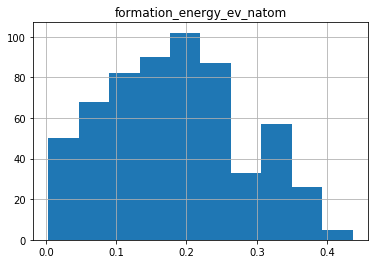

In [50]:
sub[["formation_energy_ev_natom"]].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fea6cfa5048>]], dtype=object)

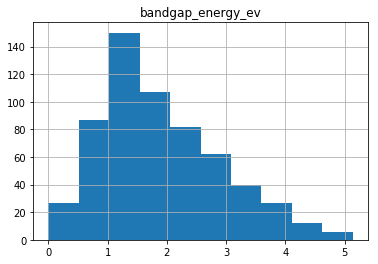

In [51]:
sub[["bandgap_energy_ev"]].hist()

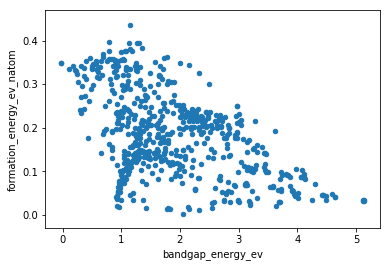

In [45]:
sub.plot.scatter(x='bandgap_energy_ev',y='formation_energy_ev_natom')

In [46]:
sub.head(1)

,id,formation_energy_ev_natom,bandgap_energy_ev
0,1,0.179359,1.609947


In [ ]:
# stupid Catboost
X_train, X_test, y_train, y_test = train_test_split(real_train[feats], real_train['formation_energy_ev_natom'], test_size=0.33, random_state=42)

In [ ]:
%%time
model = CatBoostRegressor(depth= 4, 
                iterations=1500, 
                learning_rate=0.2, 
                l2_leaf_reg=3, 
                ctr_description= ('Borders','Buckets', 'BinarizedTargetMeanValue', 'Counter'),
                rsm=0.8,
                random_seed= 42,
                border_count=100,
#                 ctr_border_count= 200,
                thread_count= 4,
                loss_function='RMSE')

indices = np.where(np.in1d(X_train.columns, cat_param))[0]
train_pool = Pool(X_train, y_train, cat_features=indices)
test_pool = Pool(X_test, cat_features=indices) 
real_test_pool=Pool(real_test[feats],cat_features=indices)
all_train_pool=Pool(real_train[feats],cat_features=indices)
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)

In [ ]:
preds_train = model.predict(all_train_pool)
real_train['pred_form']=pd.Series(preds_train)

In [ ]:
real_train[['formation_energy_ev_natom','pred_form']]

In [ ]:
# stupid Catboost
X_train, X_test, y_train, y_test = train_test_split(real_train[feats], real_train['bandgap_energy_ev'], test_size=0.33, random_state=42)

In [ ]:
%%time
model2 = CatBoostRegressor(depth= 4, 
                iterations=1500, 
                learning_rate=0.2, 
                l2_leaf_reg=3, 
                ctr_description= ('Borders','Buckets', 'BinarizedTargetMeanValue', 'Counter'),
                rsm=0.8,
                random_seed= 42,
                border_count=100,
#                 ctr_border_count= 200,
                thread_count= 4,
                loss_function='RMSE')

indices = np.where(np.in1d(X_train.columns, cat_param))[0]
train_pool = Pool(X_train, y_train, cat_features=indices)
test_pool = Pool(X_test, cat_features=indices) 
real_test_pool=Pool(real_test[feats],cat_features=indices)
all_train_pool=Pool(real_train[feats],cat_features=indices)
#train the model
model2.fit(train_pool)
# make the prediction using the resulting model
preds2 = model2.predict(test_pool)

In [ ]:
preds_train = model2.predict(all_train_pool)
real_train['pred_band']=pd.Series(preds_train)

In [ ]:
real_train[['pred_band']].hist()

In [ ]:
real_train[['bandgap_energy_ev']].hist()

In [ ]:
real_train[['formation_energy_ev_natom']].hist()

In [ ]:
real_train[['pred_form']].hist()

In [ ]:
real_test['formation_energy_ev_natom']=pd.Series(preds)
real_test['bandgap_energy_ev']=pd.Series(preds2)
real_test

In [ ]:
real_test[['id','formation_energy_ev_natom','bandgap_energy_ev']].to_csv('submission_2.csv')

In [ ]:
real_train.plot.scatter(x='formation_energy_ev_natom', y='bandgap_energy_ev')